In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/ham_windsurf

/content/drive/MyDrive/ham_windsurf


In [3]:
import os
import sys
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

# Add src directory to path
sys.path.append('../')
from src.gan.models import DCGANGenerator, DCGANDiscriminator, weights_init
from src.gan.utils.data import HAM10000GanDataset, create_single_class_loader
from src.gan.utils.metrics import calculate_fid, calculate_fid_from_stats, InceptionV3Features, calculate_activation_statistics

In [4]:
# Create output directory
output_dir = '/content/drive/MyDrive/ham_windsurf/results/dcgan'
os.makedirs(output_dir, exist_ok=True)

In [5]:
# Configuration
csv_file = '/content/drive/MyDrive/ham_windsurf/archive/GroundTruth_filtered.csv'
img_dir = '/content/drive/MyDrive/ham_windsurf/archive/hair_removed_images'
batch_size = 64
image_size = 128
num_workers = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load dataset information
df = pd.read_csv(csv_file)
categories = df.columns[1:].tolist()
print(f"Categories: {categories}")

# Get class counts
class_counts = {}
for category in categories:
    class_counts[category] = int(df[category].sum())
print(f"Class counts: {class_counts}")

# Create a combined dataloader for all classes for FID calculation
real_dataset = HAM10000GanDataset(csv_file, img_dir, image_size=image_size)
real_loader = torch.utils.data.DataLoader(real_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

Using device: cuda
Categories: ['NV', 'MEL', 'BKL', 'BCC', 'AKIEC']
Class counts: {'NV': 6705, 'MEL': 1113, 'BKL': 1099, 'BCC': 514, 'AKIEC': 327}


In [6]:
# Model parameters
latent_dim = 100
channels = 3
ngf = 64  # Number of generator filters
ndf = 64  # Number of discriminator filters

# Training parameters
epochs = 300  # 300
lr = 0.0002
beta1 = 0.5
log_interval = 10
sample_interval = 100
save_interval = 10

# Initialize models
netG = DCGANGenerator(
    latent_dim=latent_dim,
    channels=channels,
    ngf=ngf
).to(device)

netD = DCGANDiscriminator(
    channels=channels,
    ndf=ndf
).to(device)

# Print model summary
print(f"Generator parameters: {sum(p.numel() for p in netG.parameters())}")
print(f"Discriminator parameters: {sum(p.numel() for p in netD.parameters())}")

# Initialize weights
netG.apply(weights_init)
netD.apply(weights_init)

# Setup optimizers
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))

# Loss function
adversarial_loss = nn.BCEWithLogitsLoss()

# Fixed noise for visualization
fixed_noise = torch.randn(64, latent_dim).to(device)

Generator parameters: 12786560
Discriminator parameters: 11164416


In [7]:
# Function to save image grid
def save_image_grid(images, path, nrow=8, title=None):
    # Convert to numpy and transpose to (H, W, C)
    images = images.cpu().numpy().transpose(0, 2, 3, 1)

    # Create grid
    n_images = images.shape[0]
    rows = int(np.ceil(n_images / nrow))
    grid = np.zeros((rows * images.shape[1], nrow * images.shape[2], images.shape[3]))

    for i, image in enumerate(images):
        row = i // nrow
        col = i % nrow
        grid[row * images.shape[1]:(row + 1) * images.shape[1],
             col * images.shape[2]:(col + 1) * images.shape[2], :] = image

    # Plot and save
    plt.figure(figsize=(15, 15 * rows / nrow))
    plt.imshow(grid)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(path)
    plt.close()

In [8]:
# Training loop
def train_dcgan():
    print("Starting training...")
    g_losses = []
    d_losses = []

    # Add list to store FID scores
    fid_scores = []
    epochs_with_fid = []

    start_time = time.time()

    # For FID: prepare real dataloader (subset of real images, same transform as generated images)
    inception = InceptionV3Features(device)
    # Precompute real stats
    mu_real, sigma_real = calculate_activation_statistics(real_loader, inception, device=device, max_samples=1000)

    for epoch in range(epochs):
        for i, batch in enumerate(tqdm(real_loader, desc=f"Epoch {epoch+1}/{epochs}")):
            real_images = batch['image'].to(device)
            batch_size = real_images.size(0)

            # Create labels
            real_target = torch.ones(batch_size, device=device) * 0.9  # Label smoothing
            fake_target = torch.zeros(batch_size, device=device)

            ############################
            # (1) Update D network
            ###########################
            netD.zero_grad()

            # Real images
            real_pred = netD(real_images)
            d_real_loss = adversarial_loss(real_pred, real_target)

            # Fake images
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_images = netG(z)

            fake_pred = netD(fake_images.detach())
            d_fake_loss = adversarial_loss(fake_pred, fake_target)

            # Total discriminator loss
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            optimizerD.step()

            ############################
            # (2) Update G network
            ###########################
            netG.zero_grad()

            # Generate new fake images
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_images = netG(z)

            # Get discriminator predictions
            fake_pred = netD(fake_images)

            # Generator loss
            g_loss = adversarial_loss(fake_pred, real_target)
            g_loss.backward()
            optimizerG.step()

            # Save losses for plotting later
            g_losses.append(g_loss.item())
            d_losses.append(d_loss.item())

            # Output training stats
            if i % log_interval == 0:
                elapsed = time.time() - start_time
                print(f'[{epoch+1}/{epochs}][{i}/{len(real_loader)}] '
                      f'Loss_D: {d_loss.item():.4f} Loss_G: {g_loss.item():.4f} '
                      f'D_real: {d_real_loss.item():.4f} D_fake: {d_fake_loss.item():.4f} '
                      f'Time: {elapsed:.2f}s')

            # Check how the generator is doing by saving G's output on fixed_noise
            if (i % sample_interval == 0) or ((epoch == epochs-1) and (i == len(real_loader)-1)):
                with torch.no_grad():
                    fake = netG(fixed_noise).detach().cpu()
                    # Normalize from [-1, 1] to [0, 1]
                    fake = (fake + 1) / 2

                    # Save images
                    save_image_grid(
                        fake,
                        os.path.join(output_dir, f'samples_epoch_{epoch+1}_iter_{i}.png'),
                        nrow=8,
                        title=f'DCGAN Samples - Epoch {epoch+1}, Iteration {i}'
                    )

        # Save model checkpoints
        if (epoch + 1) % save_interval == 0 or epoch == epochs - 1:
            torch.save({
                'epoch': epoch,
                'generator_state_dict': netG.state_dict(),
                'discriminator_state_dict': netD.state_dict(),
                'optimizerG_state_dict': optimizerG.state_dict(),
                'optimizerD_state_dict': optimizerD.state_dict(),
                'g_loss': g_loss.item(),
                'd_loss': d_loss.item(),
            }, os.path.join(output_dir, f'dcgan_checkpoint_epoch_{epoch+1}.pt'))

        # Calculate FID score every 10 epochs or at the end
        if epoch % 10 == 0 or epoch == epochs - 1:
            # Generate a batch of images for FID calculation
            print(f"Calculating FID score for epoch {epoch+1}...")
            n_samples = 1000
            n_batches = n_samples // batch_size + 1
            fake_images = []

            with torch.no_grad():
                for i in range(n_batches):
                    z = torch.randn(batch_size, latent_dim).to(device)
                    fake_batch = netG(z).detach()
                    fake_images.append(fake_batch)

            fake_images = torch.cat(fake_images, dim=0)[:n_samples]

            # Create a dataloader for the fake images
            class FakeDataset(Dataset):
                def __init__(self, images):
                    self.images = images

                def __len__(self):
                    return len(self.images)

                def __getitem__(self, idx):
                    return {'image': self.images[idx]}

            fake_dataset = FakeDataset(fake_images)
            fake_loader = DataLoader(fake_dataset, batch_size=batch_size, shuffle=False)

            # Calculate FID
            mu_fake, sigma_fake = calculate_activation_statistics(fake_loader, inception, device=device)
            fid = calculate_fid_from_stats(mu_real, sigma_real, mu_fake, sigma_fake)
            print(f"FID score at epoch {epoch+1}: {fid:.4f}")

            # Store FID score for plotting
            fid_scores.append(fid)
            epochs_with_fid.append(epoch + 1)

    # Save loss plots with better styling
    plt.figure(figsize=(15, 10))

    # Main losses plot
    plt.subplot(2, 2, 1)
    plt.plot(g_losses, label='Generator', color='#2E86C1', alpha=0.8, linewidth=2)
    plt.plot(d_losses, label='Discriminator', color='#E74C3C', alpha=0.8, linewidth=2)
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Generator and Discriminator Losses', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)

    # Moving average for smoother curves
    window_size = 50
    if len(g_losses) > window_size:
        g_losses_smooth = np.convolve(g_losses, np.ones(window_size)/window_size, mode='valid')
        d_losses_smooth = np.convolve(d_losses, np.ones(window_size)/window_size, mode='valid')
        x_smooth = range(window_size-1, len(g_losses))

        plt.subplot(2, 2, 2)
        plt.plot(x_smooth, g_losses_smooth, label='Generator (Smoothed)', color='#2E86C1', linewidth=2)
        plt.plot(x_smooth, d_losses_smooth, label='Discriminator (Smoothed)', color='#E74C3C', linewidth=2)
        plt.xlabel('Iteration', fontsize=12)
        plt.ylabel('Loss', fontsize=12)
        plt.title('Smoothed Losses', fontsize=14, fontweight='bold')
        plt.legend(fontsize=10)
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'loss_plots.png'), dpi=300)
    plt.close()

    # Plot FID scores
    plt.figure(figsize=(10, 6))
    plt.plot(epochs_with_fid, fid_scores, marker='o', linestyle='-', color='#8E44AD', linewidth=2, markersize=8)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('FID Score', fontsize=12)
    plt.title('FID Score Progression', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.xticks(epochs_with_fid)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'fid_scores.png'), dpi=300)
    plt.close()

    # Save FID scores to file
    with open(os.path.join(output_dir, 'fid_scores.txt'), 'w') as f:
        for epoch, fid in zip(epochs_with_fid, fid_scores):
            f.write(f"Epoch {epoch}: {fid:.4f}\n")

    return netG, netD, fid_scores, epochs_with_fid

In [9]:
def generate_samples(generator, n_samples=100):
    """
    Generate and display random samples
    Args:
        generator: Trained generator model
        n_samples: Number of samples to generate
    """
    generator.eval()

    # Create fixed noise for consistent generation
    fixed_noise = torch.randn(n_samples, latent_dim).to(device)

    plt.figure(figsize=(15, 15))

    with torch.no_grad():
        # Generate images
        fake = generator(fixed_noise)

        # Normalize from [-1, 1] to [0, 1]
        fake = (fake + 1) / 2

        # Create a grid of images
        img_grid = make_grid(fake.cpu(), nrow=10, normalize=False, padding=2)

        # Plot
        plt.imshow(np.transpose(img_grid.numpy(), (1, 2, 0)))
        plt.title(f"Generated Samples", fontsize=14, fontweight='bold')
        plt.axis('off')

        # Save samples
        save_image_grid(
            fake.cpu(),
            os.path.join(output_dir, f'generated_samples.png'),
            nrow=10,
            title=f'Generated Samples'
        )

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'all_samples.png'), dpi=300)
    plt.close()

    # Return samples for further analysis if needed
    return fake.cpu()

Starting training...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 214MB/s]
Calculating statistics:  10%|▉         | 15/153 [04:37<42:28, 18.47s/it]


Epoch 1/300:   0%|          | 0/153 [00:00<?, ?it/s]

[1/300][0/153] Loss_D: 2.3441 Loss_G: 13.7207 D_real: 0.7520 D_fake: 1.5922 Time: 325.88s
[1/300][10/153] Loss_D: 1.1871 Loss_G: 13.9777 D_real: 1.0159 D_fake: 0.1713 Time: 421.86s
[1/300][20/153] Loss_D: 1.4492 Loss_G: 30.8361 D_real: 1.4492 D_fake: 0.0000 Time: 549.24s
[1/300][30/153] Loss_D: 1.7841 Loss_G: 30.0338 D_real: 1.7841 D_fake: 0.0000 Time: 653.92s
[1/300][40/153] Loss_D: 0.9083 Loss_G: 11.2478 D_real: 0.9083 D_fake: 0.0000 Time: 765.85s
[1/300][50/153] Loss_D: 0.7106 Loss_G: 10.1374 D_real: 0.6480 D_fake: 0.0626 Time: 876.16s
[1/300][60/153] Loss_D: 5.0020 Loss_G: 11.8635 D_real: 5.0020 D_fake: 0.0000 Time: 989.99s
[1/300][70/153] Loss_D: 1.7403 Loss_G: 12.6249 D_real: 1.7403 D_fake: 0.0000 Time: 1097.32s
[1/300][80/153] Loss_D: 0.5452 Loss_G: 6.3290 D_real: 0.4671 D_fake: 0.0781 Time: 1210.98s
[1/300][90/153] Loss_D: 0.4284 Loss_G: 5.8398 D_real: 0.4179 D_fake: 0.0105 Time: 1321.50s
[1/300][100/153] Loss_D: 1.0720 Loss_G: 1.9351 D_real: 1.0011 D_fake: 0.0709 Time: 1434.96

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 50.68it/s]


FID score at epoch 1: 373.2354


Epoch 2/300:   0%|          | 0/153 [00:00<?, ?it/s]

[2/300][0/153] Loss_D: 0.9582 Loss_G: 8.1167 D_real: 0.6644 D_fake: 0.2938 Time: 2020.66s
[2/300][10/153] Loss_D: 0.4424 Loss_G: 4.9087 D_real: 0.4206 D_fake: 0.0218 Time: 2022.98s
[2/300][20/153] Loss_D: 0.4217 Loss_G: 4.8073 D_real: 0.3873 D_fake: 0.0343 Time: 2024.15s
[2/300][30/153] Loss_D: 0.5212 Loss_G: 6.1040 D_real: 0.4904 D_fake: 0.0308 Time: 2025.52s
[2/300][40/153] Loss_D: 0.4176 Loss_G: 4.2557 D_real: 0.3976 D_fake: 0.0200 Time: 2026.62s
[2/300][50/153] Loss_D: 0.8621 Loss_G: 1.8419 D_real: 0.8598 D_fake: 0.0023 Time: 2027.94s
[2/300][60/153] Loss_D: 0.6119 Loss_G: 4.9894 D_real: 0.4715 D_fake: 0.1405 Time: 2029.07s
[2/300][70/153] Loss_D: 0.5586 Loss_G: 4.6077 D_real: 0.5561 D_fake: 0.0025 Time: 2030.40s
[2/300][80/153] Loss_D: 0.4451 Loss_G: 8.6195 D_real: 0.4426 D_fake: 0.0025 Time: 2031.49s
[2/300][90/153] Loss_D: 0.6531 Loss_G: 4.8796 D_real: 0.5501 D_fake: 0.1031 Time: 2032.82s
[2/300][100/153] Loss_D: 2.5582 Loss_G: 1.1221 D_real: 2.5571 D_fake: 0.0010 Time: 2033.88s

Epoch 3/300:   0%|          | 0/153 [00:00<?, ?it/s]

[3/300][0/153] Loss_D: 0.5284 Loss_G: 3.0763 D_real: 0.4444 D_fake: 0.0840 Time: 2042.35s
[3/300][10/153] Loss_D: 0.5824 Loss_G: 4.3178 D_real: 0.4247 D_fake: 0.1578 Time: 2045.00s
[3/300][20/153] Loss_D: 0.4621 Loss_G: 4.6366 D_real: 0.4244 D_fake: 0.0377 Time: 2046.13s
[3/300][30/153] Loss_D: 1.7114 Loss_G: 8.3449 D_real: 0.4865 D_fake: 1.2250 Time: 2047.41s
[3/300][40/153] Loss_D: 1.5805 Loss_G: 6.1149 D_real: 0.7980 D_fake: 0.7825 Time: 2048.64s
[3/300][50/153] Loss_D: 0.6497 Loss_G: 2.4964 D_real: 0.4423 D_fake: 0.2074 Time: 2049.96s
[3/300][60/153] Loss_D: 0.6121 Loss_G: 2.4216 D_real: 0.5134 D_fake: 0.0988 Time: 2051.16s
[3/300][70/153] Loss_D: 0.6894 Loss_G: 2.5666 D_real: 0.6347 D_fake: 0.0546 Time: 2052.34s
[3/300][80/153] Loss_D: 0.8897 Loss_G: 1.8532 D_real: 0.7171 D_fake: 0.1727 Time: 2053.62s
[3/300][90/153] Loss_D: 0.8292 Loss_G: 3.4036 D_real: 0.4143 D_fake: 0.4149 Time: 2054.80s
[3/300][100/153] Loss_D: 1.2636 Loss_G: 3.1073 D_real: 0.4781 D_fake: 0.7855 Time: 2056.11s

Epoch 4/300:   0%|          | 0/153 [00:00<?, ?it/s]

[4/300][0/153] Loss_D: 1.1066 Loss_G: 3.5758 D_real: 0.5152 D_fake: 0.5914 Time: 2064.86s
[4/300][10/153] Loss_D: 0.9625 Loss_G: 2.0693 D_real: 0.9258 D_fake: 0.0367 Time: 2067.81s
[4/300][20/153] Loss_D: 0.7093 Loss_G: 2.3250 D_real: 0.6897 D_fake: 0.0196 Time: 2068.95s
[4/300][30/153] Loss_D: 0.9000 Loss_G: 4.5047 D_real: 0.5730 D_fake: 0.3270 Time: 2070.46s
[4/300][40/153] Loss_D: 0.6496 Loss_G: 2.5508 D_real: 0.4141 D_fake: 0.2355 Time: 2071.46s
[4/300][50/153] Loss_D: 0.6362 Loss_G: 4.2057 D_real: 0.6214 D_fake: 0.0148 Time: 2072.89s
[4/300][60/153] Loss_D: 0.7440 Loss_G: 6.5897 D_real: 0.4297 D_fake: 0.3144 Time: 2073.97s
[4/300][70/153] Loss_D: 0.9934 Loss_G: 3.6871 D_real: 0.4475 D_fake: 0.5460 Time: 2075.45s
[4/300][80/153] Loss_D: 0.9365 Loss_G: 5.1177 D_real: 0.5253 D_fake: 0.4112 Time: 2076.46s
[4/300][90/153] Loss_D: 0.6920 Loss_G: 4.3235 D_real: 0.4413 D_fake: 0.2507 Time: 2077.82s
[4/300][100/153] Loss_D: 0.6857 Loss_G: 2.2925 D_real: 0.6137 D_fake: 0.0721 Time: 2078.78s

Epoch 5/300:   0%|          | 0/153 [00:00<?, ?it/s]

[5/300][0/153] Loss_D: 1.9090 Loss_G: 5.9620 D_real: 0.3764 D_fake: 1.5325 Time: 2087.34s
[5/300][10/153] Loss_D: 1.0116 Loss_G: 1.6536 D_real: 0.6602 D_fake: 0.3513 Time: 2090.24s
[5/300][20/153] Loss_D: 1.5065 Loss_G: 1.8512 D_real: 0.4853 D_fake: 1.0212 Time: 2091.41s
[5/300][30/153] Loss_D: 0.7405 Loss_G: 2.0880 D_real: 0.5700 D_fake: 0.1705 Time: 2092.68s
[5/300][40/153] Loss_D: 0.7533 Loss_G: 3.2701 D_real: 0.3945 D_fake: 0.3587 Time: 2093.94s
[5/300][50/153] Loss_D: 1.1115 Loss_G: 1.1496 D_real: 0.9615 D_fake: 0.1500 Time: 2095.16s
[5/300][60/153] Loss_D: 0.9203 Loss_G: 3.6416 D_real: 0.5037 D_fake: 0.4166 Time: 2096.42s
[5/300][70/153] Loss_D: 1.0499 Loss_G: 1.5118 D_real: 0.9648 D_fake: 0.0851 Time: 2097.57s
[5/300][80/153] Loss_D: 1.4943 Loss_G: 6.2266 D_real: 0.4240 D_fake: 1.0703 Time: 2099.03s
[5/300][90/153] Loss_D: 1.2575 Loss_G: 0.9845 D_real: 1.1989 D_fake: 0.0586 Time: 2100.12s
[5/300][100/153] Loss_D: 1.1919 Loss_G: 0.7825 D_real: 0.9731 D_fake: 0.2188 Time: 2101.39s

Epoch 6/300:   0%|          | 0/153 [00:00<?, ?it/s]

[6/300][0/153] Loss_D: 2.5023 Loss_G: 0.6048 D_real: 2.4936 D_fake: 0.0087 Time: 2110.18s
[6/300][10/153] Loss_D: 0.7647 Loss_G: 2.2865 D_real: 0.4349 D_fake: 0.3298 Time: 2113.27s
[6/300][20/153] Loss_D: 0.9770 Loss_G: 4.0960 D_real: 0.4882 D_fake: 0.4888 Time: 2114.37s
[6/300][30/153] Loss_D: 1.8758 Loss_G: 3.7606 D_real: 0.4722 D_fake: 1.4036 Time: 2115.63s
[6/300][40/153] Loss_D: 1.7445 Loss_G: 1.0748 D_real: 1.6974 D_fake: 0.0470 Time: 2116.80s
[6/300][50/153] Loss_D: 0.7603 Loss_G: 2.0999 D_real: 0.4853 D_fake: 0.2750 Time: 2118.09s
[6/300][60/153] Loss_D: 1.5518 Loss_G: 4.3744 D_real: 0.3984 D_fake: 1.1534 Time: 2119.26s
[6/300][70/153] Loss_D: 0.9320 Loss_G: 2.7422 D_real: 0.6267 D_fake: 0.3053 Time: 2120.47s
[6/300][80/153] Loss_D: 1.0633 Loss_G: 1.2342 D_real: 0.7411 D_fake: 0.3222 Time: 2121.71s
[6/300][90/153] Loss_D: 0.9695 Loss_G: 1.2570 D_real: 0.7787 D_fake: 0.1908 Time: 2123.03s
[6/300][100/153] Loss_D: 1.0405 Loss_G: 1.8934 D_real: 0.8120 D_fake: 0.2285 Time: 2124.30s

Epoch 7/300:   0%|          | 0/153 [00:00<?, ?it/s]

[7/300][0/153] Loss_D: 0.8669 Loss_G: 2.6471 D_real: 0.4663 D_fake: 0.4007 Time: 2132.97s
[7/300][10/153] Loss_D: 1.4014 Loss_G: 2.4633 D_real: 0.4613 D_fake: 0.9401 Time: 2136.12s
[7/300][20/153] Loss_D: 0.8567 Loss_G: 2.1840 D_real: 0.5714 D_fake: 0.2853 Time: 2137.18s
[7/300][30/153] Loss_D: 0.9197 Loss_G: 2.6575 D_real: 0.4566 D_fake: 0.4631 Time: 2138.56s
[7/300][40/153] Loss_D: 0.9005 Loss_G: 1.4463 D_real: 0.7883 D_fake: 0.1122 Time: 2139.59s
[7/300][50/153] Loss_D: 0.9930 Loss_G: 0.9323 D_real: 0.4597 D_fake: 0.5333 Time: 2141.05s
[7/300][60/153] Loss_D: 0.8575 Loss_G: 2.2617 D_real: 0.6118 D_fake: 0.2458 Time: 2142.11s
[7/300][70/153] Loss_D: 1.0911 Loss_G: 3.5852 D_real: 0.4897 D_fake: 0.6014 Time: 2143.54s
[7/300][80/153] Loss_D: 1.2145 Loss_G: 2.6373 D_real: 0.4473 D_fake: 0.7672 Time: 2144.51s
[7/300][90/153] Loss_D: 0.9139 Loss_G: 1.6672 D_real: 0.5876 D_fake: 0.3263 Time: 2145.85s
[7/300][100/153] Loss_D: 1.0015 Loss_G: 1.3542 D_real: 0.8185 D_fake: 0.1830 Time: 2146.88s

Epoch 8/300:   0%|          | 0/153 [00:00<?, ?it/s]

[8/300][0/153] Loss_D: 1.1304 Loss_G: 1.2132 D_real: 0.8140 D_fake: 0.3165 Time: 2155.66s
[8/300][10/153] Loss_D: 0.9171 Loss_G: 1.9519 D_real: 0.6389 D_fake: 0.2782 Time: 2158.67s
[8/300][20/153] Loss_D: 1.1240 Loss_G: 2.0975 D_real: 0.4321 D_fake: 0.6919 Time: 2159.79s
[8/300][30/153] Loss_D: 1.2943 Loss_G: 2.4643 D_real: 0.4532 D_fake: 0.8410 Time: 2161.24s
[8/300][40/153] Loss_D: 0.9023 Loss_G: 2.2829 D_real: 0.6923 D_fake: 0.2100 Time: 2162.29s
[8/300][50/153] Loss_D: 1.0112 Loss_G: 2.1493 D_real: 0.3829 D_fake: 0.6284 Time: 2163.59s
[8/300][60/153] Loss_D: 1.0561 Loss_G: 2.5815 D_real: 0.4435 D_fake: 0.6126 Time: 2164.72s
[8/300][70/153] Loss_D: 0.9489 Loss_G: 1.0704 D_real: 0.6999 D_fake: 0.2490 Time: 2166.03s
[8/300][80/153] Loss_D: 1.7077 Loss_G: 4.5024 D_real: 0.4070 D_fake: 1.3007 Time: 2167.19s
[8/300][90/153] Loss_D: 1.0949 Loss_G: 1.7293 D_real: 0.8284 D_fake: 0.2664 Time: 2168.45s
[8/300][100/153] Loss_D: 0.8018 Loss_G: 3.0423 D_real: 0.4159 D_fake: 0.3859 Time: 2169.63s

Epoch 9/300:   0%|          | 0/153 [00:00<?, ?it/s]

[9/300][0/153] Loss_D: 1.2550 Loss_G: 2.7170 D_real: 0.5810 D_fake: 0.6740 Time: 2178.20s
[9/300][10/153] Loss_D: 1.3172 Loss_G: 2.5216 D_real: 0.3844 D_fake: 0.9327 Time: 2181.30s
[9/300][20/153] Loss_D: 1.1776 Loss_G: 3.1043 D_real: 0.4472 D_fake: 0.7305 Time: 2182.35s
[9/300][30/153] Loss_D: 1.0120 Loss_G: 1.9310 D_real: 0.5354 D_fake: 0.4766 Time: 2183.79s
[9/300][40/153] Loss_D: 1.4435 Loss_G: 1.1378 D_real: 1.3657 D_fake: 0.0778 Time: 2184.88s
[9/300][50/153] Loss_D: 1.1739 Loss_G: 2.8778 D_real: 0.3654 D_fake: 0.8085 Time: 2186.37s
[9/300][60/153] Loss_D: 1.4945 Loss_G: 2.6877 D_real: 0.5911 D_fake: 0.9034 Time: 2187.42s
[9/300][70/153] Loss_D: 1.2007 Loss_G: 0.9178 D_real: 0.8662 D_fake: 0.3345 Time: 2188.81s
[9/300][80/153] Loss_D: 1.4263 Loss_G: 1.5906 D_real: 1.3166 D_fake: 0.1097 Time: 2189.89s
[9/300][90/153] Loss_D: 1.0120 Loss_G: 1.5671 D_real: 0.7593 D_fake: 0.2527 Time: 2191.32s
[9/300][100/153] Loss_D: 1.3429 Loss_G: 1.4867 D_real: 0.8202 D_fake: 0.5228 Time: 2192.41s

Epoch 10/300:   0%|          | 0/153 [00:00<?, ?it/s]

[10/300][0/153] Loss_D: 1.0589 Loss_G: 1.5487 D_real: 0.8429 D_fake: 0.2159 Time: 2201.16s
[10/300][10/153] Loss_D: 1.4283 Loss_G: 2.5065 D_real: 0.4843 D_fake: 0.9440 Time: 2204.16s
[10/300][20/153] Loss_D: 0.9773 Loss_G: 1.7680 D_real: 0.8183 D_fake: 0.1590 Time: 2205.29s
[10/300][30/153] Loss_D: 1.4815 Loss_G: 2.6047 D_real: 0.4761 D_fake: 1.0054 Time: 2206.60s
[10/300][40/153] Loss_D: 1.4507 Loss_G: 1.5363 D_real: 0.9027 D_fake: 0.5480 Time: 2207.67s
[10/300][50/153] Loss_D: 0.9625 Loss_G: 2.0805 D_real: 0.4004 D_fake: 0.5621 Time: 2209.09s
[10/300][60/153] Loss_D: 0.9321 Loss_G: 1.7898 D_real: 0.6412 D_fake: 0.2909 Time: 2210.17s
[10/300][70/153] Loss_D: 1.2326 Loss_G: 2.1820 D_real: 0.4319 D_fake: 0.8007 Time: 2211.53s
[10/300][80/153] Loss_D: 1.3753 Loss_G: 2.9211 D_real: 0.4116 D_fake: 0.9637 Time: 2212.60s
[10/300][90/153] Loss_D: 1.0501 Loss_G: 1.3013 D_real: 0.7584 D_fake: 0.2917 Time: 2213.97s
[10/300][100/153] Loss_D: 1.2462 Loss_G: 1.2715 D_real: 0.5972 D_fake: 0.6490 Tim

Epoch 11/300:   0%|          | 0/153 [00:00<?, ?it/s]

[11/300][0/153] Loss_D: 1.7210 Loss_G: 1.0549 D_real: 1.2174 D_fake: 0.5036 Time: 2224.54s
[11/300][10/153] Loss_D: 1.0365 Loss_G: 1.5327 D_real: 0.7379 D_fake: 0.2986 Time: 2227.59s
[11/300][20/153] Loss_D: 1.2117 Loss_G: 1.8953 D_real: 0.7722 D_fake: 0.4395 Time: 2228.67s
[11/300][30/153] Loss_D: 1.2960 Loss_G: 1.3140 D_real: 0.5153 D_fake: 0.7807 Time: 2229.95s
[11/300][40/153] Loss_D: 1.4209 Loss_G: 1.3674 D_real: 1.0652 D_fake: 0.3557 Time: 2230.98s
[11/300][50/153] Loss_D: 1.1541 Loss_G: 1.1862 D_real: 0.9202 D_fake: 0.2339 Time: 2232.38s
[11/300][60/153] Loss_D: 1.3706 Loss_G: 3.1133 D_real: 0.5405 D_fake: 0.8300 Time: 2233.59s
[11/300][70/153] Loss_D: 1.6787 Loss_G: 0.8808 D_real: 1.3567 D_fake: 0.3220 Time: 2234.97s
[11/300][80/153] Loss_D: 1.4776 Loss_G: 2.0789 D_real: 0.4988 D_fake: 0.9788 Time: 2236.24s
[11/300][90/153] Loss_D: 1.4363 Loss_G: 1.4121 D_real: 0.9630 D_fake: 0.4733 Time: 2237.52s
[11/300][100/153] Loss_D: 1.2897 Loss_G: 1.5608 D_real: 0.7588 D_fake: 0.5309 Tim

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 60.04it/s]


FID score at epoch 11: 139.5588


Epoch 12/300:   0%|          | 0/153 [00:00<?, ?it/s]

[12/300][0/153] Loss_D: 1.1209 Loss_G: 1.1351 D_real: 0.8173 D_fake: 0.3036 Time: 2253.72s
[12/300][10/153] Loss_D: 1.1899 Loss_G: 1.9596 D_real: 0.5422 D_fake: 0.6477 Time: 2257.43s
[12/300][20/153] Loss_D: 1.3646 Loss_G: 0.7044 D_real: 1.1600 D_fake: 0.2045 Time: 2258.55s
[12/300][30/153] Loss_D: 1.3332 Loss_G: 0.9136 D_real: 0.9409 D_fake: 0.3923 Time: 2259.97s
[12/300][40/153] Loss_D: 1.8296 Loss_G: 1.0797 D_real: 1.5953 D_fake: 0.2343 Time: 2261.09s
[12/300][50/153] Loss_D: 1.1451 Loss_G: 1.1137 D_real: 0.7240 D_fake: 0.4211 Time: 2262.43s
[12/300][60/153] Loss_D: 0.9803 Loss_G: 0.9935 D_real: 0.5857 D_fake: 0.3946 Time: 2263.48s
[12/300][70/153] Loss_D: 1.4393 Loss_G: 1.0320 D_real: 1.1372 D_fake: 0.3020 Time: 2264.79s
[12/300][80/153] Loss_D: 1.0968 Loss_G: 1.4347 D_real: 0.7200 D_fake: 0.3768 Time: 2265.98s
[12/300][90/153] Loss_D: 1.3416 Loss_G: 1.1942 D_real: 0.8621 D_fake: 0.4795 Time: 2267.20s
[12/300][100/153] Loss_D: 1.4020 Loss_G: 1.6435 D_real: 0.6453 D_fake: 0.7567 Tim

Epoch 13/300:   0%|          | 0/153 [00:00<?, ?it/s]

[13/300][0/153] Loss_D: 1.5235 Loss_G: 1.2426 D_real: 1.3889 D_fake: 0.1346 Time: 2277.01s
[13/300][10/153] Loss_D: 1.4789 Loss_G: 1.7671 D_real: 0.7479 D_fake: 0.7310 Time: 2279.99s
[13/300][20/153] Loss_D: 1.0745 Loss_G: 1.4247 D_real: 0.5307 D_fake: 0.5437 Time: 2281.00s
[13/300][30/153] Loss_D: 1.1878 Loss_G: 1.5803 D_real: 0.6314 D_fake: 0.5564 Time: 2282.41s
[13/300][40/153] Loss_D: 1.2824 Loss_G: 0.9559 D_real: 0.9747 D_fake: 0.3077 Time: 2283.48s
[13/300][50/153] Loss_D: 1.0850 Loss_G: 1.1000 D_real: 0.6130 D_fake: 0.4721 Time: 2284.96s
[13/300][60/153] Loss_D: 1.1517 Loss_G: 2.0858 D_real: 0.5225 D_fake: 0.6292 Time: 2285.98s
[13/300][70/153] Loss_D: 1.3663 Loss_G: 1.0921 D_real: 1.0914 D_fake: 0.2749 Time: 2287.35s
[13/300][80/153] Loss_D: 1.5081 Loss_G: 0.9363 D_real: 0.6322 D_fake: 0.8759 Time: 2288.45s
[13/300][90/153] Loss_D: 1.2260 Loss_G: 1.1770 D_real: 0.6267 D_fake: 0.5993 Time: 2289.85s
[13/300][100/153] Loss_D: 1.0775 Loss_G: 1.5676 D_real: 0.5985 D_fake: 0.4790 Tim

Epoch 14/300:   0%|          | 0/153 [00:00<?, ?it/s]

[14/300][0/153] Loss_D: 1.1499 Loss_G: 1.2943 D_real: 0.6144 D_fake: 0.5355 Time: 2299.71s
[14/300][10/153] Loss_D: 1.4949 Loss_G: 1.5986 D_real: 0.8244 D_fake: 0.6705 Time: 2302.67s
[14/300][20/153] Loss_D: 1.2704 Loss_G: 0.9007 D_real: 0.8543 D_fake: 0.4161 Time: 2303.67s
[14/300][30/153] Loss_D: 1.1264 Loss_G: 1.4780 D_real: 0.6438 D_fake: 0.4825 Time: 2305.09s
[14/300][40/153] Loss_D: 1.2786 Loss_G: 2.6393 D_real: 0.4454 D_fake: 0.8331 Time: 2306.15s
[14/300][50/153] Loss_D: 1.1790 Loss_G: 0.7465 D_real: 0.7490 D_fake: 0.4300 Time: 2307.50s
[14/300][60/153] Loss_D: 1.4026 Loss_G: 2.3272 D_real: 0.5340 D_fake: 0.8687 Time: 2308.59s
[14/300][70/153] Loss_D: 1.5570 Loss_G: 2.2938 D_real: 0.7673 D_fake: 0.7897 Time: 2310.08s
[14/300][80/153] Loss_D: 1.2769 Loss_G: 1.3009 D_real: 0.7015 D_fake: 0.5754 Time: 2311.12s
[14/300][90/153] Loss_D: 1.2294 Loss_G: 1.2472 D_real: 0.6018 D_fake: 0.6276 Time: 2312.51s
[14/300][100/153] Loss_D: 1.5257 Loss_G: 0.8714 D_real: 1.2332 D_fake: 0.2925 Tim

Epoch 15/300:   0%|          | 0/153 [00:00<?, ?it/s]

[15/300][0/153] Loss_D: 1.5125 Loss_G: 1.6903 D_real: 0.6143 D_fake: 0.8982 Time: 2322.34s
[15/300][10/153] Loss_D: 1.2846 Loss_G: 1.2195 D_real: 0.7631 D_fake: 0.5215 Time: 2325.25s
[15/300][20/153] Loss_D: 1.4307 Loss_G: 1.1590 D_real: 0.9733 D_fake: 0.4574 Time: 2326.34s
[15/300][30/153] Loss_D: 1.7820 Loss_G: 0.9691 D_real: 1.4822 D_fake: 0.2997 Time: 2327.67s
[15/300][40/153] Loss_D: 1.6625 Loss_G: 0.5669 D_real: 1.4624 D_fake: 0.2001 Time: 2328.72s
[15/300][50/153] Loss_D: 1.3354 Loss_G: 1.7686 D_real: 0.5505 D_fake: 0.7849 Time: 2330.08s
[15/300][60/153] Loss_D: 1.1885 Loss_G: 1.2893 D_real: 0.6235 D_fake: 0.5650 Time: 2331.16s
[15/300][70/153] Loss_D: 1.2784 Loss_G: 1.0723 D_real: 0.8193 D_fake: 0.4591 Time: 2332.60s
[15/300][80/153] Loss_D: 1.3894 Loss_G: 1.0102 D_real: 0.8037 D_fake: 0.5856 Time: 2333.70s
[15/300][90/153] Loss_D: 1.2935 Loss_G: 1.2224 D_real: 0.8617 D_fake: 0.4318 Time: 2335.15s
[15/300][100/153] Loss_D: 1.6294 Loss_G: 0.8330 D_real: 1.4368 D_fake: 0.1926 Tim

Epoch 16/300:   0%|          | 0/153 [00:00<?, ?it/s]

[16/300][0/153] Loss_D: 1.6621 Loss_G: 2.5440 D_real: 0.4821 D_fake: 1.1800 Time: 2344.59s
[16/300][10/153] Loss_D: 1.1748 Loss_G: 1.5471 D_real: 0.7645 D_fake: 0.4103 Time: 2347.69s
[16/300][20/153] Loss_D: 1.3709 Loss_G: 1.1778 D_real: 0.6509 D_fake: 0.7200 Time: 2348.75s
[16/300][30/153] Loss_D: 1.3038 Loss_G: 1.1454 D_real: 0.6230 D_fake: 0.6808 Time: 2350.20s
[16/300][40/153] Loss_D: 1.3236 Loss_G: 1.1567 D_real: 0.9919 D_fake: 0.3318 Time: 2351.23s
[16/300][50/153] Loss_D: 1.3614 Loss_G: 1.3947 D_real: 0.5902 D_fake: 0.7711 Time: 2352.57s
[16/300][60/153] Loss_D: 1.2230 Loss_G: 0.9418 D_real: 0.6000 D_fake: 0.6230 Time: 2353.70s
[16/300][70/153] Loss_D: 1.4317 Loss_G: 3.0860 D_real: 0.3891 D_fake: 1.0426 Time: 2355.12s
[16/300][80/153] Loss_D: 1.4204 Loss_G: 1.3831 D_real: 0.8694 D_fake: 0.5510 Time: 2356.28s
[16/300][90/153] Loss_D: 1.1275 Loss_G: 1.5801 D_real: 0.5922 D_fake: 0.5353 Time: 2357.67s
[16/300][100/153] Loss_D: 1.3973 Loss_G: 0.8012 D_real: 0.9375 D_fake: 0.4598 Tim

Epoch 17/300:   0%|          | 0/153 [00:00<?, ?it/s]

[17/300][0/153] Loss_D: 1.2815 Loss_G: 1.1004 D_real: 0.8001 D_fake: 0.4815 Time: 2367.48s
[17/300][10/153] Loss_D: 1.2563 Loss_G: 1.3266 D_real: 0.5135 D_fake: 0.7428 Time: 2370.47s
[17/300][20/153] Loss_D: 1.4117 Loss_G: 0.6686 D_real: 0.9494 D_fake: 0.4623 Time: 2371.58s
[17/300][30/153] Loss_D: 1.4655 Loss_G: 0.8378 D_real: 0.8220 D_fake: 0.6435 Time: 2372.98s
[17/300][40/153] Loss_D: 1.2629 Loss_G: 0.8153 D_real: 0.5789 D_fake: 0.6840 Time: 2374.05s
[17/300][50/153] Loss_D: 1.3710 Loss_G: 0.8875 D_real: 1.0734 D_fake: 0.2975 Time: 2375.38s
[17/300][60/153] Loss_D: 1.4403 Loss_G: 1.3728 D_real: 0.8638 D_fake: 0.5765 Time: 2376.50s
[17/300][70/153] Loss_D: 1.1935 Loss_G: 1.5773 D_real: 0.7474 D_fake: 0.4461 Time: 2377.78s
[17/300][80/153] Loss_D: 1.3093 Loss_G: 1.3313 D_real: 1.0252 D_fake: 0.2841 Time: 2378.92s
[17/300][90/153] Loss_D: 1.2019 Loss_G: 0.9575 D_real: 0.8591 D_fake: 0.3428 Time: 2380.25s
[17/300][100/153] Loss_D: 1.6172 Loss_G: 2.3327 D_real: 0.6161 D_fake: 1.0010 Tim

Epoch 18/300:   0%|          | 0/153 [00:00<?, ?it/s]

[18/300][0/153] Loss_D: 1.4021 Loss_G: 1.1073 D_real: 0.6983 D_fake: 0.7038 Time: 2389.93s
[18/300][10/153] Loss_D: 1.3334 Loss_G: 1.4574 D_real: 0.7155 D_fake: 0.6178 Time: 2392.89s
[18/300][20/153] Loss_D: 1.0245 Loss_G: 1.6479 D_real: 0.5946 D_fake: 0.4300 Time: 2393.99s
[18/300][30/153] Loss_D: 2.1651 Loss_G: 0.5601 D_real: 2.0674 D_fake: 0.0976 Time: 2395.46s
[18/300][40/153] Loss_D: 1.3839 Loss_G: 1.2859 D_real: 1.0732 D_fake: 0.3106 Time: 2396.65s
[18/300][50/153] Loss_D: 2.4980 Loss_G: 2.2607 D_real: 0.5205 D_fake: 1.9776 Time: 2397.98s
[18/300][60/153] Loss_D: 1.3963 Loss_G: 0.8102 D_real: 1.0127 D_fake: 0.3837 Time: 2399.18s
[18/300][70/153] Loss_D: 1.3271 Loss_G: 1.2616 D_real: 0.6926 D_fake: 0.6345 Time: 2400.36s
[18/300][80/153] Loss_D: 1.2603 Loss_G: 0.8833 D_real: 0.9424 D_fake: 0.3179 Time: 2401.59s
[18/300][90/153] Loss_D: 1.4074 Loss_G: 1.6362 D_real: 0.5279 D_fake: 0.8795 Time: 2402.85s
[18/300][100/153] Loss_D: 1.2725 Loss_G: 1.2576 D_real: 0.7298 D_fake: 0.5427 Tim

Epoch 19/300:   0%|          | 0/153 [00:00<?, ?it/s]

[19/300][0/153] Loss_D: 1.3787 Loss_G: 1.5660 D_real: 0.7480 D_fake: 0.6307 Time: 2412.51s
[19/300][10/153] Loss_D: 1.3137 Loss_G: 0.9867 D_real: 0.7825 D_fake: 0.5312 Time: 2415.51s
[19/300][20/153] Loss_D: 1.1969 Loss_G: 1.2605 D_real: 0.6558 D_fake: 0.5411 Time: 2416.58s
[19/300][30/153] Loss_D: 1.4498 Loss_G: 1.3644 D_real: 1.0553 D_fake: 0.3945 Time: 2417.99s
[19/300][40/153] Loss_D: 1.4288 Loss_G: 1.3033 D_real: 0.8852 D_fake: 0.5436 Time: 2419.03s
[19/300][50/153] Loss_D: 1.1426 Loss_G: 1.1059 D_real: 0.4665 D_fake: 0.6760 Time: 2420.56s
[19/300][60/153] Loss_D: 1.2441 Loss_G: 1.5224 D_real: 0.5290 D_fake: 0.7151 Time: 2421.62s
[19/300][70/153] Loss_D: 1.2260 Loss_G: 1.4103 D_real: 0.5335 D_fake: 0.6924 Time: 2423.08s
[19/300][80/153] Loss_D: 1.2660 Loss_G: 1.0942 D_real: 0.8021 D_fake: 0.4639 Time: 2424.09s
[19/300][90/153] Loss_D: 1.2558 Loss_G: 1.4135 D_real: 0.6000 D_fake: 0.6558 Time: 2425.57s
[19/300][100/153] Loss_D: 1.2553 Loss_G: 0.9621 D_real: 0.9369 D_fake: 0.3184 Tim

Epoch 20/300:   0%|          | 0/153 [00:00<?, ?it/s]

[20/300][0/153] Loss_D: 1.5679 Loss_G: 0.6417 D_real: 1.1320 D_fake: 0.4358 Time: 2435.36s
[20/300][10/153] Loss_D: 1.2587 Loss_G: 0.8725 D_real: 0.8143 D_fake: 0.4444 Time: 2438.26s
[20/300][20/153] Loss_D: 1.4003 Loss_G: 1.0633 D_real: 1.1297 D_fake: 0.2706 Time: 2439.29s
[20/300][30/153] Loss_D: 1.3916 Loss_G: 1.3542 D_real: 0.8830 D_fake: 0.5086 Time: 2440.61s
[20/300][40/153] Loss_D: 1.1660 Loss_G: 1.5007 D_real: 0.6576 D_fake: 0.5084 Time: 2441.67s
[20/300][50/153] Loss_D: 1.2381 Loss_G: 1.1517 D_real: 0.8528 D_fake: 0.3853 Time: 2443.02s
[20/300][60/153] Loss_D: 1.2493 Loss_G: 1.2896 D_real: 0.7024 D_fake: 0.5469 Time: 2444.21s
[20/300][70/153] Loss_D: 1.2463 Loss_G: 1.7199 D_real: 0.8310 D_fake: 0.4153 Time: 2445.54s
[20/300][80/153] Loss_D: 1.4700 Loss_G: 1.6533 D_real: 0.6378 D_fake: 0.8322 Time: 2446.74s
[20/300][90/153] Loss_D: 1.0683 Loss_G: 1.5873 D_real: 0.4199 D_fake: 0.6483 Time: 2448.02s
[20/300][100/153] Loss_D: 1.2037 Loss_G: 1.5197 D_real: 0.5572 D_fake: 0.6464 Tim

Epoch 21/300:   0%|          | 0/153 [00:00<?, ?it/s]

[21/300][0/153] Loss_D: 1.0490 Loss_G: 1.6177 D_real: 0.6407 D_fake: 0.4083 Time: 2458.34s
[21/300][10/153] Loss_D: 0.9071 Loss_G: 1.6619 D_real: 0.5536 D_fake: 0.3534 Time: 2461.38s
[21/300][20/153] Loss_D: 1.0027 Loss_G: 2.0684 D_real: 0.3860 D_fake: 0.6167 Time: 2462.44s
[21/300][30/153] Loss_D: 1.4373 Loss_G: 1.4434 D_real: 1.1224 D_fake: 0.3149 Time: 2463.84s
[21/300][40/153] Loss_D: 0.8894 Loss_G: 2.3427 D_real: 0.7698 D_fake: 0.1197 Time: 2464.85s
[21/300][50/153] Loss_D: 1.0256 Loss_G: 1.7340 D_real: 0.9263 D_fake: 0.0993 Time: 2466.25s
[21/300][60/153] Loss_D: 2.2578 Loss_G: 1.0232 D_real: 1.9046 D_fake: 0.3533 Time: 2467.39s
[21/300][70/153] Loss_D: 0.9746 Loss_G: 1.6853 D_real: 0.3786 D_fake: 0.5960 Time: 2468.83s
[21/300][80/153] Loss_D: 1.0489 Loss_G: 2.2127 D_real: 0.4808 D_fake: 0.5681 Time: 2470.07s
[21/300][90/153] Loss_D: 1.5536 Loss_G: 2.3317 D_real: 1.4949 D_fake: 0.0587 Time: 2471.36s
[21/300][100/153] Loss_D: 1.2105 Loss_G: 1.8354 D_real: 0.8996 D_fake: 0.3109 Tim

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 61.76it/s]


FID score at epoch 21: 205.8718


Epoch 22/300:   0%|          | 0/153 [00:00<?, ?it/s]

[22/300][0/153] Loss_D: 0.7838 Loss_G: 2.2550 D_real: 0.4611 D_fake: 0.3226 Time: 2491.77s
[22/300][10/153] Loss_D: 2.0389 Loss_G: 2.1174 D_real: 0.3471 D_fake: 1.6918 Time: 2494.80s
[22/300][20/153] Loss_D: 1.3466 Loss_G: 1.6809 D_real: 0.5015 D_fake: 0.8451 Time: 2495.93s
[22/300][30/153] Loss_D: 1.0924 Loss_G: 2.3660 D_real: 0.9417 D_fake: 0.1507 Time: 2497.38s
[22/300][40/153] Loss_D: 2.1175 Loss_G: 2.4940 D_real: 0.4216 D_fake: 1.6958 Time: 2498.41s
[22/300][50/153] Loss_D: 0.8504 Loss_G: 2.3614 D_real: 0.5929 D_fake: 0.2575 Time: 2499.76s
[22/300][60/153] Loss_D: 1.3084 Loss_G: 0.9702 D_real: 1.0427 D_fake: 0.2657 Time: 2500.88s
[22/300][70/153] Loss_D: 0.6776 Loss_G: 3.1835 D_real: 0.3804 D_fake: 0.2972 Time: 2502.22s
[22/300][80/153] Loss_D: 0.6992 Loss_G: 3.0716 D_real: 0.4208 D_fake: 0.2784 Time: 2503.34s
[22/300][90/153] Loss_D: 2.2765 Loss_G: 5.3017 D_real: 0.3511 D_fake: 1.9253 Time: 2504.74s
[22/300][100/153] Loss_D: 1.1024 Loss_G: 1.6856 D_real: 0.7071 D_fake: 0.3954 Tim

Epoch 23/300:   0%|          | 0/153 [00:00<?, ?it/s]

[23/300][0/153] Loss_D: 0.8500 Loss_G: 3.0202 D_real: 0.8124 D_fake: 0.0376 Time: 2514.73s
[23/300][10/153] Loss_D: 1.6010 Loss_G: 1.7702 D_real: 0.8517 D_fake: 0.7493 Time: 2517.68s
[23/300][20/153] Loss_D: 0.4720 Loss_G: 2.0363 D_real: 0.3367 D_fake: 0.1353 Time: 2518.79s
[23/300][30/153] Loss_D: 0.7475 Loss_G: 1.4451 D_real: 0.6234 D_fake: 0.1241 Time: 2520.27s
[23/300][40/153] Loss_D: 0.5351 Loss_G: 3.6154 D_real: 0.5086 D_fake: 0.0265 Time: 2521.42s
[23/300][50/153] Loss_D: 0.6919 Loss_G: 1.9455 D_real: 0.3865 D_fake: 0.3053 Time: 2522.68s
[23/300][60/153] Loss_D: 1.4334 Loss_G: 0.9863 D_real: 0.9568 D_fake: 0.4766 Time: 2523.84s
[23/300][70/153] Loss_D: 1.4188 Loss_G: 1.6823 D_real: 0.5213 D_fake: 0.8975 Time: 2525.13s
[23/300][80/153] Loss_D: 1.2729 Loss_G: 0.7332 D_real: 0.9060 D_fake: 0.3669 Time: 2526.26s
[23/300][90/153] Loss_D: 1.3529 Loss_G: 0.9222 D_real: 0.8065 D_fake: 0.5464 Time: 2527.51s
[23/300][100/153] Loss_D: 0.9530 Loss_G: 1.3569 D_real: 0.6824 D_fake: 0.2706 Tim

Epoch 24/300:   0%|          | 0/153 [00:00<?, ?it/s]

[24/300][0/153] Loss_D: 0.9053 Loss_G: 2.6914 D_real: 0.8527 D_fake: 0.0526 Time: 2537.42s
[24/300][10/153] Loss_D: 0.8315 Loss_G: 2.2374 D_real: 0.7031 D_fake: 0.1284 Time: 2540.34s
[24/300][20/153] Loss_D: 1.8551 Loss_G: 1.4010 D_real: 1.7314 D_fake: 0.1237 Time: 2541.45s
[24/300][30/153] Loss_D: 0.5335 Loss_G: 2.7928 D_real: 0.3440 D_fake: 0.1895 Time: 2542.83s
[24/300][40/153] Loss_D: 1.6863 Loss_G: 2.3764 D_real: 1.6449 D_fake: 0.0414 Time: 2543.94s
[24/300][50/153] Loss_D: 0.8925 Loss_G: 2.8133 D_real: 0.8751 D_fake: 0.0174 Time: 2545.36s
[24/300][60/153] Loss_D: 1.2649 Loss_G: 1.4168 D_real: 1.1440 D_fake: 0.1209 Time: 2546.49s
[24/300][70/153] Loss_D: 0.8658 Loss_G: 4.2534 D_real: 0.3437 D_fake: 0.5221 Time: 2547.81s
[24/300][80/153] Loss_D: 1.8539 Loss_G: 2.3209 D_real: 1.5009 D_fake: 0.3530 Time: 2548.83s
[24/300][90/153] Loss_D: 1.5640 Loss_G: 2.0484 D_real: 1.3818 D_fake: 0.1822 Time: 2550.22s
[24/300][100/153] Loss_D: 1.1422 Loss_G: 2.1734 D_real: 0.3514 D_fake: 0.7909 Tim

Epoch 25/300:   0%|          | 0/153 [00:00<?, ?it/s]

[25/300][0/153] Loss_D: 0.9512 Loss_G: 2.9677 D_real: 0.4141 D_fake: 0.5371 Time: 2559.92s
[25/300][10/153] Loss_D: 0.6676 Loss_G: 1.9897 D_real: 0.4040 D_fake: 0.2636 Time: 2562.83s
[25/300][20/153] Loss_D: 1.2702 Loss_G: 3.3766 D_real: 0.3833 D_fake: 0.8869 Time: 2563.90s
[25/300][30/153] Loss_D: 0.8052 Loss_G: 2.0502 D_real: 0.7176 D_fake: 0.0876 Time: 2565.23s
[25/300][40/153] Loss_D: 1.6190 Loss_G: 1.8051 D_real: 1.5975 D_fake: 0.0215 Time: 2566.36s
[25/300][50/153] Loss_D: 0.7599 Loss_G: 1.8877 D_real: 0.6212 D_fake: 0.1387 Time: 2567.57s
[25/300][60/153] Loss_D: 1.7244 Loss_G: 4.1669 D_real: 0.6142 D_fake: 1.1102 Time: 2568.80s
[25/300][70/153] Loss_D: 0.8696 Loss_G: 2.6190 D_real: 0.3521 D_fake: 0.5175 Time: 2570.12s
[25/300][80/153] Loss_D: 0.8427 Loss_G: 3.5134 D_real: 0.3545 D_fake: 0.4882 Time: 2571.42s
[25/300][90/153] Loss_D: 1.9433 Loss_G: 0.6621 D_real: 1.7692 D_fake: 0.1741 Time: 2572.56s
[25/300][100/153] Loss_D: 0.8483 Loss_G: 2.6224 D_real: 0.7599 D_fake: 0.0884 Tim

Epoch 26/300:   0%|          | 0/153 [00:00<?, ?it/s]

[26/300][0/153] Loss_D: 0.7587 Loss_G: 2.1370 D_real: 0.3696 D_fake: 0.3891 Time: 2582.17s
[26/300][10/153] Loss_D: 0.4199 Loss_G: 2.4928 D_real: 0.3690 D_fake: 0.0508 Time: 2585.05s
[26/300][20/153] Loss_D: 0.4940 Loss_G: 3.0744 D_real: 0.3755 D_fake: 0.1185 Time: 2586.18s
[26/300][30/153] Loss_D: 3.0175 Loss_G: 3.2795 D_real: 3.0068 D_fake: 0.0107 Time: 2587.47s
[26/300][40/153] Loss_D: 0.7916 Loss_G: 2.2882 D_real: 0.6980 D_fake: 0.0936 Time: 2588.69s
[26/300][50/153] Loss_D: 1.2218 Loss_G: 2.4498 D_real: 1.0060 D_fake: 0.2158 Time: 2589.96s
[26/300][60/153] Loss_D: 0.9317 Loss_G: 2.9975 D_real: 0.3927 D_fake: 0.5391 Time: 2591.07s
[26/300][70/153] Loss_D: 1.5071 Loss_G: 1.2640 D_real: 1.2799 D_fake: 0.2272 Time: 2592.58s
[26/300][80/153] Loss_D: 0.8432 Loss_G: 2.5137 D_real: 0.3612 D_fake: 0.4820 Time: 2593.66s
[26/300][90/153] Loss_D: 2.1678 Loss_G: 3.1967 D_real: 0.3644 D_fake: 1.8035 Time: 2595.13s
[26/300][100/153] Loss_D: 1.2693 Loss_G: 1.5925 D_real: 1.1534 D_fake: 0.1159 Tim

Epoch 27/300:   0%|          | 0/153 [00:00<?, ?it/s]

[27/300][0/153] Loss_D: 0.7060 Loss_G: 1.8272 D_real: 0.3485 D_fake: 0.3575 Time: 2604.67s
[27/300][10/153] Loss_D: 1.0180 Loss_G: 1.7827 D_real: 0.9179 D_fake: 0.1001 Time: 2607.47s
[27/300][20/153] Loss_D: 1.7206 Loss_G: 1.4967 D_real: 1.5943 D_fake: 0.1263 Time: 2608.56s
[27/300][30/153] Loss_D: 0.4880 Loss_G: 2.9046 D_real: 0.4471 D_fake: 0.0409 Time: 2609.88s
[27/300][40/153] Loss_D: 0.9094 Loss_G: 1.4381 D_real: 0.6502 D_fake: 0.2592 Time: 2611.06s
[27/300][50/153] Loss_D: 0.7810 Loss_G: 3.8616 D_real: 0.3539 D_fake: 0.4271 Time: 2612.36s
[27/300][60/153] Loss_D: 0.8270 Loss_G: 2.5294 D_real: 0.3499 D_fake: 0.4771 Time: 2613.42s
[27/300][70/153] Loss_D: 0.7361 Loss_G: 3.1463 D_real: 0.6733 D_fake: 0.0628 Time: 2614.79s
[27/300][80/153] Loss_D: 0.7107 Loss_G: 2.8557 D_real: 0.3449 D_fake: 0.3658 Time: 2615.78s
[27/300][90/153] Loss_D: 0.7897 Loss_G: 2.3105 D_real: 0.3980 D_fake: 0.3917 Time: 2617.15s
[27/300][100/153] Loss_D: 1.4379 Loss_G: 3.0905 D_real: 0.3459 D_fake: 1.0920 Tim

Epoch 28/300:   0%|          | 0/153 [00:00<?, ?it/s]

[28/300][0/153] Loss_D: 2.4977 Loss_G: 0.9986 D_real: 2.4123 D_fake: 0.0854 Time: 2626.54s
[28/300][10/153] Loss_D: 0.8683 Loss_G: 3.1115 D_real: 0.3905 D_fake: 0.4778 Time: 2629.33s
[28/300][20/153] Loss_D: 1.3817 Loss_G: 3.3538 D_real: 1.3664 D_fake: 0.0153 Time: 2630.45s
[28/300][30/153] Loss_D: 1.8710 Loss_G: 3.3402 D_real: 0.3611 D_fake: 1.5099 Time: 2631.91s
[28/300][40/153] Loss_D: 1.2122 Loss_G: 2.2122 D_real: 1.0513 D_fake: 0.1610 Time: 2632.94s
[28/300][50/153] Loss_D: 0.9416 Loss_G: 2.1313 D_real: 0.5759 D_fake: 0.3656 Time: 2634.38s
[28/300][60/153] Loss_D: 0.8437 Loss_G: 2.1996 D_real: 0.7116 D_fake: 0.1321 Time: 2635.43s
[28/300][70/153] Loss_D: 1.0121 Loss_G: 4.0967 D_real: 0.3624 D_fake: 0.6497 Time: 2636.81s
[28/300][80/153] Loss_D: 0.9601 Loss_G: 2.8717 D_real: 0.5483 D_fake: 0.4117 Time: 2637.82s
[28/300][90/153] Loss_D: 0.7374 Loss_G: 2.5632 D_real: 0.6813 D_fake: 0.0560 Time: 2639.25s
[28/300][100/153] Loss_D: 0.5921 Loss_G: 1.8360 D_real: 0.5573 D_fake: 0.0348 Tim

Epoch 29/300:   0%|          | 0/153 [00:00<?, ?it/s]

[29/300][0/153] Loss_D: 0.7560 Loss_G: 3.1454 D_real: 0.7018 D_fake: 0.0543 Time: 2648.76s
[29/300][10/153] Loss_D: 0.8197 Loss_G: 2.4489 D_real: 0.3566 D_fake: 0.4632 Time: 2651.51s
[29/300][20/153] Loss_D: 2.4781 Loss_G: 5.8352 D_real: 0.3550 D_fake: 2.1231 Time: 2652.62s
[29/300][30/153] Loss_D: 1.1006 Loss_G: 2.2951 D_real: 0.9567 D_fake: 0.1438 Time: 2654.03s
[29/300][40/153] Loss_D: 1.3320 Loss_G: 1.6282 D_real: 1.2544 D_fake: 0.0775 Time: 2655.13s
[29/300][50/153] Loss_D: 0.9311 Loss_G: 3.3243 D_real: 0.3857 D_fake: 0.5454 Time: 2656.61s
[29/300][60/153] Loss_D: 1.9767 Loss_G: 3.4983 D_real: 1.9703 D_fake: 0.0064 Time: 2657.74s
[29/300][70/153] Loss_D: 0.6146 Loss_G: 2.4826 D_real: 0.4582 D_fake: 0.1564 Time: 2659.14s
[29/300][80/153] Loss_D: 0.9226 Loss_G: 4.1489 D_real: 0.3594 D_fake: 0.5632 Time: 2660.13s
[29/300][90/153] Loss_D: 1.0789 Loss_G: 3.7059 D_real: 0.3717 D_fake: 0.7072 Time: 2661.43s
[29/300][100/153] Loss_D: 0.7946 Loss_G: 2.8138 D_real: 0.3730 D_fake: 0.4216 Tim

Epoch 30/300:   0%|          | 0/153 [00:00<?, ?it/s]

[30/300][0/153] Loss_D: 0.7502 Loss_G: 2.5377 D_real: 0.3799 D_fake: 0.3703 Time: 2670.95s
[30/300][10/153] Loss_D: 0.7110 Loss_G: 2.7141 D_real: 0.4861 D_fake: 0.2249 Time: 2673.68s
[30/300][20/153] Loss_D: 1.5314 Loss_G: 3.9593 D_real: 0.3868 D_fake: 1.1446 Time: 2674.78s
[30/300][30/153] Loss_D: 0.7607 Loss_G: 2.0892 D_real: 0.5606 D_fake: 0.2001 Time: 2676.10s
[30/300][40/153] Loss_D: 0.8698 Loss_G: 2.4129 D_real: 0.5051 D_fake: 0.3647 Time: 2677.19s
[30/300][50/153] Loss_D: 0.5286 Loss_G: 2.5136 D_real: 0.4377 D_fake: 0.0909 Time: 2678.47s
[30/300][60/153] Loss_D: 1.9090 Loss_G: 3.4204 D_real: 1.8886 D_fake: 0.0204 Time: 2679.81s
[30/300][70/153] Loss_D: 0.5232 Loss_G: 2.6652 D_real: 0.4937 D_fake: 0.0295 Time: 2680.98s
[30/300][80/153] Loss_D: 1.5827 Loss_G: 2.0693 D_real: 0.4501 D_fake: 1.1325 Time: 2682.37s
[30/300][90/153] Loss_D: 0.5478 Loss_G: 2.8639 D_real: 0.4592 D_fake: 0.0886 Time: 2683.55s
[30/300][100/153] Loss_D: 0.6806 Loss_G: 2.6718 D_real: 0.3579 D_fake: 0.3227 Tim

Epoch 31/300:   0%|          | 0/153 [00:00<?, ?it/s]

[31/300][0/153] Loss_D: 1.4901 Loss_G: 3.2177 D_real: 1.4739 D_fake: 0.0162 Time: 2693.97s
[31/300][10/153] Loss_D: 0.6341 Loss_G: 2.4614 D_real: 0.5318 D_fake: 0.1022 Time: 2696.75s
[31/300][20/153] Loss_D: 1.3071 Loss_G: 2.7962 D_real: 0.4705 D_fake: 0.8366 Time: 2697.90s
[31/300][30/153] Loss_D: 0.6716 Loss_G: 2.3500 D_real: 0.4478 D_fake: 0.2238 Time: 2699.14s
[31/300][40/153] Loss_D: 1.2012 Loss_G: 3.0837 D_real: 1.1528 D_fake: 0.0484 Time: 2700.37s
[31/300][50/153] Loss_D: 0.5821 Loss_G: 3.0362 D_real: 0.3495 D_fake: 0.2327 Time: 2701.54s
[31/300][60/153] Loss_D: 0.6593 Loss_G: 3.1338 D_real: 0.5829 D_fake: 0.0764 Time: 2702.91s
[31/300][70/153] Loss_D: 1.0849 Loss_G: 5.6745 D_real: 0.3636 D_fake: 0.7213 Time: 2704.13s
[31/300][80/153] Loss_D: 0.5924 Loss_G: 2.2844 D_real: 0.4146 D_fake: 0.1778 Time: 2705.47s
[31/300][90/153] Loss_D: 1.2169 Loss_G: 3.1573 D_real: 0.7819 D_fake: 0.4350 Time: 2706.75s
[31/300][100/153] Loss_D: 0.8352 Loss_G: 4.1460 D_real: 0.4143 D_fake: 0.4209 Tim

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 60.84it/s]


FID score at epoch 31: 84.7108


Epoch 32/300:   0%|          | 0/153 [00:00<?, ?it/s]

[32/300][0/153] Loss_D: 0.9945 Loss_G: 4.5317 D_real: 0.9911 D_fake: 0.0034 Time: 2727.86s
[32/300][10/153] Loss_D: 0.8965 Loss_G: 3.8333 D_real: 0.8881 D_fake: 0.0084 Time: 2730.58s
[32/300][20/153] Loss_D: 1.3945 Loss_G: 5.0786 D_real: 0.4827 D_fake: 0.9118 Time: 2731.65s
[32/300][30/153] Loss_D: 0.4991 Loss_G: 2.5356 D_real: 0.3589 D_fake: 0.1402 Time: 2733.19s
[32/300][40/153] Loss_D: 0.6592 Loss_G: 3.2003 D_real: 0.3518 D_fake: 0.3074 Time: 2734.20s
[32/300][50/153] Loss_D: 0.7932 Loss_G: 2.4887 D_real: 0.4206 D_fake: 0.3727 Time: 2735.61s
[32/300][60/153] Loss_D: 1.6573 Loss_G: 4.9605 D_real: 0.3544 D_fake: 1.3029 Time: 2736.63s
[32/300][70/153] Loss_D: 0.5069 Loss_G: 4.1225 D_real: 0.4996 D_fake: 0.0073 Time: 2738.04s
[32/300][80/153] Loss_D: 1.0559 Loss_G: 3.1908 D_real: 0.3600 D_fake: 0.6959 Time: 2739.11s
[32/300][90/153] Loss_D: 0.8839 Loss_G: 4.9889 D_real: 0.3518 D_fake: 0.5320 Time: 2740.38s
[32/300][100/153] Loss_D: 0.5714 Loss_G: 2.1563 D_real: 0.4217 D_fake: 0.1496 Tim

Epoch 33/300:   0%|          | 0/153 [00:00<?, ?it/s]

[33/300][0/153] Loss_D: 1.0471 Loss_G: 1.9239 D_real: 0.4014 D_fake: 0.6457 Time: 2750.02s
[33/300][10/153] Loss_D: 1.2330 Loss_G: 3.6720 D_real: 0.3567 D_fake: 0.8763 Time: 2752.68s
[33/300][20/153] Loss_D: 1.1716 Loss_G: 2.6797 D_real: 0.4254 D_fake: 0.7462 Time: 2753.74s
[33/300][30/153] Loss_D: 2.0987 Loss_G: 2.6231 D_real: 2.0774 D_fake: 0.0212 Time: 2755.03s
[33/300][40/153] Loss_D: 0.6385 Loss_G: 2.4669 D_real: 0.4723 D_fake: 0.1662 Time: 2756.31s
[33/300][50/153] Loss_D: 0.5772 Loss_G: 1.7589 D_real: 0.4741 D_fake: 0.1032 Time: 2757.61s
[33/300][60/153] Loss_D: 0.8474 Loss_G: 1.5111 D_real: 0.6841 D_fake: 0.1633 Time: 2758.86s
[33/300][70/153] Loss_D: 0.6231 Loss_G: 2.3751 D_real: 0.5020 D_fake: 0.1211 Time: 2760.10s
[33/300][80/153] Loss_D: 0.9119 Loss_G: 3.1424 D_real: 0.3589 D_fake: 0.5530 Time: 2761.34s
[33/300][90/153] Loss_D: 0.5017 Loss_G: 2.8754 D_real: 0.3654 D_fake: 0.1363 Time: 2762.63s
[33/300][100/153] Loss_D: 0.5276 Loss_G: 3.0493 D_real: 0.4328 D_fake: 0.0947 Tim

Epoch 34/300:   0%|          | 0/153 [00:00<?, ?it/s]

[34/300][0/153] Loss_D: 1.3451 Loss_G: 4.0171 D_real: 0.3813 D_fake: 0.9639 Time: 2772.20s
[34/300][10/153] Loss_D: 0.7029 Loss_G: 3.2823 D_real: 0.3668 D_fake: 0.3360 Time: 2774.87s
[34/300][20/153] Loss_D: 0.6273 Loss_G: 1.6083 D_real: 0.4287 D_fake: 0.1986 Time: 2775.94s
[34/300][30/153] Loss_D: 0.5167 Loss_G: 2.7778 D_real: 0.4591 D_fake: 0.0577 Time: 2777.37s
[34/300][40/153] Loss_D: 1.2716 Loss_G: 3.3362 D_real: 0.3814 D_fake: 0.8901 Time: 2778.44s
[34/300][50/153] Loss_D: 2.4934 Loss_G: 2.6164 D_real: 2.4782 D_fake: 0.0152 Time: 2779.78s
[34/300][60/153] Loss_D: 0.6100 Loss_G: 3.7721 D_real: 0.5993 D_fake: 0.0107 Time: 2780.84s
[34/300][70/153] Loss_D: 0.6564 Loss_G: 4.1235 D_real: 0.6390 D_fake: 0.0174 Time: 2782.31s
[34/300][80/153] Loss_D: 0.7375 Loss_G: 4.3126 D_real: 0.4656 D_fake: 0.2719 Time: 2783.41s
[34/300][90/153] Loss_D: 0.5721 Loss_G: 2.2371 D_real: 0.4794 D_fake: 0.0927 Time: 2784.81s
[34/300][100/153] Loss_D: 1.1109 Loss_G: 3.6785 D_real: 0.3459 D_fake: 0.7650 Tim

Epoch 35/300:   0%|          | 0/153 [00:00<?, ?it/s]

[35/300][0/153] Loss_D: 1.4959 Loss_G: 3.7503 D_real: 0.3474 D_fake: 1.1485 Time: 2794.25s
[35/300][10/153] Loss_D: 0.7958 Loss_G: 3.2801 D_real: 0.7661 D_fake: 0.0297 Time: 2796.95s
[35/300][20/153] Loss_D: 0.9566 Loss_G: 2.2488 D_real: 0.8757 D_fake: 0.0809 Time: 2797.99s
[35/300][30/153] Loss_D: 0.5326 Loss_G: 3.1263 D_real: 0.5019 D_fake: 0.0307 Time: 2799.33s
[35/300][40/153] Loss_D: 0.9862 Loss_G: 1.9234 D_real: 0.9611 D_fake: 0.0251 Time: 2800.47s
[35/300][50/153] Loss_D: 0.7134 Loss_G: 3.2161 D_real: 0.3605 D_fake: 0.3529 Time: 2801.81s
[35/300][60/153] Loss_D: 0.9056 Loss_G: 3.0575 D_real: 0.5247 D_fake: 0.3809 Time: 2802.91s
[35/300][70/153] Loss_D: 0.6660 Loss_G: 2.5837 D_real: 0.4628 D_fake: 0.2032 Time: 2804.20s
[35/300][80/153] Loss_D: 1.9137 Loss_G: 3.5597 D_real: 1.9083 D_fake: 0.0054 Time: 2805.27s
[35/300][90/153] Loss_D: 1.6684 Loss_G: 1.8050 D_real: 1.6259 D_fake: 0.0425 Time: 2806.75s
[35/300][100/153] Loss_D: 0.6444 Loss_G: 3.9349 D_real: 0.6295 D_fake: 0.0150 Tim

Epoch 36/300:   0%|          | 0/153 [00:00<?, ?it/s]

[36/300][0/153] Loss_D: 0.6512 Loss_G: 3.4728 D_real: 0.6322 D_fake: 0.0190 Time: 2816.18s
[36/300][10/153] Loss_D: 0.8053 Loss_G: 2.9035 D_real: 0.7590 D_fake: 0.0462 Time: 2818.86s
[36/300][20/153] Loss_D: 0.4843 Loss_G: 2.7938 D_real: 0.4663 D_fake: 0.0180 Time: 2820.05s
[36/300][30/153] Loss_D: 0.6777 Loss_G: 4.1969 D_real: 0.3523 D_fake: 0.3254 Time: 2821.46s
[36/300][40/153] Loss_D: 0.7416 Loss_G: 3.4567 D_real: 0.3756 D_fake: 0.3660 Time: 2822.54s
[36/300][50/153] Loss_D: 0.5534 Loss_G: 3.5880 D_real: 0.4627 D_fake: 0.0906 Time: 2823.89s
[36/300][60/153] Loss_D: 1.2614 Loss_G: 2.2431 D_real: 1.2440 D_fake: 0.0174 Time: 2824.94s
[36/300][70/153] Loss_D: 1.1897 Loss_G: 3.4833 D_real: 0.4089 D_fake: 0.7808 Time: 2826.33s
[36/300][80/153] Loss_D: 0.5322 Loss_G: 2.7286 D_real: 0.4393 D_fake: 0.0928 Time: 2827.41s
[36/300][90/153] Loss_D: 0.5205 Loss_G: 2.4849 D_real: 0.3586 D_fake: 0.1619 Time: 2828.80s
[36/300][100/153] Loss_D: 0.7073 Loss_G: 3.6531 D_real: 0.3981 D_fake: 0.3092 Tim

Epoch 37/300:   0%|          | 0/153 [00:00<?, ?it/s]

[37/300][0/153] Loss_D: 1.2571 Loss_G: 3.8008 D_real: 0.4264 D_fake: 0.8307 Time: 2838.25s
[37/300][10/153] Loss_D: 1.0219 Loss_G: 2.5525 D_real: 0.6343 D_fake: 0.3876 Time: 2840.94s
[37/300][20/153] Loss_D: 0.4631 Loss_G: 2.9780 D_real: 0.4382 D_fake: 0.0249 Time: 2841.96s
[37/300][30/153] Loss_D: 0.4834 Loss_G: 2.8341 D_real: 0.3594 D_fake: 0.1240 Time: 2843.38s
[37/300][40/153] Loss_D: 0.9442 Loss_G: 4.1761 D_real: 0.4749 D_fake: 0.4693 Time: 2844.58s
[37/300][50/153] Loss_D: 0.9890 Loss_G: 5.4207 D_real: 0.3537 D_fake: 0.6353 Time: 2846.02s
[37/300][60/153] Loss_D: 0.8469 Loss_G: 2.5404 D_real: 0.8245 D_fake: 0.0223 Time: 2847.11s
[37/300][70/153] Loss_D: 0.8560 Loss_G: 2.4431 D_real: 0.7849 D_fake: 0.0712 Time: 2848.64s
[37/300][80/153] Loss_D: 0.4572 Loss_G: 3.5352 D_real: 0.3704 D_fake: 0.0867 Time: 2849.76s
[37/300][90/153] Loss_D: 0.5742 Loss_G: 4.0849 D_real: 0.3561 D_fake: 0.2181 Time: 2851.26s
[37/300][100/153] Loss_D: 1.1499 Loss_G: 2.3992 D_real: 1.0126 D_fake: 0.1372 Tim

Epoch 38/300:   0%|          | 0/153 [00:00<?, ?it/s]

[38/300][0/153] Loss_D: 2.1897 Loss_G: 5.9852 D_real: 0.3743 D_fake: 1.8154 Time: 2860.71s
[38/300][10/153] Loss_D: 0.9069 Loss_G: 3.4697 D_real: 0.4764 D_fake: 0.4304 Time: 2863.41s
[38/300][20/153] Loss_D: 1.0562 Loss_G: 2.9082 D_real: 0.3596 D_fake: 0.6966 Time: 2864.51s
[38/300][30/153] Loss_D: 1.8013 Loss_G: 4.8956 D_real: 0.3678 D_fake: 1.4335 Time: 2865.83s
[38/300][40/153] Loss_D: 1.3513 Loss_G: 4.8503 D_real: 0.3764 D_fake: 0.9750 Time: 2867.08s
[38/300][50/153] Loss_D: 0.7106 Loss_G: 2.2998 D_real: 0.4193 D_fake: 0.2913 Time: 2868.30s
[38/300][60/153] Loss_D: 1.0700 Loss_G: 4.1123 D_real: 0.3856 D_fake: 0.6844 Time: 2869.70s
[38/300][70/153] Loss_D: 0.6894 Loss_G: 2.1009 D_real: 0.5477 D_fake: 0.1417 Time: 2870.84s
[38/300][80/153] Loss_D: 0.5353 Loss_G: 2.1225 D_real: 0.4144 D_fake: 0.1209 Time: 2872.15s
[38/300][90/153] Loss_D: 0.7367 Loss_G: 2.9507 D_real: 0.4024 D_fake: 0.3343 Time: 2873.34s
[38/300][100/153] Loss_D: 0.6934 Loss_G: 2.8488 D_real: 0.5038 D_fake: 0.1896 Tim

Epoch 39/300:   0%|          | 0/153 [00:00<?, ?it/s]

[39/300][0/153] Loss_D: 0.8382 Loss_G: 2.7574 D_real: 0.4388 D_fake: 0.3994 Time: 2883.30s
[39/300][10/153] Loss_D: 0.6343 Loss_G: 2.7663 D_real: 0.4246 D_fake: 0.2097 Time: 2885.96s
[39/300][20/153] Loss_D: 1.2769 Loss_G: 5.0089 D_real: 0.3903 D_fake: 0.8866 Time: 2887.01s
[39/300][30/153] Loss_D: 0.8904 Loss_G: 4.4392 D_real: 0.3676 D_fake: 0.5228 Time: 2888.40s
[39/300][40/153] Loss_D: 1.1882 Loss_G: 4.4686 D_real: 0.3536 D_fake: 0.8346 Time: 2889.48s
[39/300][50/153] Loss_D: 0.5178 Loss_G: 3.2730 D_real: 0.4985 D_fake: 0.0193 Time: 2890.75s
[39/300][60/153] Loss_D: 0.5355 Loss_G: 2.1312 D_real: 0.3718 D_fake: 0.1637 Time: 2892.04s
[39/300][70/153] Loss_D: 0.7180 Loss_G: 2.8128 D_real: 0.4021 D_fake: 0.3159 Time: 2893.29s
[39/300][80/153] Loss_D: 0.4634 Loss_G: 2.5078 D_real: 0.3719 D_fake: 0.0914 Time: 2894.72s
[39/300][90/153] Loss_D: 0.6420 Loss_G: 4.0093 D_real: 0.3678 D_fake: 0.2742 Time: 2895.84s
[39/300][100/153] Loss_D: 0.5986 Loss_G: 3.1137 D_real: 0.3663 D_fake: 0.2323 Tim

Epoch 40/300:   0%|          | 0/153 [00:00<?, ?it/s]

[40/300][0/153] Loss_D: 0.5125 Loss_G: 1.6320 D_real: 0.4442 D_fake: 0.0683 Time: 2905.62s
[40/300][10/153] Loss_D: 1.4243 Loss_G: 2.0246 D_real: 1.4057 D_fake: 0.0186 Time: 2908.44s
[40/300][20/153] Loss_D: 0.5490 Loss_G: 2.5124 D_real: 0.4994 D_fake: 0.0496 Time: 2909.50s
[40/300][30/153] Loss_D: 0.7641 Loss_G: 2.7725 D_real: 0.5184 D_fake: 0.2457 Time: 2910.87s
[40/300][40/153] Loss_D: 0.6504 Loss_G: 2.6478 D_real: 0.3744 D_fake: 0.2760 Time: 2911.96s
[40/300][50/153] Loss_D: 0.5372 Loss_G: 2.2058 D_real: 0.4183 D_fake: 0.1189 Time: 2913.44s
[40/300][60/153] Loss_D: 0.5182 Loss_G: 2.3095 D_real: 0.4140 D_fake: 0.1042 Time: 2914.45s
[40/300][70/153] Loss_D: 0.4334 Loss_G: 3.5551 D_real: 0.3718 D_fake: 0.0617 Time: 2915.88s
[40/300][80/153] Loss_D: 0.4619 Loss_G: 2.3939 D_real: 0.3452 D_fake: 0.1167 Time: 2916.97s
[40/300][90/153] Loss_D: 0.6328 Loss_G: 2.7111 D_real: 0.3833 D_fake: 0.2495 Time: 2918.40s
[40/300][100/153] Loss_D: 1.2715 Loss_G: 3.2875 D_real: 0.3890 D_fake: 0.8825 Tim

Epoch 41/300:   0%|          | 0/153 [00:00<?, ?it/s]

[41/300][0/153] Loss_D: 1.7228 Loss_G: 4.5958 D_real: 0.3617 D_fake: 1.3611 Time: 2928.62s
[41/300][10/153] Loss_D: 0.7747 Loss_G: 3.5030 D_real: 0.3844 D_fake: 0.3903 Time: 2931.38s
[41/300][20/153] Loss_D: 0.8670 Loss_G: 3.9885 D_real: 0.3771 D_fake: 0.4900 Time: 2932.47s
[41/300][30/153] Loss_D: 0.4656 Loss_G: 2.6816 D_real: 0.4428 D_fake: 0.0228 Time: 2933.90s
[41/300][40/153] Loss_D: 0.6480 Loss_G: 2.6229 D_real: 0.4720 D_fake: 0.1761 Time: 2934.95s
[41/300][50/153] Loss_D: 0.9347 Loss_G: 4.6029 D_real: 0.3584 D_fake: 0.5764 Time: 2936.38s
[41/300][60/153] Loss_D: 0.8101 Loss_G: 3.3917 D_real: 0.5579 D_fake: 0.2521 Time: 2937.45s
[41/300][70/153] Loss_D: 0.6428 Loss_G: 2.7489 D_real: 0.6288 D_fake: 0.0140 Time: 2938.90s
[41/300][80/153] Loss_D: 3.5429 Loss_G: 1.3679 D_real: 3.5268 D_fake: 0.0160 Time: 2939.96s
[41/300][90/153] Loss_D: 0.7119 Loss_G: 3.8055 D_real: 0.3623 D_fake: 0.3496 Time: 2941.42s
[41/300][100/153] Loss_D: 0.6270 Loss_G: 3.3062 D_real: 0.3732 D_fake: 0.2537 Tim

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 61.28it/s]


FID score at epoch 41: 76.7237


Epoch 42/300:   0%|          | 0/153 [00:00<?, ?it/s]

[42/300][0/153] Loss_D: 0.7144 Loss_G: 3.5263 D_real: 0.5474 D_fake: 0.1670 Time: 2962.20s
[42/300][10/153] Loss_D: 0.8615 Loss_G: 4.6878 D_real: 0.4122 D_fake: 0.4493 Time: 2964.90s
[42/300][20/153] Loss_D: 0.4522 Loss_G: 2.6412 D_real: 0.3774 D_fake: 0.0748 Time: 2966.02s
[42/300][30/153] Loss_D: 0.4049 Loss_G: 3.5540 D_real: 0.3577 D_fake: 0.0472 Time: 2967.46s
[42/300][40/153] Loss_D: 0.8885 Loss_G: 2.2516 D_real: 0.8410 D_fake: 0.0475 Time: 2968.59s
[42/300][50/153] Loss_D: 0.8765 Loss_G: 3.3874 D_real: 0.5426 D_fake: 0.3339 Time: 2970.09s
[42/300][60/153] Loss_D: 0.4018 Loss_G: 3.7663 D_real: 0.3889 D_fake: 0.0129 Time: 2971.11s
[42/300][70/153] Loss_D: 0.7627 Loss_G: 3.7830 D_real: 0.4137 D_fake: 0.3490 Time: 2972.51s
[42/300][80/153] Loss_D: 0.8320 Loss_G: 4.7697 D_real: 0.4021 D_fake: 0.4299 Time: 2973.56s
[42/300][90/153] Loss_D: 1.6982 Loss_G: 5.5514 D_real: 0.3600 D_fake: 1.3381 Time: 2974.99s
[42/300][100/153] Loss_D: 0.6076 Loss_G: 2.3900 D_real: 0.3581 D_fake: 0.2495 Tim

Epoch 43/300:   0%|          | 0/153 [00:00<?, ?it/s]

[43/300][0/153] Loss_D: 0.9847 Loss_G: 4.7076 D_real: 0.9821 D_fake: 0.0026 Time: 2984.60s
[43/300][10/153] Loss_D: 1.0754 Loss_G: 2.5695 D_real: 0.9599 D_fake: 0.1155 Time: 2987.34s
[43/300][20/153] Loss_D: 0.6130 Loss_G: 3.2974 D_real: 0.3576 D_fake: 0.2554 Time: 2988.42s
[43/300][30/153] Loss_D: 0.4326 Loss_G: 3.1849 D_real: 0.3499 D_fake: 0.0827 Time: 2989.83s
[43/300][40/153] Loss_D: 0.5003 Loss_G: 2.2858 D_real: 0.4811 D_fake: 0.0192 Time: 2990.85s
[43/300][50/153] Loss_D: 0.9785 Loss_G: 4.6739 D_real: 0.3663 D_fake: 0.6122 Time: 2992.27s
[43/300][60/153] Loss_D: 0.4022 Loss_G: 3.5651 D_real: 0.3754 D_fake: 0.0267 Time: 2993.39s
[43/300][70/153] Loss_D: 0.6115 Loss_G: 4.4373 D_real: 0.3566 D_fake: 0.2549 Time: 2994.74s
[43/300][80/153] Loss_D: 0.5278 Loss_G: 3.1024 D_real: 0.3477 D_fake: 0.1801 Time: 2995.84s
[43/300][90/153] Loss_D: 0.5686 Loss_G: 3.6859 D_real: 0.4542 D_fake: 0.1144 Time: 2997.28s
[43/300][100/153] Loss_D: 0.7467 Loss_G: 4.2382 D_real: 0.7420 D_fake: 0.0047 Tim

Epoch 44/300:   0%|          | 0/153 [00:00<?, ?it/s]

[44/300][0/153] Loss_D: 0.7986 Loss_G: 4.3252 D_real: 0.4142 D_fake: 0.3844 Time: 3006.78s
[44/300][10/153] Loss_D: 0.6869 Loss_G: 2.5372 D_real: 0.6479 D_fake: 0.0389 Time: 3009.48s
[44/300][20/153] Loss_D: 1.3919 Loss_G: 3.5906 D_real: 1.3787 D_fake: 0.0132 Time: 3010.55s
[44/300][30/153] Loss_D: 0.5597 Loss_G: 3.5944 D_real: 0.3829 D_fake: 0.1768 Time: 3011.85s
[44/300][40/153] Loss_D: 1.5888 Loss_G: 2.0230 D_real: 1.5781 D_fake: 0.0106 Time: 3012.97s
[44/300][50/153] Loss_D: 0.7102 Loss_G: 1.6852 D_real: 0.6878 D_fake: 0.0224 Time: 3014.23s
[44/300][60/153] Loss_D: 0.4163 Loss_G: 3.4440 D_real: 0.3741 D_fake: 0.0422 Time: 3015.42s
[44/300][70/153] Loss_D: 0.9565 Loss_G: 3.3004 D_real: 0.8730 D_fake: 0.0835 Time: 3016.65s
[44/300][80/153] Loss_D: 0.5073 Loss_G: 3.0676 D_real: 0.4009 D_fake: 0.1064 Time: 3017.83s
[44/300][90/153] Loss_D: 0.7788 Loss_G: 2.1737 D_real: 0.4327 D_fake: 0.3460 Time: 3019.24s
[44/300][100/153] Loss_D: 0.6331 Loss_G: 2.4799 D_real: 0.3629 D_fake: 0.2702 Tim

Epoch 45/300:   0%|          | 0/153 [00:00<?, ?it/s]

[45/300][0/153] Loss_D: 0.5574 Loss_G: 3.2656 D_real: 0.3691 D_fake: 0.1883 Time: 3028.67s
[45/300][10/153] Loss_D: 0.5223 Loss_G: 4.4755 D_real: 0.5128 D_fake: 0.0095 Time: 3031.47s
[45/300][20/153] Loss_D: 0.4213 Loss_G: 2.6984 D_real: 0.3867 D_fake: 0.0345 Time: 3032.58s
[45/300][30/153] Loss_D: 0.4643 Loss_G: 2.8015 D_real: 0.4120 D_fake: 0.0523 Time: 3033.99s
[45/300][40/153] Loss_D: 0.5393 Loss_G: 2.5908 D_real: 0.4852 D_fake: 0.0542 Time: 3035.11s
[45/300][50/153] Loss_D: 0.5317 Loss_G: 2.4688 D_real: 0.3940 D_fake: 0.1377 Time: 3036.59s
[45/300][60/153] Loss_D: 0.5980 Loss_G: 3.3079 D_real: 0.4040 D_fake: 0.1940 Time: 3037.62s
[45/300][70/153] Loss_D: 0.4538 Loss_G: 2.5062 D_real: 0.3697 D_fake: 0.0841 Time: 3038.91s
[45/300][80/153] Loss_D: 0.6256 Loss_G: 3.2768 D_real: 0.3974 D_fake: 0.2282 Time: 3039.94s
[45/300][90/153] Loss_D: 0.7335 Loss_G: 4.3258 D_real: 0.3794 D_fake: 0.3541 Time: 3041.38s
[45/300][100/153] Loss_D: 0.9198 Loss_G: 3.4618 D_real: 0.3634 D_fake: 0.5564 Tim

Epoch 46/300:   0%|          | 0/153 [00:00<?, ?it/s]

[46/300][0/153] Loss_D: 0.5021 Loss_G: 3.4477 D_real: 0.4817 D_fake: 0.0204 Time: 3050.99s
[46/300][10/153] Loss_D: 0.4251 Loss_G: 3.7103 D_real: 0.4024 D_fake: 0.0227 Time: 3053.69s
[46/300][20/153] Loss_D: 0.7900 Loss_G: 3.5905 D_real: 0.4559 D_fake: 0.3340 Time: 3054.88s
[46/300][30/153] Loss_D: 0.9089 Loss_G: 3.5069 D_real: 0.3725 D_fake: 0.5364 Time: 3056.29s
[46/300][40/153] Loss_D: 0.5780 Loss_G: 2.3348 D_real: 0.5272 D_fake: 0.0508 Time: 3057.46s
[46/300][50/153] Loss_D: 1.1021 Loss_G: 3.5444 D_real: 1.0923 D_fake: 0.0099 Time: 3058.76s
[46/300][60/153] Loss_D: 0.6521 Loss_G: 3.1935 D_real: 0.6122 D_fake: 0.0399 Time: 3059.94s
[46/300][70/153] Loss_D: 0.8948 Loss_G: 4.3602 D_real: 0.4392 D_fake: 0.4555 Time: 3061.19s
[46/300][80/153] Loss_D: 2.0123 Loss_G: 2.5413 D_real: 2.0028 D_fake: 0.0095 Time: 3062.41s
[46/300][90/153] Loss_D: 0.6831 Loss_G: 2.4313 D_real: 0.5356 D_fake: 0.1475 Time: 3063.73s
[46/300][100/153] Loss_D: 0.4392 Loss_G: 3.5726 D_real: 0.4110 D_fake: 0.0282 Tim

Epoch 47/300:   0%|          | 0/153 [00:00<?, ?it/s]

[47/300][0/153] Loss_D: 0.5600 Loss_G: 3.7361 D_real: 0.5421 D_fake: 0.0180 Time: 3073.73s
[47/300][10/153] Loss_D: 0.5919 Loss_G: 3.4124 D_real: 0.5256 D_fake: 0.0663 Time: 3076.48s
[47/300][20/153] Loss_D: 0.6542 Loss_G: 4.2178 D_real: 0.4775 D_fake: 0.1767 Time: 3077.51s
[47/300][30/153] Loss_D: 0.8995 Loss_G: 3.3103 D_real: 0.8590 D_fake: 0.0405 Time: 3078.88s
[47/300][40/153] Loss_D: 0.4920 Loss_G: 3.5690 D_real: 0.3834 D_fake: 0.1086 Time: 3080.07s
[47/300][50/153] Loss_D: 0.5466 Loss_G: 2.3655 D_real: 0.4724 D_fake: 0.0742 Time: 3081.52s
[47/300][60/153] Loss_D: 0.4227 Loss_G: 4.1397 D_real: 0.3948 D_fake: 0.0279 Time: 3082.64s
[47/300][70/153] Loss_D: 0.6392 Loss_G: 2.5867 D_real: 0.3576 D_fake: 0.2816 Time: 3084.00s
[47/300][80/153] Loss_D: 0.6002 Loss_G: 4.6074 D_real: 0.3512 D_fake: 0.2490 Time: 3085.04s
[47/300][90/153] Loss_D: 0.7870 Loss_G: 4.2087 D_real: 0.4524 D_fake: 0.3346 Time: 3086.47s
[47/300][100/153] Loss_D: 1.0405 Loss_G: 4.5699 D_real: 0.4740 D_fake: 0.5665 Tim

Epoch 48/300:   0%|          | 0/153 [00:00<?, ?it/s]

[48/300][0/153] Loss_D: 0.4431 Loss_G: 1.7464 D_real: 0.3757 D_fake: 0.0674 Time: 3096.07s
[48/300][10/153] Loss_D: 0.6226 Loss_G: 2.1492 D_real: 0.4030 D_fake: 0.2196 Time: 3098.75s
[48/300][20/153] Loss_D: 0.3601 Loss_G: 4.8172 D_real: 0.3449 D_fake: 0.0151 Time: 3099.79s
[48/300][30/153] Loss_D: 1.9018 Loss_G: 3.1123 D_real: 1.8730 D_fake: 0.0287 Time: 3101.19s
[48/300][40/153] Loss_D: 0.5123 Loss_G: 4.6893 D_real: 0.5013 D_fake: 0.0110 Time: 3102.27s
[48/300][50/153] Loss_D: 0.4396 Loss_G: 3.0008 D_real: 0.4234 D_fake: 0.0162 Time: 3103.76s
[48/300][60/153] Loss_D: 0.5937 Loss_G: 4.0175 D_real: 0.5795 D_fake: 0.0142 Time: 3104.84s
[48/300][70/153] Loss_D: 1.5582 Loss_G: 2.2024 D_real: 1.5357 D_fake: 0.0225 Time: 3106.32s
[48/300][80/153] Loss_D: 0.9005 Loss_G: 4.1747 D_real: 0.3498 D_fake: 0.5507 Time: 3107.36s
[48/300][90/153] Loss_D: 0.7089 Loss_G: 2.8796 D_real: 0.6922 D_fake: 0.0167 Time: 3108.69s
[48/300][100/153] Loss_D: 0.9334 Loss_G: 3.4214 D_real: 0.8713 D_fake: 0.0621 Tim

Epoch 49/300:   0%|          | 0/153 [00:00<?, ?it/s]

[49/300][0/153] Loss_D: 0.6479 Loss_G: 3.4389 D_real: 0.6351 D_fake: 0.0128 Time: 3118.32s
[49/300][10/153] Loss_D: 2.0577 Loss_G: 7.5011 D_real: 0.3654 D_fake: 1.6923 Time: 3120.99s
[49/300][20/153] Loss_D: 0.7614 Loss_G: 3.2229 D_real: 0.7558 D_fake: 0.0057 Time: 3122.07s
[49/300][30/153] Loss_D: 0.4987 Loss_G: 3.2858 D_real: 0.3708 D_fake: 0.1279 Time: 3123.48s
[49/300][40/153] Loss_D: 0.6375 Loss_G: 3.5026 D_real: 0.3788 D_fake: 0.2587 Time: 3124.47s
[49/300][50/153] Loss_D: 0.6696 Loss_G: 3.8060 D_real: 0.3535 D_fake: 0.3160 Time: 3125.94s
[49/300][60/153] Loss_D: 0.9686 Loss_G: 3.3393 D_real: 0.3987 D_fake: 0.5699 Time: 3126.92s
[49/300][70/153] Loss_D: 1.3496 Loss_G: 5.2078 D_real: 1.3481 D_fake: 0.0015 Time: 3128.37s
[49/300][80/153] Loss_D: 0.5194 Loss_G: 4.2341 D_real: 0.3888 D_fake: 0.1305 Time: 3129.44s
[49/300][90/153] Loss_D: 0.9961 Loss_G: 4.1500 D_real: 0.3444 D_fake: 0.6517 Time: 3130.82s
[49/300][100/153] Loss_D: 0.6036 Loss_G: 3.8546 D_real: 0.5918 D_fake: 0.0118 Tim

Epoch 50/300:   0%|          | 0/153 [00:00<?, ?it/s]

[50/300][0/153] Loss_D: 0.4909 Loss_G: 2.8363 D_real: 0.3609 D_fake: 0.1300 Time: 3140.49s
[50/300][10/153] Loss_D: 0.6393 Loss_G: 4.1723 D_real: 0.6345 D_fake: 0.0049 Time: 3143.23s
[50/300][20/153] Loss_D: 0.4780 Loss_G: 3.6611 D_real: 0.3718 D_fake: 0.1062 Time: 3144.30s
[50/300][30/153] Loss_D: 0.6213 Loss_G: 4.1424 D_real: 0.3574 D_fake: 0.2639 Time: 3145.74s
[50/300][40/153] Loss_D: 0.9654 Loss_G: 4.2315 D_real: 0.5846 D_fake: 0.3807 Time: 3146.80s
[50/300][50/153] Loss_D: 1.2670 Loss_G: 4.4791 D_real: 0.3675 D_fake: 0.8995 Time: 3148.10s
[50/300][60/153] Loss_D: 0.5018 Loss_G: 2.4309 D_real: 0.4082 D_fake: 0.0936 Time: 3149.19s
[50/300][70/153] Loss_D: 1.1087 Loss_G: 3.6828 D_real: 1.1019 D_fake: 0.0068 Time: 3150.54s
[50/300][80/153] Loss_D: 0.6525 Loss_G: 2.3292 D_real: 0.5774 D_fake: 0.0751 Time: 3151.57s
[50/300][90/153] Loss_D: 0.5322 Loss_G: 4.4707 D_real: 0.5228 D_fake: 0.0094 Time: 3153.04s
[50/300][100/153] Loss_D: 0.7284 Loss_G: 2.9459 D_real: 0.5595 D_fake: 0.1689 Tim

Epoch 51/300:   0%|          | 0/153 [00:00<?, ?it/s]

[51/300][0/153] Loss_D: 0.8225 Loss_G: 4.9968 D_real: 0.3511 D_fake: 0.4714 Time: 3163.69s
[51/300][10/153] Loss_D: 0.7426 Loss_G: 3.0603 D_real: 0.4605 D_fake: 0.2821 Time: 3166.42s
[51/300][20/153] Loss_D: 0.5036 Loss_G: 3.9861 D_real: 0.3519 D_fake: 0.1517 Time: 3167.59s
[51/300][30/153] Loss_D: 0.4772 Loss_G: 3.1737 D_real: 0.4288 D_fake: 0.0484 Time: 3168.99s
[51/300][40/153] Loss_D: 0.7221 Loss_G: 4.8457 D_real: 0.3458 D_fake: 0.3763 Time: 3170.10s
[51/300][50/153] Loss_D: 0.6361 Loss_G: 2.8413 D_real: 0.4162 D_fake: 0.2199 Time: 3171.47s
[51/300][60/153] Loss_D: 0.4102 Loss_G: 2.0534 D_real: 0.3612 D_fake: 0.0489 Time: 3172.63s
[51/300][70/153] Loss_D: 0.4038 Loss_G: 3.6929 D_real: 0.3767 D_fake: 0.0271 Time: 3174.14s
[51/300][80/153] Loss_D: 0.6271 Loss_G: 2.8143 D_real: 0.4932 D_fake: 0.1339 Time: 3175.22s
[51/300][90/153] Loss_D: 1.1483 Loss_G: 5.3615 D_real: 0.3486 D_fake: 0.7997 Time: 3176.67s
[51/300][100/153] Loss_D: 0.6212 Loss_G: 3.4880 D_real: 0.6082 D_fake: 0.0130 Tim

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 61.01it/s]


FID score at epoch 51: 63.5517


Epoch 52/300:   0%|          | 0/153 [00:00<?, ?it/s]

[52/300][0/153] Loss_D: 0.6214 Loss_G: 1.7562 D_real: 0.4884 D_fake: 0.1330 Time: 3195.44s
[52/300][10/153] Loss_D: 0.4820 Loss_G: 2.2065 D_real: 0.4470 D_fake: 0.0350 Time: 3198.08s
[52/300][20/153] Loss_D: 0.5623 Loss_G: 2.9384 D_real: 0.4641 D_fake: 0.0982 Time: 3199.17s
[52/300][30/153] Loss_D: 0.4438 Loss_G: 4.2664 D_real: 0.4405 D_fake: 0.0032 Time: 3200.41s
[52/300][40/153] Loss_D: 0.4301 Loss_G: 4.1463 D_real: 0.3955 D_fake: 0.0346 Time: 3201.56s
[52/300][50/153] Loss_D: 0.9217 Loss_G: 4.6303 D_real: 0.3659 D_fake: 0.5557 Time: 3202.84s
[52/300][60/153] Loss_D: 0.5581 Loss_G: 2.9074 D_real: 0.3865 D_fake: 0.1715 Time: 3204.06s
[52/300][70/153] Loss_D: 0.4382 Loss_G: 2.5839 D_real: 0.3970 D_fake: 0.0412 Time: 3205.51s
[52/300][80/153] Loss_D: 0.3626 Loss_G: 4.2406 D_real: 0.3556 D_fake: 0.0070 Time: 3206.64s
[52/300][90/153] Loss_D: 0.7207 Loss_G: 3.1895 D_real: 0.4051 D_fake: 0.3156 Time: 3207.94s
[52/300][100/153] Loss_D: 0.6048 Loss_G: 3.4305 D_real: 0.3754 D_fake: 0.2294 Tim

Epoch 53/300:   0%|          | 0/153 [00:00<?, ?it/s]

[53/300][0/153] Loss_D: 0.5882 Loss_G: 3.8530 D_real: 0.5733 D_fake: 0.0150 Time: 3217.71s
[53/300][10/153] Loss_D: 0.5895 Loss_G: 2.5208 D_real: 0.5143 D_fake: 0.0752 Time: 3220.34s
[53/300][20/153] Loss_D: 0.3974 Loss_G: 2.4383 D_real: 0.3704 D_fake: 0.0270 Time: 3221.42s
[53/300][30/153] Loss_D: 0.7836 Loss_G: 3.4199 D_real: 0.7716 D_fake: 0.0120 Time: 3222.76s
[53/300][40/153] Loss_D: 0.5545 Loss_G: 3.3241 D_real: 0.5044 D_fake: 0.0501 Time: 3223.87s
[53/300][50/153] Loss_D: 0.4712 Loss_G: 2.9351 D_real: 0.4297 D_fake: 0.0415 Time: 3225.24s
[53/300][60/153] Loss_D: 0.6294 Loss_G: 2.6420 D_real: 0.3964 D_fake: 0.2331 Time: 3226.32s
[53/300][70/153] Loss_D: 0.8107 Loss_G: 4.4513 D_real: 0.3421 D_fake: 0.4686 Time: 3227.75s
[53/300][80/153] Loss_D: 0.8349 Loss_G: 2.9653 D_real: 0.7573 D_fake: 0.0776 Time: 3228.85s
[53/300][90/153] Loss_D: 0.6093 Loss_G: 2.3348 D_real: 0.4013 D_fake: 0.2080 Time: 3230.34s
[53/300][100/153] Loss_D: 0.4543 Loss_G: 5.9131 D_real: 0.4526 D_fake: 0.0017 Tim

Epoch 54/300:   0%|          | 0/153 [00:00<?, ?it/s]

[54/300][0/153] Loss_D: 1.4278 Loss_G: 5.8039 D_real: 0.3625 D_fake: 1.0653 Time: 3239.72s
[54/300][10/153] Loss_D: 0.8077 Loss_G: 3.6088 D_real: 0.7744 D_fake: 0.0332 Time: 3242.53s
[54/300][20/153] Loss_D: 0.7980 Loss_G: 6.4257 D_real: 0.3561 D_fake: 0.4419 Time: 3243.60s
[54/300][30/153] Loss_D: 1.1759 Loss_G: 2.3065 D_real: 1.1138 D_fake: 0.0621 Time: 3244.93s
[54/300][40/153] Loss_D: 0.5363 Loss_G: 2.1994 D_real: 0.4109 D_fake: 0.1254 Time: 3246.00s
[54/300][50/153] Loss_D: 0.5823 Loss_G: 3.2937 D_real: 0.3513 D_fake: 0.2309 Time: 3247.38s
[54/300][60/153] Loss_D: 0.9720 Loss_G: 3.9274 D_real: 0.4910 D_fake: 0.4810 Time: 3248.42s
[54/300][70/153] Loss_D: 0.7478 Loss_G: 3.7463 D_real: 0.4149 D_fake: 0.3330 Time: 3249.84s
[54/300][80/153] Loss_D: 0.9773 Loss_G: 4.1794 D_real: 0.9741 D_fake: 0.0032 Time: 3250.88s
[54/300][90/153] Loss_D: 0.6053 Loss_G: 5.6874 D_real: 0.6009 D_fake: 0.0044 Time: 3252.25s
[54/300][100/153] Loss_D: 0.4523 Loss_G: 2.7572 D_real: 0.3594 D_fake: 0.0930 Tim

Epoch 55/300:   0%|          | 0/153 [00:00<?, ?it/s]

[55/300][0/153] Loss_D: 0.7447 Loss_G: 3.6101 D_real: 0.3662 D_fake: 0.3784 Time: 3261.86s
[55/300][10/153] Loss_D: 0.4976 Loss_G: 3.2731 D_real: 0.3896 D_fake: 0.1080 Time: 3264.53s
[55/300][20/153] Loss_D: 0.5368 Loss_G: 3.9987 D_real: 0.3483 D_fake: 0.1885 Time: 3265.71s
[55/300][30/153] Loss_D: 0.5075 Loss_G: 3.7384 D_real: 0.3936 D_fake: 0.1138 Time: 3267.12s
[55/300][40/153] Loss_D: 0.8361 Loss_G: 4.1728 D_real: 0.3849 D_fake: 0.4512 Time: 3268.24s
[55/300][50/153] Loss_D: 0.4942 Loss_G: 3.0940 D_real: 0.3789 D_fake: 0.1153 Time: 3269.62s
[55/300][60/153] Loss_D: 0.4312 Loss_G: 2.7059 D_real: 0.3653 D_fake: 0.0659 Time: 3270.70s
[55/300][70/153] Loss_D: 0.5671 Loss_G: 4.1553 D_real: 0.3831 D_fake: 0.1840 Time: 3272.12s
[55/300][80/153] Loss_D: 0.3690 Loss_G: 2.6049 D_real: 0.3503 D_fake: 0.0187 Time: 3273.17s
[55/300][90/153] Loss_D: 0.4127 Loss_G: 2.7979 D_real: 0.3762 D_fake: 0.0366 Time: 3274.51s
[55/300][100/153] Loss_D: 0.3798 Loss_G: 3.1862 D_real: 0.3669 D_fake: 0.0129 Tim

Epoch 56/300:   0%|          | 0/153 [00:00<?, ?it/s]

[56/300][0/153] Loss_D: 0.4461 Loss_G: 3.8603 D_real: 0.3525 D_fake: 0.0935 Time: 3283.95s
[56/300][10/153] Loss_D: 0.4161 Loss_G: 4.5076 D_real: 0.4073 D_fake: 0.0088 Time: 3286.61s
[56/300][20/153] Loss_D: 0.6697 Loss_G: 4.2571 D_real: 0.4031 D_fake: 0.2667 Time: 3287.71s
[56/300][30/153] Loss_D: 0.8714 Loss_G: 3.0201 D_real: 0.5157 D_fake: 0.3557 Time: 3288.99s
[56/300][40/153] Loss_D: 0.5084 Loss_G: 2.8607 D_real: 0.4273 D_fake: 0.0812 Time: 3290.20s
[56/300][50/153] Loss_D: 0.6895 Loss_G: 2.4718 D_real: 0.6216 D_fake: 0.0679 Time: 3291.62s
[56/300][60/153] Loss_D: 0.7060 Loss_G: 2.7208 D_real: 0.4276 D_fake: 0.2784 Time: 3292.65s
[56/300][70/153] Loss_D: 1.1282 Loss_G: 4.5350 D_real: 1.1273 D_fake: 0.0009 Time: 3294.06s
[56/300][80/153] Loss_D: 0.5485 Loss_G: 2.9055 D_real: 0.4953 D_fake: 0.0532 Time: 3295.10s
[56/300][90/153] Loss_D: 0.5384 Loss_G: 3.6155 D_real: 0.3537 D_fake: 0.1847 Time: 3296.40s
[56/300][100/153] Loss_D: 1.5602 Loss_G: 1.6437 D_real: 1.5486 D_fake: 0.0116 Tim

Epoch 57/300:   0%|          | 0/153 [00:00<?, ?it/s]

[57/300][0/153] Loss_D: 0.4390 Loss_G: 3.5889 D_real: 0.3507 D_fake: 0.0883 Time: 3306.09s
[57/300][10/153] Loss_D: 0.3815 Loss_G: 3.4119 D_real: 0.3603 D_fake: 0.0213 Time: 3308.76s
[57/300][20/153] Loss_D: 0.4184 Loss_G: 2.8195 D_real: 0.3627 D_fake: 0.0557 Time: 3309.90s
[57/300][30/153] Loss_D: 0.5107 Loss_G: 4.1900 D_real: 0.3646 D_fake: 0.1461 Time: 3311.18s
[57/300][40/153] Loss_D: 1.5237 Loss_G: 2.1083 D_real: 1.5092 D_fake: 0.0145 Time: 3312.47s
[57/300][50/153] Loss_D: 1.9619 Loss_G: 5.6595 D_real: 0.3667 D_fake: 1.5952 Time: 3313.57s
[57/300][60/153] Loss_D: 0.4977 Loss_G: 4.1366 D_real: 0.3434 D_fake: 0.1543 Time: 3314.95s
[57/300][70/153] Loss_D: 0.4807 Loss_G: 3.7086 D_real: 0.4431 D_fake: 0.0377 Time: 3316.11s
[57/300][80/153] Loss_D: 0.9260 Loss_G: 4.9592 D_real: 0.3690 D_fake: 0.5569 Time: 3317.46s
[57/300][90/153] Loss_D: 0.5158 Loss_G: 3.0397 D_real: 0.3953 D_fake: 0.1204 Time: 3318.60s
[57/300][100/153] Loss_D: 0.5119 Loss_G: 3.4609 D_real: 0.3903 D_fake: 0.1216 Tim

Epoch 58/300:   0%|          | 0/153 [00:00<?, ?it/s]

[58/300][0/153] Loss_D: 0.9231 Loss_G: 3.0750 D_real: 0.8951 D_fake: 0.0281 Time: 3328.25s
[58/300][10/153] Loss_D: 0.3759 Loss_G: 3.8833 D_real: 0.3612 D_fake: 0.0147 Time: 3331.00s
[58/300][20/153] Loss_D: 0.6968 Loss_G: 3.5190 D_real: 0.6927 D_fake: 0.0042 Time: 3332.04s
[58/300][30/153] Loss_D: 0.5984 Loss_G: 3.5874 D_real: 0.5834 D_fake: 0.0151 Time: 3333.38s
[58/300][40/153] Loss_D: 0.4162 Loss_G: 1.6118 D_real: 0.3733 D_fake: 0.0429 Time: 3334.44s
[58/300][50/153] Loss_D: 0.5906 Loss_G: 2.8901 D_real: 0.4500 D_fake: 0.1407 Time: 3335.83s
[58/300][60/153] Loss_D: 0.6500 Loss_G: 3.6983 D_real: 0.4932 D_fake: 0.1568 Time: 3336.97s
[58/300][70/153] Loss_D: 1.4617 Loss_G: 6.4362 D_real: 0.4052 D_fake: 1.0564 Time: 3338.31s
[58/300][80/153] Loss_D: 0.5179 Loss_G: 3.7962 D_real: 0.4765 D_fake: 0.0414 Time: 3339.43s
[58/300][90/153] Loss_D: 0.4552 Loss_G: 3.1808 D_real: 0.3561 D_fake: 0.0991 Time: 3340.93s
[58/300][100/153] Loss_D: 1.0662 Loss_G: 5.7192 D_real: 0.3655 D_fake: 0.7007 Tim

Epoch 59/300:   0%|          | 0/153 [00:00<?, ?it/s]

[59/300][0/153] Loss_D: 0.3893 Loss_G: 3.1110 D_real: 0.3729 D_fake: 0.0163 Time: 3350.18s
[59/300][10/153] Loss_D: 0.8128 Loss_G: 6.3128 D_real: 0.3721 D_fake: 0.4407 Time: 3352.93s
[59/300][20/153] Loss_D: 0.5542 Loss_G: 5.7233 D_real: 0.5525 D_fake: 0.0017 Time: 3354.07s
[59/300][30/153] Loss_D: 0.5625 Loss_G: 2.3357 D_real: 0.5464 D_fake: 0.0161 Time: 3355.37s
[59/300][40/153] Loss_D: 1.0790 Loss_G: 2.0007 D_real: 1.0575 D_fake: 0.0216 Time: 3356.57s
[59/300][50/153] Loss_D: 0.6204 Loss_G: 2.4333 D_real: 0.5871 D_fake: 0.0333 Time: 3357.84s
[59/300][60/153] Loss_D: 0.4807 Loss_G: 1.9601 D_real: 0.4237 D_fake: 0.0570 Time: 3358.87s
[59/300][70/153] Loss_D: 0.7159 Loss_G: 2.1664 D_real: 0.5015 D_fake: 0.2144 Time: 3360.23s
[59/300][80/153] Loss_D: 0.5586 Loss_G: 4.2458 D_real: 0.5233 D_fake: 0.0352 Time: 3361.34s
[59/300][90/153] Loss_D: 0.5599 Loss_G: 4.4253 D_real: 0.3583 D_fake: 0.2016 Time: 3362.65s
[59/300][100/153] Loss_D: 0.6359 Loss_G: 3.4150 D_real: 0.4744 D_fake: 0.1616 Tim

Epoch 60/300:   0%|          | 0/153 [00:00<?, ?it/s]

[60/300][0/153] Loss_D: 1.1129 Loss_G: 1.1458 D_real: 1.0936 D_fake: 0.0193 Time: 3372.36s
[60/300][10/153] Loss_D: 0.3714 Loss_G: 3.9105 D_real: 0.3431 D_fake: 0.0282 Time: 3375.05s
[60/300][20/153] Loss_D: 0.4157 Loss_G: 4.2013 D_real: 0.4031 D_fake: 0.0125 Time: 3376.16s
[60/300][30/153] Loss_D: 0.4609 Loss_G: 3.0244 D_real: 0.4257 D_fake: 0.0352 Time: 3377.64s
[60/300][40/153] Loss_D: 0.4309 Loss_G: 3.5789 D_real: 0.3956 D_fake: 0.0353 Time: 3378.76s
[60/300][50/153] Loss_D: 0.6696 Loss_G: 2.2204 D_real: 0.4463 D_fake: 0.2233 Time: 3380.07s
[60/300][60/153] Loss_D: 0.4777 Loss_G: 1.9691 D_real: 0.4421 D_fake: 0.0356 Time: 3381.18s
[60/300][70/153] Loss_D: 0.3623 Loss_G: 4.5268 D_real: 0.3555 D_fake: 0.0068 Time: 3382.51s
[60/300][80/153] Loss_D: 0.4111 Loss_G: 3.6843 D_real: 0.3823 D_fake: 0.0288 Time: 3383.71s
[60/300][90/153] Loss_D: 0.7059 Loss_G: 3.4676 D_real: 0.3525 D_fake: 0.3534 Time: 3384.81s
[60/300][100/153] Loss_D: 0.4752 Loss_G: 2.3021 D_real: 0.3725 D_fake: 0.1027 Tim

Epoch 61/300:   0%|          | 0/153 [00:00<?, ?it/s]

[61/300][0/153] Loss_D: 0.5855 Loss_G: 4.8927 D_real: 0.5831 D_fake: 0.0024 Time: 3395.36s
[61/300][10/153] Loss_D: 0.7092 Loss_G: 3.7530 D_real: 0.4633 D_fake: 0.2458 Time: 3398.09s
[61/300][20/153] Loss_D: 0.7448 Loss_G: 3.6356 D_real: 0.3840 D_fake: 0.3608 Time: 3399.11s
[61/300][30/153] Loss_D: 0.4536 Loss_G: 3.7965 D_real: 0.4282 D_fake: 0.0254 Time: 3400.50s
[61/300][40/153] Loss_D: 0.4421 Loss_G: 3.3362 D_real: 0.3868 D_fake: 0.0553 Time: 3401.58s
[61/300][50/153] Loss_D: 0.4116 Loss_G: 3.5586 D_real: 0.4030 D_fake: 0.0086 Time: 3403.06s
[61/300][60/153] Loss_D: 0.5465 Loss_G: 3.0029 D_real: 0.3832 D_fake: 0.1633 Time: 3404.16s
[61/300][70/153] Loss_D: 0.4847 Loss_G: 3.4163 D_real: 0.4364 D_fake: 0.0483 Time: 3405.52s
[61/300][80/153] Loss_D: 0.4140 Loss_G: 2.9384 D_real: 0.3526 D_fake: 0.0614 Time: 3406.72s
[61/300][90/153] Loss_D: 0.3698 Loss_G: 3.7413 D_real: 0.3631 D_fake: 0.0068 Time: 3408.03s
[61/300][100/153] Loss_D: 0.6351 Loss_G: 3.9333 D_real: 0.6303 D_fake: 0.0048 Tim

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 59.52it/s]


FID score at epoch 61: 65.6587


Epoch 62/300:   0%|          | 0/153 [00:00<?, ?it/s]

[62/300][0/153] Loss_D: 0.7022 Loss_G: 2.5321 D_real: 0.6715 D_fake: 0.0307 Time: 3426.89s
[62/300][10/153] Loss_D: 0.5511 Loss_G: 3.6512 D_real: 0.3508 D_fake: 0.2003 Time: 3429.67s
[62/300][20/153] Loss_D: 0.6617 Loss_G: 3.4871 D_real: 0.3875 D_fake: 0.2742 Time: 3430.77s
[62/300][30/153] Loss_D: 0.5193 Loss_G: 4.9764 D_real: 0.3524 D_fake: 0.1669 Time: 3432.13s
[62/300][40/153] Loss_D: 0.5584 Loss_G: 4.2358 D_real: 0.3812 D_fake: 0.1772 Time: 3433.17s
[62/300][50/153] Loss_D: 0.9282 Loss_G: 2.8702 D_real: 0.8982 D_fake: 0.0300 Time: 3434.59s
[62/300][60/153] Loss_D: 0.3963 Loss_G: 3.3776 D_real: 0.3734 D_fake: 0.0229 Time: 3435.57s
[62/300][70/153] Loss_D: 0.5393 Loss_G: 1.3677 D_real: 0.4253 D_fake: 0.1140 Time: 3436.94s
[62/300][80/153] Loss_D: 0.5211 Loss_G: 3.8232 D_real: 0.3758 D_fake: 0.1453 Time: 3438.05s
[62/300][90/153] Loss_D: 0.8004 Loss_G: 3.3311 D_real: 0.7848 D_fake: 0.0157 Time: 3439.44s
[62/300][100/153] Loss_D: 1.2737 Loss_G: 5.4173 D_real: 1.2720 D_fake: 0.0016 Tim

Epoch 63/300:   0%|          | 0/153 [00:00<?, ?it/s]

[63/300][0/153] Loss_D: 0.6438 Loss_G: 3.6279 D_real: 0.4731 D_fake: 0.1707 Time: 3449.12s
[63/300][10/153] Loss_D: 0.7348 Loss_G: 3.1376 D_real: 0.4746 D_fake: 0.2603 Time: 3451.84s
[63/300][20/153] Loss_D: 1.4902 Loss_G: 2.8442 D_real: 1.4515 D_fake: 0.0387 Time: 3452.98s
[63/300][30/153] Loss_D: 0.5853 Loss_G: 3.9195 D_real: 0.3567 D_fake: 0.2286 Time: 3454.35s
[63/300][40/153] Loss_D: 0.4382 Loss_G: 2.5570 D_real: 0.3576 D_fake: 0.0806 Time: 3455.56s
[63/300][50/153] Loss_D: 0.4365 Loss_G: 3.6675 D_real: 0.3644 D_fake: 0.0721 Time: 3456.78s
[63/300][60/153] Loss_D: 0.7560 Loss_G: 2.9767 D_real: 0.7288 D_fake: 0.0272 Time: 3457.95s
[63/300][70/153] Loss_D: 0.4972 Loss_G: 3.4526 D_real: 0.4873 D_fake: 0.0099 Time: 3459.22s
[63/300][80/153] Loss_D: 0.9109 Loss_G: 4.6587 D_real: 0.3498 D_fake: 0.5611 Time: 3460.37s
[63/300][90/153] Loss_D: 1.2296 Loss_G: 4.7969 D_real: 1.2285 D_fake: 0.0011 Time: 3461.69s
[63/300][100/153] Loss_D: 0.7030 Loss_G: 5.1737 D_real: 0.6974 D_fake: 0.0056 Tim

Epoch 64/300:   0%|          | 0/153 [00:00<?, ?it/s]

[64/300][0/153] Loss_D: 0.5767 Loss_G: 2.8227 D_real: 0.4634 D_fake: 0.1132 Time: 3471.34s
[64/300][10/153] Loss_D: 0.4253 Loss_G: 3.2476 D_real: 0.3909 D_fake: 0.0344 Time: 3474.08s
[64/300][20/153] Loss_D: 0.9422 Loss_G: 4.6042 D_real: 0.3715 D_fake: 0.5707 Time: 3475.19s
[64/300][30/153] Loss_D: 0.4464 Loss_G: 3.8177 D_real: 0.4037 D_fake: 0.0427 Time: 3476.71s
[64/300][40/153] Loss_D: 0.4277 Loss_G: 3.4528 D_real: 0.3750 D_fake: 0.0527 Time: 3477.77s
[64/300][50/153] Loss_D: 0.5942 Loss_G: 3.8853 D_real: 0.3633 D_fake: 0.2309 Time: 3479.18s
[64/300][60/153] Loss_D: 0.6169 Loss_G: 5.7553 D_real: 0.6146 D_fake: 0.0023 Time: 3480.24s
[64/300][70/153] Loss_D: 0.5152 Loss_G: 3.6986 D_real: 0.4803 D_fake: 0.0348 Time: 3481.59s
[64/300][80/153] Loss_D: 0.5367 Loss_G: 4.4774 D_real: 0.3741 D_fake: 0.1626 Time: 3482.62s
[64/300][90/153] Loss_D: 0.5740 Loss_G: 3.7208 D_real: 0.3927 D_fake: 0.1814 Time: 3484.03s
[64/300][100/153] Loss_D: 0.4270 Loss_G: 3.6419 D_real: 0.3566 D_fake: 0.0704 Tim

Epoch 65/300:   0%|          | 0/153 [00:00<?, ?it/s]

[65/300][0/153] Loss_D: 0.9078 Loss_G: 6.0399 D_real: 0.3450 D_fake: 0.5628 Time: 3493.57s
[65/300][10/153] Loss_D: 0.6001 Loss_G: 2.3319 D_real: 0.3677 D_fake: 0.2324 Time: 3496.30s
[65/300][20/153] Loss_D: 0.3897 Loss_G: 4.9336 D_real: 0.3841 D_fake: 0.0056 Time: 3497.36s
[65/300][30/153] Loss_D: 0.4226 Loss_G: 3.7080 D_real: 0.3533 D_fake: 0.0693 Time: 3498.67s
[65/300][40/153] Loss_D: 0.4013 Loss_G: 3.9507 D_real: 0.3919 D_fake: 0.0094 Time: 3499.92s
[65/300][50/153] Loss_D: 1.1594 Loss_G: 3.6434 D_real: 1.1468 D_fake: 0.0126 Time: 3501.25s
[65/300][60/153] Loss_D: 0.4682 Loss_G: 6.3766 D_real: 0.4636 D_fake: 0.0046 Time: 3502.46s
[65/300][70/153] Loss_D: 0.3803 Loss_G: 4.4996 D_real: 0.3686 D_fake: 0.0117 Time: 3503.75s
[65/300][80/153] Loss_D: 0.5852 Loss_G: 4.7415 D_real: 0.5784 D_fake: 0.0068 Time: 3504.96s
[65/300][90/153] Loss_D: 0.3743 Loss_G: 4.5222 D_real: 0.3563 D_fake: 0.0180 Time: 3506.22s
[65/300][100/153] Loss_D: 1.0442 Loss_G: 2.1843 D_real: 1.0277 D_fake: 0.0165 Tim

Epoch 66/300:   0%|          | 0/153 [00:00<?, ?it/s]

[66/300][0/153] Loss_D: 2.2851 Loss_G: 7.1801 D_real: 0.4392 D_fake: 1.8459 Time: 3515.93s
[66/300][10/153] Loss_D: 0.4367 Loss_G: 3.7875 D_real: 0.4032 D_fake: 0.0335 Time: 3518.65s
[66/300][20/153] Loss_D: 0.4765 Loss_G: 3.4467 D_real: 0.4011 D_fake: 0.0754 Time: 3519.73s
[66/300][30/153] Loss_D: 0.8670 Loss_G: 4.1725 D_real: 0.3474 D_fake: 0.5195 Time: 3521.06s
[66/300][40/153] Loss_D: 0.4683 Loss_G: 2.7984 D_real: 0.4052 D_fake: 0.0631 Time: 3522.12s
[66/300][50/153] Loss_D: 1.5011 Loss_G: 2.6129 D_real: 1.4851 D_fake: 0.0160 Time: 3523.54s
[66/300][60/153] Loss_D: 0.4616 Loss_G: 2.4097 D_real: 0.4087 D_fake: 0.0529 Time: 3524.58s
[66/300][70/153] Loss_D: 0.5267 Loss_G: 3.3325 D_real: 0.5174 D_fake: 0.0093 Time: 3525.99s
[66/300][80/153] Loss_D: 0.9911 Loss_G: 4.8291 D_real: 0.4390 D_fake: 0.5521 Time: 3527.06s
[66/300][90/153] Loss_D: 1.3301 Loss_G: 6.1957 D_real: 0.3596 D_fake: 0.9704 Time: 3528.45s
[66/300][100/153] Loss_D: 0.4430 Loss_G: 1.8281 D_real: 0.3991 D_fake: 0.0439 Tim

Epoch 67/300:   0%|          | 0/153 [00:00<?, ?it/s]

[67/300][0/153] Loss_D: 0.3811 Loss_G: 3.6190 D_real: 0.3497 D_fake: 0.0314 Time: 3537.96s
[67/300][10/153] Loss_D: 0.7085 Loss_G: 2.9037 D_real: 0.5394 D_fake: 0.1691 Time: 3540.69s
[67/300][20/153] Loss_D: 0.5233 Loss_G: 4.0999 D_real: 0.4207 D_fake: 0.1026 Time: 3541.74s
[67/300][30/153] Loss_D: 0.5629 Loss_G: 3.6031 D_real: 0.5539 D_fake: 0.0090 Time: 3543.04s
[67/300][40/153] Loss_D: 1.3708 Loss_G: 5.6990 D_real: 1.3701 D_fake: 0.0007 Time: 3544.18s
[67/300][50/153] Loss_D: 1.2685 Loss_G: 5.6314 D_real: 0.4051 D_fake: 0.8634 Time: 3545.48s
[67/300][60/153] Loss_D: 0.4171 Loss_G: 3.3690 D_real: 0.3703 D_fake: 0.0468 Time: 3546.60s
[67/300][70/153] Loss_D: 0.6192 Loss_G: 5.4252 D_real: 0.3654 D_fake: 0.2538 Time: 3548.05s
[67/300][80/153] Loss_D: 0.5038 Loss_G: 4.1518 D_real: 0.4116 D_fake: 0.0922 Time: 3549.09s
[67/300][90/153] Loss_D: 0.4356 Loss_G: 2.7461 D_real: 0.3787 D_fake: 0.0569 Time: 3550.57s
[67/300][100/153] Loss_D: 0.4720 Loss_G: 3.8102 D_real: 0.3694 D_fake: 0.1026 Tim

Epoch 68/300:   0%|          | 0/153 [00:00<?, ?it/s]

[68/300][0/153] Loss_D: 0.4075 Loss_G: 3.5840 D_real: 0.3508 D_fake: 0.0567 Time: 3560.06s
[68/300][10/153] Loss_D: 0.4300 Loss_G: 4.1900 D_real: 0.3498 D_fake: 0.0802 Time: 3562.78s
[68/300][20/153] Loss_D: 0.7383 Loss_G: 1.6891 D_real: 0.6834 D_fake: 0.0549 Time: 3563.90s
[68/300][30/153] Loss_D: 0.6313 Loss_G: 2.1209 D_real: 0.4820 D_fake: 0.1493 Time: 3565.26s
[68/300][40/153] Loss_D: 0.6555 Loss_G: 4.4750 D_real: 0.3995 D_fake: 0.2560 Time: 3566.30s
[68/300][50/153] Loss_D: 0.4376 Loss_G: 2.3452 D_real: 0.3699 D_fake: 0.0677 Time: 3567.73s
[68/300][60/153] Loss_D: 0.6631 Loss_G: 3.4465 D_real: 0.3597 D_fake: 0.3034 Time: 3568.81s
[68/300][70/153] Loss_D: 1.8050 Loss_G: 5.9950 D_real: 0.3823 D_fake: 1.4228 Time: 3570.11s
[68/300][80/153] Loss_D: 0.7119 Loss_G: 2.9178 D_real: 0.6608 D_fake: 0.0511 Time: 3571.19s
[68/300][90/153] Loss_D: 0.4710 Loss_G: 3.9053 D_real: 0.4588 D_fake: 0.0122 Time: 3572.61s
[68/300][100/153] Loss_D: 0.5528 Loss_G: 4.8692 D_real: 0.3717 D_fake: 0.1811 Tim

Epoch 69/300:   0%|          | 0/153 [00:00<?, ?it/s]

[69/300][0/153] Loss_D: 0.6129 Loss_G: 5.0893 D_real: 0.3845 D_fake: 0.2284 Time: 3582.15s
[69/300][10/153] Loss_D: 0.8671 Loss_G: 4.4591 D_real: 0.3693 D_fake: 0.4978 Time: 3584.88s
[69/300][20/153] Loss_D: 1.1758 Loss_G: 5.9623 D_real: 0.3695 D_fake: 0.8063 Time: 3586.00s
[69/300][30/153] Loss_D: 0.7061 Loss_G: 3.2212 D_real: 0.3748 D_fake: 0.3313 Time: 3587.48s
[69/300][40/153] Loss_D: 0.7044 Loss_G: 4.1049 D_real: 0.3943 D_fake: 0.3101 Time: 3588.57s
[69/300][50/153] Loss_D: 0.5059 Loss_G: 3.8989 D_real: 0.4195 D_fake: 0.0864 Time: 3589.94s
[69/300][60/153] Loss_D: 0.6126 Loss_G: 5.9095 D_real: 0.3703 D_fake: 0.2423 Time: 3590.98s
[69/300][70/153] Loss_D: 0.4619 Loss_G: 3.9842 D_real: 0.3981 D_fake: 0.0638 Time: 3592.38s
[69/300][80/153] Loss_D: 0.6869 Loss_G: 4.8896 D_real: 0.3605 D_fake: 0.3264 Time: 3593.40s
[69/300][90/153] Loss_D: 0.6445 Loss_G: 4.8350 D_real: 0.3614 D_fake: 0.2831 Time: 3594.85s
[69/300][100/153] Loss_D: 0.3965 Loss_G: 3.7586 D_real: 0.3811 D_fake: 0.0154 Tim

Epoch 70/300:   0%|          | 0/153 [00:00<?, ?it/s]

[70/300][0/153] Loss_D: 1.4786 Loss_G: 7.5166 D_real: 0.4452 D_fake: 1.0334 Time: 3604.25s
[70/300][10/153] Loss_D: 0.5130 Loss_G: 3.0544 D_real: 0.4460 D_fake: 0.0670 Time: 3606.95s
[70/300][20/153] Loss_D: 1.6626 Loss_G: 6.4273 D_real: 1.6614 D_fake: 0.0012 Time: 3608.10s
[70/300][30/153] Loss_D: 0.4106 Loss_G: 3.6857 D_real: 0.3727 D_fake: 0.0379 Time: 3609.43s
[70/300][40/153] Loss_D: 0.5476 Loss_G: 2.5695 D_real: 0.4946 D_fake: 0.0530 Time: 3610.57s
[70/300][50/153] Loss_D: 0.6457 Loss_G: 4.9759 D_real: 0.4491 D_fake: 0.1966 Time: 3611.93s
[70/300][60/153] Loss_D: 0.5634 Loss_G: 4.4166 D_real: 0.3566 D_fake: 0.2068 Time: 3613.11s
[70/300][70/153] Loss_D: 0.5556 Loss_G: 3.4499 D_real: 0.5227 D_fake: 0.0329 Time: 3614.49s
[70/300][80/153] Loss_D: 0.8589 Loss_G: 5.6283 D_real: 0.3583 D_fake: 0.5006 Time: 3615.51s
[70/300][90/153] Loss_D: 0.8056 Loss_G: 4.4798 D_real: 0.4023 D_fake: 0.4033 Time: 3616.90s
[70/300][100/153] Loss_D: 0.7289 Loss_G: 4.4990 D_real: 0.4031 D_fake: 0.3258 Tim

Epoch 71/300:   0%|          | 0/153 [00:00<?, ?it/s]

[71/300][0/153] Loss_D: 0.8038 Loss_G: 4.1890 D_real: 0.3606 D_fake: 0.4432 Time: 3627.27s
[71/300][10/153] Loss_D: 0.7214 Loss_G: 2.6702 D_real: 0.6265 D_fake: 0.0949 Time: 3629.94s
[71/300][20/153] Loss_D: 0.4136 Loss_G: 3.9351 D_real: 0.4082 D_fake: 0.0054 Time: 3630.99s
[71/300][30/153] Loss_D: 0.6148 Loss_G: 3.7223 D_real: 0.4922 D_fake: 0.1225 Time: 3632.33s
[71/300][40/153] Loss_D: 0.9630 Loss_G: 5.9866 D_real: 0.3596 D_fake: 0.6034 Time: 3633.39s
[71/300][50/153] Loss_D: 0.5617 Loss_G: 3.6516 D_real: 0.3807 D_fake: 0.1810 Time: 3634.77s
[71/300][60/153] Loss_D: 0.6277 Loss_G: 3.8036 D_real: 0.4182 D_fake: 0.2095 Time: 3635.86s
[71/300][70/153] Loss_D: 0.6996 Loss_G: 3.7221 D_real: 0.3659 D_fake: 0.3338 Time: 3637.39s
[71/300][80/153] Loss_D: 0.5871 Loss_G: 4.5213 D_real: 0.5776 D_fake: 0.0095 Time: 3638.56s
[71/300][90/153] Loss_D: 0.5368 Loss_G: 3.4045 D_real: 0.4286 D_fake: 0.1082 Time: 3640.00s
[71/300][100/153] Loss_D: 0.6526 Loss_G: 4.5168 D_real: 0.3661 D_fake: 0.2865 Tim

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 61.12it/s]


FID score at epoch 71: 58.9440


Epoch 72/300:   0%|          | 0/153 [00:00<?, ?it/s]

[72/300][0/153] Loss_D: 0.4677 Loss_G: 4.2686 D_real: 0.3983 D_fake: 0.0694 Time: 3657.28s
[72/300][10/153] Loss_D: 0.5946 Loss_G: 3.9517 D_real: 0.3575 D_fake: 0.2371 Time: 3660.00s
[72/300][20/153] Loss_D: 0.6005 Loss_G: 4.8145 D_real: 0.5967 D_fake: 0.0038 Time: 3661.85s
[72/300][30/153] Loss_D: 0.4381 Loss_G: 3.7116 D_real: 0.3614 D_fake: 0.0767 Time: 3663.24s
[72/300][40/153] Loss_D: 0.4067 Loss_G: 3.1895 D_real: 0.3491 D_fake: 0.0576 Time: 3664.39s
[72/300][50/153] Loss_D: 0.6180 Loss_G: 2.0542 D_real: 0.5759 D_fake: 0.0421 Time: 3665.70s
[72/300][60/153] Loss_D: 0.9187 Loss_G: 1.8389 D_real: 0.9023 D_fake: 0.0164 Time: 3666.79s
[72/300][70/153] Loss_D: 0.4013 Loss_G: 5.6001 D_real: 0.3886 D_fake: 0.0127 Time: 3668.08s
[72/300][80/153] Loss_D: 0.5031 Loss_G: 3.6496 D_real: 0.3738 D_fake: 0.1293 Time: 3669.19s
[72/300][90/153] Loss_D: 0.4860 Loss_G: 5.0030 D_real: 0.3747 D_fake: 0.1112 Time: 3670.52s
[72/300][100/153] Loss_D: 0.6766 Loss_G: 3.6175 D_real: 0.5817 D_fake: 0.0949 Tim

Epoch 73/300:   0%|          | 0/153 [00:00<?, ?it/s]

[73/300][0/153] Loss_D: 0.6780 Loss_G: 2.7527 D_real: 0.6454 D_fake: 0.0327 Time: 3680.18s
[73/300][10/153] Loss_D: 0.6774 Loss_G: 3.5692 D_real: 0.4337 D_fake: 0.2437 Time: 3682.90s
[73/300][20/153] Loss_D: 0.4834 Loss_G: 3.4456 D_real: 0.3595 D_fake: 0.1240 Time: 3683.95s
[73/300][30/153] Loss_D: 0.3765 Loss_G: 2.9031 D_real: 0.3574 D_fake: 0.0191 Time: 3685.35s
[73/300][40/153] Loss_D: 0.3620 Loss_G: 5.6037 D_real: 0.3593 D_fake: 0.0028 Time: 3686.48s
[73/300][50/153] Loss_D: 0.9917 Loss_G: 2.6247 D_real: 0.9692 D_fake: 0.0225 Time: 3688.03s
[73/300][60/153] Loss_D: 0.6614 Loss_G: 4.3527 D_real: 0.3623 D_fake: 0.2991 Time: 3689.11s
[73/300][70/153] Loss_D: 0.4917 Loss_G: 3.5509 D_real: 0.4282 D_fake: 0.0635 Time: 3690.48s
[73/300][80/153] Loss_D: 0.5634 Loss_G: 6.4604 D_real: 0.5625 D_fake: 0.0009 Time: 3691.48s
[73/300][90/153] Loss_D: 0.4862 Loss_G: 3.4085 D_real: 0.4129 D_fake: 0.0733 Time: 3692.83s
[73/300][100/153] Loss_D: 2.3432 Loss_G: 3.9903 D_real: 2.3419 D_fake: 0.0013 Tim

Epoch 74/300:   0%|          | 0/153 [00:00<?, ?it/s]

[74/300][0/153] Loss_D: 0.4103 Loss_G: 3.5639 D_real: 0.3994 D_fake: 0.0109 Time: 3702.43s
[74/300][10/153] Loss_D: 0.6528 Loss_G: 4.4535 D_real: 0.3833 D_fake: 0.2695 Time: 3705.16s
[74/300][20/153] Loss_D: 1.4041 Loss_G: 5.8447 D_real: 0.4506 D_fake: 0.9535 Time: 3706.33s
[74/300][30/153] Loss_D: 0.5766 Loss_G: 3.0146 D_real: 0.5639 D_fake: 0.0126 Time: 3707.57s
[74/300][40/153] Loss_D: 0.5037 Loss_G: 4.4581 D_real: 0.3509 D_fake: 0.1528 Time: 3708.74s
[74/300][50/153] Loss_D: 0.4615 Loss_G: 3.2790 D_real: 0.3719 D_fake: 0.0896 Time: 3709.87s
[74/300][60/153] Loss_D: 0.5959 Loss_G: 4.4436 D_real: 0.4738 D_fake: 0.1220 Time: 3711.17s
[74/300][70/153] Loss_D: 0.6517 Loss_G: 2.7283 D_real: 0.6445 D_fake: 0.0071 Time: 3712.46s
[74/300][80/153] Loss_D: 0.5069 Loss_G: 3.5763 D_real: 0.3618 D_fake: 0.1451 Time: 3713.73s
[74/300][90/153] Loss_D: 0.4040 Loss_G: 4.7569 D_real: 0.3601 D_fake: 0.0439 Time: 3714.94s
[74/300][100/153] Loss_D: 0.4854 Loss_G: 4.0878 D_real: 0.3623 D_fake: 0.1231 Tim

Epoch 75/300:   0%|          | 0/153 [00:00<?, ?it/s]

[75/300][0/153] Loss_D: 0.5401 Loss_G: 3.2995 D_real: 0.4670 D_fake: 0.0731 Time: 3724.72s
[75/300][10/153] Loss_D: 0.4350 Loss_G: 4.6800 D_real: 0.3793 D_fake: 0.0557 Time: 3727.53s
[75/300][20/153] Loss_D: 0.5346 Loss_G: 5.2458 D_real: 0.3558 D_fake: 0.1788 Time: 3728.62s
[75/300][30/153] Loss_D: 0.7012 Loss_G: 4.0576 D_real: 0.6961 D_fake: 0.0051 Time: 3729.99s
[75/300][40/153] Loss_D: 0.7797 Loss_G: 5.7056 D_real: 0.3794 D_fake: 0.4003 Time: 3731.06s
[75/300][50/153] Loss_D: 0.7510 Loss_G: 3.9692 D_real: 0.6826 D_fake: 0.0684 Time: 3732.41s
[75/300][60/153] Loss_D: 0.4381 Loss_G: 3.0809 D_real: 0.3951 D_fake: 0.0431 Time: 3733.49s
[75/300][70/153] Loss_D: 0.5287 Loss_G: 2.6527 D_real: 0.3801 D_fake: 0.1486 Time: 3734.83s
[75/300][80/153] Loss_D: 0.5620 Loss_G: 4.0014 D_real: 0.5479 D_fake: 0.0141 Time: 3735.89s
[75/300][90/153] Loss_D: 0.5602 Loss_G: 4.1898 D_real: 0.5431 D_fake: 0.0171 Time: 3737.43s
[75/300][100/153] Loss_D: 0.7705 Loss_G: 4.1190 D_real: 0.4020 D_fake: 0.3684 Tim

Epoch 76/300:   0%|          | 0/153 [00:00<?, ?it/s]

[76/300][0/153] Loss_D: 0.4509 Loss_G: 2.3845 D_real: 0.4057 D_fake: 0.0452 Time: 3746.99s
[76/300][10/153] Loss_D: 0.4221 Loss_G: 3.1075 D_real: 0.3619 D_fake: 0.0602 Time: 3750.09s
[76/300][20/153] Loss_D: 0.4506 Loss_G: 4.3164 D_real: 0.3878 D_fake: 0.0628 Time: 3751.15s
[76/300][30/153] Loss_D: 0.4055 Loss_G: 3.0462 D_real: 0.3710 D_fake: 0.0345 Time: 3752.47s
[76/300][40/153] Loss_D: 0.4938 Loss_G: 3.7903 D_real: 0.3704 D_fake: 0.1235 Time: 3753.71s
[76/300][50/153] Loss_D: 0.5770 Loss_G: 4.8129 D_real: 0.3664 D_fake: 0.2106 Time: 3754.82s
[76/300][60/153] Loss_D: 0.7823 Loss_G: 6.8438 D_real: 0.3557 D_fake: 0.4266 Time: 3756.16s
[76/300][70/153] Loss_D: 0.4768 Loss_G: 3.5089 D_real: 0.3549 D_fake: 0.1220 Time: 3757.36s
[76/300][80/153] Loss_D: 0.4704 Loss_G: 3.0872 D_real: 0.4017 D_fake: 0.0687 Time: 3758.59s
[76/300][90/153] Loss_D: 0.4316 Loss_G: 3.3085 D_real: 0.3760 D_fake: 0.0556 Time: 3759.68s
[76/300][100/153] Loss_D: 0.4470 Loss_G: 2.7465 D_real: 0.3962 D_fake: 0.0508 Tim

Epoch 77/300:   0%|          | 0/153 [00:00<?, ?it/s]

[77/300][0/153] Loss_D: 0.5081 Loss_G: 3.5509 D_real: 0.4817 D_fake: 0.0264 Time: 3769.58s
[77/300][10/153] Loss_D: 0.4644 Loss_G: 3.8323 D_real: 0.4399 D_fake: 0.0245 Time: 3772.34s
[77/300][20/153] Loss_D: 0.6513 Loss_G: 2.9031 D_real: 0.5714 D_fake: 0.0799 Time: 3773.44s
[77/300][30/153] Loss_D: 0.4458 Loss_G: 4.5569 D_real: 0.3726 D_fake: 0.0731 Time: 3774.98s
[77/300][40/153] Loss_D: 0.7371 Loss_G: 5.4550 D_real: 0.3820 D_fake: 0.3552 Time: 3775.99s
[77/300][50/153] Loss_D: 0.7730 Loss_G: 4.8282 D_real: 0.3822 D_fake: 0.3907 Time: 3777.40s
[77/300][60/153] Loss_D: 0.3906 Loss_G: 5.1411 D_real: 0.3634 D_fake: 0.0272 Time: 3778.47s
[77/300][70/153] Loss_D: 0.4254 Loss_G: 5.6193 D_real: 0.4202 D_fake: 0.0052 Time: 3779.81s
[77/300][80/153] Loss_D: 0.7518 Loss_G: 4.0155 D_real: 0.7451 D_fake: 0.0066 Time: 3781.00s
[77/300][90/153] Loss_D: 0.9592 Loss_G: 7.1231 D_real: 0.3676 D_fake: 0.5917 Time: 3782.35s
[77/300][100/153] Loss_D: 0.5341 Loss_G: 5.3610 D_real: 0.5275 D_fake: 0.0066 Tim

Epoch 78/300:   0%|          | 0/153 [00:00<?, ?it/s]

[78/300][0/153] Loss_D: 0.4390 Loss_G: 3.6315 D_real: 0.4201 D_fake: 0.0189 Time: 3792.21s
[78/300][10/153] Loss_D: 0.4079 Loss_G: 3.2774 D_real: 0.3670 D_fake: 0.0408 Time: 3794.95s
[78/300][20/153] Loss_D: 0.7993 Loss_G: 2.3395 D_real: 0.7499 D_fake: 0.0494 Time: 3796.04s
[78/300][30/153] Loss_D: 0.4064 Loss_G: 2.8444 D_real: 0.3604 D_fake: 0.0460 Time: 3797.39s
[78/300][40/153] Loss_D: 2.2202 Loss_G: 3.4064 D_real: 2.2200 D_fake: 0.0002 Time: 3798.55s
[78/300][50/153] Loss_D: 0.5559 Loss_G: 4.6957 D_real: 0.5418 D_fake: 0.0141 Time: 3799.96s
[78/300][60/153] Loss_D: 0.4269 Loss_G: 3.3451 D_real: 0.3610 D_fake: 0.0659 Time: 3801.04s
[78/300][70/153] Loss_D: 0.7272 Loss_G: 2.9968 D_real: 0.6806 D_fake: 0.0466 Time: 3802.48s
[78/300][80/153] Loss_D: 0.4438 Loss_G: 4.4001 D_real: 0.3735 D_fake: 0.0703 Time: 3803.54s
[78/300][90/153] Loss_D: 0.4173 Loss_G: 4.5712 D_real: 0.3656 D_fake: 0.0517 Time: 3804.89s
[78/300][100/153] Loss_D: 0.8043 Loss_G: 4.3849 D_real: 0.6481 D_fake: 0.1562 Tim

Epoch 79/300:   0%|          | 0/153 [00:00<?, ?it/s]

[79/300][0/153] Loss_D: 1.4323 Loss_G: 6.0152 D_real: 0.4192 D_fake: 1.0131 Time: 3814.52s
[79/300][10/153] Loss_D: 0.4591 Loss_G: 3.5564 D_real: 0.4301 D_fake: 0.0290 Time: 3817.25s
[79/300][20/153] Loss_D: 0.6399 Loss_G: 5.9112 D_real: 0.3754 D_fake: 0.2645 Time: 3818.34s
[79/300][30/153] Loss_D: 0.7110 Loss_G: 4.4869 D_real: 0.3792 D_fake: 0.3318 Time: 3819.61s
[79/300][40/153] Loss_D: 0.5876 Loss_G: 4.7699 D_real: 0.3613 D_fake: 0.2263 Time: 3820.75s
[79/300][50/153] Loss_D: 0.4632 Loss_G: 5.4380 D_real: 0.4028 D_fake: 0.0604 Time: 3822.02s
[79/300][60/153] Loss_D: 0.4671 Loss_G: 4.4723 D_real: 0.4522 D_fake: 0.0149 Time: 3823.25s
[79/300][70/153] Loss_D: 0.6173 Loss_G: 3.8714 D_real: 0.3869 D_fake: 0.2304 Time: 3824.48s
[79/300][80/153] Loss_D: 0.5844 Loss_G: 3.6599 D_real: 0.3603 D_fake: 0.2240 Time: 3825.76s
[79/300][90/153] Loss_D: 0.5608 Loss_G: 3.3994 D_real: 0.5525 D_fake: 0.0082 Time: 3826.86s
[79/300][100/153] Loss_D: 0.6992 Loss_G: 1.4961 D_real: 0.6257 D_fake: 0.0734 Tim

Epoch 80/300:   0%|          | 0/153 [00:00<?, ?it/s]

[80/300][0/153] Loss_D: 0.4493 Loss_G: 4.2433 D_real: 0.3739 D_fake: 0.0754 Time: 3836.78s
[80/300][10/153] Loss_D: 0.5010 Loss_G: 4.2586 D_real: 0.3726 D_fake: 0.1284 Time: 3839.47s
[80/300][20/153] Loss_D: 0.3923 Loss_G: 5.7148 D_real: 0.3906 D_fake: 0.0017 Time: 3840.56s
[80/300][30/153] Loss_D: 0.6701 Loss_G: 5.7980 D_real: 0.3667 D_fake: 0.3035 Time: 3842.00s
[80/300][40/153] Loss_D: 0.4416 Loss_G: 4.6718 D_real: 0.3499 D_fake: 0.0917 Time: 3843.04s
[80/300][50/153] Loss_D: 0.5051 Loss_G: 4.1343 D_real: 0.3745 D_fake: 0.1306 Time: 3844.44s
[80/300][60/153] Loss_D: 0.5513 Loss_G: 2.9059 D_real: 0.4704 D_fake: 0.0810 Time: 3845.49s
[80/300][70/153] Loss_D: 0.9781 Loss_G: 4.2255 D_real: 0.9754 D_fake: 0.0028 Time: 3846.83s
[80/300][80/153] Loss_D: 0.4875 Loss_G: 3.5228 D_real: 0.4429 D_fake: 0.0447 Time: 3847.97s
[80/300][90/153] Loss_D: 0.4216 Loss_G: 4.2473 D_real: 0.3526 D_fake: 0.0690 Time: 3849.40s
[80/300][100/153] Loss_D: 0.6416 Loss_G: 4.3058 D_real: 0.3575 D_fake: 0.2841 Tim

Epoch 81/300:   0%|          | 0/153 [00:00<?, ?it/s]

[81/300][0/153] Loss_D: 0.4312 Loss_G: 3.4389 D_real: 0.3538 D_fake: 0.0774 Time: 3859.55s
[81/300][10/153] Loss_D: 0.5065 Loss_G: 2.8679 D_real: 0.4845 D_fake: 0.0220 Time: 3862.29s
[81/300][20/153] Loss_D: 1.0297 Loss_G: 2.0564 D_real: 1.0260 D_fake: 0.0037 Time: 3863.36s
[81/300][30/153] Loss_D: 0.3831 Loss_G: 4.5062 D_real: 0.3642 D_fake: 0.0189 Time: 3864.77s
[81/300][40/153] Loss_D: 1.0268 Loss_G: 1.9118 D_real: 1.0124 D_fake: 0.0144 Time: 3865.86s
[81/300][50/153] Loss_D: 1.4693 Loss_G: 7.2261 D_real: 0.4049 D_fake: 1.0643 Time: 3867.29s
[81/300][60/153] Loss_D: 0.4642 Loss_G: 3.7762 D_real: 0.4570 D_fake: 0.0073 Time: 3868.43s
[81/300][70/153] Loss_D: 0.4651 Loss_G: 3.6502 D_real: 0.4120 D_fake: 0.0531 Time: 3869.85s
[81/300][80/153] Loss_D: 0.3886 Loss_G: 3.7315 D_real: 0.3696 D_fake: 0.0191 Time: 3870.93s
[81/300][90/153] Loss_D: 0.5332 Loss_G: 3.9436 D_real: 0.3670 D_fake: 0.1663 Time: 3872.41s
[81/300][100/153] Loss_D: 0.4527 Loss_G: 5.0546 D_real: 0.3598 D_fake: 0.0930 Tim

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 62.02it/s]


FID score at epoch 81: 53.0860


Epoch 82/300:   0%|          | 0/153 [00:00<?, ?it/s]

[82/300][0/153] Loss_D: 0.6248 Loss_G: 4.5422 D_real: 0.5991 D_fake: 0.0257 Time: 3889.77s
[82/300][10/153] Loss_D: 0.4229 Loss_G: 4.7321 D_real: 0.3762 D_fake: 0.0467 Time: 3893.05s
[82/300][20/153] Loss_D: 0.4563 Loss_G: 2.9273 D_real: 0.4234 D_fake: 0.0329 Time: 3894.19s
[82/300][30/153] Loss_D: 0.4859 Loss_G: 4.1662 D_real: 0.3593 D_fake: 0.1266 Time: 3895.49s
[82/300][40/153] Loss_D: 1.3079 Loss_G: 2.0296 D_real: 1.2946 D_fake: 0.0133 Time: 3896.63s
[82/300][50/153] Loss_D: 0.6196 Loss_G: 3.5496 D_real: 0.4760 D_fake: 0.1436 Time: 3897.89s
[82/300][60/153] Loss_D: 0.4078 Loss_G: 5.5195 D_real: 0.4052 D_fake: 0.0026 Time: 3899.09s
[82/300][70/153] Loss_D: 0.5941 Loss_G: 4.0596 D_real: 0.5754 D_fake: 0.0188 Time: 3900.44s
[82/300][80/153] Loss_D: 0.4916 Loss_G: 4.6151 D_real: 0.4805 D_fake: 0.0112 Time: 3901.58s
[82/300][90/153] Loss_D: 2.0470 Loss_G: 5.0233 D_real: 2.0469 D_fake: 0.0002 Time: 3902.94s
[82/300][100/153] Loss_D: 0.4500 Loss_G: 5.3234 D_real: 0.3881 D_fake: 0.0619 Tim

Epoch 83/300:   0%|          | 0/153 [00:00<?, ?it/s]

[83/300][0/153] Loss_D: 0.4141 Loss_G: 3.2583 D_real: 0.3617 D_fake: 0.0524 Time: 3912.68s
[83/300][10/153] Loss_D: 0.6925 Loss_G: 4.0842 D_real: 0.3597 D_fake: 0.3328 Time: 3915.39s
[83/300][20/153] Loss_D: 0.4716 Loss_G: 3.6197 D_real: 0.4192 D_fake: 0.0524 Time: 3916.50s
[83/300][30/153] Loss_D: 0.9774 Loss_G: 2.6803 D_real: 0.9605 D_fake: 0.0169 Time: 3917.83s
[83/300][40/153] Loss_D: 0.8548 Loss_G: 6.1523 D_real: 0.3819 D_fake: 0.4729 Time: 3918.85s
[83/300][50/153] Loss_D: 0.4758 Loss_G: 2.1945 D_real: 0.4079 D_fake: 0.0679 Time: 3920.19s
[83/300][60/153] Loss_D: 0.4176 Loss_G: 2.5900 D_real: 0.3612 D_fake: 0.0564 Time: 3921.22s
[83/300][70/153] Loss_D: 0.5624 Loss_G: 2.4425 D_real: 0.4738 D_fake: 0.0886 Time: 3922.57s
[83/300][80/153] Loss_D: 0.6569 Loss_G: 4.9763 D_real: 0.3717 D_fake: 0.2853 Time: 3923.70s
[83/300][90/153] Loss_D: 0.5498 Loss_G: 3.1678 D_real: 0.4567 D_fake: 0.0931 Time: 3925.16s
[83/300][100/153] Loss_D: 0.6824 Loss_G: 5.0872 D_real: 0.3871 D_fake: 0.2953 Tim

Epoch 84/300:   0%|          | 0/153 [00:00<?, ?it/s]

[84/300][0/153] Loss_D: 0.5464 Loss_G: 3.3309 D_real: 0.5415 D_fake: 0.0049 Time: 3934.73s
[84/300][10/153] Loss_D: 0.4134 Loss_G: 4.6374 D_real: 0.3919 D_fake: 0.0214 Time: 3937.53s
[84/300][20/153] Loss_D: 0.6072 Loss_G: 4.8750 D_real: 0.3759 D_fake: 0.2313 Time: 3938.67s
[84/300][30/153] Loss_D: 0.5082 Loss_G: 4.3923 D_real: 0.3739 D_fake: 0.1343 Time: 3940.00s
[84/300][40/153] Loss_D: 0.4771 Loss_G: 4.0829 D_real: 0.3662 D_fake: 0.1110 Time: 3941.10s
[84/300][50/153] Loss_D: 0.4573 Loss_G: 3.5094 D_real: 0.4335 D_fake: 0.0238 Time: 3942.50s
[84/300][60/153] Loss_D: 0.5697 Loss_G: 5.1987 D_real: 0.3598 D_fake: 0.2098 Time: 3943.50s
[84/300][70/153] Loss_D: 0.6276 Loss_G: 5.0796 D_real: 0.6264 D_fake: 0.0013 Time: 3944.93s
[84/300][80/153] Loss_D: 0.5476 Loss_G: 4.6057 D_real: 0.3711 D_fake: 0.1764 Time: 3946.03s
[84/300][90/153] Loss_D: 0.5975 Loss_G: 2.3427 D_real: 0.5247 D_fake: 0.0728 Time: 3947.45s
[84/300][100/153] Loss_D: 1.5129 Loss_G: 4.3887 D_real: 1.5122 D_fake: 0.0006 Tim

Epoch 85/300:   0%|          | 0/153 [00:00<?, ?it/s]

[85/300][0/153] Loss_D: 0.9477 Loss_G: 5.3956 D_real: 0.3771 D_fake: 0.5706 Time: 3957.01s
[85/300][10/153] Loss_D: 0.3788 Loss_G: 6.9201 D_real: 0.3769 D_fake: 0.0018 Time: 3959.71s
[85/300][20/153] Loss_D: 0.5716 Loss_G: 5.2193 D_real: 0.4160 D_fake: 0.1556 Time: 3960.78s
[85/300][30/153] Loss_D: 0.4999 Loss_G: 2.5841 D_real: 0.4218 D_fake: 0.0781 Time: 3962.22s
[85/300][40/153] Loss_D: 0.5106 Loss_G: 3.9905 D_real: 0.5004 D_fake: 0.0102 Time: 3963.25s
[85/300][50/153] Loss_D: 0.4213 Loss_G: 3.3475 D_real: 0.3701 D_fake: 0.0512 Time: 3964.56s
[85/300][60/153] Loss_D: 0.3670 Loss_G: 4.8204 D_real: 0.3551 D_fake: 0.0119 Time: 3965.70s
[85/300][70/153] Loss_D: 0.5106 Loss_G: 2.9825 D_real: 0.4031 D_fake: 0.1075 Time: 3967.24s
[85/300][80/153] Loss_D: 0.5893 Loss_G: 3.0617 D_real: 0.4885 D_fake: 0.1008 Time: 3968.34s
[85/300][90/153] Loss_D: 0.9528 Loss_G: 3.6034 D_real: 0.9371 D_fake: 0.0157 Time: 3969.67s
[85/300][100/153] Loss_D: 0.7264 Loss_G: 3.5656 D_real: 0.7248 D_fake: 0.0017 Tim

Epoch 86/300:   0%|          | 0/153 [00:00<?, ?it/s]

[86/300][0/153] Loss_D: 0.6164 Loss_G: 2.5722 D_real: 0.5434 D_fake: 0.0730 Time: 3979.30s
[86/300][10/153] Loss_D: 0.5481 Loss_G: 3.4371 D_real: 0.4990 D_fake: 0.0491 Time: 3981.98s
[86/300][20/153] Loss_D: 0.7044 Loss_G: 3.1679 D_real: 0.6868 D_fake: 0.0176 Time: 3982.99s
[86/300][30/153] Loss_D: 0.7587 Loss_G: 5.6959 D_real: 0.3816 D_fake: 0.3771 Time: 3984.43s
[86/300][40/153] Loss_D: 0.7479 Loss_G: 1.7594 D_real: 0.6749 D_fake: 0.0730 Time: 3985.49s
[86/300][50/153] Loss_D: 0.8811 Loss_G: 5.9247 D_real: 0.3949 D_fake: 0.4863 Time: 3987.00s
[86/300][60/153] Loss_D: 0.5637 Loss_G: 3.8984 D_real: 0.5469 D_fake: 0.0168 Time: 3988.01s
[86/300][70/153] Loss_D: 0.4565 Loss_G: 4.4761 D_real: 0.3761 D_fake: 0.0803 Time: 3989.35s
[86/300][80/153] Loss_D: 0.4209 Loss_G: 3.5412 D_real: 0.3615 D_fake: 0.0593 Time: 3990.45s
[86/300][90/153] Loss_D: 0.6687 Loss_G: 5.8144 D_real: 0.6669 D_fake: 0.0018 Time: 3991.81s
[86/300][100/153] Loss_D: 0.6873 Loss_G: 2.6993 D_real: 0.6465 D_fake: 0.0408 Tim

Epoch 87/300:   0%|          | 0/153 [00:00<?, ?it/s]

[87/300][0/153] Loss_D: 0.4345 Loss_G: 4.5101 D_real: 0.4333 D_fake: 0.0012 Time: 4001.64s
[87/300][10/153] Loss_D: 0.5675 Loss_G: 2.9698 D_real: 0.5518 D_fake: 0.0158 Time: 4004.38s
[87/300][20/153] Loss_D: 0.8483 Loss_G: 7.1010 D_real: 0.4568 D_fake: 0.3915 Time: 4005.43s
[87/300][30/153] Loss_D: 0.5555 Loss_G: 2.7418 D_real: 0.4632 D_fake: 0.0924 Time: 4006.82s
[87/300][40/153] Loss_D: 0.7792 Loss_G: 5.4511 D_real: 0.3653 D_fake: 0.4139 Time: 4007.85s
[87/300][50/153] Loss_D: 0.4994 Loss_G: 4.6284 D_real: 0.4847 D_fake: 0.0147 Time: 4009.26s
[87/300][60/153] Loss_D: 0.4145 Loss_G: 4.4223 D_real: 0.3615 D_fake: 0.0530 Time: 4010.39s
[87/300][70/153] Loss_D: 0.3756 Loss_G: 3.9840 D_real: 0.3609 D_fake: 0.0147 Time: 4011.92s
[87/300][80/153] Loss_D: 0.5111 Loss_G: 1.5383 D_real: 0.4758 D_fake: 0.0353 Time: 4012.95s
[87/300][90/153] Loss_D: 0.4668 Loss_G: 3.5335 D_real: 0.3761 D_fake: 0.0907 Time: 4014.35s
[87/300][100/153] Loss_D: 0.6756 Loss_G: 4.0555 D_real: 0.4356 D_fake: 0.2400 Tim

Epoch 88/300:   0%|          | 0/153 [00:00<?, ?it/s]

[88/300][0/153] Loss_D: 0.4724 Loss_G: 4.6790 D_real: 0.3666 D_fake: 0.1058 Time: 4024.01s
[88/300][10/153] Loss_D: 0.6148 Loss_G: 4.0787 D_real: 0.5722 D_fake: 0.0426 Time: 4026.85s
[88/300][20/153] Loss_D: 1.1741 Loss_G: 9.3154 D_real: 0.3939 D_fake: 0.7802 Time: 4027.91s
[88/300][30/153] Loss_D: 0.4471 Loss_G: 2.9516 D_real: 0.4074 D_fake: 0.0396 Time: 4029.35s
[88/300][40/153] Loss_D: 0.6011 Loss_G: 2.4386 D_real: 0.5787 D_fake: 0.0224 Time: 4030.43s
[88/300][50/153] Loss_D: 0.3653 Loss_G: 5.2477 D_real: 0.3583 D_fake: 0.0070 Time: 4031.75s
[88/300][60/153] Loss_D: 0.4753 Loss_G: 3.0572 D_real: 0.3963 D_fake: 0.0790 Time: 4032.82s
[88/300][70/153] Loss_D: 0.4464 Loss_G: 4.1165 D_real: 0.4367 D_fake: 0.0096 Time: 4034.25s
[88/300][80/153] Loss_D: 1.0180 Loss_G: 7.5104 D_real: 0.4002 D_fake: 0.6178 Time: 4035.29s
[88/300][90/153] Loss_D: 0.3995 Loss_G: 6.0854 D_real: 0.3886 D_fake: 0.0108 Time: 4036.79s
[88/300][100/153] Loss_D: 0.3972 Loss_G: 2.9046 D_real: 0.3749 D_fake: 0.0223 Tim

Epoch 89/300:   0%|          | 0/153 [00:00<?, ?it/s]

[89/300][0/153] Loss_D: 1.0346 Loss_G: 7.0843 D_real: 0.4520 D_fake: 0.5826 Time: 4046.44s
[89/300][10/153] Loss_D: 0.5188 Loss_G: 3.9854 D_real: 0.3827 D_fake: 0.1361 Time: 4049.18s
[89/300][20/153] Loss_D: 0.7990 Loss_G: 5.8331 D_real: 0.3580 D_fake: 0.4410 Time: 4050.28s
[89/300][30/153] Loss_D: 0.6586 Loss_G: 5.4050 D_real: 0.3733 D_fake: 0.2853 Time: 4051.64s
[89/300][40/153] Loss_D: 0.4929 Loss_G: 3.3992 D_real: 0.4447 D_fake: 0.0482 Time: 4052.79s
[89/300][50/153] Loss_D: 0.4318 Loss_G: 3.4882 D_real: 0.4262 D_fake: 0.0056 Time: 4054.06s
[89/300][60/153] Loss_D: 0.4626 Loss_G: 3.8123 D_real: 0.4464 D_fake: 0.0162 Time: 4055.27s
[89/300][70/153] Loss_D: 1.0935 Loss_G: 8.7201 D_real: 0.4042 D_fake: 0.6893 Time: 4056.47s
[89/300][80/153] Loss_D: 0.4370 Loss_G: 4.3097 D_real: 0.3595 D_fake: 0.0775 Time: 4057.67s
[89/300][90/153] Loss_D: 0.5573 Loss_G: 3.4250 D_real: 0.4380 D_fake: 0.1193 Time: 4058.85s
[89/300][100/153] Loss_D: 0.5768 Loss_G: 3.4287 D_real: 0.5537 D_fake: 0.0230 Tim

Epoch 90/300:   0%|          | 0/153 [00:00<?, ?it/s]

[90/300][0/153] Loss_D: 0.4242 Loss_G: 4.7783 D_real: 0.3605 D_fake: 0.0637 Time: 4068.77s
[90/300][10/153] Loss_D: 0.8849 Loss_G: 7.7527 D_real: 0.3678 D_fake: 0.5171 Time: 4071.49s
[90/300][20/153] Loss_D: 0.3840 Loss_G: 3.4814 D_real: 0.3658 D_fake: 0.0182 Time: 4072.64s
[90/300][30/153] Loss_D: 0.4289 Loss_G: 4.6813 D_real: 0.4028 D_fake: 0.0261 Time: 4074.05s
[90/300][40/153] Loss_D: 0.7091 Loss_G: 4.6384 D_real: 0.3780 D_fake: 0.3311 Time: 4075.11s
[90/300][50/153] Loss_D: 0.9806 Loss_G: 7.2322 D_real: 0.3907 D_fake: 0.5899 Time: 4076.57s
[90/300][60/153] Loss_D: 0.5638 Loss_G: 4.8014 D_real: 0.3686 D_fake: 0.1953 Time: 4077.59s
[90/300][70/153] Loss_D: 0.4773 Loss_G: 3.6252 D_real: 0.4655 D_fake: 0.0118 Time: 4078.96s
[90/300][80/153] Loss_D: 0.4202 Loss_G: 4.5463 D_real: 0.3601 D_fake: 0.0601 Time: 4079.98s
[90/300][90/153] Loss_D: 0.6184 Loss_G: 4.2014 D_real: 0.4469 D_fake: 0.1715 Time: 4081.37s
[90/300][100/153] Loss_D: 0.5497 Loss_G: 2.2653 D_real: 0.5012 D_fake: 0.0485 Tim

Epoch 91/300:   0%|          | 0/153 [00:00<?, ?it/s]

[91/300][0/153] Loss_D: 2.3121 Loss_G: 2.1686 D_real: 2.3107 D_fake: 0.0014 Time: 4091.92s
[91/300][10/153] Loss_D: 0.5898 Loss_G: 4.3864 D_real: 0.3943 D_fake: 0.1955 Time: 4094.59s
[91/300][20/153] Loss_D: 0.9018 Loss_G: 4.0194 D_real: 0.8570 D_fake: 0.0449 Time: 4095.72s
[91/300][30/153] Loss_D: 0.7506 Loss_G: 2.2185 D_real: 0.6989 D_fake: 0.0517 Time: 4097.27s
[91/300][40/153] Loss_D: 0.6262 Loss_G: 4.7993 D_real: 0.4120 D_fake: 0.2142 Time: 4098.37s
[91/300][50/153] Loss_D: 1.0403 Loss_G: 6.9269 D_real: 0.3840 D_fake: 0.6564 Time: 4099.82s
[91/300][60/153] Loss_D: 0.5757 Loss_G: 3.8731 D_real: 0.3724 D_fake: 0.2033 Time: 4100.87s
[91/300][70/153] Loss_D: 0.4995 Loss_G: 4.0172 D_real: 0.3639 D_fake: 0.1355 Time: 4102.29s
[91/300][80/153] Loss_D: 0.9972 Loss_G: 1.9638 D_real: 0.9818 D_fake: 0.0154 Time: 4103.37s
[91/300][90/153] Loss_D: 0.4172 Loss_G: 3.0121 D_real: 0.3782 D_fake: 0.0390 Time: 4104.77s
[91/300][100/153] Loss_D: 0.5309 Loss_G: 3.4898 D_real: 0.4886 D_fake: 0.0423 Tim

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 59.55it/s]


FID score at epoch 91: 55.6732


Epoch 92/300:   0%|          | 0/153 [00:00<?, ?it/s]

[92/300][0/153] Loss_D: 0.4669 Loss_G: 3.9939 D_real: 0.4014 D_fake: 0.0655 Time: 4123.74s
[92/300][10/153] Loss_D: 0.5848 Loss_G: 4.2040 D_real: 0.5324 D_fake: 0.0524 Time: 4126.55s
[92/300][20/153] Loss_D: 0.4350 Loss_G: 3.4835 D_real: 0.4139 D_fake: 0.0212 Time: 4127.61s
[92/300][30/153] Loss_D: 0.5032 Loss_G: 3.0800 D_real: 0.4570 D_fake: 0.0462 Time: 4128.88s
[92/300][40/153] Loss_D: 1.0003 Loss_G: 7.6020 D_real: 0.4325 D_fake: 0.5678 Time: 4130.08s
[92/300][50/153] Loss_D: 1.4789 Loss_G: 8.4233 D_real: 0.4491 D_fake: 1.0298 Time: 4131.25s
[92/300][60/153] Loss_D: 0.5189 Loss_G: 4.1918 D_real: 0.5095 D_fake: 0.0094 Time: 4132.50s
[92/300][70/153] Loss_D: 0.4795 Loss_G: 3.0619 D_real: 0.4266 D_fake: 0.0530 Time: 4133.86s
[92/300][80/153] Loss_D: 0.4118 Loss_G: 3.1224 D_real: 0.3875 D_fake: 0.0243 Time: 4134.97s
[92/300][90/153] Loss_D: 0.9267 Loss_G: 7.0376 D_real: 0.3886 D_fake: 0.5380 Time: 4136.44s
[92/300][100/153] Loss_D: 1.0400 Loss_G: 2.5703 D_real: 1.0238 D_fake: 0.0161 Tim

Epoch 93/300:   0%|          | 0/153 [00:00<?, ?it/s]

[93/300][0/153] Loss_D: 0.3968 Loss_G: 5.0348 D_real: 0.3892 D_fake: 0.0076 Time: 4145.99s
[93/300][10/153] Loss_D: 0.3882 Loss_G: 4.4839 D_real: 0.3679 D_fake: 0.0203 Time: 4148.77s
[93/300][20/153] Loss_D: 0.8479 Loss_G: 5.3556 D_real: 0.3535 D_fake: 0.4944 Time: 4149.88s
[93/300][30/153] Loss_D: 0.5829 Loss_G: 3.2870 D_real: 0.5444 D_fake: 0.0385 Time: 4151.17s
[93/300][40/153] Loss_D: 0.8077 Loss_G: 4.6251 D_real: 0.7985 D_fake: 0.0091 Time: 4152.40s
[93/300][50/153] Loss_D: 0.7821 Loss_G: 4.3736 D_real: 0.3742 D_fake: 0.4080 Time: 4153.74s
[93/300][60/153] Loss_D: 1.3293 Loss_G: 8.1339 D_real: 0.4450 D_fake: 0.8843 Time: 4154.81s
[93/300][70/153] Loss_D: 0.3864 Loss_G: 4.1302 D_real: 0.3727 D_fake: 0.0137 Time: 4156.16s
[93/300][80/153] Loss_D: 0.6334 Loss_G: 5.2393 D_real: 0.3655 D_fake: 0.2679 Time: 4157.19s
[93/300][90/153] Loss_D: 1.1897 Loss_G: 4.3505 D_real: 1.1890 D_fake: 0.0007 Time: 4158.57s
[93/300][100/153] Loss_D: 0.6653 Loss_G: 3.9614 D_real: 0.3906 D_fake: 0.2748 Tim

Epoch 94/300:   0%|          | 0/153 [00:00<?, ?it/s]

[94/300][0/153] Loss_D: 0.5587 Loss_G: 3.2413 D_real: 0.5464 D_fake: 0.0123 Time: 4168.36s
[94/300][10/153] Loss_D: 1.3700 Loss_G: 4.5678 D_real: 1.3693 D_fake: 0.0007 Time: 4171.12s
[94/300][20/153] Loss_D: 1.0290 Loss_G: 3.0844 D_real: 1.0205 D_fake: 0.0085 Time: 4172.29s
[94/300][30/153] Loss_D: 0.5224 Loss_G: 5.1745 D_real: 0.5121 D_fake: 0.0103 Time: 4173.69s
[94/300][40/153] Loss_D: 0.5187 Loss_G: 2.9920 D_real: 0.3548 D_fake: 0.1640 Time: 4174.81s
[94/300][50/153] Loss_D: 0.4444 Loss_G: 3.2245 D_real: 0.3532 D_fake: 0.0912 Time: 4176.02s
[94/300][60/153] Loss_D: 0.4997 Loss_G: 2.8162 D_real: 0.4031 D_fake: 0.0966 Time: 4177.35s
[94/300][70/153] Loss_D: 0.3937 Loss_G: 3.8655 D_real: 0.3807 D_fake: 0.0129 Time: 4178.50s
[94/300][80/153] Loss_D: 0.9979 Loss_G: 6.3942 D_real: 0.3743 D_fake: 0.6236 Time: 4179.83s
[94/300][90/153] Loss_D: 0.5232 Loss_G: 4.1681 D_real: 0.3808 D_fake: 0.1424 Time: 4180.96s
[94/300][100/153] Loss_D: 0.5354 Loss_G: 3.0035 D_real: 0.4323 D_fake: 0.1031 Tim

Epoch 95/300:   0%|          | 0/153 [00:00<?, ?it/s]

[95/300][0/153] Loss_D: 0.6077 Loss_G: 3.9510 D_real: 0.5994 D_fake: 0.0082 Time: 4190.89s
[95/300][10/153] Loss_D: 0.4510 Loss_G: 3.3475 D_real: 0.3738 D_fake: 0.0771 Time: 4193.62s
[95/300][20/153] Loss_D: 0.4991 Loss_G: 3.6245 D_real: 0.3799 D_fake: 0.1191 Time: 4194.71s
[95/300][30/153] Loss_D: 0.5415 Loss_G: 3.2690 D_real: 0.4157 D_fake: 0.1258 Time: 4196.18s
[95/300][40/153] Loss_D: 0.6595 Loss_G: 3.3810 D_real: 0.6019 D_fake: 0.0576 Time: 4197.32s
[95/300][50/153] Loss_D: 0.5216 Loss_G: 3.5642 D_real: 0.3574 D_fake: 0.1642 Time: 4198.73s
[95/300][60/153] Loss_D: 0.4306 Loss_G: 4.3389 D_real: 0.3824 D_fake: 0.0481 Time: 4199.77s
[95/300][70/153] Loss_D: 0.3660 Loss_G: 5.6231 D_real: 0.3620 D_fake: 0.0039 Time: 4201.17s
[95/300][80/153] Loss_D: 0.4911 Loss_G: 4.7646 D_real: 0.4793 D_fake: 0.0118 Time: 4202.22s
[95/300][90/153] Loss_D: 0.5051 Loss_G: 2.8849 D_real: 0.4894 D_fake: 0.0157 Time: 4203.61s
[95/300][100/153] Loss_D: 0.4866 Loss_G: 4.3136 D_real: 0.3569 D_fake: 0.1297 Tim

Epoch 96/300:   0%|          | 0/153 [00:00<?, ?it/s]

[96/300][0/153] Loss_D: 0.3924 Loss_G: 5.2038 D_real: 0.3843 D_fake: 0.0081 Time: 4213.34s
[96/300][10/153] Loss_D: 0.4277 Loss_G: 3.5434 D_real: 0.3698 D_fake: 0.0579 Time: 4216.04s
[96/300][20/153] Loss_D: 0.6014 Loss_G: 3.6224 D_real: 0.5862 D_fake: 0.0152 Time: 4217.13s
[96/300][30/153] Loss_D: 0.4184 Loss_G: 4.8795 D_real: 0.4084 D_fake: 0.0100 Time: 4218.54s
[96/300][40/153] Loss_D: 0.4019 Loss_G: 5.8110 D_real: 0.3999 D_fake: 0.0020 Time: 4219.55s
[96/300][50/153] Loss_D: 0.4349 Loss_G: 4.0253 D_real: 0.3614 D_fake: 0.0734 Time: 4220.99s
[96/300][60/153] Loss_D: 0.3973 Loss_G: 4.1647 D_real: 0.3862 D_fake: 0.0111 Time: 4222.10s
[96/300][70/153] Loss_D: 0.6936 Loss_G: 6.0103 D_real: 0.3979 D_fake: 0.2957 Time: 4223.49s
[96/300][80/153] Loss_D: 0.3911 Loss_G: 5.0571 D_real: 0.3802 D_fake: 0.0109 Time: 4224.55s
[96/300][90/153] Loss_D: 0.4736 Loss_G: 3.5354 D_real: 0.4054 D_fake: 0.0682 Time: 4226.09s
[96/300][100/153] Loss_D: 0.8102 Loss_G: 5.9075 D_real: 0.3742 D_fake: 0.4360 Tim

Epoch 97/300:   0%|          | 0/153 [00:00<?, ?it/s]

[97/300][0/153] Loss_D: 0.5658 Loss_G: 4.9254 D_real: 0.4488 D_fake: 0.1170 Time: 4235.67s
[97/300][10/153] Loss_D: 0.4286 Loss_G: 3.4972 D_real: 0.4046 D_fake: 0.0240 Time: 4238.33s
[97/300][20/153] Loss_D: 0.4204 Loss_G: 2.9336 D_real: 0.3659 D_fake: 0.0545 Time: 4239.41s
[97/300][30/153] Loss_D: 0.6046 Loss_G: 6.0593 D_real: 0.3693 D_fake: 0.2353 Time: 4240.78s
[97/300][40/153] Loss_D: 0.4662 Loss_G: 5.3676 D_real: 0.4163 D_fake: 0.0499 Time: 4241.87s
[97/300][50/153] Loss_D: 0.5046 Loss_G: 5.0626 D_real: 0.4872 D_fake: 0.0174 Time: 4243.13s
[97/300][60/153] Loss_D: 0.4931 Loss_G: 4.1269 D_real: 0.3858 D_fake: 0.1073 Time: 4244.35s
[97/300][70/153] Loss_D: 0.5047 Loss_G: 4.3995 D_real: 0.3744 D_fake: 0.1303 Time: 4245.61s
[97/300][80/153] Loss_D: 0.4861 Loss_G: 4.4791 D_real: 0.3903 D_fake: 0.0958 Time: 4247.01s
[97/300][90/153] Loss_D: 0.3902 Loss_G: 4.9281 D_real: 0.3670 D_fake: 0.0231 Time: 4248.09s
[97/300][100/153] Loss_D: 0.4376 Loss_G: 4.1645 D_real: 0.4169 D_fake: 0.0207 Tim

Epoch 98/300:   0%|          | 0/153 [00:00<?, ?it/s]

[98/300][0/153] Loss_D: 0.4290 Loss_G: 3.7393 D_real: 0.3568 D_fake: 0.0722 Time: 4258.11s
[98/300][10/153] Loss_D: 0.6074 Loss_G: 4.6334 D_real: 0.4134 D_fake: 0.1939 Time: 4260.88s
[98/300][20/153] Loss_D: 1.3053 Loss_G: 2.5595 D_real: 1.3012 D_fake: 0.0041 Time: 4261.99s
[98/300][30/153] Loss_D: 1.2527 Loss_G: 5.5217 D_real: 0.3751 D_fake: 0.8776 Time: 4263.38s
[98/300][40/153] Loss_D: 0.5416 Loss_G: 2.5805 D_real: 0.4775 D_fake: 0.0640 Time: 4264.41s
[98/300][50/153] Loss_D: 0.5110 Loss_G: 4.8269 D_real: 0.4715 D_fake: 0.0395 Time: 4265.83s
[98/300][60/153] Loss_D: 0.8897 Loss_G: 2.5116 D_real: 0.8681 D_fake: 0.0216 Time: 4266.87s
[98/300][70/153] Loss_D: 0.5300 Loss_G: 4.5543 D_real: 0.3748 D_fake: 0.1552 Time: 4268.31s
[98/300][80/153] Loss_D: 0.6323 Loss_G: 4.4138 D_real: 0.4004 D_fake: 0.2319 Time: 4269.36s
[98/300][90/153] Loss_D: 0.5359 Loss_G: 5.5823 D_real: 0.4166 D_fake: 0.1193 Time: 4270.82s
[98/300][100/153] Loss_D: 0.6333 Loss_G: 2.2761 D_real: 0.5735 D_fake: 0.0598 Tim

Epoch 99/300:   0%|          | 0/153 [00:00<?, ?it/s]

[99/300][0/153] Loss_D: 0.4507 Loss_G: 4.5226 D_real: 0.4338 D_fake: 0.0169 Time: 4280.40s
[99/300][10/153] Loss_D: 0.5661 Loss_G: 4.6868 D_real: 0.5574 D_fake: 0.0087 Time: 4283.11s
[99/300][20/153] Loss_D: 0.7010 Loss_G: 4.0540 D_real: 0.4008 D_fake: 0.3002 Time: 4284.26s
[99/300][30/153] Loss_D: 0.6259 Loss_G: 4.7280 D_real: 0.4043 D_fake: 0.2215 Time: 4285.72s
[99/300][40/153] Loss_D: 0.6148 Loss_G: 3.9907 D_real: 0.3985 D_fake: 0.2163 Time: 4286.76s
[99/300][50/153] Loss_D: 0.5571 Loss_G: 6.3453 D_real: 0.3576 D_fake: 0.1995 Time: 4288.18s
[99/300][60/153] Loss_D: 0.6015 Loss_G: 3.7722 D_real: 0.4263 D_fake: 0.1752 Time: 4289.20s
[99/300][70/153] Loss_D: 0.4842 Loss_G: 4.1786 D_real: 0.4055 D_fake: 0.0788 Time: 4290.49s
[99/300][80/153] Loss_D: 0.5367 Loss_G: 4.0669 D_real: 0.5271 D_fake: 0.0095 Time: 4291.51s
[99/300][90/153] Loss_D: 0.4185 Loss_G: 3.3796 D_real: 0.3888 D_fake: 0.0296 Time: 4292.84s
[99/300][100/153] Loss_D: 0.6461 Loss_G: 5.2648 D_real: 0.3860 D_fake: 0.2601 Tim

Epoch 100/300:   0%|          | 0/153 [00:00<?, ?it/s]

[100/300][0/153] Loss_D: 0.5056 Loss_G: 3.3133 D_real: 0.3794 D_fake: 0.1262 Time: 4302.55s
[100/300][10/153] Loss_D: 0.4464 Loss_G: 3.2579 D_real: 0.3993 D_fake: 0.0471 Time: 4305.24s
[100/300][20/153] Loss_D: 0.4187 Loss_G: 4.1413 D_real: 0.3803 D_fake: 0.0384 Time: 4306.34s
[100/300][30/153] Loss_D: 0.4928 Loss_G: 4.4961 D_real: 0.4339 D_fake: 0.0589 Time: 4307.72s
[100/300][40/153] Loss_D: 0.5203 Loss_G: 4.0356 D_real: 0.3941 D_fake: 0.1263 Time: 4308.83s
[100/300][50/153] Loss_D: 0.4682 Loss_G: 3.3050 D_real: 0.3981 D_fake: 0.0701 Time: 4310.24s
[100/300][60/153] Loss_D: 0.4147 Loss_G: 4.0004 D_real: 0.3739 D_fake: 0.0408 Time: 4311.31s
[100/300][70/153] Loss_D: 0.5927 Loss_G: 3.8969 D_real: 0.4142 D_fake: 0.1786 Time: 4312.73s
[100/300][80/153] Loss_D: 0.5491 Loss_G: 5.8859 D_real: 0.3790 D_fake: 0.1701 Time: 4313.75s
[100/300][90/153] Loss_D: 1.2054 Loss_G: 3.0919 D_real: 1.1786 D_fake: 0.0268 Time: 4315.17s
[100/300][100/153] Loss_D: 0.4545 Loss_G: 3.7382 D_real: 0.3752 D_fake:

Epoch 101/300:   0%|          | 0/153 [00:00<?, ?it/s]

[101/300][0/153] Loss_D: 0.5178 Loss_G: 3.5994 D_real: 0.4793 D_fake: 0.0385 Time: 4325.45s
[101/300][10/153] Loss_D: 0.4995 Loss_G: 3.5026 D_real: 0.4615 D_fake: 0.0380 Time: 4328.18s
[101/300][20/153] Loss_D: 0.4153 Loss_G: 2.4910 D_real: 0.3688 D_fake: 0.0465 Time: 4329.31s
[101/300][30/153] Loss_D: 0.4572 Loss_G: 3.2640 D_real: 0.4374 D_fake: 0.0198 Time: 4330.59s
[101/300][40/153] Loss_D: 0.5396 Loss_G: 2.9860 D_real: 0.3772 D_fake: 0.1624 Time: 4331.81s
[101/300][50/153] Loss_D: 0.6097 Loss_G: 4.2007 D_real: 0.4060 D_fake: 0.2037 Time: 4333.24s
[101/300][60/153] Loss_D: 0.6614 Loss_G: 5.5557 D_real: 0.3592 D_fake: 0.3022 Time: 4334.45s
[101/300][70/153] Loss_D: 1.5844 Loss_G: 3.6564 D_real: 1.5816 D_fake: 0.0028 Time: 4335.80s
[101/300][80/153] Loss_D: 0.9094 Loss_G: 5.1905 D_real: 0.3870 D_fake: 0.5225 Time: 4336.96s
[101/300][90/153] Loss_D: 0.5542 Loss_G: 4.9002 D_real: 0.3812 D_fake: 0.1730 Time: 4338.37s
[101/300][100/153] Loss_D: 0.6474 Loss_G: 3.4607 D_real: 0.3954 D_fake:

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 61.46it/s]


FID score at epoch 101: 48.1572


Epoch 102/300:   0%|          | 0/153 [00:00<?, ?it/s]

[102/300][0/153] Loss_D: 1.6034 Loss_G: 8.4036 D_real: 0.4019 D_fake: 1.2015 Time: 4357.16s
[102/300][10/153] Loss_D: 0.4828 Loss_G: 4.2513 D_real: 0.3660 D_fake: 0.1169 Time: 4360.75s
[102/300][20/153] Loss_D: 0.5728 Loss_G: 5.5907 D_real: 0.5592 D_fake: 0.0136 Time: 4361.75s
[102/300][30/153] Loss_D: 0.4346 Loss_G: 4.1176 D_real: 0.3661 D_fake: 0.0685 Time: 4363.21s
[102/300][40/153] Loss_D: 0.6606 Loss_G: 4.4027 D_real: 0.3741 D_fake: 0.2864 Time: 4364.32s
[102/300][50/153] Loss_D: 0.6376 Loss_G: 4.7601 D_real: 0.4226 D_fake: 0.2150 Time: 4365.74s
[102/300][60/153] Loss_D: 1.0080 Loss_G: 5.8668 D_real: 0.3993 D_fake: 0.6087 Time: 4366.77s
[102/300][70/153] Loss_D: 0.4409 Loss_G: 2.9123 D_real: 0.3787 D_fake: 0.0623 Time: 4368.15s
[102/300][80/153] Loss_D: 0.6596 Loss_G: 5.1358 D_real: 0.3748 D_fake: 0.2848 Time: 4369.19s
[102/300][90/153] Loss_D: 0.6042 Loss_G: 4.2047 D_real: 0.5946 D_fake: 0.0096 Time: 4370.66s
[102/300][100/153] Loss_D: 0.4477 Loss_G: 2.4718 D_real: 0.4092 D_fake:

Epoch 103/300:   0%|          | 0/153 [00:00<?, ?it/s]

[103/300][0/153] Loss_D: 0.6771 Loss_G: 5.1297 D_real: 0.4672 D_fake: 0.2100 Time: 4380.30s
[103/300][10/153] Loss_D: 0.6877 Loss_G: 3.6195 D_real: 0.4766 D_fake: 0.2111 Time: 4383.07s
[103/300][20/153] Loss_D: 0.7155 Loss_G: 6.4688 D_real: 0.3731 D_fake: 0.3424 Time: 4384.12s
[103/300][30/153] Loss_D: 0.5000 Loss_G: 4.1644 D_real: 0.4405 D_fake: 0.0595 Time: 4385.50s
[103/300][40/153] Loss_D: 0.7125 Loss_G: 2.1171 D_real: 0.6041 D_fake: 0.1084 Time: 4386.57s
[103/300][50/153] Loss_D: 0.4567 Loss_G: 3.9697 D_real: 0.4346 D_fake: 0.0221 Time: 4388.02s
[103/300][60/153] Loss_D: 0.5209 Loss_G: 3.6927 D_real: 0.4478 D_fake: 0.0732 Time: 4389.03s
[103/300][70/153] Loss_D: 0.4973 Loss_G: 3.6440 D_real: 0.3923 D_fake: 0.1050 Time: 4390.48s
[103/300][80/153] Loss_D: 0.3801 Loss_G: 3.3428 D_real: 0.3620 D_fake: 0.0180 Time: 4391.51s
[103/300][90/153] Loss_D: 0.8415 Loss_G: 6.3654 D_real: 0.4448 D_fake: 0.3966 Time: 4392.88s
[103/300][100/153] Loss_D: 0.5993 Loss_G: 4.7056 D_real: 0.5945 D_fake:

Epoch 104/300:   0%|          | 0/153 [00:00<?, ?it/s]

[104/300][0/153] Loss_D: 0.5017 Loss_G: 3.8711 D_real: 0.4078 D_fake: 0.0939 Time: 4402.87s
[104/300][10/153] Loss_D: 0.5816 Loss_G: 3.5261 D_real: 0.5309 D_fake: 0.0508 Time: 4405.59s
[104/300][20/153] Loss_D: 0.5298 Loss_G: 3.4154 D_real: 0.4888 D_fake: 0.0410 Time: 4406.76s
[104/300][30/153] Loss_D: 0.4257 Loss_G: 3.7386 D_real: 0.3876 D_fake: 0.0381 Time: 4408.29s
[104/300][40/153] Loss_D: 0.6789 Loss_G: 5.3201 D_real: 0.4043 D_fake: 0.2746 Time: 4409.32s
[104/300][50/153] Loss_D: 0.4944 Loss_G: 5.3339 D_real: 0.4264 D_fake: 0.0680 Time: 4410.74s
[104/300][60/153] Loss_D: 1.0463 Loss_G: 4.6901 D_real: 1.0210 D_fake: 0.0253 Time: 4411.75s
[104/300][70/153] Loss_D: 0.7044 Loss_G: 2.5593 D_real: 0.6904 D_fake: 0.0140 Time: 4413.14s
[104/300][80/153] Loss_D: 0.6611 Loss_G: 4.1035 D_real: 0.3886 D_fake: 0.2725 Time: 4414.21s
[104/300][90/153] Loss_D: 0.4493 Loss_G: 4.5004 D_real: 0.3818 D_fake: 0.0675 Time: 4415.54s
[104/300][100/153] Loss_D: 0.5572 Loss_G: 4.0839 D_real: 0.3627 D_fake:

Epoch 105/300:   0%|          | 0/153 [00:00<?, ?it/s]

[105/300][0/153] Loss_D: 0.7239 Loss_G: 4.3708 D_real: 0.3874 D_fake: 0.3365 Time: 4425.20s
[105/300][10/153] Loss_D: 0.4640 Loss_G: 1.5408 D_real: 0.4214 D_fake: 0.0426 Time: 4427.92s
[105/300][20/153] Loss_D: 1.0530 Loss_G: 6.1060 D_real: 0.4161 D_fake: 0.6368 Time: 4429.02s
[105/300][30/153] Loss_D: 0.4477 Loss_G: 2.6431 D_real: 0.3873 D_fake: 0.0605 Time: 4430.38s
[105/300][40/153] Loss_D: 0.6011 Loss_G: 4.6813 D_real: 0.4609 D_fake: 0.1403 Time: 4431.49s
[105/300][50/153] Loss_D: 0.5173 Loss_G: 2.6443 D_real: 0.4159 D_fake: 0.1015 Time: 4432.92s
[105/300][60/153] Loss_D: 0.4351 Loss_G: 3.8365 D_real: 0.4071 D_fake: 0.0280 Time: 4434.02s
[105/300][70/153] Loss_D: 0.4246 Loss_G: 4.1770 D_real: 0.4107 D_fake: 0.0139 Time: 4435.47s
[105/300][80/153] Loss_D: 0.5691 Loss_G: 5.4647 D_real: 0.3951 D_fake: 0.1741 Time: 4436.51s
[105/300][90/153] Loss_D: 0.6885 Loss_G: 5.2386 D_real: 0.3593 D_fake: 0.3291 Time: 4437.86s
[105/300][100/153] Loss_D: 0.6361 Loss_G: 1.1996 D_real: 0.5454 D_fake:

Epoch 106/300:   0%|          | 0/153 [00:00<?, ?it/s]

[106/300][0/153] Loss_D: 1.2632 Loss_G: 6.1118 D_real: 1.2606 D_fake: 0.0026 Time: 4447.62s
[106/300][10/153] Loss_D: 0.5133 Loss_G: 3.2041 D_real: 0.3939 D_fake: 0.1194 Time: 4450.36s
[106/300][20/153] Loss_D: 0.4331 Loss_G: 3.7234 D_real: 0.4275 D_fake: 0.0056 Time: 4451.42s
[106/300][30/153] Loss_D: 0.5468 Loss_G: 3.7757 D_real: 0.4497 D_fake: 0.0971 Time: 4452.72s
[106/300][40/153] Loss_D: 0.4823 Loss_G: 3.2531 D_real: 0.4116 D_fake: 0.0707 Time: 4453.86s
[106/300][50/153] Loss_D: 0.4408 Loss_G: 4.8716 D_real: 0.4257 D_fake: 0.0151 Time: 4455.17s
[106/300][60/153] Loss_D: 0.7438 Loss_G: 5.7335 D_real: 0.7422 D_fake: 0.0015 Time: 4456.37s
[106/300][70/153] Loss_D: 1.0289 Loss_G: 4.3051 D_real: 1.0244 D_fake: 0.0046 Time: 4457.73s
[106/300][80/153] Loss_D: 0.5978 Loss_G: 4.4133 D_real: 0.3795 D_fake: 0.2183 Time: 4458.92s
[106/300][90/153] Loss_D: 0.5695 Loss_G: 3.9283 D_real: 0.5387 D_fake: 0.0308 Time: 4460.21s
[106/300][100/153] Loss_D: 0.5646 Loss_G: 5.3240 D_real: 0.3665 D_fake:

Epoch 107/300:   0%|          | 0/153 [00:00<?, ?it/s]

[107/300][0/153] Loss_D: 0.4309 Loss_G: 3.0078 D_real: 0.4156 D_fake: 0.0152 Time: 4470.03s
[107/300][10/153] Loss_D: 0.5700 Loss_G: 3.7361 D_real: 0.3551 D_fake: 0.2149 Time: 4472.72s
[107/300][20/153] Loss_D: 0.8037 Loss_G: 2.3935 D_real: 0.6551 D_fake: 0.1486 Time: 4473.78s
[107/300][30/153] Loss_D: 0.5265 Loss_G: 3.4930 D_real: 0.5190 D_fake: 0.0076 Time: 4475.20s
[107/300][40/153] Loss_D: 0.8420 Loss_G: 4.6510 D_real: 0.3900 D_fake: 0.4519 Time: 4476.22s
[107/300][50/153] Loss_D: 0.7178 Loss_G: 3.8299 D_real: 0.3726 D_fake: 0.3452 Time: 4477.71s
[107/300][60/153] Loss_D: 0.5582 Loss_G: 3.4249 D_real: 0.4991 D_fake: 0.0590 Time: 4478.71s
[107/300][70/153] Loss_D: 1.0992 Loss_G: 1.8415 D_real: 1.0475 D_fake: 0.0517 Time: 4480.15s
[107/300][80/153] Loss_D: 0.5303 Loss_G: 3.4521 D_real: 0.4165 D_fake: 0.1138 Time: 4481.27s
[107/300][90/153] Loss_D: 0.3875 Loss_G: 1.6942 D_real: 0.3611 D_fake: 0.0265 Time: 4482.79s
[107/300][100/153] Loss_D: 0.6684 Loss_G: 2.7231 D_real: 0.6258 D_fake:

Epoch 108/300:   0%|          | 0/153 [00:00<?, ?it/s]

[108/300][0/153] Loss_D: 0.6176 Loss_G: 4.1987 D_real: 0.3719 D_fake: 0.2457 Time: 4492.45s
[108/300][10/153] Loss_D: 0.6217 Loss_G: 3.4240 D_real: 0.3890 D_fake: 0.2327 Time: 4495.18s
[108/300][20/153] Loss_D: 0.6293 Loss_G: 2.9889 D_real: 0.5702 D_fake: 0.0591 Time: 4496.23s
[108/300][30/153] Loss_D: 0.6710 Loss_G: 4.6633 D_real: 0.3811 D_fake: 0.2900 Time: 4497.69s
[108/300][40/153] Loss_D: 0.6684 Loss_G: 3.9437 D_real: 0.6077 D_fake: 0.0608 Time: 4498.80s
[108/300][50/153] Loss_D: 0.5979 Loss_G: 2.9954 D_real: 0.4291 D_fake: 0.1687 Time: 4500.19s
[108/300][60/153] Loss_D: 0.5613 Loss_G: 3.9051 D_real: 0.4339 D_fake: 0.1274 Time: 4501.20s
[108/300][70/153] Loss_D: 0.4443 Loss_G: 5.0118 D_real: 0.4416 D_fake: 0.0027 Time: 4502.58s
[108/300][80/153] Loss_D: 0.3958 Loss_G: 4.7419 D_real: 0.3890 D_fake: 0.0068 Time: 4503.59s
[108/300][90/153] Loss_D: 0.5236 Loss_G: 3.2819 D_real: 0.3695 D_fake: 0.1541 Time: 4505.10s
[108/300][100/153] Loss_D: 0.8818 Loss_G: 5.7554 D_real: 0.3839 D_fake:

Epoch 109/300:   0%|          | 0/153 [00:00<?, ?it/s]

[109/300][0/153] Loss_D: 0.4664 Loss_G: 3.4389 D_real: 0.4229 D_fake: 0.0435 Time: 4514.70s
[109/300][10/153] Loss_D: 0.5981 Loss_G: 3.8370 D_real: 0.5893 D_fake: 0.0088 Time: 4517.35s
[109/300][20/153] Loss_D: 0.4017 Loss_G: 4.6879 D_real: 0.3616 D_fake: 0.0402 Time: 4518.57s
[109/300][30/153] Loss_D: 0.4534 Loss_G: 3.1028 D_real: 0.3813 D_fake: 0.0721 Time: 4519.86s
[109/300][40/153] Loss_D: 0.6821 Loss_G: 3.4167 D_real: 0.5880 D_fake: 0.0941 Time: 4521.12s
[109/300][50/153] Loss_D: 1.0148 Loss_G: 4.6345 D_real: 1.0119 D_fake: 0.0029 Time: 4522.26s
[109/300][60/153] Loss_D: 0.4572 Loss_G: 5.5327 D_real: 0.3585 D_fake: 0.0987 Time: 4523.40s
[109/300][70/153] Loss_D: 1.2181 Loss_G: 3.1722 D_real: 1.2127 D_fake: 0.0054 Time: 4524.68s
[109/300][80/153] Loss_D: 0.5534 Loss_G: 4.2912 D_real: 0.5514 D_fake: 0.0020 Time: 4525.90s
[109/300][90/153] Loss_D: 0.4644 Loss_G: 4.4145 D_real: 0.3945 D_fake: 0.0700 Time: 4527.11s
[109/300][100/153] Loss_D: 0.6211 Loss_G: 4.8223 D_real: 0.6164 D_fake:

Epoch 110/300:   0%|          | 0/153 [00:00<?, ?it/s]

[110/300][0/153] Loss_D: 0.5468 Loss_G: 4.3225 D_real: 0.3918 D_fake: 0.1550 Time: 4536.95s
[110/300][10/153] Loss_D: 0.4595 Loss_G: 4.9840 D_real: 0.4488 D_fake: 0.0107 Time: 4539.64s
[110/300][20/153] Loss_D: 0.6142 Loss_G: 5.2455 D_real: 0.3742 D_fake: 0.2400 Time: 4540.68s
[110/300][30/153] Loss_D: 0.5456 Loss_G: 3.2040 D_real: 0.4334 D_fake: 0.1122 Time: 4542.06s
[110/300][40/153] Loss_D: 0.4614 Loss_G: 4.0118 D_real: 0.3603 D_fake: 0.1011 Time: 4543.35s
[110/300][50/153] Loss_D: 2.1207 Loss_G: 10.9226 D_real: 0.3935 D_fake: 1.7272 Time: 4544.59s
[110/300][60/153] Loss_D: 0.6580 Loss_G: 2.9830 D_real: 0.6225 D_fake: 0.0355 Time: 4545.84s
[110/300][70/153] Loss_D: 0.7250 Loss_G: 2.6903 D_real: 0.5014 D_fake: 0.2236 Time: 4547.03s
[110/300][80/153] Loss_D: 0.8077 Loss_G: 4.9322 D_real: 0.4223 D_fake: 0.3854 Time: 4548.15s
[110/300][90/153] Loss_D: 0.5428 Loss_G: 3.6668 D_real: 0.3772 D_fake: 0.1656 Time: 4549.46s
[110/300][100/153] Loss_D: 0.5846 Loss_G: 4.2323 D_real: 0.3673 D_fake

Epoch 111/300:   0%|          | 0/153 [00:00<?, ?it/s]

[111/300][0/153] Loss_D: 0.9447 Loss_G: 4.5399 D_real: 0.5136 D_fake: 0.4312 Time: 4560.17s
[111/300][10/153] Loss_D: 0.4241 Loss_G: 5.2427 D_real: 0.4135 D_fake: 0.0106 Time: 4562.87s
[111/300][20/153] Loss_D: 1.3434 Loss_G: 3.2478 D_real: 1.3356 D_fake: 0.0079 Time: 4563.93s
[111/300][30/153] Loss_D: 0.3967 Loss_G: 5.0226 D_real: 0.3706 D_fake: 0.0260 Time: 4565.19s
[111/300][40/153] Loss_D: 1.2071 Loss_G: 6.7016 D_real: 0.4342 D_fake: 0.7729 Time: 4566.34s
[111/300][50/153] Loss_D: 0.6609 Loss_G: 3.3265 D_real: 0.6556 D_fake: 0.0053 Time: 4567.72s
[111/300][60/153] Loss_D: 0.6183 Loss_G: 4.3051 D_real: 0.4837 D_fake: 0.1345 Time: 4568.98s
[111/300][70/153] Loss_D: 0.5544 Loss_G: 3.1732 D_real: 0.4905 D_fake: 0.0639 Time: 4570.30s
[111/300][80/153] Loss_D: 0.4731 Loss_G: 3.6823 D_real: 0.3923 D_fake: 0.0809 Time: 4571.44s
[111/300][90/153] Loss_D: 0.4508 Loss_G: 4.2398 D_real: 0.3649 D_fake: 0.0860 Time: 4572.78s
[111/300][100/153] Loss_D: 0.5896 Loss_G: 4.5068 D_real: 0.3973 D_fake:

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 59.14it/s]


FID score at epoch 111: 51.3913


Epoch 112/300:   0%|          | 0/153 [00:00<?, ?it/s]

[112/300][0/153] Loss_D: 0.4543 Loss_G: 4.1947 D_real: 0.4324 D_fake: 0.0220 Time: 4591.45s
[112/300][10/153] Loss_D: 0.5369 Loss_G: 2.9685 D_real: 0.5176 D_fake: 0.0193 Time: 4594.60s
[112/300][20/153] Loss_D: 0.4293 Loss_G: 4.7700 D_real: 0.3764 D_fake: 0.0529 Time: 4595.75s
[112/300][30/153] Loss_D: 0.5085 Loss_G: 4.4403 D_real: 0.3781 D_fake: 0.1304 Time: 4597.01s
[112/300][40/153] Loss_D: 0.6483 Loss_G: 2.8243 D_real: 0.5268 D_fake: 0.1215 Time: 4598.14s
[112/300][50/153] Loss_D: 0.8267 Loss_G: 2.7468 D_real: 0.7955 D_fake: 0.0312 Time: 4599.44s
[112/300][60/153] Loss_D: 0.6073 Loss_G: 4.0301 D_real: 0.3640 D_fake: 0.2433 Time: 4600.54s
[112/300][70/153] Loss_D: 0.5395 Loss_G: 4.7742 D_real: 0.5341 D_fake: 0.0054 Time: 4601.88s
[112/300][80/153] Loss_D: 0.8395 Loss_G: 5.9890 D_real: 0.8386 D_fake: 0.0009 Time: 4603.02s
[112/300][90/153] Loss_D: 0.4537 Loss_G: 3.5878 D_real: 0.3693 D_fake: 0.0843 Time: 4604.44s
[112/300][100/153] Loss_D: 1.0161 Loss_G: 5.8785 D_real: 0.4205 D_fake:

Epoch 113/300:   0%|          | 0/153 [00:00<?, ?it/s]

[113/300][0/153] Loss_D: 0.4461 Loss_G: 3.8374 D_real: 0.3691 D_fake: 0.0770 Time: 4614.18s
[113/300][10/153] Loss_D: 0.4428 Loss_G: 4.4529 D_real: 0.3695 D_fake: 0.0733 Time: 4616.93s
[113/300][20/153] Loss_D: 0.7858 Loss_G: 4.8752 D_real: 0.3653 D_fake: 0.4205 Time: 4618.06s
[113/300][30/153] Loss_D: 1.2783 Loss_G: 3.7184 D_real: 1.2770 D_fake: 0.0013 Time: 4619.40s
[113/300][40/153] Loss_D: 0.5255 Loss_G: 3.2507 D_real: 0.3752 D_fake: 0.1503 Time: 4620.55s
[113/300][50/153] Loss_D: 0.7543 Loss_G: 4.2204 D_real: 0.4394 D_fake: 0.3149 Time: 4621.84s
[113/300][60/153] Loss_D: 0.5549 Loss_G: 3.5322 D_real: 0.5410 D_fake: 0.0139 Time: 4623.03s
[113/300][70/153] Loss_D: 0.6714 Loss_G: 4.7669 D_real: 0.3854 D_fake: 0.2860 Time: 4624.35s
[113/300][80/153] Loss_D: 0.4648 Loss_G: 5.3773 D_real: 0.4580 D_fake: 0.0068 Time: 4625.47s
[113/300][90/153] Loss_D: 1.8048 Loss_G: 6.6990 D_real: 1.8046 D_fake: 0.0002 Time: 4626.78s
[113/300][100/153] Loss_D: 0.4185 Loss_G: 4.6518 D_real: 0.3881 D_fake:

Epoch 114/300:   0%|          | 0/153 [00:00<?, ?it/s]

[114/300][0/153] Loss_D: 0.6016 Loss_G: 3.1054 D_real: 0.4849 D_fake: 0.1167 Time: 4636.51s
[114/300][10/153] Loss_D: 0.9483 Loss_G: 5.9972 D_real: 0.4462 D_fake: 0.5021 Time: 4639.23s
[114/300][20/153] Loss_D: 0.7301 Loss_G: 3.5348 D_real: 0.3879 D_fake: 0.3422 Time: 4640.36s
[114/300][30/153] Loss_D: 0.4717 Loss_G: 4.1811 D_real: 0.4090 D_fake: 0.0627 Time: 4641.79s
[114/300][40/153] Loss_D: 0.5232 Loss_G: 4.5685 D_real: 0.4951 D_fake: 0.0281 Time: 4642.85s
[114/300][50/153] Loss_D: 0.7806 Loss_G: 5.6204 D_real: 0.7787 D_fake: 0.0019 Time: 4644.18s
[114/300][60/153] Loss_D: 0.5349 Loss_G: 4.8758 D_real: 0.5313 D_fake: 0.0036 Time: 4645.33s
[114/300][70/153] Loss_D: 0.4470 Loss_G: 4.6480 D_real: 0.4059 D_fake: 0.0410 Time: 4646.67s
[114/300][80/153] Loss_D: 0.9387 Loss_G: 2.4903 D_real: 0.8909 D_fake: 0.0478 Time: 4647.78s
[114/300][90/153] Loss_D: 0.5578 Loss_G: 5.2704 D_real: 0.3892 D_fake: 0.1686 Time: 4649.22s
[114/300][100/153] Loss_D: 0.5013 Loss_G: 4.2447 D_real: 0.3727 D_fake:

Epoch 115/300:   0%|          | 0/153 [00:00<?, ?it/s]

[115/300][0/153] Loss_D: 1.6865 Loss_G: 4.3633 D_real: 1.6861 D_fake: 0.0004 Time: 4659.09s
[115/300][10/153] Loss_D: 0.8164 Loss_G: 6.4836 D_real: 0.3625 D_fake: 0.4539 Time: 4661.80s
[115/300][20/153] Loss_D: 0.4025 Loss_G: 6.8238 D_real: 0.3922 D_fake: 0.0103 Time: 4662.94s
[115/300][30/153] Loss_D: 0.8912 Loss_G: 4.9833 D_real: 0.3933 D_fake: 0.4979 Time: 4664.19s
[115/300][40/153] Loss_D: 0.5950 Loss_G: 3.9216 D_real: 0.4601 D_fake: 0.1349 Time: 4665.41s
[115/300][50/153] Loss_D: 0.4793 Loss_G: 4.2742 D_real: 0.4006 D_fake: 0.0787 Time: 4666.76s
[115/300][60/153] Loss_D: 2.2622 Loss_G: 3.3763 D_real: 2.2618 D_fake: 0.0004 Time: 4667.94s
[115/300][70/153] Loss_D: 0.6997 Loss_G: 5.3569 D_real: 0.3706 D_fake: 0.3291 Time: 4669.28s
[115/300][80/153] Loss_D: 0.5070 Loss_G: 4.7935 D_real: 0.4969 D_fake: 0.0101 Time: 4670.30s
[115/300][90/153] Loss_D: 0.6101 Loss_G: 5.4381 D_real: 0.3930 D_fake: 0.2171 Time: 4671.67s
[115/300][100/153] Loss_D: 0.6610 Loss_G: 2.7425 D_real: 0.6381 D_fake:

Epoch 116/300:   0%|          | 0/153 [00:00<?, ?it/s]

[116/300][0/153] Loss_D: 0.5912 Loss_G: 2.9935 D_real: 0.4521 D_fake: 0.1391 Time: 4681.39s
[116/300][10/153] Loss_D: 0.4524 Loss_G: 5.4355 D_real: 0.3685 D_fake: 0.0839 Time: 4684.13s
[116/300][20/153] Loss_D: 0.7852 Loss_G: 6.3109 D_real: 0.4025 D_fake: 0.3827 Time: 4685.17s
[116/300][30/153] Loss_D: 0.5496 Loss_G: 4.2233 D_real: 0.3747 D_fake: 0.1749 Time: 4686.49s
[116/300][40/153] Loss_D: 0.3817 Loss_G: 4.3056 D_real: 0.3729 D_fake: 0.0088 Time: 4687.67s
[116/300][50/153] Loss_D: 1.0773 Loss_G: 2.2082 D_real: 1.0700 D_fake: 0.0073 Time: 4688.95s
[116/300][60/153] Loss_D: 0.6033 Loss_G: 4.6352 D_real: 0.3839 D_fake: 0.2194 Time: 4690.05s
[116/300][70/153] Loss_D: 0.4098 Loss_G: 3.1553 D_real: 0.3809 D_fake: 0.0289 Time: 4691.49s
[116/300][80/153] Loss_D: 0.6246 Loss_G: 3.3556 D_real: 0.5640 D_fake: 0.0607 Time: 4692.60s
[116/300][90/153] Loss_D: 0.5276 Loss_G: 4.9313 D_real: 0.3549 D_fake: 0.1728 Time: 4693.97s
[116/300][100/153] Loss_D: 0.5812 Loss_G: 4.0089 D_real: 0.3710 D_fake:

Epoch 117/300:   0%|          | 0/153 [00:00<?, ?it/s]

[117/300][0/153] Loss_D: 0.4751 Loss_G: 3.5032 D_real: 0.3807 D_fake: 0.0944 Time: 4703.66s
[117/300][10/153] Loss_D: 0.5976 Loss_G: 2.7475 D_real: 0.5858 D_fake: 0.0117 Time: 4706.40s
[117/300][20/153] Loss_D: 0.4044 Loss_G: 3.9781 D_real: 0.3858 D_fake: 0.0187 Time: 4707.53s
[117/300][30/153] Loss_D: 0.4586 Loss_G: 3.2692 D_real: 0.3847 D_fake: 0.0739 Time: 4708.89s
[117/300][40/153] Loss_D: 1.0621 Loss_G: 2.6673 D_real: 1.0555 D_fake: 0.0066 Time: 4710.00s
[117/300][50/153] Loss_D: 0.6680 Loss_G: 4.0020 D_real: 0.6651 D_fake: 0.0029 Time: 4711.45s
[117/300][60/153] Loss_D: 0.5982 Loss_G: 3.5307 D_real: 0.5366 D_fake: 0.0615 Time: 4712.53s
[117/300][70/153] Loss_D: 0.5069 Loss_G: 4.9842 D_real: 0.3640 D_fake: 0.1429 Time: 4713.93s
[117/300][80/153] Loss_D: 0.5886 Loss_G: 3.0467 D_real: 0.5142 D_fake: 0.0744 Time: 4715.02s
[117/300][90/153] Loss_D: 0.3773 Loss_G: 2.7886 D_real: 0.3616 D_fake: 0.0157 Time: 4716.55s
[117/300][100/153] Loss_D: 0.4744 Loss_G: 3.6497 D_real: 0.4353 D_fake:

Epoch 118/300:   0%|          | 0/153 [00:00<?, ?it/s]

[118/300][0/153] Loss_D: 0.5314 Loss_G: 3.6861 D_real: 0.3783 D_fake: 0.1530 Time: 4726.14s
[118/300][10/153] Loss_D: 0.4513 Loss_G: 4.8156 D_real: 0.4406 D_fake: 0.0107 Time: 4728.92s
[118/300][20/153] Loss_D: 1.0427 Loss_G: 4.4532 D_real: 1.0313 D_fake: 0.0114 Time: 4729.96s
[118/300][30/153] Loss_D: 0.5085 Loss_G: 3.7623 D_real: 0.3783 D_fake: 0.1302 Time: 4731.43s
[118/300][40/153] Loss_D: 0.6724 Loss_G: 3.1575 D_real: 0.6244 D_fake: 0.0480 Time: 4732.51s
[118/300][50/153] Loss_D: 0.3834 Loss_G: 3.6995 D_real: 0.3728 D_fake: 0.0105 Time: 4733.88s
[118/300][60/153] Loss_D: 1.2462 Loss_G: 2.7247 D_real: 1.2429 D_fake: 0.0033 Time: 4734.96s
[118/300][70/153] Loss_D: 0.6079 Loss_G: 4.1114 D_real: 0.5961 D_fake: 0.0118 Time: 4736.32s
[118/300][80/153] Loss_D: 0.6196 Loss_G: 3.3266 D_real: 0.4539 D_fake: 0.1657 Time: 4737.31s
[118/300][90/153] Loss_D: 0.5911 Loss_G: 1.5544 D_real: 0.5225 D_fake: 0.0686 Time: 4738.74s
[118/300][100/153] Loss_D: 0.6306 Loss_G: 3.4989 D_real: 0.4068 D_fake:

Epoch 119/300:   0%|          | 0/153 [00:00<?, ?it/s]

[119/300][0/153] Loss_D: 0.7947 Loss_G: 4.2061 D_real: 0.7865 D_fake: 0.0082 Time: 4748.61s
[119/300][10/153] Loss_D: 0.6484 Loss_G: 4.5961 D_real: 0.4752 D_fake: 0.1732 Time: 4751.33s
[119/300][20/153] Loss_D: 0.6515 Loss_G: 3.9001 D_real: 0.5713 D_fake: 0.0801 Time: 4752.46s
[119/300][30/153] Loss_D: 0.8283 Loss_G: 4.8089 D_real: 0.8234 D_fake: 0.0049 Time: 4753.89s
[119/300][40/153] Loss_D: 0.6105 Loss_G: 3.8020 D_real: 0.3792 D_fake: 0.2313 Time: 4754.94s
[119/300][50/153] Loss_D: 0.5027 Loss_G: 3.3077 D_real: 0.4520 D_fake: 0.0507 Time: 4756.31s
[119/300][60/153] Loss_D: 0.5454 Loss_G: 2.9423 D_real: 0.4094 D_fake: 0.1360 Time: 4757.45s
[119/300][70/153] Loss_D: 0.4548 Loss_G: 3.9906 D_real: 0.4289 D_fake: 0.0259 Time: 4758.80s
[119/300][80/153] Loss_D: 0.4634 Loss_G: 3.9181 D_real: 0.4541 D_fake: 0.0092 Time: 4759.84s
[119/300][90/153] Loss_D: 0.5073 Loss_G: 3.5474 D_real: 0.3897 D_fake: 0.1176 Time: 4761.05s
[119/300][100/153] Loss_D: 0.5684 Loss_G: 4.3561 D_real: 0.5479 D_fake:

Epoch 120/300:   0%|          | 0/153 [00:00<?, ?it/s]

[120/300][0/153] Loss_D: 0.5299 Loss_G: 4.1383 D_real: 0.5169 D_fake: 0.0130 Time: 4770.94s
[120/300][10/153] Loss_D: 0.9868 Loss_G: 6.7388 D_real: 0.3778 D_fake: 0.6090 Time: 4773.61s
[120/300][20/153] Loss_D: 0.4124 Loss_G: 5.2382 D_real: 0.3966 D_fake: 0.0158 Time: 4774.69s
[120/300][30/153] Loss_D: 0.6958 Loss_G: 3.1440 D_real: 0.6752 D_fake: 0.0206 Time: 4775.99s
[120/300][40/153] Loss_D: 0.6676 Loss_G: 4.9718 D_real: 0.4542 D_fake: 0.2134 Time: 4777.20s
[120/300][50/153] Loss_D: 0.5173 Loss_G: 4.6305 D_real: 0.5017 D_fake: 0.0156 Time: 4778.54s
[120/300][60/153] Loss_D: 1.0785 Loss_G: 2.6856 D_real: 1.0677 D_fake: 0.0107 Time: 4779.66s
[120/300][70/153] Loss_D: 0.6850 Loss_G: 6.1290 D_real: 0.4250 D_fake: 0.2600 Time: 4780.91s
[120/300][80/153] Loss_D: 0.5340 Loss_G: 3.7004 D_real: 0.3671 D_fake: 0.1670 Time: 4782.06s
[120/300][90/153] Loss_D: 0.6236 Loss_G: 3.2357 D_real: 0.3917 D_fake: 0.2319 Time: 4783.37s
[120/300][100/153] Loss_D: 0.4757 Loss_G: 3.5979 D_real: 0.4308 D_fake:

Epoch 121/300:   0%|          | 0/153 [00:00<?, ?it/s]

[121/300][0/153] Loss_D: 2.8505 Loss_G: 10.4680 D_real: 0.4654 D_fake: 2.3852 Time: 4793.91s
[121/300][10/153] Loss_D: 0.4232 Loss_G: 5.4113 D_real: 0.3854 D_fake: 0.0378 Time: 4796.58s
[121/300][20/153] Loss_D: 0.4368 Loss_G: 3.8444 D_real: 0.3948 D_fake: 0.0420 Time: 4797.77s
[121/300][30/153] Loss_D: 0.9659 Loss_G: 4.7518 D_real: 0.3740 D_fake: 0.5920 Time: 4799.05s
[121/300][40/153] Loss_D: 0.5362 Loss_G: 3.5646 D_real: 0.4994 D_fake: 0.0367 Time: 4800.07s
[121/300][50/153] Loss_D: 0.9145 Loss_G: 7.6930 D_real: 0.3793 D_fake: 0.5352 Time: 4801.48s
[121/300][60/153] Loss_D: 0.3966 Loss_G: 5.6988 D_real: 0.3867 D_fake: 0.0099 Time: 4802.76s
[121/300][70/153] Loss_D: 0.4230 Loss_G: 3.6106 D_real: 0.4191 D_fake: 0.0039 Time: 4804.04s
[121/300][80/153] Loss_D: 0.7220 Loss_G: 4.5328 D_real: 0.4489 D_fake: 0.2731 Time: 4805.33s
[121/300][90/153] Loss_D: 0.4641 Loss_G: 3.5718 D_real: 0.3846 D_fake: 0.0795 Time: 4806.69s
[121/300][100/153] Loss_D: 0.6893 Loss_G: 2.6040 D_real: 0.6648 D_fake

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 62.06it/s]


FID score at epoch 121: 49.1376


Epoch 122/300:   0%|          | 0/153 [00:00<?, ?it/s]

[122/300][0/153] Loss_D: 0.4110 Loss_G: 3.3517 D_real: 0.3840 D_fake: 0.0270 Time: 4824.39s
[122/300][10/153] Loss_D: 0.4546 Loss_G: 2.9547 D_real: 0.4054 D_fake: 0.0492 Time: 4827.79s
[122/300][20/153] Loss_D: 0.4103 Loss_G: 3.6893 D_real: 0.3629 D_fake: 0.0474 Time: 4828.87s
[122/300][30/153] Loss_D: 0.4143 Loss_G: 3.3006 D_real: 0.3791 D_fake: 0.0351 Time: 4830.24s
[122/300][40/153] Loss_D: 0.4880 Loss_G: 4.3991 D_real: 0.3620 D_fake: 0.1260 Time: 4831.32s
[122/300][50/153] Loss_D: 0.5313 Loss_G: 2.9851 D_real: 0.4199 D_fake: 0.1114 Time: 4832.71s
[122/300][60/153] Loss_D: 0.6471 Loss_G: 5.3747 D_real: 0.4048 D_fake: 0.2423 Time: 4833.73s
[122/300][70/153] Loss_D: 0.3878 Loss_G: 4.0357 D_real: 0.3600 D_fake: 0.0278 Time: 4835.11s
[122/300][80/153] Loss_D: 0.5372 Loss_G: 4.5960 D_real: 0.3883 D_fake: 0.1489 Time: 4836.14s
[122/300][90/153] Loss_D: 0.5024 Loss_G: 3.9700 D_real: 0.3645 D_fake: 0.1379 Time: 4837.51s
[122/300][100/153] Loss_D: 1.5418 Loss_G: 7.9791 D_real: 0.4591 D_fake:

Epoch 123/300:   0%|          | 0/153 [00:00<?, ?it/s]

[123/300][0/153] Loss_D: 0.3987 Loss_G: 6.1859 D_real: 0.3644 D_fake: 0.0344 Time: 4847.27s
[123/300][10/153] Loss_D: 0.4203 Loss_G: 3.9438 D_real: 0.3971 D_fake: 0.0233 Time: 4850.04s
[123/300][20/153] Loss_D: 0.5890 Loss_G: 4.2096 D_real: 0.5280 D_fake: 0.0609 Time: 4851.15s
[123/300][30/153] Loss_D: 1.0895 Loss_G: 6.2691 D_real: 0.4628 D_fake: 0.6267 Time: 4852.60s
[123/300][40/153] Loss_D: 0.5931 Loss_G: 4.7941 D_real: 0.5508 D_fake: 0.0423 Time: 4853.65s
[123/300][50/153] Loss_D: 0.6089 Loss_G: 2.8929 D_real: 0.6032 D_fake: 0.0057 Time: 4854.99s
[123/300][60/153] Loss_D: 0.4988 Loss_G: 3.7417 D_real: 0.4735 D_fake: 0.0252 Time: 4856.08s
[123/300][70/153] Loss_D: 0.5756 Loss_G: 2.7001 D_real: 0.5581 D_fake: 0.0175 Time: 4857.56s
[123/300][80/153] Loss_D: 1.1431 Loss_G: 8.5370 D_real: 0.3589 D_fake: 0.7842 Time: 4858.62s
[123/300][90/153] Loss_D: 0.5279 Loss_G: 4.0267 D_real: 0.4898 D_fake: 0.0380 Time: 4859.92s
[123/300][100/153] Loss_D: 0.5114 Loss_G: 2.1181 D_real: 0.4063 D_fake:

Epoch 124/300:   0%|          | 0/153 [00:00<?, ?it/s]

[124/300][0/153] Loss_D: 0.8834 Loss_G: 5.4519 D_real: 0.8806 D_fake: 0.0028 Time: 4869.84s
[124/300][10/153] Loss_D: 0.5048 Loss_G: 4.7449 D_real: 0.3627 D_fake: 0.1421 Time: 4872.55s
[124/300][20/153] Loss_D: 0.6246 Loss_G: 3.7302 D_real: 0.3675 D_fake: 0.2570 Time: 4873.65s
[124/300][30/153] Loss_D: 1.1383 Loss_G: 7.2830 D_real: 0.3923 D_fake: 0.7461 Time: 4874.99s
[124/300][40/153] Loss_D: 0.5481 Loss_G: 4.8682 D_real: 0.3593 D_fake: 0.1889 Time: 4876.19s
[124/300][50/153] Loss_D: 0.6890 Loss_G: 2.9391 D_real: 0.6150 D_fake: 0.0740 Time: 4877.44s
[124/300][60/153] Loss_D: 0.4312 Loss_G: 4.7814 D_real: 0.4156 D_fake: 0.0156 Time: 4878.55s
[124/300][70/153] Loss_D: 0.6455 Loss_G: 4.7846 D_real: 0.3742 D_fake: 0.2714 Time: 4879.85s
[124/300][80/153] Loss_D: 0.8240 Loss_G: 4.8449 D_real: 0.5166 D_fake: 0.3074 Time: 4880.87s
[124/300][90/153] Loss_D: 0.4335 Loss_G: 3.6663 D_real: 0.3955 D_fake: 0.0381 Time: 4882.26s
[124/300][100/153] Loss_D: 0.5884 Loss_G: 5.7862 D_real: 0.3997 D_fake:

Epoch 125/300:   0%|          | 0/153 [00:00<?, ?it/s]

[125/300][0/153] Loss_D: 0.4728 Loss_G: 3.4228 D_real: 0.4094 D_fake: 0.0633 Time: 4892.12s
[125/300][10/153] Loss_D: 0.4775 Loss_G: 2.8370 D_real: 0.3594 D_fake: 0.1181 Time: 4894.92s
[125/300][20/153] Loss_D: 0.6026 Loss_G: 1.9358 D_real: 0.5283 D_fake: 0.0742 Time: 4895.99s
[125/300][30/153] Loss_D: 0.5349 Loss_G: 3.5022 D_real: 0.4500 D_fake: 0.0850 Time: 4897.29s
[125/300][40/153] Loss_D: 0.5434 Loss_G: 3.5542 D_real: 0.3770 D_fake: 0.1664 Time: 4898.59s
[125/300][50/153] Loss_D: 0.5486 Loss_G: 2.1684 D_real: 0.4207 D_fake: 0.1279 Time: 4899.65s
[125/300][60/153] Loss_D: 0.4527 Loss_G: 4.5174 D_real: 0.4450 D_fake: 0.0077 Time: 4901.15s
[125/300][70/153] Loss_D: 0.4698 Loss_G: 3.7119 D_real: 0.4613 D_fake: 0.0085 Time: 4902.25s
[125/300][80/153] Loss_D: 0.4322 Loss_G: 3.5465 D_real: 0.4057 D_fake: 0.0265 Time: 4903.70s
[125/300][90/153] Loss_D: 0.9044 Loss_G: 4.5188 D_real: 0.5429 D_fake: 0.3615 Time: 4904.76s
[125/300][100/153] Loss_D: 0.4171 Loss_G: 4.5085 D_real: 0.3958 D_fake:

Epoch 126/300:   0%|          | 0/153 [00:00<?, ?it/s]

[126/300][0/153] Loss_D: 0.9193 Loss_G: 6.1819 D_real: 0.4720 D_fake: 0.4473 Time: 4914.92s
[126/300][10/153] Loss_D: 0.5505 Loss_G: 4.0935 D_real: 0.4579 D_fake: 0.0926 Time: 4917.65s
[126/300][20/153] Loss_D: 0.3709 Loss_G: 4.4105 D_real: 0.3605 D_fake: 0.0105 Time: 4918.72s
[126/300][30/153] Loss_D: 0.4056 Loss_G: 5.7680 D_real: 0.3726 D_fake: 0.0330 Time: 4920.04s
[126/300][40/153] Loss_D: 0.5014 Loss_G: 4.6070 D_real: 0.4859 D_fake: 0.0156 Time: 4921.19s
[126/300][50/153] Loss_D: 0.8064 Loss_G: 5.8386 D_real: 0.3876 D_fake: 0.4187 Time: 4922.50s
[126/300][60/153] Loss_D: 0.4549 Loss_G: 4.8866 D_real: 0.3941 D_fake: 0.0609 Time: 4923.56s
[126/300][70/153] Loss_D: 0.4349 Loss_G: 4.0254 D_real: 0.3827 D_fake: 0.0522 Time: 4924.92s
[126/300][80/153] Loss_D: 0.4862 Loss_G: 4.6114 D_real: 0.4756 D_fake: 0.0106 Time: 4926.12s
[126/300][90/153] Loss_D: 0.3999 Loss_G: 4.2546 D_real: 0.3689 D_fake: 0.0310 Time: 4927.50s
[126/300][100/153] Loss_D: 0.4304 Loss_G: 4.8835 D_real: 0.4201 D_fake:

Epoch 127/300:   0%|          | 0/153 [00:00<?, ?it/s]

[127/300][0/153] Loss_D: 0.4381 Loss_G: 4.8692 D_real: 0.4082 D_fake: 0.0299 Time: 4937.32s
[127/300][10/153] Loss_D: 0.4591 Loss_G: 4.7265 D_real: 0.3962 D_fake: 0.0629 Time: 4940.07s
[127/300][20/153] Loss_D: 0.6578 Loss_G: 8.2610 D_real: 0.6576 D_fake: 0.0002 Time: 4941.11s
[127/300][30/153] Loss_D: 1.2634 Loss_G: 2.2270 D_real: 1.2518 D_fake: 0.0117 Time: 4942.40s
[127/300][40/153] Loss_D: 0.4390 Loss_G: 3.1460 D_real: 0.3655 D_fake: 0.0735 Time: 4943.47s
[127/300][50/153] Loss_D: 0.4202 Loss_G: 3.3942 D_real: 0.3797 D_fake: 0.0404 Time: 4944.90s
[127/300][60/153] Loss_D: 0.5028 Loss_G: 4.0986 D_real: 0.5009 D_fake: 0.0019 Time: 4945.90s
[127/300][70/153] Loss_D: 2.0754 Loss_G: 4.4999 D_real: 2.0753 D_fake: 0.0001 Time: 4947.19s
[127/300][80/153] Loss_D: 0.4686 Loss_G: 4.2843 D_real: 0.4015 D_fake: 0.0671 Time: 4948.29s
[127/300][90/153] Loss_D: 0.5128 Loss_G: 4.7543 D_real: 0.3648 D_fake: 0.1480 Time: 4949.65s
[127/300][100/153] Loss_D: 0.6376 Loss_G: 6.2659 D_real: 0.3671 D_fake:

Epoch 128/300:   0%|          | 0/153 [00:00<?, ?it/s]

[128/300][0/153] Loss_D: 0.6341 Loss_G: 1.8480 D_real: 0.5701 D_fake: 0.0640 Time: 4959.36s
[128/300][10/153] Loss_D: 0.4292 Loss_G: 1.9755 D_real: 0.3656 D_fake: 0.0636 Time: 4962.09s
[128/300][20/153] Loss_D: 0.7927 Loss_G: 2.7903 D_real: 0.7769 D_fake: 0.0158 Time: 4963.24s
[128/300][30/153] Loss_D: 0.6195 Loss_G: 2.5466 D_real: 0.5495 D_fake: 0.0700 Time: 4964.58s
[128/300][40/153] Loss_D: 0.6386 Loss_G: 4.5882 D_real: 0.3625 D_fake: 0.2761 Time: 4965.65s
[128/300][50/153] Loss_D: 0.5979 Loss_G: 4.4482 D_real: 0.3818 D_fake: 0.2161 Time: 4967.09s
[128/300][60/153] Loss_D: 0.5770 Loss_G: 2.9244 D_real: 0.4235 D_fake: 0.1535 Time: 4968.04s
[128/300][70/153] Loss_D: 0.8520 Loss_G: 7.8273 D_real: 0.4250 D_fake: 0.4271 Time: 4969.44s
[128/300][80/153] Loss_D: 0.4348 Loss_G: 3.3236 D_real: 0.3740 D_fake: 0.0608 Time: 4970.52s
[128/300][90/153] Loss_D: 0.4404 Loss_G: 4.1425 D_real: 0.3898 D_fake: 0.0506 Time: 4971.85s
[128/300][100/153] Loss_D: 0.6139 Loss_G: 2.4311 D_real: 0.5530 D_fake:

Epoch 129/300:   0%|          | 0/153 [00:00<?, ?it/s]

[129/300][0/153] Loss_D: 0.4275 Loss_G: 4.7067 D_real: 0.3904 D_fake: 0.0371 Time: 4981.58s
[129/300][10/153] Loss_D: 0.6433 Loss_G: 3.8244 D_real: 0.5468 D_fake: 0.0965 Time: 4984.33s
[129/300][20/153] Loss_D: 0.7810 Loss_G: 3.2348 D_real: 0.5598 D_fake: 0.2213 Time: 4985.44s
[129/300][30/153] Loss_D: 0.8555 Loss_G: 7.8195 D_real: 0.3582 D_fake: 0.4974 Time: 4986.90s
[129/300][40/153] Loss_D: 0.4193 Loss_G: 2.8004 D_real: 0.3843 D_fake: 0.0350 Time: 4988.03s
[129/300][50/153] Loss_D: 0.5381 Loss_G: 6.0069 D_real: 0.5348 D_fake: 0.0034 Time: 4989.40s
[129/300][60/153] Loss_D: 0.5041 Loss_G: 5.5732 D_real: 0.3790 D_fake: 0.1251 Time: 4990.48s
[129/300][70/153] Loss_D: 0.5869 Loss_G: 3.8376 D_real: 0.3964 D_fake: 0.1905 Time: 4991.85s
[129/300][80/153] Loss_D: 0.3822 Loss_G: 4.5993 D_real: 0.3599 D_fake: 0.0223 Time: 4992.88s
[129/300][90/153] Loss_D: 0.4694 Loss_G: 3.7178 D_real: 0.4018 D_fake: 0.0676 Time: 4994.32s
[129/300][100/153] Loss_D: 0.5022 Loss_G: 4.2352 D_real: 0.4615 D_fake:

Epoch 130/300:   0%|          | 0/153 [00:00<?, ?it/s]

[130/300][0/153] Loss_D: 0.4055 Loss_G: 5.3654 D_real: 0.3912 D_fake: 0.0143 Time: 5004.13s
[130/300][10/153] Loss_D: 0.4313 Loss_G: 2.6066 D_real: 0.3914 D_fake: 0.0399 Time: 5006.85s
[130/300][20/153] Loss_D: 0.5545 Loss_G: 4.1521 D_real: 0.4615 D_fake: 0.0930 Time: 5007.90s
[130/300][30/153] Loss_D: 0.5845 Loss_G: 4.3657 D_real: 0.4115 D_fake: 0.1730 Time: 5009.19s
[130/300][40/153] Loss_D: 0.9363 Loss_G: 7.4648 D_real: 0.3917 D_fake: 0.5446 Time: 5010.37s
[130/300][50/153] Loss_D: 0.4539 Loss_G: 4.5463 D_real: 0.4432 D_fake: 0.0108 Time: 5011.64s
[130/300][60/153] Loss_D: 0.4953 Loss_G: 4.6618 D_real: 0.3605 D_fake: 0.1348 Time: 5012.93s
[130/300][70/153] Loss_D: 0.5839 Loss_G: 5.5317 D_real: 0.5825 D_fake: 0.0013 Time: 5014.14s
[130/300][80/153] Loss_D: 0.9654 Loss_G: 7.4773 D_real: 0.3856 D_fake: 0.5798 Time: 5015.49s
[130/300][90/153] Loss_D: 0.5169 Loss_G: 4.9472 D_real: 0.3906 D_fake: 0.1262 Time: 5016.61s
[130/300][100/153] Loss_D: 0.5008 Loss_G: 3.5908 D_real: 0.4906 D_fake:

Epoch 131/300:   0%|          | 0/153 [00:00<?, ?it/s]

[131/300][0/153] Loss_D: 1.4025 Loss_G: 7.9043 D_real: 0.4532 D_fake: 0.9492 Time: 5027.58s
[131/300][10/153] Loss_D: 0.4402 Loss_G: 5.0986 D_real: 0.3920 D_fake: 0.0482 Time: 5030.27s
[131/300][20/153] Loss_D: 0.4579 Loss_G: 5.5336 D_real: 0.4495 D_fake: 0.0084 Time: 5031.37s
[131/300][30/153] Loss_D: 0.5137 Loss_G: 3.9233 D_real: 0.3873 D_fake: 0.1264 Time: 5032.73s
[131/300][40/153] Loss_D: 0.9594 Loss_G: 6.0438 D_real: 0.3662 D_fake: 0.5932 Time: 5033.81s
[131/300][50/153] Loss_D: 0.3918 Loss_G: 4.1320 D_real: 0.3785 D_fake: 0.0133 Time: 5035.24s
[131/300][60/153] Loss_D: 0.5653 Loss_G: 4.8452 D_real: 0.5561 D_fake: 0.0092 Time: 5036.49s
[131/300][70/153] Loss_D: 0.6350 Loss_G: 3.6005 D_real: 0.4905 D_fake: 0.1445 Time: 5037.86s
[131/300][80/153] Loss_D: 0.6161 Loss_G: 2.4313 D_real: 0.5577 D_fake: 0.0584 Time: 5039.10s
[131/300][90/153] Loss_D: 1.3163 Loss_G: 5.2792 D_real: 0.4611 D_fake: 0.8552 Time: 5040.39s
[131/300][100/153] Loss_D: 0.4987 Loss_G: 3.1259 D_real: 0.3967 D_fake:

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 59.31it/s]


FID score at epoch 131: 44.4564


Epoch 132/300:   0%|          | 0/153 [00:00<?, ?it/s]

[132/300][0/153] Loss_D: 0.4958 Loss_G: 3.4512 D_real: 0.4870 D_fake: 0.0088 Time: 5057.41s
[132/300][10/153] Loss_D: 0.5907 Loss_G: 4.4849 D_real: 0.3912 D_fake: 0.1996 Time: 5060.10s
[132/300][20/153] Loss_D: 0.4844 Loss_G: 4.1193 D_real: 0.3531 D_fake: 0.1313 Time: 5061.18s
[132/300][30/153] Loss_D: 0.6352 Loss_G: 4.5155 D_real: 0.4495 D_fake: 0.1857 Time: 5062.63s
[132/300][40/153] Loss_D: 0.5628 Loss_G: 3.5296 D_real: 0.5119 D_fake: 0.0509 Time: 5063.68s
[132/300][50/153] Loss_D: 0.5713 Loss_G: 4.0825 D_real: 0.4889 D_fake: 0.0824 Time: 5065.01s
[132/300][60/153] Loss_D: 0.4333 Loss_G: 3.5009 D_real: 0.3993 D_fake: 0.0340 Time: 5066.06s
[132/300][70/153] Loss_D: 0.3965 Loss_G: 4.7623 D_real: 0.3787 D_fake: 0.0179 Time: 5067.52s
[132/300][80/153] Loss_D: 0.4840 Loss_G: 4.3546 D_real: 0.4749 D_fake: 0.0091 Time: 5068.61s
[132/300][90/153] Loss_D: 0.5948 Loss_G: 5.5368 D_real: 0.4515 D_fake: 0.1432 Time: 5070.00s
[132/300][100/153] Loss_D: 0.8546 Loss_G: 6.2152 D_real: 0.3609 D_fake:

Epoch 133/300:   0%|          | 0/153 [00:00<?, ?it/s]

[133/300][0/153] Loss_D: 0.4344 Loss_G: 3.8041 D_real: 0.3554 D_fake: 0.0791 Time: 5079.74s
[133/300][10/153] Loss_D: 0.5004 Loss_G: 3.8648 D_real: 0.4634 D_fake: 0.0370 Time: 5082.53s
[133/300][20/153] Loss_D: 0.5183 Loss_G: 4.8454 D_real: 0.4802 D_fake: 0.0381 Time: 5083.61s
[133/300][30/153] Loss_D: 0.5228 Loss_G: 3.4853 D_real: 0.4261 D_fake: 0.0967 Time: 5085.03s
[133/300][40/153] Loss_D: 0.4668 Loss_G: 4.4162 D_real: 0.3810 D_fake: 0.0858 Time: 5086.12s
[133/300][50/153] Loss_D: 0.4947 Loss_G: 2.5956 D_real: 0.3893 D_fake: 0.1054 Time: 5087.51s
[133/300][60/153] Loss_D: 0.5055 Loss_G: 3.8218 D_real: 0.3666 D_fake: 0.1389 Time: 5088.59s
[133/300][70/153] Loss_D: 0.5063 Loss_G: 3.4502 D_real: 0.4800 D_fake: 0.0263 Time: 5089.99s
[133/300][80/153] Loss_D: 0.4064 Loss_G: 5.0111 D_real: 0.3921 D_fake: 0.0143 Time: 5091.10s
[133/300][90/153] Loss_D: 0.4253 Loss_G: 3.5228 D_real: 0.3883 D_fake: 0.0370 Time: 5092.48s
[133/300][100/153] Loss_D: 0.9945 Loss_G: 4.7487 D_real: 0.9912 D_fake:

Epoch 134/300:   0%|          | 0/153 [00:00<?, ?it/s]

[134/300][0/153] Loss_D: 0.7312 Loss_G: 3.3061 D_real: 0.5350 D_fake: 0.1962 Time: 5102.39s
[134/300][10/153] Loss_D: 0.4865 Loss_G: 5.4489 D_real: 0.4822 D_fake: 0.0043 Time: 5105.17s
[134/300][20/153] Loss_D: 0.8812 Loss_G: 1.7742 D_real: 0.8311 D_fake: 0.0501 Time: 5106.31s
[134/300][30/153] Loss_D: 0.5068 Loss_G: 3.5220 D_real: 0.4467 D_fake: 0.0601 Time: 5107.57s
[134/300][40/153] Loss_D: 1.1529 Loss_G: 2.0314 D_real: 1.1398 D_fake: 0.0131 Time: 5108.77s
[134/300][50/153] Loss_D: 0.5652 Loss_G: 4.6376 D_real: 0.3712 D_fake: 0.1940 Time: 5110.01s
[134/300][60/153] Loss_D: 0.4894 Loss_G: 3.2859 D_real: 0.3846 D_fake: 0.1048 Time: 5111.46s
[134/300][70/153] Loss_D: 0.4682 Loss_G: 2.2480 D_real: 0.4115 D_fake: 0.0566 Time: 5112.56s
[134/300][80/153] Loss_D: 0.7450 Loss_G: 3.2623 D_real: 0.7357 D_fake: 0.0094 Time: 5113.90s
[134/300][90/153] Loss_D: 0.4380 Loss_G: 3.3537 D_real: 0.3737 D_fake: 0.0644 Time: 5115.01s
[134/300][100/153] Loss_D: 0.7106 Loss_G: 1.7110 D_real: 0.6477 D_fake:

Epoch 135/300:   0%|          | 0/153 [00:00<?, ?it/s]

[135/300][0/153] Loss_D: 0.6129 Loss_G: 2.5428 D_real: 0.5911 D_fake: 0.0217 Time: 5125.23s
[135/300][10/153] Loss_D: 0.4462 Loss_G: 4.7908 D_real: 0.3844 D_fake: 0.0618 Time: 5127.94s
[135/300][20/153] Loss_D: 0.6913 Loss_G: 2.3314 D_real: 0.6663 D_fake: 0.0249 Time: 5129.11s
[135/300][30/153] Loss_D: 0.6833 Loss_G: 5.1588 D_real: 0.3661 D_fake: 0.3172 Time: 5130.50s
[135/300][40/153] Loss_D: 0.5436 Loss_G: 5.4373 D_real: 0.5411 D_fake: 0.0025 Time: 5131.61s
[135/300][50/153] Loss_D: 1.1448 Loss_G: 7.2195 D_real: 0.4347 D_fake: 0.7101 Time: 5132.97s
[135/300][60/153] Loss_D: 0.5409 Loss_G: 3.5944 D_real: 0.4942 D_fake: 0.0466 Time: 5133.97s
[135/300][70/153] Loss_D: 0.5430 Loss_G: 4.0935 D_real: 0.4460 D_fake: 0.0971 Time: 5135.41s
[135/300][80/153] Loss_D: 0.6622 Loss_G: 4.2168 D_real: 0.6584 D_fake: 0.0038 Time: 5136.53s
[135/300][90/153] Loss_D: 0.9210 Loss_G: 1.7315 D_real: 0.8338 D_fake: 0.0872 Time: 5137.93s
[135/300][100/153] Loss_D: 0.4852 Loss_G: 4.5813 D_real: 0.4781 D_fake:

Epoch 136/300:   0%|          | 0/153 [00:00<?, ?it/s]

[136/300][0/153] Loss_D: 0.4243 Loss_G: 4.1003 D_real: 0.3725 D_fake: 0.0518 Time: 5147.63s
[136/300][10/153] Loss_D: 0.9051 Loss_G: 3.9095 D_real: 0.9004 D_fake: 0.0047 Time: 5150.44s
[136/300][20/153] Loss_D: 0.4723 Loss_G: 6.6850 D_real: 0.4673 D_fake: 0.0050 Time: 5151.55s
[136/300][30/153] Loss_D: 0.4844 Loss_G: 3.3996 D_real: 0.4180 D_fake: 0.0665 Time: 5152.90s
[136/300][40/153] Loss_D: 0.4388 Loss_G: 3.8595 D_real: 0.3808 D_fake: 0.0580 Time: 5153.94s
[136/300][50/153] Loss_D: 0.3946 Loss_G: 3.1907 D_real: 0.3694 D_fake: 0.0251 Time: 5155.33s
[136/300][60/153] Loss_D: 0.4069 Loss_G: 3.4090 D_real: 0.3642 D_fake: 0.0426 Time: 5156.45s
[136/300][70/153] Loss_D: 0.4404 Loss_G: 3.0267 D_real: 0.4225 D_fake: 0.0179 Time: 5157.83s
[136/300][80/153] Loss_D: 0.4859 Loss_G: 4.3101 D_real: 0.3951 D_fake: 0.0908 Time: 5158.82s
[136/300][90/153] Loss_D: 0.6383 Loss_G: 4.6055 D_real: 0.4609 D_fake: 0.1774 Time: 5160.19s
[136/300][100/153] Loss_D: 0.7010 Loss_G: 4.7430 D_real: 0.3986 D_fake:

Epoch 137/300:   0%|          | 0/153 [00:00<?, ?it/s]

[137/300][0/153] Loss_D: 0.4178 Loss_G: 3.7991 D_real: 0.3632 D_fake: 0.0546 Time: 5170.01s
[137/300][10/153] Loss_D: 0.5408 Loss_G: 6.2329 D_real: 0.5394 D_fake: 0.0014 Time: 5172.74s
[137/300][20/153] Loss_D: 0.4555 Loss_G: 3.3729 D_real: 0.4177 D_fake: 0.0378 Time: 5173.88s
[137/300][30/153] Loss_D: 0.9938 Loss_G: 4.2484 D_real: 0.9928 D_fake: 0.0010 Time: 5175.20s
[137/300][40/153] Loss_D: 0.5825 Loss_G: 3.7873 D_real: 0.5702 D_fake: 0.0123 Time: 5176.29s
[137/300][50/153] Loss_D: 0.5160 Loss_G: 3.8179 D_real: 0.3668 D_fake: 0.1491 Time: 5177.76s
[137/300][60/153] Loss_D: 0.5938 Loss_G: 2.7397 D_real: 0.5690 D_fake: 0.0249 Time: 5178.81s
[137/300][70/153] Loss_D: 0.5917 Loss_G: 4.0562 D_real: 0.3576 D_fake: 0.2341 Time: 5180.19s
[137/300][80/153] Loss_D: 0.4748 Loss_G: 2.2443 D_real: 0.3743 D_fake: 0.1006 Time: 5181.29s
[137/300][90/153] Loss_D: 0.4753 Loss_G: 3.1099 D_real: 0.4396 D_fake: 0.0356 Time: 5182.59s
[137/300][100/153] Loss_D: 0.4260 Loss_G: 3.5585 D_real: 0.3772 D_fake:

Epoch 138/300:   0%|          | 0/153 [00:00<?, ?it/s]

[138/300][0/153] Loss_D: 1.0892 Loss_G: 9.0062 D_real: 0.4500 D_fake: 0.6392 Time: 5192.40s
[138/300][10/153] Loss_D: 0.5320 Loss_G: 2.4371 D_real: 0.5010 D_fake: 0.0309 Time: 5195.16s
[138/300][20/153] Loss_D: 1.0345 Loss_G: 6.1329 D_real: 0.4114 D_fake: 0.6231 Time: 5196.28s
[138/300][30/153] Loss_D: 0.4537 Loss_G: 3.1593 D_real: 0.4244 D_fake: 0.0293 Time: 5197.72s
[138/300][40/153] Loss_D: 0.6722 Loss_G: 3.4386 D_real: 0.6606 D_fake: 0.0116 Time: 5198.77s
[138/300][50/153] Loss_D: 0.8126 Loss_G: 3.3096 D_real: 0.6533 D_fake: 0.1593 Time: 5200.10s
[138/300][60/153] Loss_D: 0.5121 Loss_G: 4.4378 D_real: 0.3755 D_fake: 0.1366 Time: 5201.20s
[138/300][70/153] Loss_D: 0.6161 Loss_G: 5.3658 D_real: 0.4080 D_fake: 0.2081 Time: 5202.60s
[138/300][80/153] Loss_D: 0.7070 Loss_G: 2.5473 D_real: 0.6912 D_fake: 0.0158 Time: 5203.67s
[138/300][90/153] Loss_D: 0.7554 Loss_G: 4.8612 D_real: 0.3932 D_fake: 0.3622 Time: 5205.03s
[138/300][100/153] Loss_D: 0.5399 Loss_G: 2.6698 D_real: 0.5237 D_fake:

Epoch 139/300:   0%|          | 0/153 [00:00<?, ?it/s]

[139/300][0/153] Loss_D: 0.6916 Loss_G: 4.9051 D_real: 0.4630 D_fake: 0.2286 Time: 5214.86s
[139/300][10/153] Loss_D: 1.0931 Loss_G: 1.1518 D_real: 1.0881 D_fake: 0.0050 Time: 5217.52s
[139/300][20/153] Loss_D: 0.6613 Loss_G: 5.4767 D_real: 0.3940 D_fake: 0.2673 Time: 5218.63s
[139/300][30/153] Loss_D: 0.5486 Loss_G: 3.4613 D_real: 0.3783 D_fake: 0.1702 Time: 5220.00s
[139/300][40/153] Loss_D: 0.6486 Loss_G: 3.8734 D_real: 0.3829 D_fake: 0.2657 Time: 5221.10s
[139/300][50/153] Loss_D: 0.7792 Loss_G: 5.9119 D_real: 0.3743 D_fake: 0.4049 Time: 5222.56s
[139/300][60/153] Loss_D: 0.6925 Loss_G: 5.5260 D_real: 0.3714 D_fake: 0.3211 Time: 5223.67s
[139/300][70/153] Loss_D: 0.6541 Loss_G: 4.9781 D_real: 0.3693 D_fake: 0.2848 Time: 5225.08s
[139/300][80/153] Loss_D: 0.5044 Loss_G: 3.1206 D_real: 0.4538 D_fake: 0.0505 Time: 5226.08s
[139/300][90/153] Loss_D: 0.5639 Loss_G: 6.1592 D_real: 0.5617 D_fake: 0.0022 Time: 5227.46s
[139/300][100/153] Loss_D: 0.5010 Loss_G: 5.8236 D_real: 0.3685 D_fake:

Epoch 140/300:   0%|          | 0/153 [00:00<?, ?it/s]

[140/300][0/153] Loss_D: 1.9348 Loss_G: 6.3442 D_real: 0.6233 D_fake: 1.3116 Time: 5237.40s
[140/300][10/153] Loss_D: 0.4660 Loss_G: 6.2782 D_real: 0.4198 D_fake: 0.0462 Time: 5240.15s
[140/300][20/153] Loss_D: 0.5276 Loss_G: 3.6551 D_real: 0.4032 D_fake: 0.1245 Time: 5241.23s
[140/300][30/153] Loss_D: 0.6703 Loss_G: 1.9967 D_real: 0.6150 D_fake: 0.0553 Time: 5242.61s
[140/300][40/153] Loss_D: 0.4773 Loss_G: 3.4125 D_real: 0.4303 D_fake: 0.0470 Time: 5243.65s
[140/300][50/153] Loss_D: 0.4879 Loss_G: 3.7020 D_real: 0.4719 D_fake: 0.0160 Time: 5245.03s
[140/300][60/153] Loss_D: 0.6642 Loss_G: 3.5242 D_real: 0.3655 D_fake: 0.2988 Time: 5246.12s
[140/300][70/153] Loss_D: 0.5811 Loss_G: 2.1711 D_real: 0.4701 D_fake: 0.1110 Time: 5247.59s
[140/300][80/153] Loss_D: 0.4874 Loss_G: 3.9984 D_real: 0.4373 D_fake: 0.0500 Time: 5248.65s
[140/300][90/153] Loss_D: 0.4734 Loss_G: 3.5544 D_real: 0.4193 D_fake: 0.0541 Time: 5250.06s
[140/300][100/153] Loss_D: 0.4354 Loss_G: 3.6845 D_real: 0.4094 D_fake:

Epoch 141/300:   0%|          | 0/153 [00:00<?, ?it/s]

[141/300][0/153] Loss_D: 0.3783 Loss_G: 4.3900 D_real: 0.3700 D_fake: 0.0083 Time: 5260.48s
[141/300][10/153] Loss_D: 0.5295 Loss_G: 5.4005 D_real: 0.5266 D_fake: 0.0029 Time: 5263.22s
[141/300][20/153] Loss_D: 0.4345 Loss_G: 4.2281 D_real: 0.4093 D_fake: 0.0251 Time: 5264.29s
[141/300][30/153] Loss_D: 0.5558 Loss_G: 4.3253 D_real: 0.4115 D_fake: 0.1443 Time: 5265.67s
[141/300][40/153] Loss_D: 0.4430 Loss_G: 3.1613 D_real: 0.3850 D_fake: 0.0580 Time: 5266.72s
[141/300][50/153] Loss_D: 1.7814 Loss_G: 9.7015 D_real: 0.4143 D_fake: 1.3671 Time: 5268.14s
[141/300][60/153] Loss_D: 0.4044 Loss_G: 3.5201 D_real: 0.3686 D_fake: 0.0358 Time: 5269.25s
[141/300][70/153] Loss_D: 0.4406 Loss_G: 4.9491 D_real: 0.3806 D_fake: 0.0601 Time: 5270.65s
[141/300][80/153] Loss_D: 0.4503 Loss_G: 5.8127 D_real: 0.4248 D_fake: 0.0255 Time: 5271.89s
[141/300][90/153] Loss_D: 0.5194 Loss_G: 4.3482 D_real: 0.3746 D_fake: 0.1448 Time: 5273.36s
[141/300][100/153] Loss_D: 0.5058 Loss_G: 4.4085 D_real: 0.4049 D_fake:

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 61.42it/s]


FID score at epoch 141: 49.6491


Epoch 142/300:   0%|          | 0/153 [00:00<?, ?it/s]

[142/300][0/153] Loss_D: 2.1470 Loss_G: 3.5140 D_real: 2.1467 D_fake: 0.0003 Time: 5294.17s
[142/300][10/153] Loss_D: 0.4362 Loss_G: 2.7432 D_real: 0.3947 D_fake: 0.0416 Time: 5296.91s
[142/300][20/153] Loss_D: 0.4200 Loss_G: 5.4028 D_real: 0.3715 D_fake: 0.0485 Time: 5297.99s
[142/300][30/153] Loss_D: 0.5886 Loss_G: 5.5490 D_real: 0.5874 D_fake: 0.0011 Time: 5299.46s
[142/300][40/153] Loss_D: 0.8806 Loss_G: 4.7025 D_real: 0.8702 D_fake: 0.0103 Time: 5300.57s
[142/300][50/153] Loss_D: 0.4278 Loss_G: 4.2614 D_real: 0.3958 D_fake: 0.0320 Time: 5301.87s
[142/300][60/153] Loss_D: 0.6733 Loss_G: 5.6289 D_real: 0.4093 D_fake: 0.2640 Time: 5302.96s
[142/300][70/153] Loss_D: 0.8101 Loss_G: 4.1555 D_real: 0.8039 D_fake: 0.0062 Time: 5304.28s
[142/300][80/153] Loss_D: 0.5683 Loss_G: 3.8698 D_real: 0.4221 D_fake: 0.1462 Time: 5305.45s
[142/300][90/153] Loss_D: 0.5310 Loss_G: 5.0497 D_real: 0.3829 D_fake: 0.1482 Time: 5306.70s
[142/300][100/153] Loss_D: 1.1123 Loss_G: 6.1947 D_real: 0.3857 D_fake:

Epoch 143/300:   0%|          | 0/153 [00:00<?, ?it/s]

[143/300][0/153] Loss_D: 0.4399 Loss_G: 3.8270 D_real: 0.3470 D_fake: 0.0929 Time: 5316.65s
[143/300][10/153] Loss_D: 0.4836 Loss_G: 4.1135 D_real: 0.4520 D_fake: 0.0317 Time: 5319.36s
[143/300][20/153] Loss_D: 0.8380 Loss_G: 3.2228 D_real: 0.8350 D_fake: 0.0030 Time: 5320.47s
[143/300][30/153] Loss_D: 0.4695 Loss_G: 4.1137 D_real: 0.3874 D_fake: 0.0822 Time: 5321.87s
[143/300][40/153] Loss_D: 0.6826 Loss_G: 2.7002 D_real: 0.6693 D_fake: 0.0133 Time: 5323.05s
[143/300][50/153] Loss_D: 0.5355 Loss_G: 5.3532 D_real: 0.3681 D_fake: 0.1675 Time: 5324.42s
[143/300][60/153] Loss_D: 0.5337 Loss_G: 4.9595 D_real: 0.5238 D_fake: 0.0099 Time: 5325.56s
[143/300][70/153] Loss_D: 0.5806 Loss_G: 4.1016 D_real: 0.3806 D_fake: 0.2000 Time: 5326.88s
[143/300][80/153] Loss_D: 0.5214 Loss_G: 4.8295 D_real: 0.3819 D_fake: 0.1395 Time: 5327.99s
[143/300][90/153] Loss_D: 0.9135 Loss_G: 5.9642 D_real: 0.4220 D_fake: 0.4915 Time: 5329.25s
[143/300][100/153] Loss_D: 0.4531 Loss_G: 4.3823 D_real: 0.4017 D_fake:

Epoch 144/300:   0%|          | 0/153 [00:00<?, ?it/s]

[144/300][0/153] Loss_D: 0.6856 Loss_G: 2.0022 D_real: 0.6169 D_fake: 0.0687 Time: 5339.37s
[144/300][10/153] Loss_D: 0.6578 Loss_G: 3.6441 D_real: 0.6161 D_fake: 0.0416 Time: 5342.11s
[144/300][20/153] Loss_D: 0.4694 Loss_G: 2.7967 D_real: 0.3742 D_fake: 0.0952 Time: 5343.20s
[144/300][30/153] Loss_D: 0.5384 Loss_G: 4.4823 D_real: 0.3799 D_fake: 0.1584 Time: 5344.59s
[144/300][40/153] Loss_D: 0.8121 Loss_G: 6.0054 D_real: 0.3829 D_fake: 0.4292 Time: 5345.73s
[144/300][50/153] Loss_D: 0.4941 Loss_G: 3.7424 D_real: 0.4822 D_fake: 0.0119 Time: 5347.06s
[144/300][60/153] Loss_D: 0.5367 Loss_G: 3.4650 D_real: 0.5160 D_fake: 0.0207 Time: 5348.17s
[144/300][70/153] Loss_D: 0.7143 Loss_G: 5.1014 D_real: 0.4166 D_fake: 0.2977 Time: 5349.65s
[144/300][80/153] Loss_D: 0.6728 Loss_G: 4.9026 D_real: 0.3646 D_fake: 0.3082 Time: 5350.65s
[144/300][90/153] Loss_D: 0.4079 Loss_G: 4.6641 D_real: 0.3907 D_fake: 0.0173 Time: 5352.11s
[144/300][100/153] Loss_D: 0.4510 Loss_G: 2.8957 D_real: 0.4089 D_fake:

Epoch 145/300:   0%|          | 0/153 [00:00<?, ?it/s]

[145/300][0/153] Loss_D: 0.4011 Loss_G: 4.2530 D_real: 0.3813 D_fake: 0.0198 Time: 5362.10s
[145/300][10/153] Loss_D: 0.3738 Loss_G: 4.9524 D_real: 0.3684 D_fake: 0.0054 Time: 5364.93s
[145/300][20/153] Loss_D: 0.6037 Loss_G: 4.0595 D_real: 0.3722 D_fake: 0.2314 Time: 5365.98s
[145/300][30/153] Loss_D: 0.4652 Loss_G: 2.9603 D_real: 0.4036 D_fake: 0.0616 Time: 5367.34s
[145/300][40/153] Loss_D: 0.4561 Loss_G: 4.3075 D_real: 0.4462 D_fake: 0.0099 Time: 5368.37s
[145/300][50/153] Loss_D: 0.8680 Loss_G: 3.3877 D_real: 0.8640 D_fake: 0.0040 Time: 5369.73s
[145/300][60/153] Loss_D: 0.4976 Loss_G: 3.0511 D_real: 0.3764 D_fake: 0.1212 Time: 5370.84s
[145/300][70/153] Loss_D: 0.6084 Loss_G: 5.6282 D_real: 0.3756 D_fake: 0.2329 Time: 5372.22s
[145/300][80/153] Loss_D: 0.7707 Loss_G: 4.3523 D_real: 0.4123 D_fake: 0.3584 Time: 5373.34s
[145/300][90/153] Loss_D: 0.4400 Loss_G: 7.7589 D_real: 0.4391 D_fake: 0.0009 Time: 5374.73s
[145/300][100/153] Loss_D: 0.5687 Loss_G: 3.9598 D_real: 0.3905 D_fake:

Epoch 146/300:   0%|          | 0/153 [00:00<?, ?it/s]

[146/300][0/153] Loss_D: 1.1425 Loss_G: 6.1362 D_real: 0.4758 D_fake: 0.6667 Time: 5384.77s
[146/300][10/153] Loss_D: 0.4671 Loss_G: 3.7634 D_real: 0.3709 D_fake: 0.0962 Time: 5387.60s
[146/300][20/153] Loss_D: 0.5272 Loss_G: 5.1048 D_real: 0.3628 D_fake: 0.1644 Time: 5388.60s
[146/300][30/153] Loss_D: 0.7027 Loss_G: 5.7791 D_real: 0.6977 D_fake: 0.0050 Time: 5389.95s
[146/300][40/153] Loss_D: 0.5840 Loss_G: 5.8585 D_real: 0.5832 D_fake: 0.0008 Time: 5391.10s
[146/300][50/153] Loss_D: 0.4570 Loss_G: 3.5466 D_real: 0.3617 D_fake: 0.0953 Time: 5392.40s
[146/300][60/153] Loss_D: 0.4834 Loss_G: 4.7271 D_real: 0.4686 D_fake: 0.0148 Time: 5393.56s
[146/300][70/153] Loss_D: 0.5555 Loss_G: 4.0708 D_real: 0.4063 D_fake: 0.1491 Time: 5394.97s
[146/300][80/153] Loss_D: 0.5404 Loss_G: 3.4902 D_real: 0.3975 D_fake: 0.1429 Time: 5396.08s
[146/300][90/153] Loss_D: 0.4795 Loss_G: 4.1164 D_real: 0.3968 D_fake: 0.0827 Time: 5397.42s
[146/300][100/153] Loss_D: 0.4206 Loss_G: 5.8132 D_real: 0.4031 D_fake:

Epoch 147/300:   0%|          | 0/153 [00:00<?, ?it/s]

[147/300][0/153] Loss_D: 0.5614 Loss_G: 5.7034 D_real: 0.3931 D_fake: 0.1683 Time: 5407.54s
[147/300][10/153] Loss_D: 0.4106 Loss_G: 4.6437 D_real: 0.3906 D_fake: 0.0200 Time: 5410.33s
[147/300][20/153] Loss_D: 0.5468 Loss_G: 4.9454 D_real: 0.3768 D_fake: 0.1700 Time: 5411.46s
[147/300][30/153] Loss_D: 0.5676 Loss_G: 3.5280 D_real: 0.5381 D_fake: 0.0294 Time: 5412.78s
[147/300][40/153] Loss_D: 0.7277 Loss_G: 4.5378 D_real: 0.5211 D_fake: 0.2066 Time: 5413.95s
[147/300][50/153] Loss_D: 0.5515 Loss_G: 2.9046 D_real: 0.4483 D_fake: 0.1032 Time: 5415.21s
[147/300][60/153] Loss_D: 0.6762 Loss_G: 3.2197 D_real: 0.6450 D_fake: 0.0312 Time: 5416.44s
[147/300][70/153] Loss_D: 0.7897 Loss_G: 6.0374 D_real: 0.3917 D_fake: 0.3981 Time: 5417.78s
[147/300][80/153] Loss_D: 0.6254 Loss_G: 4.4696 D_real: 0.4750 D_fake: 0.1504 Time: 5418.84s
[147/300][90/153] Loss_D: 0.4694 Loss_G: 6.0583 D_real: 0.4664 D_fake: 0.0030 Time: 5420.21s
[147/300][100/153] Loss_D: 0.3984 Loss_G: 5.9285 D_real: 0.3673 D_fake:

Epoch 148/300:   0%|          | 0/153 [00:00<?, ?it/s]

[148/300][0/153] Loss_D: 0.4545 Loss_G: 8.4165 D_real: 0.4534 D_fake: 0.0011 Time: 5430.05s
[148/300][10/153] Loss_D: 0.5546 Loss_G: 2.8559 D_real: 0.5358 D_fake: 0.0187 Time: 5432.74s
[148/300][20/153] Loss_D: 0.4602 Loss_G: 2.8462 D_real: 0.4229 D_fake: 0.0373 Time: 5433.84s
[148/300][30/153] Loss_D: 0.5881 Loss_G: 3.9584 D_real: 0.4263 D_fake: 0.1618 Time: 5435.26s
[148/300][40/153] Loss_D: 0.4390 Loss_G: 3.3001 D_real: 0.3701 D_fake: 0.0689 Time: 5436.46s
[148/300][50/153] Loss_D: 1.0785 Loss_G: 2.2800 D_real: 1.0683 D_fake: 0.0102 Time: 5437.76s
[148/300][60/153] Loss_D: 0.6213 Loss_G: 4.4950 D_real: 0.4070 D_fake: 0.2143 Time: 5439.00s
[148/300][70/153] Loss_D: 0.5153 Loss_G: 3.4361 D_real: 0.4219 D_fake: 0.0934 Time: 5440.12s
[148/300][80/153] Loss_D: 0.9779 Loss_G: 7.1871 D_real: 0.4083 D_fake: 0.5696 Time: 5441.50s
[148/300][90/153] Loss_D: 0.6198 Loss_G: 5.0342 D_real: 0.4002 D_fake: 0.2195 Time: 5442.59s
[148/300][100/153] Loss_D: 0.5105 Loss_G: 5.1461 D_real: 0.3778 D_fake:

Epoch 149/300:   0%|          | 0/153 [00:00<?, ?it/s]

[149/300][0/153] Loss_D: 0.3975 Loss_G: 3.9002 D_real: 0.3702 D_fake: 0.0272 Time: 5452.55s
[149/300][10/153] Loss_D: 1.2377 Loss_G: 7.0957 D_real: 0.3721 D_fake: 0.8656 Time: 5455.30s
[149/300][20/153] Loss_D: 0.5150 Loss_G: 4.4429 D_real: 0.4706 D_fake: 0.0444 Time: 5456.31s
[149/300][30/153] Loss_D: 0.4164 Loss_G: 3.1970 D_real: 0.3829 D_fake: 0.0335 Time: 5457.73s
[149/300][40/153] Loss_D: 0.4445 Loss_G: 2.7750 D_real: 0.4280 D_fake: 0.0166 Time: 5458.79s
[149/300][50/153] Loss_D: 0.6714 Loss_G: 6.6228 D_real: 0.3859 D_fake: 0.2856 Time: 5460.30s
[149/300][60/153] Loss_D: 0.3882 Loss_G: 4.2855 D_real: 0.3851 D_fake: 0.0030 Time: 5461.42s
[149/300][70/153] Loss_D: 0.7739 Loss_G: 5.1904 D_real: 0.4340 D_fake: 0.3399 Time: 5462.73s
[149/300][80/153] Loss_D: 0.4333 Loss_G: 3.8853 D_real: 0.3861 D_fake: 0.0472 Time: 5463.78s
[149/300][90/153] Loss_D: 1.1604 Loss_G: 7.8530 D_real: 0.3978 D_fake: 0.7627 Time: 5465.25s
[149/300][100/153] Loss_D: 0.5506 Loss_G: 3.3103 D_real: 0.5128 D_fake:

Epoch 150/300:   0%|          | 0/153 [00:00<?, ?it/s]

[150/300][0/153] Loss_D: 1.2383 Loss_G: 2.9369 D_real: 1.2365 D_fake: 0.0018 Time: 5475.11s
[150/300][10/153] Loss_D: 0.5767 Loss_G: 3.8886 D_real: 0.4139 D_fake: 0.1628 Time: 5477.88s
[150/300][20/153] Loss_D: 0.3897 Loss_G: 4.6531 D_real: 0.3742 D_fake: 0.0155 Time: 5478.99s
[150/300][30/153] Loss_D: 0.5651 Loss_G: 3.2062 D_real: 0.5476 D_fake: 0.0176 Time: 5480.27s
[150/300][40/153] Loss_D: 0.4300 Loss_G: 5.0213 D_real: 0.3662 D_fake: 0.0637 Time: 5481.44s
[150/300][50/153] Loss_D: 0.3959 Loss_G: 4.2531 D_real: 0.3705 D_fake: 0.0254 Time: 5482.65s
[150/300][60/153] Loss_D: 0.8458 Loss_G: 5.6711 D_real: 0.4093 D_fake: 0.4366 Time: 5483.92s
[150/300][70/153] Loss_D: 0.4091 Loss_G: 3.0717 D_real: 0.3919 D_fake: 0.0172 Time: 5485.26s
[150/300][80/153] Loss_D: 0.4169 Loss_G: 5.2882 D_real: 0.4108 D_fake: 0.0061 Time: 5486.46s
[150/300][90/153] Loss_D: 0.6469 Loss_G: 3.2702 D_real: 0.4083 D_fake: 0.2385 Time: 5487.71s
[150/300][100/153] Loss_D: 0.5179 Loss_G: 2.6951 D_real: 0.5081 D_fake:

Epoch 151/300:   0%|          | 0/153 [00:00<?, ?it/s]

[151/300][0/153] Loss_D: 0.4332 Loss_G: 3.6970 D_real: 0.3898 D_fake: 0.0434 Time: 5498.41s
[151/300][10/153] Loss_D: 0.4580 Loss_G: 3.8301 D_real: 0.4363 D_fake: 0.0217 Time: 5501.11s
[151/300][20/153] Loss_D: 0.4037 Loss_G: 6.7391 D_real: 0.4003 D_fake: 0.0034 Time: 5502.18s
[151/300][30/153] Loss_D: 0.4405 Loss_G: 4.4294 D_real: 0.4126 D_fake: 0.0279 Time: 5503.50s
[151/300][40/153] Loss_D: 1.5716 Loss_G: 5.1189 D_real: 1.5703 D_fake: 0.0013 Time: 5504.59s
[151/300][50/153] Loss_D: 0.3866 Loss_G: 4.3767 D_real: 0.3818 D_fake: 0.0048 Time: 5505.88s
[151/300][60/153] Loss_D: 0.5932 Loss_G: 3.6065 D_real: 0.5838 D_fake: 0.0094 Time: 5507.15s
[151/300][70/153] Loss_D: 0.6004 Loss_G: 3.4858 D_real: 0.4984 D_fake: 0.1019 Time: 5508.45s
[151/300][80/153] Loss_D: 0.7091 Loss_G: 2.5358 D_real: 0.7004 D_fake: 0.0087 Time: 5509.79s
[151/300][90/153] Loss_D: 0.5186 Loss_G: 3.9551 D_real: 0.4002 D_fake: 0.1184 Time: 5511.06s
[151/300][100/153] Loss_D: 0.3845 Loss_G: 5.0427 D_real: 0.3794 D_fake:

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 61.42it/s]


FID score at epoch 151: 49.0669


Epoch 152/300:   0%|          | 0/153 [00:00<?, ?it/s]

[152/300][0/153] Loss_D: 0.4361 Loss_G: 4.1635 D_real: 0.4200 D_fake: 0.0160 Time: 5530.27s
[152/300][10/153] Loss_D: 0.4650 Loss_G: 3.3274 D_real: 0.4447 D_fake: 0.0203 Time: 5533.03s
[152/300][20/153] Loss_D: 0.5617 Loss_G: 4.0808 D_real: 0.5370 D_fake: 0.0247 Time: 5534.13s
[152/300][30/153] Loss_D: 0.5236 Loss_G: 3.1284 D_real: 0.5082 D_fake: 0.0154 Time: 5535.49s
[152/300][40/153] Loss_D: 0.4207 Loss_G: 3.5469 D_real: 0.4014 D_fake: 0.0193 Time: 5536.71s
[152/300][50/153] Loss_D: 0.8194 Loss_G: 1.3930 D_real: 0.7818 D_fake: 0.0376 Time: 5538.07s
[152/300][60/153] Loss_D: 0.8751 Loss_G: 5.8909 D_real: 0.4582 D_fake: 0.4169 Time: 5539.16s
[152/300][70/153] Loss_D: 0.3800 Loss_G: 5.1711 D_real: 0.3588 D_fake: 0.0212 Time: 5540.41s
[152/300][80/153] Loss_D: 0.4318 Loss_G: 4.2810 D_real: 0.4003 D_fake: 0.0315 Time: 5541.60s
[152/300][90/153] Loss_D: 0.4796 Loss_G: 4.4513 D_real: 0.4689 D_fake: 0.0107 Time: 5542.89s
[152/300][100/153] Loss_D: 0.5173 Loss_G: 4.7305 D_real: 0.3584 D_fake:

Epoch 153/300:   0%|          | 0/153 [00:00<?, ?it/s]

[153/300][0/153] Loss_D: 0.7083 Loss_G: 5.9969 D_real: 0.4003 D_fake: 0.3080 Time: 5552.87s
[153/300][10/153] Loss_D: 0.5023 Loss_G: 4.4815 D_real: 0.4831 D_fake: 0.0192 Time: 5555.60s
[153/300][20/153] Loss_D: 0.4781 Loss_G: 3.7681 D_real: 0.4026 D_fake: 0.0756 Time: 5556.62s
[153/300][30/153] Loss_D: 0.5165 Loss_G: 5.7684 D_real: 0.5138 D_fake: 0.0027 Time: 5558.01s
[153/300][40/153] Loss_D: 0.4437 Loss_G: 5.4212 D_real: 0.3642 D_fake: 0.0794 Time: 5559.11s
[153/300][50/153] Loss_D: 0.4262 Loss_G: 4.4128 D_real: 0.4163 D_fake: 0.0099 Time: 5560.54s
[153/300][60/153] Loss_D: 0.5375 Loss_G: 4.1265 D_real: 0.4870 D_fake: 0.0505 Time: 5561.61s
[153/300][70/153] Loss_D: 0.5974 Loss_G: 6.4733 D_real: 0.5927 D_fake: 0.0046 Time: 5562.94s
[153/300][80/153] Loss_D: 0.6763 Loss_G: 2.7682 D_real: 0.4606 D_fake: 0.2157 Time: 5564.09s
[153/300][90/153] Loss_D: 0.5739 Loss_G: 2.9077 D_real: 0.5408 D_fake: 0.0331 Time: 5565.40s
[153/300][100/153] Loss_D: 0.6117 Loss_G: 5.9171 D_real: 0.3995 D_fake:

Epoch 154/300:   0%|          | 0/153 [00:00<?, ?it/s]

[154/300][0/153] Loss_D: 0.3864 Loss_G: 9.5526 D_real: 0.3858 D_fake: 0.0005 Time: 5575.41s
[154/300][10/153] Loss_D: 1.2469 Loss_G: 8.3618 D_real: 0.5339 D_fake: 0.7130 Time: 5578.09s
[154/300][20/153] Loss_D: 0.4629 Loss_G: 5.0754 D_real: 0.4507 D_fake: 0.0122 Time: 5579.18s
[154/300][30/153] Loss_D: 0.5865 Loss_G: 3.6329 D_real: 0.4280 D_fake: 0.1585 Time: 5580.53s
[154/300][40/153] Loss_D: 0.4034 Loss_G: 4.0285 D_real: 0.3656 D_fake: 0.0378 Time: 5581.62s
[154/300][50/153] Loss_D: 0.5958 Loss_G: 3.3406 D_real: 0.4155 D_fake: 0.1803 Time: 5583.03s
[154/300][60/153] Loss_D: 0.6336 Loss_G: 2.8337 D_real: 0.5704 D_fake: 0.0632 Time: 5584.14s
[154/300][70/153] Loss_D: 0.4893 Loss_G: 3.8870 D_real: 0.4646 D_fake: 0.0247 Time: 5585.64s
[154/300][80/153] Loss_D: 0.3961 Loss_G: 3.2347 D_real: 0.3776 D_fake: 0.0185 Time: 5586.73s
[154/300][90/153] Loss_D: 0.5562 Loss_G: 3.5271 D_real: 0.3754 D_fake: 0.1808 Time: 5588.15s
[154/300][100/153] Loss_D: 0.4259 Loss_G: 4.3792 D_real: 0.3835 D_fake:

Epoch 155/300:   0%|          | 0/153 [00:00<?, ?it/s]

[155/300][0/153] Loss_D: 0.4152 Loss_G: 3.8833 D_real: 0.3873 D_fake: 0.0279 Time: 5598.18s
[155/300][10/153] Loss_D: 0.5135 Loss_G: 3.5454 D_real: 0.5053 D_fake: 0.0081 Time: 5601.04s
[155/300][20/153] Loss_D: 0.5058 Loss_G: 2.6135 D_real: 0.3668 D_fake: 0.1390 Time: 5602.14s
[155/300][30/153] Loss_D: 1.7028 Loss_G: 9.3103 D_real: 0.4232 D_fake: 1.2797 Time: 5603.43s
[155/300][40/153] Loss_D: 0.5521 Loss_G: 3.8869 D_real: 0.4204 D_fake: 0.1317 Time: 5604.49s
[155/300][50/153] Loss_D: 0.6387 Loss_G: 2.9028 D_real: 0.5512 D_fake: 0.0875 Time: 5605.89s
[155/300][60/153] Loss_D: 0.4439 Loss_G: 3.8666 D_real: 0.3729 D_fake: 0.0710 Time: 5606.92s
[155/300][70/153] Loss_D: 0.3908 Loss_G: 3.6163 D_real: 0.3656 D_fake: 0.0252 Time: 5608.30s
[155/300][80/153] Loss_D: 0.4235 Loss_G: 5.1408 D_real: 0.3774 D_fake: 0.0461 Time: 5609.33s
[155/300][90/153] Loss_D: 0.4856 Loss_G: 3.8604 D_real: 0.3775 D_fake: 0.1081 Time: 5610.85s
[155/300][100/153] Loss_D: 0.5987 Loss_G: 1.9088 D_real: 0.5583 D_fake:

Epoch 156/300:   0%|          | 0/153 [00:00<?, ?it/s]

[156/300][0/153] Loss_D: 0.8373 Loss_G: 3.0275 D_real: 0.8117 D_fake: 0.0255 Time: 5620.84s
[156/300][10/153] Loss_D: 0.5116 Loss_G: 4.5316 D_real: 0.5090 D_fake: 0.0026 Time: 5624.19s
[156/300][20/153] Loss_D: 0.7861 Loss_G: 5.8209 D_real: 0.4018 D_fake: 0.3843 Time: 5625.20s
[156/300][30/153] Loss_D: 0.5342 Loss_G: 3.3527 D_real: 0.4301 D_fake: 0.1041 Time: 5626.58s
[156/300][40/153] Loss_D: 0.4394 Loss_G: 4.2466 D_real: 0.4194 D_fake: 0.0200 Time: 5627.67s
[156/300][50/153] Loss_D: 1.0509 Loss_G: 5.7310 D_real: 0.4533 D_fake: 0.5976 Time: 5628.99s
[156/300][60/153] Loss_D: 0.6695 Loss_G: 4.6264 D_real: 0.4365 D_fake: 0.2331 Time: 5630.06s
[156/300][70/153] Loss_D: 0.8186 Loss_G: 6.7012 D_real: 0.4086 D_fake: 0.4099 Time: 5631.36s
[156/300][80/153] Loss_D: 0.4251 Loss_G: 3.9204 D_real: 0.4109 D_fake: 0.0142 Time: 5632.47s
[156/300][90/153] Loss_D: 0.3600 Loss_G: 6.0335 D_real: 0.3542 D_fake: 0.0059 Time: 5633.89s
[156/300][100/153] Loss_D: 0.5871 Loss_G: 3.2165 D_real: 0.5732 D_fake:

Epoch 157/300:   0%|          | 0/153 [00:00<?, ?it/s]

[157/300][0/153] Loss_D: 0.4859 Loss_G: 3.6973 D_real: 0.4142 D_fake: 0.0716 Time: 5643.88s
[157/300][10/153] Loss_D: 0.4259 Loss_G: 4.9892 D_real: 0.3775 D_fake: 0.0484 Time: 5646.73s
[157/300][20/153] Loss_D: 0.9266 Loss_G: 2.1955 D_real: 0.9179 D_fake: 0.0087 Time: 5647.86s
[157/300][30/153] Loss_D: 0.7120 Loss_G: 1.9391 D_real: 0.6347 D_fake: 0.0772 Time: 5649.38s
[157/300][40/153] Loss_D: 0.4817 Loss_G: 5.0156 D_real: 0.4737 D_fake: 0.0080 Time: 5650.48s
[157/300][50/153] Loss_D: 0.5352 Loss_G: 3.9965 D_real: 0.3933 D_fake: 0.1419 Time: 5651.93s
[157/300][60/153] Loss_D: 0.6123 Loss_G: 6.9952 D_real: 0.3786 D_fake: 0.2337 Time: 5652.96s
[157/300][70/153] Loss_D: 1.8073 Loss_G: 8.1516 D_real: 0.5700 D_fake: 1.2373 Time: 5654.33s
[157/300][80/153] Loss_D: 0.4308 Loss_G: 2.6021 D_real: 0.3784 D_fake: 0.0525 Time: 5655.33s
[157/300][90/153] Loss_D: 0.4015 Loss_G: 6.5242 D_real: 0.3988 D_fake: 0.0028 Time: 5656.65s
[157/300][100/153] Loss_D: 0.4815 Loss_G: 3.6626 D_real: 0.3628 D_fake:

Epoch 158/300:   0%|          | 0/153 [00:00<?, ?it/s]

[158/300][0/153] Loss_D: 0.3901 Loss_G: 4.7380 D_real: 0.3644 D_fake: 0.0258 Time: 5666.51s
[158/300][10/153] Loss_D: 0.5196 Loss_G: 5.1368 D_real: 0.4219 D_fake: 0.0977 Time: 5669.26s
[158/300][20/153] Loss_D: 0.6473 Loss_G: 4.3677 D_real: 0.6371 D_fake: 0.0102 Time: 5670.31s
[158/300][30/153] Loss_D: 0.5623 Loss_G: 4.0258 D_real: 0.5547 D_fake: 0.0076 Time: 5671.81s
[158/300][40/153] Loss_D: 0.5084 Loss_G: 3.9604 D_real: 0.3718 D_fake: 0.1366 Time: 5672.91s
[158/300][50/153] Loss_D: 0.5044 Loss_G: 3.3829 D_real: 0.4107 D_fake: 0.0937 Time: 5674.25s
[158/300][60/153] Loss_D: 0.4806 Loss_G: 4.3135 D_real: 0.3951 D_fake: 0.0855 Time: 5675.30s
[158/300][70/153] Loss_D: 0.4927 Loss_G: 4.5592 D_real: 0.3771 D_fake: 0.1157 Time: 5676.72s
[158/300][80/153] Loss_D: 0.5222 Loss_G: 3.4665 D_real: 0.5027 D_fake: 0.0196 Time: 5677.80s
[158/300][90/153] Loss_D: 0.5627 Loss_G: 3.6025 D_real: 0.5574 D_fake: 0.0054 Time: 5679.12s
[158/300][100/153] Loss_D: 0.5018 Loss_G: 3.0713 D_real: 0.4678 D_fake:

Epoch 159/300:   0%|          | 0/153 [00:00<?, ?it/s]

[159/300][0/153] Loss_D: 0.8242 Loss_G: 5.6871 D_real: 0.4737 D_fake: 0.3505 Time: 5689.16s
[159/300][10/153] Loss_D: 0.5477 Loss_G: 4.9427 D_real: 0.4196 D_fake: 0.1280 Time: 5691.99s
[159/300][20/153] Loss_D: 0.4385 Loss_G: 5.0749 D_real: 0.4046 D_fake: 0.0339 Time: 5693.12s
[159/300][30/153] Loss_D: 0.5819 Loss_G: 3.4998 D_real: 0.3998 D_fake: 0.1821 Time: 5694.45s
[159/300][40/153] Loss_D: 0.4297 Loss_G: 4.0583 D_real: 0.3987 D_fake: 0.0310 Time: 5695.55s
[159/300][50/153] Loss_D: 0.5651 Loss_G: 4.4944 D_real: 0.3804 D_fake: 0.1847 Time: 5696.94s
[159/300][60/153] Loss_D: 0.7504 Loss_G: 5.6933 D_real: 0.4138 D_fake: 0.3366 Time: 5698.07s
[159/300][70/153] Loss_D: 0.3805 Loss_G: 4.5576 D_real: 0.3660 D_fake: 0.0145 Time: 5699.45s
[159/300][80/153] Loss_D: 0.5805 Loss_G: 4.8808 D_real: 0.5615 D_fake: 0.0190 Time: 5700.55s
[159/300][90/153] Loss_D: 0.6443 Loss_G: 4.0134 D_real: 0.3758 D_fake: 0.2685 Time: 5701.89s
[159/300][100/153] Loss_D: 0.4197 Loss_G: 5.3258 D_real: 0.3832 D_fake:

Epoch 160/300:   0%|          | 0/153 [00:00<?, ?it/s]

[160/300][0/153] Loss_D: 0.9408 Loss_G: 5.2326 D_real: 0.4143 D_fake: 0.5266 Time: 5711.83s
[160/300][10/153] Loss_D: 0.6074 Loss_G: 4.0280 D_real: 0.5864 D_fake: 0.0210 Time: 5714.55s
[160/300][20/153] Loss_D: 0.4110 Loss_G: 4.1427 D_real: 0.3820 D_fake: 0.0290 Time: 5715.57s
[160/300][30/153] Loss_D: 0.8168 Loss_G: 6.8500 D_real: 0.3735 D_fake: 0.4433 Time: 5716.96s
[160/300][40/153] Loss_D: 0.6134 Loss_G: 2.5373 D_real: 0.5230 D_fake: 0.0904 Time: 5717.96s
[160/300][50/153] Loss_D: 0.4003 Loss_G: 4.4220 D_real: 0.3935 D_fake: 0.0069 Time: 5719.35s
[160/300][60/153] Loss_D: 0.5113 Loss_G: 3.8421 D_real: 0.4264 D_fake: 0.0848 Time: 5720.37s
[160/300][70/153] Loss_D: 0.4083 Loss_G: 6.2760 D_real: 0.3729 D_fake: 0.0354 Time: 5721.88s
[160/300][80/153] Loss_D: 0.5636 Loss_G: 4.1784 D_real: 0.4905 D_fake: 0.0731 Time: 5722.92s
[160/300][90/153] Loss_D: 0.5324 Loss_G: 3.4500 D_real: 0.4703 D_fake: 0.0621 Time: 5724.27s
[160/300][100/153] Loss_D: 0.4350 Loss_G: 3.7292 D_real: 0.3953 D_fake:

Epoch 161/300:   0%|          | 0/153 [00:00<?, ?it/s]

[161/300][0/153] Loss_D: 0.6414 Loss_G: 4.9171 D_real: 0.6343 D_fake: 0.0071 Time: 5734.84s
[161/300][10/153] Loss_D: 0.6242 Loss_G: 5.2639 D_real: 0.6033 D_fake: 0.0209 Time: 5737.58s
[161/300][20/153] Loss_D: 0.4243 Loss_G: 2.4677 D_real: 0.3844 D_fake: 0.0399 Time: 5738.70s
[161/300][30/153] Loss_D: 0.7445 Loss_G: 3.1432 D_real: 0.6834 D_fake: 0.0610 Time: 5740.00s
[161/300][40/153] Loss_D: 0.4507 Loss_G: 4.8541 D_real: 0.4329 D_fake: 0.0178 Time: 5741.13s
[161/300][50/153] Loss_D: 0.6275 Loss_G: 4.6341 D_real: 0.3650 D_fake: 0.2626 Time: 5742.49s
[161/300][60/153] Loss_D: 0.4913 Loss_G: 3.8013 D_real: 0.4599 D_fake: 0.0313 Time: 5743.70s
[161/300][70/153] Loss_D: 0.4552 Loss_G: 3.8236 D_real: 0.3631 D_fake: 0.0921 Time: 5745.04s
[161/300][80/153] Loss_D: 0.6287 Loss_G: 3.7788 D_real: 0.4777 D_fake: 0.1510 Time: 5746.36s
[161/300][90/153] Loss_D: 0.5182 Loss_G: 4.6307 D_real: 0.3940 D_fake: 0.1242 Time: 5747.81s
[161/300][100/153] Loss_D: 0.4116 Loss_G: 5.7836 D_real: 0.4085 D_fake:

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 61.54it/s]


FID score at epoch 161: 46.3884


Epoch 162/300:   0%|          | 0/153 [00:00<?, ?it/s]

[162/300][0/153] Loss_D: 0.6280 Loss_G: 3.6381 D_real: 0.4880 D_fake: 0.1399 Time: 5768.95s
[162/300][10/153] Loss_D: 0.6186 Loss_G: 4.2929 D_real: 0.6016 D_fake: 0.0170 Time: 5771.71s
[162/300][20/153] Loss_D: 1.0078 Loss_G: 6.0274 D_real: 0.3907 D_fake: 0.6171 Time: 5772.86s
[162/300][30/153] Loss_D: 0.5047 Loss_G: 5.6172 D_real: 0.3730 D_fake: 0.1317 Time: 5774.35s
[162/300][40/153] Loss_D: 0.5877 Loss_G: 2.2182 D_real: 0.5598 D_fake: 0.0279 Time: 5775.42s
[162/300][50/153] Loss_D: 0.4112 Loss_G: 5.5074 D_real: 0.3904 D_fake: 0.0208 Time: 5776.82s
[162/300][60/153] Loss_D: 0.5190 Loss_G: 5.3988 D_real: 0.3824 D_fake: 0.1366 Time: 5778.00s
[162/300][70/153] Loss_D: 0.5635 Loss_G: 4.1522 D_real: 0.3705 D_fake: 0.1930 Time: 5779.30s
[162/300][80/153] Loss_D: 0.6561 Loss_G: 5.4121 D_real: 0.4308 D_fake: 0.2253 Time: 5780.40s
[162/300][90/153] Loss_D: 0.4641 Loss_G: 2.9365 D_real: 0.4526 D_fake: 0.0114 Time: 5781.71s
[162/300][100/153] Loss_D: 0.8844 Loss_G: 0.7064 D_real: 0.8473 D_fake:

Epoch 163/300:   0%|          | 0/153 [00:00<?, ?it/s]

[163/300][0/153] Loss_D: 1.0442 Loss_G: 4.6141 D_real: 1.0426 D_fake: 0.0016 Time: 5791.65s
[163/300][10/153] Loss_D: 0.6076 Loss_G: 2.3802 D_real: 0.4626 D_fake: 0.1450 Time: 5794.39s
[163/300][20/153] Loss_D: 0.4121 Loss_G: 3.5799 D_real: 0.3764 D_fake: 0.0357 Time: 5795.44s
[163/300][30/153] Loss_D: 0.5847 Loss_G: 4.2608 D_real: 0.3751 D_fake: 0.2096 Time: 5796.88s
[163/300][40/153] Loss_D: 0.5405 Loss_G: 3.3502 D_real: 0.4061 D_fake: 0.1343 Time: 5797.99s
[163/300][50/153] Loss_D: 0.6110 Loss_G: 2.4025 D_real: 0.5737 D_fake: 0.0373 Time: 5799.45s
[163/300][60/153] Loss_D: 0.4573 Loss_G: 2.7302 D_real: 0.4325 D_fake: 0.0248 Time: 5800.51s
[163/300][70/153] Loss_D: 0.3951 Loss_G: 3.8622 D_real: 0.3742 D_fake: 0.0208 Time: 5801.89s
[163/300][80/153] Loss_D: 0.5150 Loss_G: 3.9025 D_real: 0.4747 D_fake: 0.0403 Time: 5802.89s
[163/300][90/153] Loss_D: 0.5061 Loss_G: 4.2864 D_real: 0.3867 D_fake: 0.1194 Time: 5804.34s
[163/300][100/153] Loss_D: 1.1103 Loss_G: 6.7180 D_real: 0.4420 D_fake:

Epoch 164/300:   0%|          | 0/153 [00:00<?, ?it/s]

[164/300][0/153] Loss_D: 0.4351 Loss_G: 3.9791 D_real: 0.3880 D_fake: 0.0471 Time: 5814.28s
[164/300][10/153] Loss_D: 0.8302 Loss_G: 4.6638 D_real: 0.4379 D_fake: 0.3923 Time: 5816.98s
[164/300][20/153] Loss_D: 0.4978 Loss_G: 3.0858 D_real: 0.3693 D_fake: 0.1285 Time: 5818.05s
[164/300][30/153] Loss_D: 0.4653 Loss_G: 3.9707 D_real: 0.4277 D_fake: 0.0376 Time: 5819.39s
[164/300][40/153] Loss_D: 0.4250 Loss_G: 4.3686 D_real: 0.4038 D_fake: 0.0211 Time: 5820.47s
[164/300][50/153] Loss_D: 0.5119 Loss_G: 3.9986 D_real: 0.4536 D_fake: 0.0582 Time: 5821.81s
[164/300][60/153] Loss_D: 0.4402 Loss_G: 3.8990 D_real: 0.4248 D_fake: 0.0155 Time: 5822.97s
[164/300][70/153] Loss_D: 0.7136 Loss_G: 2.3269 D_real: 0.6315 D_fake: 0.0821 Time: 5824.30s
[164/300][80/153] Loss_D: 0.5503 Loss_G: 3.0478 D_real: 0.4531 D_fake: 0.0972 Time: 5825.42s
[164/300][90/153] Loss_D: 0.4658 Loss_G: 4.8763 D_real: 0.4417 D_fake: 0.0241 Time: 5826.75s
[164/300][100/153] Loss_D: 0.4307 Loss_G: 4.2920 D_real: 0.4253 D_fake:

Epoch 165/300:   0%|          | 0/153 [00:00<?, ?it/s]

[165/300][0/153] Loss_D: 0.4259 Loss_G: 4.0636 D_real: 0.3688 D_fake: 0.0570 Time: 5836.94s
[165/300][10/153] Loss_D: 0.3991 Loss_G: 7.1459 D_real: 0.3953 D_fake: 0.0038 Time: 5839.65s
[165/300][20/153] Loss_D: 0.3908 Loss_G: 5.3405 D_real: 0.3786 D_fake: 0.0122 Time: 5840.76s
[165/300][30/153] Loss_D: 0.6754 Loss_G: 5.9081 D_real: 0.6730 D_fake: 0.0024 Time: 5842.13s
[165/300][40/153] Loss_D: 0.6052 Loss_G: 5.9338 D_real: 0.3638 D_fake: 0.2413 Time: 5843.20s
[165/300][50/153] Loss_D: 0.4374 Loss_G: 5.4473 D_real: 0.4171 D_fake: 0.0203 Time: 5844.58s
[165/300][60/153] Loss_D: 0.5461 Loss_G: 2.8823 D_real: 0.5036 D_fake: 0.0425 Time: 5845.77s
[165/300][70/153] Loss_D: 0.7557 Loss_G: 4.0519 D_real: 0.4481 D_fake: 0.3076 Time: 5847.08s
[165/300][80/153] Loss_D: 0.5445 Loss_G: 2.0427 D_real: 0.4908 D_fake: 0.0537 Time: 5848.41s
[165/300][90/153] Loss_D: 0.5197 Loss_G: 5.7268 D_real: 0.4077 D_fake: 0.1120 Time: 5849.69s
[165/300][100/153] Loss_D: 0.4965 Loss_G: 3.9377 D_real: 0.3785 D_fake:

Epoch 166/300:   0%|          | 0/153 [00:00<?, ?it/s]

[166/300][0/153] Loss_D: 0.5205 Loss_G: 4.9531 D_real: 0.4010 D_fake: 0.1195 Time: 5859.74s
[166/300][10/153] Loss_D: 0.6349 Loss_G: 2.8365 D_real: 0.6167 D_fake: 0.0183 Time: 5862.68s
[166/300][20/153] Loss_D: 0.4525 Loss_G: 3.0144 D_real: 0.3785 D_fake: 0.0740 Time: 5863.69s
[166/300][30/153] Loss_D: 0.4157 Loss_G: 5.4324 D_real: 0.3641 D_fake: 0.0516 Time: 5865.03s
[166/300][40/153] Loss_D: 0.4600 Loss_G: 4.0549 D_real: 0.3650 D_fake: 0.0950 Time: 5866.19s
[166/300][50/153] Loss_D: 1.3954 Loss_G: 3.1822 D_real: 1.3910 D_fake: 0.0044 Time: 5867.52s
[166/300][60/153] Loss_D: 0.4359 Loss_G: 3.8771 D_real: 0.3848 D_fake: 0.0511 Time: 5868.61s
[166/300][70/153] Loss_D: 0.4423 Loss_G: 3.4296 D_real: 0.4204 D_fake: 0.0219 Time: 5869.97s
[166/300][80/153] Loss_D: 0.4211 Loss_G: 2.4660 D_real: 0.4028 D_fake: 0.0183 Time: 5871.13s
[166/300][90/153] Loss_D: 0.4135 Loss_G: 4.7919 D_real: 0.3637 D_fake: 0.0497 Time: 5872.55s
[166/300][100/153] Loss_D: 0.4191 Loss_G: 4.5577 D_real: 0.3651 D_fake:

Epoch 167/300:   0%|          | 0/153 [00:00<?, ?it/s]

[167/300][0/153] Loss_D: 0.6776 Loss_G: 5.3663 D_real: 0.3796 D_fake: 0.2981 Time: 5882.42s
[167/300][10/153] Loss_D: 0.5387 Loss_G: 4.8170 D_real: 0.3748 D_fake: 0.1640 Time: 5885.20s
[167/300][20/153] Loss_D: 0.5125 Loss_G: 3.2718 D_real: 0.4683 D_fake: 0.0442 Time: 5886.31s
[167/300][30/153] Loss_D: 0.4194 Loss_G: 4.0280 D_real: 0.3723 D_fake: 0.0471 Time: 5887.68s
[167/300][40/153] Loss_D: 0.3659 Loss_G: 7.3660 D_real: 0.3629 D_fake: 0.0030 Time: 5888.80s
[167/300][50/153] Loss_D: 0.6392 Loss_G: 4.9293 D_real: 0.3932 D_fake: 0.2460 Time: 5890.21s
[167/300][60/153] Loss_D: 0.4247 Loss_G: 3.4266 D_real: 0.4154 D_fake: 0.0092 Time: 5891.26s
[167/300][70/153] Loss_D: 0.4414 Loss_G: 2.8718 D_real: 0.4072 D_fake: 0.0342 Time: 5892.65s
[167/300][80/153] Loss_D: 0.9791 Loss_G: 5.2472 D_real: 0.4768 D_fake: 0.5024 Time: 5893.76s
[167/300][90/153] Loss_D: 0.3869 Loss_G: 5.7336 D_real: 0.3837 D_fake: 0.0033 Time: 5895.05s
[167/300][100/153] Loss_D: 0.4038 Loss_G: 4.4909 D_real: 0.3898 D_fake:

Epoch 168/300:   0%|          | 0/153 [00:00<?, ?it/s]

[168/300][0/153] Loss_D: 2.9685 Loss_G: 11.2037 D_real: 0.5784 D_fake: 2.3901 Time: 5905.19s
[168/300][10/153] Loss_D: 0.5236 Loss_G: 3.0563 D_real: 0.4924 D_fake: 0.0312 Time: 5907.92s
[168/300][20/153] Loss_D: 0.7027 Loss_G: 3.9551 D_real: 0.6896 D_fake: 0.0132 Time: 5909.11s
[168/300][30/153] Loss_D: 0.4506 Loss_G: 4.1029 D_real: 0.3977 D_fake: 0.0529 Time: 5910.47s
[168/300][40/153] Loss_D: 0.4632 Loss_G: 5.9901 D_real: 0.4030 D_fake: 0.0602 Time: 5911.62s
[168/300][50/153] Loss_D: 0.4580 Loss_G: 3.8575 D_real: 0.3681 D_fake: 0.0899 Time: 5912.94s
[168/300][60/153] Loss_D: 0.6522 Loss_G: 4.8408 D_real: 0.4195 D_fake: 0.2327 Time: 5914.06s
[168/300][70/153] Loss_D: 0.6912 Loss_G: 6.0897 D_real: 0.4394 D_fake: 0.2518 Time: 5915.33s
[168/300][80/153] Loss_D: 0.4127 Loss_G: 4.2615 D_real: 0.3819 D_fake: 0.0308 Time: 5916.42s
[168/300][90/153] Loss_D: 0.7713 Loss_G: 5.7281 D_real: 0.4772 D_fake: 0.2941 Time: 5917.79s
[168/300][100/153] Loss_D: 0.4841 Loss_G: 4.2987 D_real: 0.3722 D_fake

Epoch 169/300:   0%|          | 0/153 [00:00<?, ?it/s]

[169/300][0/153] Loss_D: 0.5280 Loss_G: 3.4377 D_real: 0.3753 D_fake: 0.1527 Time: 5927.86s
[169/300][10/153] Loss_D: 0.4710 Loss_G: 1.7249 D_real: 0.4520 D_fake: 0.0190 Time: 5930.64s
[169/300][20/153] Loss_D: 0.9325 Loss_G: 4.7308 D_real: 0.4585 D_fake: 0.4740 Time: 5931.79s
[169/300][30/153] Loss_D: 0.7883 Loss_G: 4.7069 D_real: 0.4439 D_fake: 0.3444 Time: 5933.11s
[169/300][40/153] Loss_D: 0.4392 Loss_G: 5.0143 D_real: 0.3568 D_fake: 0.0824 Time: 5934.37s
[169/300][50/153] Loss_D: 0.4395 Loss_G: 4.1115 D_real: 0.3628 D_fake: 0.0767 Time: 5935.61s
[169/300][60/153] Loss_D: 0.7050 Loss_G: 2.7434 D_real: 0.5624 D_fake: 0.1427 Time: 5936.93s
[169/300][70/153] Loss_D: 0.3943 Loss_G: 5.3666 D_real: 0.3689 D_fake: 0.0254 Time: 5938.09s
[169/300][80/153] Loss_D: 0.5224 Loss_G: 5.5624 D_real: 0.3761 D_fake: 0.1463 Time: 5939.30s
[169/300][90/153] Loss_D: 0.3933 Loss_G: 5.9197 D_real: 0.3714 D_fake: 0.0219 Time: 5940.55s
[169/300][100/153] Loss_D: 0.7070 Loss_G: 7.4471 D_real: 0.3783 D_fake:

Epoch 170/300:   0%|          | 0/153 [00:00<?, ?it/s]

[170/300][0/153] Loss_D: 0.4268 Loss_G: 4.3368 D_real: 0.4000 D_fake: 0.0268 Time: 5950.66s
[170/300][10/153] Loss_D: 0.4983 Loss_G: 2.6546 D_real: 0.4862 D_fake: 0.0121 Time: 5953.46s
[170/300][20/153] Loss_D: 0.4781 Loss_G: 2.8829 D_real: 0.4429 D_fake: 0.0352 Time: 5954.55s
[170/300][30/153] Loss_D: 0.4693 Loss_G: 4.3094 D_real: 0.3905 D_fake: 0.0788 Time: 5955.95s
[170/300][40/153] Loss_D: 0.4787 Loss_G: 4.8321 D_real: 0.3697 D_fake: 0.1090 Time: 5957.05s
[170/300][50/153] Loss_D: 0.4765 Loss_G: 5.0826 D_real: 0.3984 D_fake: 0.0781 Time: 5958.53s
[170/300][60/153] Loss_D: 0.4548 Loss_G: 4.9894 D_real: 0.4259 D_fake: 0.0289 Time: 5959.59s
[170/300][70/153] Loss_D: 0.4757 Loss_G: 3.9039 D_real: 0.3652 D_fake: 0.1105 Time: 5960.95s
[170/300][80/153] Loss_D: 1.0321 Loss_G: 8.3326 D_real: 0.4400 D_fake: 0.5921 Time: 5962.02s
[170/300][90/153] Loss_D: 0.4368 Loss_G: 3.7859 D_real: 0.3833 D_fake: 0.0535 Time: 5963.44s
[170/300][100/153] Loss_D: 0.4259 Loss_G: 3.0336 D_real: 0.3692 D_fake:

Epoch 171/300:   0%|          | 0/153 [00:00<?, ?it/s]

[171/300][0/153] Loss_D: 0.4905 Loss_G: 5.2402 D_real: 0.4529 D_fake: 0.0376 Time: 5974.08s
[171/300][10/153] Loss_D: 0.5337 Loss_G: 2.1837 D_real: 0.3958 D_fake: 0.1379 Time: 5976.79s
[171/300][20/153] Loss_D: 0.3872 Loss_G: 2.5597 D_real: 0.3714 D_fake: 0.0158 Time: 5977.87s
[171/300][30/153] Loss_D: 1.0309 Loss_G: 6.3035 D_real: 1.0306 D_fake: 0.0003 Time: 5979.21s
[171/300][40/153] Loss_D: 1.9914 Loss_G: 9.8704 D_real: 0.5016 D_fake: 1.4898 Time: 5980.20s
[171/300][50/153] Loss_D: 0.6459 Loss_G: 6.0483 D_real: 0.3881 D_fake: 0.2578 Time: 5981.67s
[171/300][60/153] Loss_D: 0.4582 Loss_G: 4.3838 D_real: 0.4448 D_fake: 0.0134 Time: 5982.81s
[171/300][70/153] Loss_D: 0.4491 Loss_G: 3.0220 D_real: 0.3821 D_fake: 0.0670 Time: 5984.39s
[171/300][80/153] Loss_D: 0.4945 Loss_G: 4.0194 D_real: 0.3971 D_fake: 0.0974 Time: 5985.55s
[171/300][90/153] Loss_D: 0.4935 Loss_G: 3.6955 D_real: 0.3884 D_fake: 0.1050 Time: 5987.00s
[171/300][100/153] Loss_D: 0.4569 Loss_G: 3.5089 D_real: 0.4343 D_fake:

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 61.74it/s]


FID score at epoch 171: 50.2725


Epoch 172/300:   0%|          | 0/153 [00:00<?, ?it/s]

[172/300][0/153] Loss_D: 1.0392 Loss_G: 7.3627 D_real: 0.3675 D_fake: 0.6718 Time: 6004.89s
[172/300][10/153] Loss_D: 0.5495 Loss_G: 5.3113 D_real: 0.3603 D_fake: 0.1893 Time: 6008.44s
[172/300][20/153] Loss_D: 0.4505 Loss_G: 7.5023 D_real: 0.4477 D_fake: 0.0028 Time: 6009.53s
[172/300][30/153] Loss_D: 0.5981 Loss_G: 7.0272 D_real: 0.4116 D_fake: 0.1864 Time: 6010.92s
[172/300][40/153] Loss_D: 0.4341 Loss_G: 5.3217 D_real: 0.3789 D_fake: 0.0552 Time: 6012.05s
[172/300][50/153] Loss_D: 0.4174 Loss_G: 3.8356 D_real: 0.3857 D_fake: 0.0317 Time: 6013.31s
[172/300][60/153] Loss_D: 0.5446 Loss_G: 5.1925 D_real: 0.3789 D_fake: 0.1657 Time: 6014.46s
[172/300][70/153] Loss_D: 0.4174 Loss_G: 4.0959 D_real: 0.3941 D_fake: 0.0233 Time: 6015.78s
[172/300][80/153] Loss_D: 0.6447 Loss_G: 3.8078 D_real: 0.5018 D_fake: 0.1429 Time: 6016.95s
[172/300][90/153] Loss_D: 0.4859 Loss_G: 4.5983 D_real: 0.3916 D_fake: 0.0943 Time: 6018.21s
[172/300][100/153] Loss_D: 0.4212 Loss_G: 3.6266 D_real: 0.3801 D_fake:

Epoch 173/300:   0%|          | 0/153 [00:00<?, ?it/s]

[173/300][0/153] Loss_D: 0.5192 Loss_G: 3.5817 D_real: 0.4903 D_fake: 0.0289 Time: 6028.42s
[173/300][10/153] Loss_D: 0.6435 Loss_G: 4.1735 D_real: 0.4248 D_fake: 0.2188 Time: 6031.19s
[173/300][20/153] Loss_D: 0.4365 Loss_G: 3.4508 D_real: 0.4052 D_fake: 0.0313 Time: 6032.27s
[173/300][30/153] Loss_D: 0.5506 Loss_G: 3.6432 D_real: 0.3794 D_fake: 0.1712 Time: 6033.68s
[173/300][40/153] Loss_D: 0.4421 Loss_G: 4.7756 D_real: 0.3693 D_fake: 0.0728 Time: 6034.70s
[173/300][50/153] Loss_D: 0.6595 Loss_G: 6.2206 D_real: 0.4017 D_fake: 0.2578 Time: 6036.04s
[173/300][60/153] Loss_D: 0.4637 Loss_G: 3.3712 D_real: 0.4294 D_fake: 0.0344 Time: 6037.14s
[173/300][70/153] Loss_D: 0.4241 Loss_G: 3.4148 D_real: 0.3615 D_fake: 0.0626 Time: 6038.39s
[173/300][80/153] Loss_D: 0.4422 Loss_G: 4.0611 D_real: 0.4298 D_fake: 0.0124 Time: 6039.52s
[173/300][90/153] Loss_D: 0.6073 Loss_G: 2.6650 D_real: 0.4957 D_fake: 0.1115 Time: 6040.87s
[173/300][100/153] Loss_D: 0.4641 Loss_G: 4.5570 D_real: 0.3870 D_fake:

Epoch 174/300:   0%|          | 0/153 [00:00<?, ?it/s]

[174/300][0/153] Loss_D: 0.8092 Loss_G: 4.8020 D_real: 0.3714 D_fake: 0.4378 Time: 6050.69s
[174/300][10/153] Loss_D: 0.6412 Loss_G: 4.7432 D_real: 0.3768 D_fake: 0.2644 Time: 6053.43s
[174/300][20/153] Loss_D: 0.4361 Loss_G: 4.6692 D_real: 0.4268 D_fake: 0.0094 Time: 6054.53s
[174/300][30/153] Loss_D: 0.7237 Loss_G: 4.8963 D_real: 0.4419 D_fake: 0.2818 Time: 6055.91s
[174/300][40/153] Loss_D: 0.8156 Loss_G: 2.2786 D_real: 0.5811 D_fake: 0.2344 Time: 6057.10s
[174/300][50/153] Loss_D: 0.4580 Loss_G: 4.0460 D_real: 0.3707 D_fake: 0.0873 Time: 6058.50s
[174/300][60/153] Loss_D: 0.4110 Loss_G: 5.1167 D_real: 0.3846 D_fake: 0.0264 Time: 6059.58s
[174/300][70/153] Loss_D: 0.5243 Loss_G: 3.3965 D_real: 0.5088 D_fake: 0.0154 Time: 6061.04s
[174/300][80/153] Loss_D: 0.4117 Loss_G: 4.3144 D_real: 0.4005 D_fake: 0.0112 Time: 6062.09s
[174/300][90/153] Loss_D: 0.7333 Loss_G: 6.2898 D_real: 0.4865 D_fake: 0.2468 Time: 6063.48s
[174/300][100/153] Loss_D: 0.4524 Loss_G: 3.6184 D_real: 0.3641 D_fake:

Epoch 175/300:   0%|          | 0/153 [00:00<?, ?it/s]

[175/300][0/153] Loss_D: 0.9970 Loss_G: 0.7257 D_real: 0.9815 D_fake: 0.0155 Time: 6073.46s
[175/300][10/153] Loss_D: 0.7341 Loss_G: 5.3679 D_real: 0.3786 D_fake: 0.3554 Time: 6076.09s
[175/300][20/153] Loss_D: 0.9299 Loss_G: 5.7460 D_real: 0.9265 D_fake: 0.0035 Time: 6077.22s
[175/300][30/153] Loss_D: 0.8647 Loss_G: 2.5804 D_real: 0.8017 D_fake: 0.0630 Time: 6078.54s
[175/300][40/153] Loss_D: 0.6735 Loss_G: 2.5320 D_real: 0.5659 D_fake: 0.1076 Time: 6079.61s
[175/300][50/153] Loss_D: 0.6173 Loss_G: 4.1747 D_real: 0.4238 D_fake: 0.1935 Time: 6080.93s
[175/300][60/153] Loss_D: 0.6709 Loss_G: 5.6725 D_real: 0.3797 D_fake: 0.2913 Time: 6082.20s
[175/300][70/153] Loss_D: 0.7085 Loss_G: 3.1833 D_real: 0.6716 D_fake: 0.0369 Time: 6083.42s
[175/300][80/153] Loss_D: 1.3333 Loss_G: 8.5956 D_real: 0.3747 D_fake: 0.9586 Time: 6084.72s
[175/300][90/153] Loss_D: 0.7963 Loss_G: 4.6292 D_real: 0.3909 D_fake: 0.4054 Time: 6085.82s
[175/300][100/153] Loss_D: 0.6002 Loss_G: 3.2721 D_real: 0.5726 D_fake:

Epoch 176/300:   0%|          | 0/153 [00:00<?, ?it/s]

[176/300][0/153] Loss_D: 0.6220 Loss_G: 4.7920 D_real: 0.3923 D_fake: 0.2297 Time: 6095.77s
[176/300][10/153] Loss_D: 0.4602 Loss_G: 3.4380 D_real: 0.4459 D_fake: 0.0143 Time: 6098.53s
[176/300][20/153] Loss_D: 0.5040 Loss_G: 3.5054 D_real: 0.4914 D_fake: 0.0126 Time: 6099.59s
[176/300][30/153] Loss_D: 0.4690 Loss_G: 3.7206 D_real: 0.4254 D_fake: 0.0436 Time: 6100.97s
[176/300][40/153] Loss_D: 0.6174 Loss_G: 5.1678 D_real: 0.3880 D_fake: 0.2293 Time: 6101.98s
[176/300][50/153] Loss_D: 0.9488 Loss_G: 6.0324 D_real: 0.3786 D_fake: 0.5702 Time: 6103.35s
[176/300][60/153] Loss_D: 0.5100 Loss_G: 3.9231 D_real: 0.4592 D_fake: 0.0508 Time: 6104.35s
[176/300][70/153] Loss_D: 0.6910 Loss_G: 4.2048 D_real: 0.4032 D_fake: 0.2878 Time: 6105.77s
[176/300][80/153] Loss_D: 1.2592 Loss_G: 9.3830 D_real: 1.2592 D_fake: 0.0000 Time: 6106.94s
[176/300][90/153] Loss_D: 0.8227 Loss_G: 5.8321 D_real: 0.3693 D_fake: 0.4534 Time: 6108.39s
[176/300][100/153] Loss_D: 0.6720 Loss_G: 4.2785 D_real: 0.4039 D_fake:

Epoch 177/300:   0%|          | 0/153 [00:00<?, ?it/s]

[177/300][0/153] Loss_D: 0.5244 Loss_G: 4.5120 D_real: 0.3969 D_fake: 0.1276 Time: 6118.33s
[177/300][10/153] Loss_D: 0.4938 Loss_G: 4.7417 D_real: 0.3663 D_fake: 0.1275 Time: 6121.22s
[177/300][20/153] Loss_D: 0.4795 Loss_G: 5.0122 D_real: 0.3971 D_fake: 0.0825 Time: 6122.26s
[177/300][30/153] Loss_D: 0.5651 Loss_G: 3.3973 D_real: 0.4104 D_fake: 0.1547 Time: 6123.57s
[177/300][40/153] Loss_D: 0.8328 Loss_G: 4.7316 D_real: 0.4764 D_fake: 0.3565 Time: 6124.74s
[177/300][50/153] Loss_D: 0.5116 Loss_G: 4.3895 D_real: 0.3743 D_fake: 0.1372 Time: 6126.06s
[177/300][60/153] Loss_D: 0.5530 Loss_G: 2.9725 D_real: 0.5392 D_fake: 0.0138 Time: 6127.14s
[177/300][70/153] Loss_D: 0.6175 Loss_G: 4.5706 D_real: 0.4350 D_fake: 0.1825 Time: 6128.56s
[177/300][80/153] Loss_D: 0.4776 Loss_G: 4.9871 D_real: 0.4442 D_fake: 0.0334 Time: 6129.58s
[177/300][90/153] Loss_D: 0.5226 Loss_G: 4.8538 D_real: 0.3982 D_fake: 0.1243 Time: 6130.95s
[177/300][100/153] Loss_D: 0.5035 Loss_G: 3.1826 D_real: 0.4859 D_fake:

Epoch 178/300:   0%|          | 0/153 [00:00<?, ?it/s]

[178/300][0/153] Loss_D: 1.0761 Loss_G: 2.8289 D_real: 1.0726 D_fake: 0.0035 Time: 6140.89s
[178/300][10/153] Loss_D: 0.5000 Loss_G: 3.1502 D_real: 0.4801 D_fake: 0.0198 Time: 6143.61s
[178/300][20/153] Loss_D: 0.4346 Loss_G: 3.6853 D_real: 0.4279 D_fake: 0.0067 Time: 6144.74s
[178/300][30/153] Loss_D: 0.4628 Loss_G: 5.0129 D_real: 0.4472 D_fake: 0.0156 Time: 6146.11s
[178/300][40/153] Loss_D: 0.5396 Loss_G: 4.8090 D_real: 0.3681 D_fake: 0.1716 Time: 6147.15s
[178/300][50/153] Loss_D: 0.4659 Loss_G: 3.5140 D_real: 0.3768 D_fake: 0.0891 Time: 6148.53s
[178/300][60/153] Loss_D: 0.4763 Loss_G: 2.4707 D_real: 0.3838 D_fake: 0.0924 Time: 6149.59s
[178/300][70/153] Loss_D: 0.4427 Loss_G: 3.9806 D_real: 0.4320 D_fake: 0.0107 Time: 6150.99s
[178/300][80/153] Loss_D: 0.5385 Loss_G: 3.0101 D_real: 0.4877 D_fake: 0.0507 Time: 6152.12s
[178/300][90/153] Loss_D: 0.4109 Loss_G: 5.3127 D_real: 0.4011 D_fake: 0.0097 Time: 6153.31s
[178/300][100/153] Loss_D: 0.4551 Loss_G: 5.5012 D_real: 0.4114 D_fake:

Epoch 179/300:   0%|          | 0/153 [00:00<?, ?it/s]

[179/300][0/153] Loss_D: 0.6774 Loss_G: 5.8312 D_real: 0.4395 D_fake: 0.2378 Time: 6163.31s
[179/300][10/153] Loss_D: 0.4202 Loss_G: 3.4618 D_real: 0.3861 D_fake: 0.0341 Time: 6166.09s
[179/300][20/153] Loss_D: 0.4976 Loss_G: 3.3813 D_real: 0.3668 D_fake: 0.1308 Time: 6167.11s
[179/300][30/153] Loss_D: 0.5674 Loss_G: 3.9316 D_real: 0.3887 D_fake: 0.1787 Time: 6168.49s
[179/300][40/153] Loss_D: 0.4552 Loss_G: 4.4188 D_real: 0.4247 D_fake: 0.0305 Time: 6169.63s
[179/300][50/153] Loss_D: 0.6312 Loss_G: 4.8949 D_real: 0.3804 D_fake: 0.2508 Time: 6170.97s
[179/300][60/153] Loss_D: 0.4296 Loss_G: 4.9594 D_real: 0.3668 D_fake: 0.0629 Time: 6171.96s
[179/300][70/153] Loss_D: 1.0573 Loss_G: 7.9836 D_real: 0.3865 D_fake: 0.6708 Time: 6173.32s
[179/300][80/153] Loss_D: 0.9607 Loss_G: 6.1309 D_real: 0.9590 D_fake: 0.0017 Time: 6174.39s
[179/300][90/153] Loss_D: 0.7738 Loss_G: 6.0095 D_real: 0.3948 D_fake: 0.3790 Time: 6175.77s
[179/300][100/153] Loss_D: 0.6240 Loss_G: 2.6105 D_real: 0.6117 D_fake:

Epoch 180/300:   0%|          | 0/153 [00:00<?, ?it/s]

[180/300][0/153] Loss_D: 1.1158 Loss_G: 9.0169 D_real: 0.4715 D_fake: 0.6443 Time: 6185.82s
[180/300][10/153] Loss_D: 2.7123 Loss_G: 8.3311 D_real: 0.6378 D_fake: 2.0746 Time: 6188.58s
[180/300][20/153] Loss_D: 0.6776 Loss_G: 3.2773 D_real: 0.3899 D_fake: 0.2878 Time: 6189.68s
[180/300][30/153] Loss_D: 0.5674 Loss_G: 4.7686 D_real: 0.3991 D_fake: 0.1683 Time: 6191.06s
[180/300][40/153] Loss_D: 0.6109 Loss_G: 3.7016 D_real: 0.5700 D_fake: 0.0409 Time: 6192.16s
[180/300][50/153] Loss_D: 0.5082 Loss_G: 3.6716 D_real: 0.3925 D_fake: 0.1157 Time: 6193.56s
[180/300][60/153] Loss_D: 0.5084 Loss_G: 3.3925 D_real: 0.3852 D_fake: 0.1233 Time: 6194.72s
[180/300][70/153] Loss_D: 0.5811 Loss_G: 2.8998 D_real: 0.4252 D_fake: 0.1558 Time: 6196.05s
[180/300][80/153] Loss_D: 0.6201 Loss_G: 2.7178 D_real: 0.5691 D_fake: 0.0510 Time: 6197.19s
[180/300][90/153] Loss_D: 0.6321 Loss_G: 3.8890 D_real: 0.4039 D_fake: 0.2282 Time: 6198.41s
[180/300][100/153] Loss_D: 0.5342 Loss_G: 4.5361 D_real: 0.3973 D_fake:

Epoch 181/300:   0%|          | 0/153 [00:00<?, ?it/s]

[181/300][0/153] Loss_D: 0.9293 Loss_G: 6.9464 D_real: 0.4475 D_fake: 0.4817 Time: 6209.20s
[181/300][10/153] Loss_D: 0.7269 Loss_G: 4.7365 D_real: 0.4052 D_fake: 0.3217 Time: 6211.99s
[181/300][20/153] Loss_D: 0.3953 Loss_G: 4.7601 D_real: 0.3803 D_fake: 0.0151 Time: 6213.04s
[181/300][30/153] Loss_D: 1.3245 Loss_G: 6.7298 D_real: 0.3938 D_fake: 0.9306 Time: 6214.39s
[181/300][40/153] Loss_D: 0.4837 Loss_G: 4.4533 D_real: 0.3724 D_fake: 0.1113 Time: 6215.53s
[181/300][50/153] Loss_D: 0.7250 Loss_G: 3.4455 D_real: 0.4241 D_fake: 0.3009 Time: 6216.88s
[181/300][60/153] Loss_D: 0.6525 Loss_G: 4.2013 D_real: 0.4239 D_fake: 0.2286 Time: 6218.14s
[181/300][70/153] Loss_D: 0.5625 Loss_G: 3.8022 D_real: 0.5481 D_fake: 0.0144 Time: 6219.46s
[181/300][80/153] Loss_D: 0.5106 Loss_G: 2.5481 D_real: 0.4923 D_fake: 0.0184 Time: 6220.75s
[181/300][90/153] Loss_D: 0.7044 Loss_G: 4.1626 D_real: 0.6951 D_fake: 0.0093 Time: 6221.99s
[181/300][100/153] Loss_D: 0.4219 Loss_G: 4.9302 D_real: 0.3709 D_fake:

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 62.02it/s]


FID score at epoch 181: 43.9712


Epoch 182/300:   0%|          | 0/153 [00:00<?, ?it/s]

[182/300][0/153] Loss_D: 0.9429 Loss_G: 1.6821 D_real: 0.9348 D_fake: 0.0081 Time: 6240.37s
[182/300][10/153] Loss_D: 0.7856 Loss_G: 6.6726 D_real: 0.3891 D_fake: 0.3965 Time: 6243.77s
[182/300][20/153] Loss_D: 0.5090 Loss_G: 2.9006 D_real: 0.4663 D_fake: 0.0427 Time: 6244.85s
[182/300][30/153] Loss_D: 0.4595 Loss_G: 4.1760 D_real: 0.4035 D_fake: 0.0560 Time: 6246.18s
[182/300][40/153] Loss_D: 0.7156 Loss_G: 3.9721 D_real: 0.3789 D_fake: 0.3367 Time: 6247.24s
[182/300][50/153] Loss_D: 0.5809 Loss_G: 3.8443 D_real: 0.3625 D_fake: 0.2184 Time: 6248.62s
[182/300][60/153] Loss_D: 0.4709 Loss_G: 3.8101 D_real: 0.4252 D_fake: 0.0457 Time: 6249.64s
[182/300][70/153] Loss_D: 0.5184 Loss_G: 3.1957 D_real: 0.4725 D_fake: 0.0459 Time: 6250.97s
[182/300][80/153] Loss_D: 0.5149 Loss_G: 3.7328 D_real: 0.3746 D_fake: 0.1403 Time: 6252.08s
[182/300][90/153] Loss_D: 1.3944 Loss_G: 3.3895 D_real: 1.3917 D_fake: 0.0028 Time: 6253.37s
[182/300][100/153] Loss_D: 0.6232 Loss_G: 3.2410 D_real: 0.6074 D_fake:

Epoch 183/300:   0%|          | 0/153 [00:00<?, ?it/s]

[183/300][0/153] Loss_D: 0.5415 Loss_G: 2.9416 D_real: 0.5173 D_fake: 0.0241 Time: 6263.57s
[183/300][10/153] Loss_D: 0.5316 Loss_G: 2.8214 D_real: 0.4327 D_fake: 0.0989 Time: 6266.38s
[183/300][20/153] Loss_D: 0.5290 Loss_G: 3.2749 D_real: 0.4048 D_fake: 0.1242 Time: 6267.53s
[183/300][30/153] Loss_D: 0.4373 Loss_G: 2.4639 D_real: 0.4150 D_fake: 0.0223 Time: 6268.93s
[183/300][40/153] Loss_D: 0.6742 Loss_G: 5.0303 D_real: 0.4098 D_fake: 0.2644 Time: 6270.04s
[183/300][50/153] Loss_D: 0.5379 Loss_G: 3.8984 D_real: 0.4818 D_fake: 0.0561 Time: 6271.44s
[183/300][60/153] Loss_D: 0.4720 Loss_G: 5.4257 D_real: 0.4539 D_fake: 0.0181 Time: 6272.49s
[183/300][70/153] Loss_D: 0.6658 Loss_G: 1.7149 D_real: 0.6249 D_fake: 0.0408 Time: 6273.74s
[183/300][80/153] Loss_D: 0.5856 Loss_G: 1.9707 D_real: 0.5372 D_fake: 0.0484 Time: 6274.89s
[183/300][90/153] Loss_D: 0.6408 Loss_G: 4.6420 D_real: 0.3971 D_fake: 0.2436 Time: 6276.16s
[183/300][100/153] Loss_D: 0.5589 Loss_G: 3.2265 D_real: 0.4856 D_fake:

Epoch 184/300:   0%|          | 0/153 [00:00<?, ?it/s]

[184/300][0/153] Loss_D: 0.4596 Loss_G: 3.9272 D_real: 0.3936 D_fake: 0.0660 Time: 6286.22s
[184/300][10/153] Loss_D: 0.4757 Loss_G: 3.7070 D_real: 0.4541 D_fake: 0.0216 Time: 6288.98s
[184/300][20/153] Loss_D: 0.5991 Loss_G: 5.4670 D_real: 0.5970 D_fake: 0.0021 Time: 6289.98s
[184/300][30/153] Loss_D: 0.5188 Loss_G: 2.5342 D_real: 0.3758 D_fake: 0.1429 Time: 6291.34s
[184/300][40/153] Loss_D: 0.4158 Loss_G: 2.8406 D_real: 0.3699 D_fake: 0.0459 Time: 6292.47s
[184/300][50/153] Loss_D: 0.5554 Loss_G: 3.3941 D_real: 0.4307 D_fake: 0.1247 Time: 6293.94s
[184/300][60/153] Loss_D: 0.9687 Loss_G: 3.3603 D_real: 0.9601 D_fake: 0.0086 Time: 6295.02s
[184/300][70/153] Loss_D: 0.5007 Loss_G: 4.3454 D_real: 0.3735 D_fake: 0.1272 Time: 6296.43s
[184/300][80/153] Loss_D: 0.6567 Loss_G: 4.3809 D_real: 0.3921 D_fake: 0.2646 Time: 6297.43s
[184/300][90/153] Loss_D: 0.4913 Loss_G: 4.1335 D_real: 0.3720 D_fake: 0.1194 Time: 6298.78s
[184/300][100/153] Loss_D: 0.4520 Loss_G: 4.5144 D_real: 0.3935 D_fake:

Epoch 185/300:   0%|          | 0/153 [00:00<?, ?it/s]

[185/300][0/153] Loss_D: 0.4018 Loss_G: 5.8619 D_real: 0.3812 D_fake: 0.0206 Time: 6308.67s
[185/300][10/153] Loss_D: 0.5942 Loss_G: 5.6240 D_real: 0.3826 D_fake: 0.2116 Time: 6311.38s
[185/300][20/153] Loss_D: 0.8828 Loss_G: 6.5843 D_real: 0.4446 D_fake: 0.4381 Time: 6312.42s
[185/300][30/153] Loss_D: 0.5322 Loss_G: 4.9278 D_real: 0.3540 D_fake: 0.1782 Time: 6313.76s
[185/300][40/153] Loss_D: 0.4754 Loss_G: 3.6047 D_real: 0.4482 D_fake: 0.0272 Time: 6314.89s
[185/300][50/153] Loss_D: 0.4538 Loss_G: 3.5978 D_real: 0.4351 D_fake: 0.0187 Time: 6316.17s
[185/300][60/153] Loss_D: 0.6178 Loss_G: 4.6902 D_real: 0.4268 D_fake: 0.1910 Time: 6317.44s
[185/300][70/153] Loss_D: 0.5498 Loss_G: 5.3235 D_real: 0.3919 D_fake: 0.1579 Time: 6318.62s
[185/300][80/153] Loss_D: 0.6273 Loss_G: 4.4327 D_real: 0.3899 D_fake: 0.2374 Time: 6319.87s
[185/300][90/153] Loss_D: 0.7643 Loss_G: 5.2805 D_real: 0.3701 D_fake: 0.3942 Time: 6321.13s
[185/300][100/153] Loss_D: 0.5519 Loss_G: 2.3647 D_real: 0.5002 D_fake:

Epoch 186/300:   0%|          | 0/153 [00:00<?, ?it/s]

[186/300][0/153] Loss_D: 0.4436 Loss_G: 4.0023 D_real: 0.4132 D_fake: 0.0304 Time: 6331.27s
[186/300][10/153] Loss_D: 0.4615 Loss_G: 4.8155 D_real: 0.4298 D_fake: 0.0317 Time: 6334.00s
[186/300][20/153] Loss_D: 0.3735 Loss_G: 8.5532 D_real: 0.3732 D_fake: 0.0003 Time: 6335.13s
[186/300][30/153] Loss_D: 0.7061 Loss_G: 5.6494 D_real: 0.3820 D_fake: 0.3241 Time: 6336.52s
[186/300][40/153] Loss_D: 1.3322 Loss_G: 1.1794 D_real: 1.3219 D_fake: 0.0103 Time: 6337.52s
[186/300][50/153] Loss_D: 0.3976 Loss_G: 5.3763 D_real: 0.3823 D_fake: 0.0153 Time: 6338.92s
[186/300][60/153] Loss_D: 0.4998 Loss_G: 5.0395 D_real: 0.3844 D_fake: 0.1155 Time: 6340.02s
[186/300][70/153] Loss_D: 0.6918 Loss_G: 2.9983 D_real: 0.5594 D_fake: 0.1324 Time: 6341.49s
[186/300][80/153] Loss_D: 0.4978 Loss_G: 3.5025 D_real: 0.4901 D_fake: 0.0076 Time: 6342.59s
[186/300][90/153] Loss_D: 1.2997 Loss_G: 8.8900 D_real: 0.4094 D_fake: 0.8903 Time: 6343.91s
[186/300][100/153] Loss_D: 0.7991 Loss_G: 1.9780 D_real: 0.7595 D_fake:

Epoch 187/300:   0%|          | 0/153 [00:00<?, ?it/s]

[187/300][0/153] Loss_D: 0.5782 Loss_G: 4.6787 D_real: 0.4413 D_fake: 0.1370 Time: 6353.92s
[187/300][10/153] Loss_D: 0.6978 Loss_G: 4.7284 D_real: 0.4475 D_fake: 0.2503 Time: 6356.72s
[187/300][20/153] Loss_D: 0.6172 Loss_G: 5.3843 D_real: 0.4296 D_fake: 0.1876 Time: 6357.84s
[187/300][30/153] Loss_D: 1.0235 Loss_G: 1.8287 D_real: 1.0070 D_fake: 0.0165 Time: 6359.18s
[187/300][40/153] Loss_D: 0.4880 Loss_G: 6.2056 D_real: 0.4859 D_fake: 0.0021 Time: 6360.33s
[187/300][50/153] Loss_D: 1.4479 Loss_G: 7.7513 D_real: 0.3894 D_fake: 1.0585 Time: 6361.67s
[187/300][60/153] Loss_D: 0.4383 Loss_G: 4.5700 D_real: 0.4040 D_fake: 0.0343 Time: 6362.76s
[187/300][70/153] Loss_D: 0.5659 Loss_G: 3.5732 D_real: 0.5331 D_fake: 0.0328 Time: 6364.02s
[187/300][80/153] Loss_D: 0.8304 Loss_G: 4.3082 D_real: 0.4929 D_fake: 0.3375 Time: 6365.29s
[187/300][90/153] Loss_D: 0.4090 Loss_G: 2.9007 D_real: 0.3792 D_fake: 0.0298 Time: 6366.54s
[187/300][100/153] Loss_D: 0.4927 Loss_G: 5.4727 D_real: 0.3699 D_fake:

Epoch 188/300:   0%|          | 0/153 [00:00<?, ?it/s]

[188/300][0/153] Loss_D: 0.6658 Loss_G: 3.4587 D_real: 0.5536 D_fake: 0.1123 Time: 6376.78s
[188/300][10/153] Loss_D: 0.4547 Loss_G: 3.2679 D_real: 0.3887 D_fake: 0.0659 Time: 6379.53s
[188/300][20/153] Loss_D: 0.4635 Loss_G: 3.4471 D_real: 0.4080 D_fake: 0.0556 Time: 6380.61s
[188/300][30/153] Loss_D: 0.6209 Loss_G: 6.9810 D_real: 0.3608 D_fake: 0.2601 Time: 6381.90s
[188/300][40/153] Loss_D: 0.4316 Loss_G: 5.2422 D_real: 0.3849 D_fake: 0.0467 Time: 6383.07s
[188/300][50/153] Loss_D: 0.5153 Loss_G: 3.1908 D_real: 0.5037 D_fake: 0.0116 Time: 6384.26s
[188/300][60/153] Loss_D: 0.5503 Loss_G: 4.2368 D_real: 0.3660 D_fake: 0.1844 Time: 6385.59s
[188/300][70/153] Loss_D: 0.6970 Loss_G: 4.1949 D_real: 0.6840 D_fake: 0.0130 Time: 6386.67s
[188/300][80/153] Loss_D: 0.4658 Loss_G: 5.5882 D_real: 0.4163 D_fake: 0.0495 Time: 6387.97s
[188/300][90/153] Loss_D: 0.5540 Loss_G: 4.3960 D_real: 0.4019 D_fake: 0.1521 Time: 6389.19s
[188/300][100/153] Loss_D: 0.4364 Loss_G: 4.3856 D_real: 0.3696 D_fake:

Epoch 189/300:   0%|          | 0/153 [00:00<?, ?it/s]

[189/300][0/153] Loss_D: 0.6141 Loss_G: 5.6059 D_real: 0.3800 D_fake: 0.2342 Time: 6399.24s
[189/300][10/153] Loss_D: 0.4621 Loss_G: 3.8879 D_real: 0.4521 D_fake: 0.0099 Time: 6402.02s
[189/300][20/153] Loss_D: 0.4994 Loss_G: 4.5251 D_real: 0.3837 D_fake: 0.1157 Time: 6403.10s
[189/300][30/153] Loss_D: 1.1001 Loss_G: 2.3712 D_real: 1.0890 D_fake: 0.0110 Time: 6404.46s
[189/300][40/153] Loss_D: 0.8230 Loss_G: 6.5219 D_real: 0.3929 D_fake: 0.4301 Time: 6405.63s
[189/300][50/153] Loss_D: 0.5362 Loss_G: 4.7884 D_real: 0.3838 D_fake: 0.1524 Time: 6406.91s
[189/300][60/153] Loss_D: 0.8539 Loss_G: 5.5375 D_real: 0.4624 D_fake: 0.3915 Time: 6408.14s
[189/300][70/153] Loss_D: 0.5504 Loss_G: 3.6463 D_real: 0.4096 D_fake: 0.1408 Time: 6409.36s
[189/300][80/153] Loss_D: 0.5900 Loss_G: 5.0951 D_real: 0.3983 D_fake: 0.1917 Time: 6410.47s
[189/300][90/153] Loss_D: 0.5646 Loss_G: 3.6365 D_real: 0.4593 D_fake: 0.1053 Time: 6411.85s
[189/300][100/153] Loss_D: 0.5024 Loss_G: 3.6969 D_real: 0.4948 D_fake:

Epoch 190/300:   0%|          | 0/153 [00:00<?, ?it/s]

[190/300][0/153] Loss_D: 0.5827 Loss_G: 5.8358 D_real: 0.3694 D_fake: 0.2133 Time: 6421.93s
[190/300][10/153] Loss_D: 0.4376 Loss_G: 5.5289 D_real: 0.4281 D_fake: 0.0095 Time: 6424.61s
[190/300][20/153] Loss_D: 0.5095 Loss_G: 4.1339 D_real: 0.3690 D_fake: 0.1405 Time: 6425.68s
[190/300][30/153] Loss_D: 0.4194 Loss_G: 3.8855 D_real: 0.4048 D_fake: 0.0146 Time: 6427.07s
[190/300][40/153] Loss_D: 0.9204 Loss_G: 7.2511 D_real: 0.4214 D_fake: 0.4990 Time: 6428.29s
[190/300][50/153] Loss_D: 0.4178 Loss_G: 3.4094 D_real: 0.3668 D_fake: 0.0510 Time: 6429.56s
[190/300][60/153] Loss_D: 0.6583 Loss_G: 2.0954 D_real: 0.6484 D_fake: 0.0099 Time: 6430.82s
[190/300][70/153] Loss_D: 0.4241 Loss_G: 3.6343 D_real: 0.4003 D_fake: 0.0238 Time: 6431.95s
[190/300][80/153] Loss_D: 0.5299 Loss_G: 4.7939 D_real: 0.4263 D_fake: 0.1036 Time: 6433.26s
[190/300][90/153] Loss_D: 0.5988 Loss_G: 3.6715 D_real: 0.4075 D_fake: 0.1913 Time: 6434.50s
[190/300][100/153] Loss_D: 0.4347 Loss_G: 3.3111 D_real: 0.3923 D_fake:

Epoch 191/300:   0%|          | 0/153 [00:00<?, ?it/s]

[191/300][0/153] Loss_D: 1.3908 Loss_G: 6.7391 D_real: 0.6951 D_fake: 0.6957 Time: 6445.43s
[191/300][10/153] Loss_D: 0.7926 Loss_G: 2.8294 D_real: 0.6627 D_fake: 0.1299 Time: 6448.08s
[191/300][20/153] Loss_D: 0.4515 Loss_G: 3.7154 D_real: 0.3711 D_fake: 0.0804 Time: 6449.23s
[191/300][30/153] Loss_D: 0.5643 Loss_G: 3.6507 D_real: 0.3741 D_fake: 0.1902 Time: 6450.50s
[191/300][40/153] Loss_D: 0.8414 Loss_G: 6.8924 D_real: 0.4380 D_fake: 0.4035 Time: 6451.64s
[191/300][50/153] Loss_D: 0.5100 Loss_G: 5.2332 D_real: 0.3790 D_fake: 0.1309 Time: 6453.10s
[191/300][60/153] Loss_D: 2.1570 Loss_G: 2.5792 D_real: 2.1560 D_fake: 0.0010 Time: 6454.21s
[191/300][70/153] Loss_D: 0.4953 Loss_G: 2.9267 D_real: 0.4390 D_fake: 0.0562 Time: 6455.66s
[191/300][80/153] Loss_D: 0.5183 Loss_G: 5.0791 D_real: 0.5161 D_fake: 0.0022 Time: 6456.74s
[191/300][90/153] Loss_D: 0.5400 Loss_G: 2.4891 D_real: 0.5039 D_fake: 0.0362 Time: 6458.17s
[191/300][100/153] Loss_D: 0.8007 Loss_G: 4.9243 D_real: 0.7999 D_fake:

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 60.95it/s]


FID score at epoch 191: 50.2648


Epoch 192/300:   0%|          | 0/153 [00:00<?, ?it/s]

[192/300][0/153] Loss_D: 0.6609 Loss_G: 2.7960 D_real: 0.6272 D_fake: 0.0337 Time: 6475.37s
[192/300][10/153] Loss_D: 0.4041 Loss_G: 4.0350 D_real: 0.3700 D_fake: 0.0341 Time: 6478.80s
[192/300][20/153] Loss_D: 0.5814 Loss_G: 3.2527 D_real: 0.4562 D_fake: 0.1253 Time: 6479.86s
[192/300][30/153] Loss_D: 0.9072 Loss_G: 1.6464 D_real: 0.8860 D_fake: 0.0212 Time: 6481.22s
[192/300][40/153] Loss_D: 0.5374 Loss_G: 2.5583 D_real: 0.5159 D_fake: 0.0215 Time: 6482.32s
[192/300][50/153] Loss_D: 0.7970 Loss_G: 2.6040 D_real: 0.7831 D_fake: 0.0139 Time: 6483.54s
[192/300][60/153] Loss_D: 0.4841 Loss_G: 3.1259 D_real: 0.3956 D_fake: 0.0885 Time: 6484.79s
[192/300][70/153] Loss_D: 0.7514 Loss_G: 2.3990 D_real: 0.7423 D_fake: 0.0091 Time: 6485.98s
[192/300][80/153] Loss_D: 0.4434 Loss_G: 4.5964 D_real: 0.4248 D_fake: 0.0186 Time: 6487.32s
[192/300][90/153] Loss_D: 0.5215 Loss_G: 3.7880 D_real: 0.3985 D_fake: 0.1231 Time: 6488.46s
[192/300][100/153] Loss_D: 0.4685 Loss_G: 4.3318 D_real: 0.4546 D_fake:

Epoch 193/300:   0%|          | 0/153 [00:00<?, ?it/s]

[193/300][0/153] Loss_D: 0.8791 Loss_G: 5.8656 D_real: 0.4039 D_fake: 0.4751 Time: 6498.50s
[193/300][10/153] Loss_D: 0.4632 Loss_G: 4.8157 D_real: 0.4507 D_fake: 0.0125 Time: 6501.26s
[193/300][20/153] Loss_D: 0.4946 Loss_G: 4.7943 D_real: 0.3711 D_fake: 0.1235 Time: 6502.42s
[193/300][30/153] Loss_D: 0.7693 Loss_G: 2.1016 D_real: 0.7368 D_fake: 0.0326 Time: 6503.71s
[193/300][40/153] Loss_D: 0.4889 Loss_G: 4.2335 D_real: 0.4002 D_fake: 0.0887 Time: 6504.97s
[193/300][50/153] Loss_D: 0.4918 Loss_G: 3.8330 D_real: 0.4076 D_fake: 0.0842 Time: 6506.20s
[193/300][60/153] Loss_D: 0.4362 Loss_G: 4.5200 D_real: 0.3867 D_fake: 0.0495 Time: 6507.41s
[193/300][70/153] Loss_D: 0.5951 Loss_G: 4.5774 D_real: 0.3654 D_fake: 0.2297 Time: 6508.54s
[193/300][80/153] Loss_D: 0.5773 Loss_G: 6.2296 D_real: 0.5691 D_fake: 0.0082 Time: 6509.88s
[193/300][90/153] Loss_D: 0.4366 Loss_G: 5.1611 D_real: 0.3718 D_fake: 0.0648 Time: 6510.98s
[193/300][100/153] Loss_D: 1.2466 Loss_G: 7.5358 D_real: 0.3795 D_fake:

Epoch 194/300:   0%|          | 0/153 [00:00<?, ?it/s]

[194/300][0/153] Loss_D: 0.4297 Loss_G: 3.7440 D_real: 0.3847 D_fake: 0.0449 Time: 6521.15s
[194/300][10/153] Loss_D: 1.2928 Loss_G: 7.4354 D_real: 0.3990 D_fake: 0.8938 Time: 6523.81s
[194/300][20/153] Loss_D: 1.0515 Loss_G: 5.8503 D_real: 1.0483 D_fake: 0.0033 Time: 6524.94s
[194/300][30/153] Loss_D: 0.4810 Loss_G: 4.4562 D_real: 0.4614 D_fake: 0.0196 Time: 6526.38s
[194/300][40/153] Loss_D: 0.4236 Loss_G: 6.0942 D_real: 0.3805 D_fake: 0.0431 Time: 6527.48s
[194/300][50/153] Loss_D: 0.4640 Loss_G: 4.0760 D_real: 0.4568 D_fake: 0.0072 Time: 6528.79s
[194/300][60/153] Loss_D: 0.4143 Loss_G: 4.3793 D_real: 0.3695 D_fake: 0.0448 Time: 6529.92s
[194/300][70/153] Loss_D: 0.3847 Loss_G: 4.9716 D_real: 0.3821 D_fake: 0.0026 Time: 6531.23s
[194/300][80/153] Loss_D: 0.5367 Loss_G: 2.6774 D_real: 0.3731 D_fake: 0.1635 Time: 6532.34s
[194/300][90/153] Loss_D: 0.6298 Loss_G: 3.7424 D_real: 0.3982 D_fake: 0.2316 Time: 6533.65s
[194/300][100/153] Loss_D: 0.4338 Loss_G: 5.9374 D_real: 0.4251 D_fake:

Epoch 195/300:   0%|          | 0/153 [00:00<?, ?it/s]

[195/300][0/153] Loss_D: 0.4071 Loss_G: 2.7919 D_real: 0.3742 D_fake: 0.0329 Time: 6543.88s
[195/300][10/153] Loss_D: 0.4480 Loss_G: 3.1026 D_real: 0.3835 D_fake: 0.0645 Time: 6546.63s
[195/300][20/153] Loss_D: 0.7311 Loss_G: 6.0881 D_real: 0.4118 D_fake: 0.3193 Time: 6547.65s
[195/300][30/153] Loss_D: 0.5365 Loss_G: 6.6796 D_real: 0.4115 D_fake: 0.1249 Time: 6548.97s
[195/300][40/153] Loss_D: 0.5374 Loss_G: 3.0381 D_real: 0.4907 D_fake: 0.0466 Time: 6550.08s
[195/300][50/153] Loss_D: 0.4515 Loss_G: 4.7513 D_real: 0.3794 D_fake: 0.0721 Time: 6551.52s
[195/300][60/153] Loss_D: 0.4004 Loss_G: 4.8707 D_real: 0.3549 D_fake: 0.0455 Time: 6552.60s
[195/300][70/153] Loss_D: 0.4600 Loss_G: 4.2994 D_real: 0.3810 D_fake: 0.0790 Time: 6554.02s
[195/300][80/153] Loss_D: 0.5804 Loss_G: 3.5351 D_real: 0.3780 D_fake: 0.2024 Time: 6555.06s
[195/300][90/153] Loss_D: 0.5630 Loss_G: 4.7614 D_real: 0.3945 D_fake: 0.1685 Time: 6556.50s
[195/300][100/153] Loss_D: 0.4777 Loss_G: 4.0187 D_real: 0.4251 D_fake:

Epoch 196/300:   0%|          | 0/153 [00:00<?, ?it/s]

[196/300][0/153] Loss_D: 0.4496 Loss_G: 5.1097 D_real: 0.4301 D_fake: 0.0195 Time: 6566.58s
[196/300][10/153] Loss_D: 0.5077 Loss_G: 3.8435 D_real: 0.4833 D_fake: 0.0244 Time: 6569.26s
[196/300][20/153] Loss_D: 0.5115 Loss_G: 4.3305 D_real: 0.4320 D_fake: 0.0794 Time: 6570.33s
[196/300][30/153] Loss_D: 0.5289 Loss_G: 2.0072 D_real: 0.5027 D_fake: 0.0262 Time: 6571.77s
[196/300][40/153] Loss_D: 0.4630 Loss_G: 3.2597 D_real: 0.3820 D_fake: 0.0810 Time: 6572.82s
[196/300][50/153] Loss_D: 0.7614 Loss_G: 5.7471 D_real: 0.4078 D_fake: 0.3536 Time: 6574.19s
[196/300][60/153] Loss_D: 0.6121 Loss_G: 4.8313 D_real: 0.3937 D_fake: 0.2185 Time: 6575.30s
[196/300][70/153] Loss_D: 0.4298 Loss_G: 3.6929 D_real: 0.3855 D_fake: 0.0443 Time: 6576.81s
[196/300][80/153] Loss_D: 0.4213 Loss_G: 3.9751 D_real: 0.3828 D_fake: 0.0385 Time: 6577.88s
[196/300][90/153] Loss_D: 0.6395 Loss_G: 4.5307 D_real: 0.3675 D_fake: 0.2720 Time: 6579.28s
[196/300][100/153] Loss_D: 0.5052 Loss_G: 4.2987 D_real: 0.4229 D_fake:

Epoch 197/300:   0%|          | 0/153 [00:00<?, ?it/s]

[197/300][0/153] Loss_D: 0.3943 Loss_G: 6.0793 D_real: 0.3807 D_fake: 0.0136 Time: 6589.24s
[197/300][10/153] Loss_D: 0.3849 Loss_G: 4.3782 D_real: 0.3739 D_fake: 0.0110 Time: 6592.01s
[197/300][20/153] Loss_D: 0.5394 Loss_G: 4.2612 D_real: 0.4144 D_fake: 0.1250 Time: 6593.04s
[197/300][30/153] Loss_D: 0.5077 Loss_G: 2.3558 D_real: 0.4627 D_fake: 0.0450 Time: 6594.43s
[197/300][40/153] Loss_D: 0.5835 Loss_G: 2.8570 D_real: 0.4079 D_fake: 0.1756 Time: 6595.42s
[197/300][50/153] Loss_D: 0.5853 Loss_G: 2.6216 D_real: 0.5660 D_fake: 0.0194 Time: 6596.73s
[197/300][60/153] Loss_D: 0.4643 Loss_G: 3.8387 D_real: 0.4275 D_fake: 0.0368 Time: 6597.82s
[197/300][70/153] Loss_D: 0.4323 Loss_G: 4.7797 D_real: 0.4092 D_fake: 0.0231 Time: 6599.14s
[197/300][80/153] Loss_D: 0.4828 Loss_G: 3.8859 D_real: 0.4344 D_fake: 0.0484 Time: 6600.33s
[197/300][90/153] Loss_D: 0.4607 Loss_G: 4.1389 D_real: 0.3729 D_fake: 0.0878 Time: 6601.70s
[197/300][100/153] Loss_D: 0.5912 Loss_G: 2.8178 D_real: 0.4650 D_fake:

Epoch 198/300:   0%|          | 0/153 [00:00<?, ?it/s]

[198/300][0/153] Loss_D: 0.5576 Loss_G: 3.7123 D_real: 0.4071 D_fake: 0.1505 Time: 6611.50s
[198/300][10/153] Loss_D: 0.4931 Loss_G: 5.4474 D_real: 0.3758 D_fake: 0.1173 Time: 6614.27s
[198/300][20/153] Loss_D: 0.5326 Loss_G: 3.0013 D_real: 0.4358 D_fake: 0.0968 Time: 6615.36s
[198/300][30/153] Loss_D: 0.8677 Loss_G: 4.6506 D_real: 0.8649 D_fake: 0.0028 Time: 6616.72s
[198/300][40/153] Loss_D: 1.0355 Loss_G: 3.7538 D_real: 1.0201 D_fake: 0.0154 Time: 6617.80s
[198/300][50/153] Loss_D: 0.4337 Loss_G: 5.9418 D_real: 0.4092 D_fake: 0.0245 Time: 6619.20s
[198/300][60/153] Loss_D: 0.3965 Loss_G: 5.0958 D_real: 0.3836 D_fake: 0.0130 Time: 6620.24s
[198/300][70/153] Loss_D: 0.9065 Loss_G: 6.8158 D_real: 0.9054 D_fake: 0.0011 Time: 6621.66s
[198/300][80/153] Loss_D: 0.5028 Loss_G: 3.7398 D_real: 0.4008 D_fake: 0.1020 Time: 6622.77s
[198/300][90/153] Loss_D: 0.4073 Loss_G: 4.9492 D_real: 0.3822 D_fake: 0.0251 Time: 6624.11s
[198/300][100/153] Loss_D: 0.6373 Loss_G: 4.4650 D_real: 0.6315 D_fake:

Epoch 199/300:   0%|          | 0/153 [00:00<?, ?it/s]

[199/300][0/153] Loss_D: 0.5314 Loss_G: 3.8591 D_real: 0.4048 D_fake: 0.1266 Time: 6634.25s
[199/300][10/153] Loss_D: 0.5140 Loss_G: 3.5414 D_real: 0.4261 D_fake: 0.0879 Time: 6637.07s
[199/300][20/153] Loss_D: 0.4753 Loss_G: 5.9365 D_real: 0.4044 D_fake: 0.0709 Time: 6638.16s
[199/300][30/153] Loss_D: 0.4615 Loss_G: 4.2996 D_real: 0.3907 D_fake: 0.0708 Time: 6639.54s
[199/300][40/153] Loss_D: 0.5201 Loss_G: 2.6363 D_real: 0.3936 D_fake: 0.1265 Time: 6640.59s
[199/300][50/153] Loss_D: 0.4935 Loss_G: 3.1035 D_real: 0.3977 D_fake: 0.0957 Time: 6641.92s
[199/300][60/153] Loss_D: 1.4446 Loss_G: 7.5922 D_real: 0.4331 D_fake: 1.0116 Time: 6642.97s
[199/300][70/153] Loss_D: 0.4585 Loss_G: 4.9912 D_real: 0.3842 D_fake: 0.0743 Time: 6644.42s
[199/300][80/153] Loss_D: 0.4818 Loss_G: 3.8440 D_real: 0.3879 D_fake: 0.0939 Time: 6645.53s
[199/300][90/153] Loss_D: 0.3933 Loss_G: 3.4042 D_real: 0.3684 D_fake: 0.0248 Time: 6646.90s
[199/300][100/153] Loss_D: 0.4675 Loss_G: 5.9183 D_real: 0.4582 D_fake:

Epoch 200/300:   0%|          | 0/153 [00:00<?, ?it/s]

[200/300][0/153] Loss_D: 0.7165 Loss_G: 6.1165 D_real: 0.3941 D_fake: 0.3225 Time: 6656.78s
[200/300][10/153] Loss_D: 0.8308 Loss_G: 5.2292 D_real: 0.3973 D_fake: 0.4335 Time: 6659.53s
[200/300][20/153] Loss_D: 0.4625 Loss_G: 3.9559 D_real: 0.4049 D_fake: 0.0576 Time: 6660.67s
[200/300][30/153] Loss_D: 0.4315 Loss_G: 3.8573 D_real: 0.3637 D_fake: 0.0678 Time: 6662.14s
[200/300][40/153] Loss_D: 0.5638 Loss_G: 4.3289 D_real: 0.3583 D_fake: 0.2055 Time: 6663.23s
[200/300][50/153] Loss_D: 0.5735 Loss_G: 3.9263 D_real: 0.3737 D_fake: 0.1999 Time: 6664.52s
[200/300][60/153] Loss_D: 0.4158 Loss_G: 3.4576 D_real: 0.3796 D_fake: 0.0362 Time: 6665.73s
[200/300][70/153] Loss_D: 0.8251 Loss_G: 3.2696 D_real: 0.8179 D_fake: 0.0072 Time: 6666.94s
[200/300][80/153] Loss_D: 0.5590 Loss_G: 4.8393 D_real: 0.4036 D_fake: 0.1554 Time: 6668.09s
[200/300][90/153] Loss_D: 0.3932 Loss_G: 4.6056 D_real: 0.3767 D_fake: 0.0165 Time: 6669.50s
[200/300][100/153] Loss_D: 0.4390 Loss_G: 3.5240 D_real: 0.4003 D_fake:

Epoch 201/300:   0%|          | 0/153 [00:00<?, ?it/s]

[201/300][0/153] Loss_D: 0.5850 Loss_G: 3.4897 D_real: 0.4068 D_fake: 0.1782 Time: 6680.20s
[201/300][10/153] Loss_D: 0.8964 Loss_G: 6.4679 D_real: 0.4651 D_fake: 0.4313 Time: 6682.95s
[201/300][20/153] Loss_D: 0.6072 Loss_G: 4.3947 D_real: 0.5975 D_fake: 0.0096 Time: 6684.02s
[201/300][30/153] Loss_D: 0.3936 Loss_G: 3.9578 D_real: 0.3644 D_fake: 0.0292 Time: 6685.44s
[201/300][40/153] Loss_D: 0.5030 Loss_G: 4.4231 D_real: 0.3748 D_fake: 0.1282 Time: 6686.51s
[201/300][50/153] Loss_D: 0.5400 Loss_G: 4.3509 D_real: 0.4153 D_fake: 0.1246 Time: 6688.01s
[201/300][60/153] Loss_D: 0.4787 Loss_G: 5.4486 D_real: 0.4283 D_fake: 0.0504 Time: 6689.12s
[201/300][70/153] Loss_D: 0.5476 Loss_G: 4.1812 D_real: 0.4482 D_fake: 0.0994 Time: 6690.55s
[201/300][80/153] Loss_D: 0.6869 Loss_G: 4.6517 D_real: 0.3735 D_fake: 0.3134 Time: 6691.61s
[201/300][90/153] Loss_D: 0.5957 Loss_G: 4.6877 D_real: 0.4275 D_fake: 0.1683 Time: 6692.99s
[201/300][100/153] Loss_D: 0.4841 Loss_G: 3.5952 D_real: 0.4686 D_fake:

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 58.27it/s]


FID score at epoch 201: 49.4043


Epoch 202/300:   0%|          | 0/153 [00:00<?, ?it/s]

[202/300][0/153] Loss_D: 0.7501 Loss_G: 4.3966 D_real: 0.4167 D_fake: 0.3334 Time: 6713.58s
[202/300][10/153] Loss_D: 0.6404 Loss_G: 5.0967 D_real: 0.4006 D_fake: 0.2398 Time: 6716.61s
[202/300][20/153] Loss_D: 0.6245 Loss_G: 4.3239 D_real: 0.4305 D_fake: 0.1939 Time: 6717.73s
[202/300][30/153] Loss_D: 0.5123 Loss_G: 3.3583 D_real: 0.4046 D_fake: 0.1077 Time: 6719.20s
[202/300][40/153] Loss_D: 0.4968 Loss_G: 3.7465 D_real: 0.3646 D_fake: 0.1322 Time: 6720.28s
[202/300][50/153] Loss_D: 0.5698 Loss_G: 2.7007 D_real: 0.5395 D_fake: 0.0303 Time: 6721.73s
[202/300][60/153] Loss_D: 0.6183 Loss_G: 7.1530 D_real: 0.6175 D_fake: 0.0008 Time: 6722.82s
[202/300][70/153] Loss_D: 0.5117 Loss_G: 5.6532 D_real: 0.3564 D_fake: 0.1553 Time: 6724.33s
[202/300][80/153] Loss_D: 0.4651 Loss_G: 3.1206 D_real: 0.4031 D_fake: 0.0620 Time: 6725.41s
[202/300][90/153] Loss_D: 0.4545 Loss_G: 4.6092 D_real: 0.3833 D_fake: 0.0712 Time: 6726.87s
[202/300][100/153] Loss_D: 0.5108 Loss_G: 4.1826 D_real: 0.3623 D_fake:

Epoch 203/300:   0%|          | 0/153 [00:00<?, ?it/s]

[203/300][0/153] Loss_D: 0.8596 Loss_G: 5.1793 D_real: 0.3739 D_fake: 0.4858 Time: 6737.07s
[203/300][10/153] Loss_D: 0.7096 Loss_G: 5.6135 D_real: 0.3614 D_fake: 0.3482 Time: 6739.90s
[203/300][20/153] Loss_D: 1.7273 Loss_G: 1.7761 D_real: 1.7240 D_fake: 0.0033 Time: 6740.99s
[203/300][30/153] Loss_D: 0.6837 Loss_G: 4.7892 D_real: 0.6734 D_fake: 0.0104 Time: 6742.32s
[203/300][40/153] Loss_D: 0.4237 Loss_G: 3.7544 D_real: 0.3927 D_fake: 0.0310 Time: 6743.48s
[203/300][50/153] Loss_D: 0.4019 Loss_G: 6.1143 D_real: 0.3876 D_fake: 0.0143 Time: 6744.76s
[203/300][60/153] Loss_D: 0.4244 Loss_G: 4.0830 D_real: 0.3703 D_fake: 0.0541 Time: 6745.91s
[203/300][70/153] Loss_D: 0.4177 Loss_G: 4.0306 D_real: 0.4120 D_fake: 0.0057 Time: 6747.18s
[203/300][80/153] Loss_D: 1.4667 Loss_G: 8.4834 D_real: 0.5263 D_fake: 0.9405 Time: 6748.29s
[203/300][90/153] Loss_D: 0.4594 Loss_G: 2.8170 D_real: 0.3658 D_fake: 0.0936 Time: 6749.71s
[203/300][100/153] Loss_D: 0.3860 Loss_G: 5.6749 D_real: 0.3590 D_fake:

Epoch 204/300:   0%|          | 0/153 [00:00<?, ?it/s]

[204/300][0/153] Loss_D: 0.3883 Loss_G: 5.7193 D_real: 0.3719 D_fake: 0.0164 Time: 6759.81s
[204/300][10/153] Loss_D: 0.5386 Loss_G: 3.7176 D_real: 0.3777 D_fake: 0.1610 Time: 6762.56s
[204/300][20/153] Loss_D: 0.4448 Loss_G: 3.1336 D_real: 0.4104 D_fake: 0.0344 Time: 6763.64s
[204/300][30/153] Loss_D: 0.3732 Loss_G: 5.5188 D_real: 0.3677 D_fake: 0.0054 Time: 6765.01s
[204/300][40/153] Loss_D: 1.4030 Loss_G: 2.0065 D_real: 1.3977 D_fake: 0.0053 Time: 6766.12s
[204/300][50/153] Loss_D: 0.5008 Loss_G: 5.4024 D_real: 0.4982 D_fake: 0.0026 Time: 6767.48s
[204/300][60/153] Loss_D: 0.3890 Loss_G: 3.2053 D_real: 0.3715 D_fake: 0.0175 Time: 6768.53s
[204/300][70/153] Loss_D: 0.4824 Loss_G: 3.3586 D_real: 0.3670 D_fake: 0.1154 Time: 6769.92s
[204/300][80/153] Loss_D: 2.0808 Loss_G: 10.4273 D_real: 0.5604 D_fake: 1.5204 Time: 6771.06s
[204/300][90/153] Loss_D: 0.5772 Loss_G: 5.3235 D_real: 0.4470 D_fake: 0.1301 Time: 6772.38s
[204/300][100/153] Loss_D: 0.8950 Loss_G: 7.5549 D_real: 0.3820 D_fake

Epoch 205/300:   0%|          | 0/153 [00:00<?, ?it/s]

[205/300][0/153] Loss_D: 0.9089 Loss_G: 6.0697 D_real: 0.4313 D_fake: 0.4776 Time: 6782.54s
[205/300][10/153] Loss_D: 0.7452 Loss_G: 2.5593 D_real: 0.7193 D_fake: 0.0258 Time: 6785.34s
[205/300][20/153] Loss_D: 0.5158 Loss_G: 3.2932 D_real: 0.4837 D_fake: 0.0320 Time: 6786.44s
[205/300][30/153] Loss_D: 0.5875 Loss_G: 2.2174 D_real: 0.5134 D_fake: 0.0741 Time: 6787.85s
[205/300][40/153] Loss_D: 0.6556 Loss_G: 6.3945 D_real: 0.3920 D_fake: 0.2636 Time: 6788.93s
[205/300][50/153] Loss_D: 0.5069 Loss_G: 3.1164 D_real: 0.4962 D_fake: 0.0107 Time: 6790.39s
[205/300][60/153] Loss_D: 0.5658 Loss_G: 4.1949 D_real: 0.4552 D_fake: 0.1106 Time: 6791.36s
[205/300][70/153] Loss_D: 0.4959 Loss_G: 3.9891 D_real: 0.4136 D_fake: 0.0823 Time: 6792.71s
[205/300][80/153] Loss_D: 0.4690 Loss_G: 3.2780 D_real: 0.3745 D_fake: 0.0945 Time: 6793.78s
[205/300][90/153] Loss_D: 0.5503 Loss_G: 4.1052 D_real: 0.5074 D_fake: 0.0429 Time: 6795.14s
[205/300][100/153] Loss_D: 0.4200 Loss_G: 2.7905 D_real: 0.3910 D_fake:

Epoch 206/300:   0%|          | 0/153 [00:00<?, ?it/s]

[206/300][0/153] Loss_D: 0.6682 Loss_G: 4.7957 D_real: 0.3907 D_fake: 0.2775 Time: 6805.16s
[206/300][10/153] Loss_D: 0.5973 Loss_G: 3.2206 D_real: 0.4772 D_fake: 0.1201 Time: 6807.93s
[206/300][20/153] Loss_D: 0.4840 Loss_G: 4.6411 D_real: 0.3701 D_fake: 0.1139 Time: 6808.97s
[206/300][30/153] Loss_D: 0.4766 Loss_G: 5.0682 D_real: 0.4734 D_fake: 0.0032 Time: 6810.33s
[206/300][40/153] Loss_D: 0.4723 Loss_G: 4.2246 D_real: 0.3928 D_fake: 0.0795 Time: 6811.46s
[206/300][50/153] Loss_D: 0.4312 Loss_G: 3.5382 D_real: 0.3825 D_fake: 0.0488 Time: 6812.82s
[206/300][60/153] Loss_D: 0.4364 Loss_G: 4.8739 D_real: 0.4101 D_fake: 0.0263 Time: 6813.88s
[206/300][70/153] Loss_D: 0.5623 Loss_G: 2.8601 D_real: 0.4172 D_fake: 0.1451 Time: 6815.21s
[206/300][80/153] Loss_D: 0.6195 Loss_G: 3.7712 D_real: 0.5602 D_fake: 0.0593 Time: 6816.29s
[206/300][90/153] Loss_D: 0.4483 Loss_G: 2.3997 D_real: 0.3731 D_fake: 0.0752 Time: 6817.60s
[206/300][100/153] Loss_D: 0.6899 Loss_G: 4.8799 D_real: 0.6688 D_fake:

Epoch 207/300:   0%|          | 0/153 [00:00<?, ?it/s]

[207/300][0/153] Loss_D: 0.6963 Loss_G: 5.5483 D_real: 0.3948 D_fake: 0.3015 Time: 6827.65s
[207/300][10/153] Loss_D: 0.4076 Loss_G: 4.3439 D_real: 0.3923 D_fake: 0.0153 Time: 6830.34s
[207/300][20/153] Loss_D: 0.6975 Loss_G: 5.8556 D_real: 0.4848 D_fake: 0.2127 Time: 6831.36s
[207/300][30/153] Loss_D: 0.4006 Loss_G: 4.7480 D_real: 0.3636 D_fake: 0.0371 Time: 6832.80s
[207/300][40/153] Loss_D: 0.4166 Loss_G: 4.5137 D_real: 0.3716 D_fake: 0.0450 Time: 6833.86s
[207/300][50/153] Loss_D: 1.0565 Loss_G: 8.2915 D_real: 0.4197 D_fake: 0.6369 Time: 6835.30s
[207/300][60/153] Loss_D: 0.5207 Loss_G: 4.4302 D_real: 0.5103 D_fake: 0.0104 Time: 6836.40s
[207/300][70/153] Loss_D: 0.5850 Loss_G: 5.4550 D_real: 0.3896 D_fake: 0.1953 Time: 6837.78s
[207/300][80/153] Loss_D: 0.4642 Loss_G: 4.1742 D_real: 0.4226 D_fake: 0.0416 Time: 6838.86s
[207/300][90/153] Loss_D: 0.4142 Loss_G: 5.3659 D_real: 0.3942 D_fake: 0.0200 Time: 6840.18s
[207/300][100/153] Loss_D: 0.3829 Loss_G: 4.7876 D_real: 0.3742 D_fake:

Epoch 208/300:   0%|          | 0/153 [00:00<?, ?it/s]

[208/300][0/153] Loss_D: 0.7820 Loss_G: 7.1915 D_real: 0.5032 D_fake: 0.2788 Time: 6850.24s
[208/300][10/153] Loss_D: 0.4857 Loss_G: 4.7565 D_real: 0.4062 D_fake: 0.0795 Time: 6852.97s
[208/300][20/153] Loss_D: 0.4167 Loss_G: 4.3857 D_real: 0.4095 D_fake: 0.0072 Time: 6854.01s
[208/300][30/153] Loss_D: 0.3981 Loss_G: 5.2258 D_real: 0.3654 D_fake: 0.0327 Time: 6855.48s
[208/300][40/153] Loss_D: 0.6557 Loss_G: 3.5836 D_real: 0.5828 D_fake: 0.0730 Time: 6856.46s
[208/300][50/153] Loss_D: 0.4780 Loss_G: 4.4316 D_real: 0.3904 D_fake: 0.0876 Time: 6857.95s
[208/300][60/153] Loss_D: 1.1254 Loss_G: 1.7310 D_real: 1.1178 D_fake: 0.0076 Time: 6858.99s
[208/300][70/153] Loss_D: 0.4944 Loss_G: 4.4129 D_real: 0.4907 D_fake: 0.0037 Time: 6860.48s
[208/300][80/153] Loss_D: 0.4125 Loss_G: 5.1248 D_real: 0.3745 D_fake: 0.0381 Time: 6861.60s
[208/300][90/153] Loss_D: 1.1758 Loss_G: 1.6936 D_real: 1.1657 D_fake: 0.0101 Time: 6863.02s
[208/300][100/153] Loss_D: 0.8496 Loss_G: 2.3393 D_real: 0.7785 D_fake:

Epoch 209/300:   0%|          | 0/153 [00:00<?, ?it/s]

[209/300][0/153] Loss_D: 0.6843 Loss_G: 4.4834 D_real: 0.6825 D_fake: 0.0018 Time: 6873.18s
[209/300][10/153] Loss_D: 0.7528 Loss_G: 2.1476 D_real: 0.7455 D_fake: 0.0073 Time: 6876.05s
[209/300][20/153] Loss_D: 0.4754 Loss_G: 5.3605 D_real: 0.3650 D_fake: 0.1104 Time: 6877.13s
[209/300][30/153] Loss_D: 0.8161 Loss_G: 4.9822 D_real: 0.3577 D_fake: 0.4584 Time: 6878.48s
[209/300][40/153] Loss_D: 0.4846 Loss_G: 5.0026 D_real: 0.3937 D_fake: 0.0909 Time: 6879.57s
[209/300][50/153] Loss_D: 0.6603 Loss_G: 3.0256 D_real: 0.6391 D_fake: 0.0212 Time: 6880.93s
[209/300][60/153] Loss_D: 0.3993 Loss_G: 5.1992 D_real: 0.3782 D_fake: 0.0212 Time: 6882.08s
[209/300][70/153] Loss_D: 0.5223 Loss_G: 4.0447 D_real: 0.4628 D_fake: 0.0595 Time: 6883.51s
[209/300][80/153] Loss_D: 0.5283 Loss_G: 4.3006 D_real: 0.5098 D_fake: 0.0185 Time: 6884.72s
[209/300][90/153] Loss_D: 0.4909 Loss_G: 3.9205 D_real: 0.3998 D_fake: 0.0911 Time: 6886.22s
[209/300][100/153] Loss_D: 0.5133 Loss_G: 6.0984 D_real: 0.5074 D_fake:

Epoch 210/300:   0%|          | 0/153 [00:00<?, ?it/s]

[210/300][0/153] Loss_D: 0.5142 Loss_G: 5.8954 D_real: 0.5064 D_fake: 0.0078 Time: 6896.48s
[210/300][10/153] Loss_D: 0.5247 Loss_G: 2.9540 D_real: 0.5147 D_fake: 0.0100 Time: 6899.25s
[210/300][20/153] Loss_D: 0.5490 Loss_G: 5.2520 D_real: 0.3660 D_fake: 0.1830 Time: 6900.34s
[210/300][30/153] Loss_D: 0.4074 Loss_G: 4.8077 D_real: 0.3910 D_fake: 0.0164 Time: 6901.71s
[210/300][40/153] Loss_D: 0.5960 Loss_G: 3.5103 D_real: 0.5771 D_fake: 0.0189 Time: 6902.85s
[210/300][50/153] Loss_D: 0.5066 Loss_G: 3.9711 D_real: 0.3857 D_fake: 0.1210 Time: 6904.17s
[210/300][60/153] Loss_D: 1.1280 Loss_G: 8.0046 D_real: 0.5247 D_fake: 0.6033 Time: 6905.30s
[210/300][70/153] Loss_D: 0.6211 Loss_G: 5.9328 D_real: 0.4042 D_fake: 0.2169 Time: 6906.62s
[210/300][80/153] Loss_D: 0.4041 Loss_G: 4.6952 D_real: 0.3668 D_fake: 0.0372 Time: 6907.77s
[210/300][90/153] Loss_D: 0.5072 Loss_G: 3.1787 D_real: 0.4718 D_fake: 0.0354 Time: 6909.15s
[210/300][100/153] Loss_D: 2.9676 Loss_G: 2.3553 D_real: 2.9657 D_fake:

Epoch 211/300:   0%|          | 0/153 [00:00<?, ?it/s]

[211/300][0/153] Loss_D: 0.5657 Loss_G: 4.4918 D_real: 0.3983 D_fake: 0.1675 Time: 6920.77s
[211/300][10/153] Loss_D: 0.5451 Loss_G: 3.3567 D_real: 0.3762 D_fake: 0.1689 Time: 6923.53s
[211/300][20/153] Loss_D: 0.5845 Loss_G: 3.3466 D_real: 0.4219 D_fake: 0.1627 Time: 6924.61s
[211/300][30/153] Loss_D: 0.3941 Loss_G: 5.4303 D_real: 0.3834 D_fake: 0.0107 Time: 6926.02s
[211/300][40/153] Loss_D: 0.5616 Loss_G: 1.9426 D_real: 0.5079 D_fake: 0.0538 Time: 6927.13s
[211/300][50/153] Loss_D: 0.4247 Loss_G: 4.8468 D_real: 0.3723 D_fake: 0.0524 Time: 6928.56s
[211/300][60/153] Loss_D: 0.4319 Loss_G: 3.7233 D_real: 0.3757 D_fake: 0.0562 Time: 6929.67s
[211/300][70/153] Loss_D: 0.7940 Loss_G: 4.8104 D_real: 0.3730 D_fake: 0.4210 Time: 6931.07s
[211/300][80/153] Loss_D: 0.5025 Loss_G: 4.2783 D_real: 0.3703 D_fake: 0.1322 Time: 6932.16s
[211/300][90/153] Loss_D: 0.4648 Loss_G: 2.8699 D_real: 0.4082 D_fake: 0.0566 Time: 6933.60s
[211/300][100/153] Loss_D: 0.5778 Loss_G: 3.3320 D_real: 0.3871 D_fake:

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 59.66it/s]


FID score at epoch 211: 48.2445


Epoch 212/300:   0%|          | 0/153 [00:00<?, ?it/s]

[212/300][0/153] Loss_D: 0.5507 Loss_G: 3.2412 D_real: 0.4871 D_fake: 0.0636 Time: 6953.03s
[212/300][10/153] Loss_D: 0.4463 Loss_G: 3.5275 D_real: 0.3804 D_fake: 0.0659 Time: 6955.84s
[212/300][20/153] Loss_D: 0.4218 Loss_G: 3.5065 D_real: 0.3945 D_fake: 0.0273 Time: 6956.92s
[212/300][30/153] Loss_D: 0.4615 Loss_G: 5.0197 D_real: 0.4450 D_fake: 0.0166 Time: 6958.34s
[212/300][40/153] Loss_D: 0.5293 Loss_G: 4.3236 D_real: 0.3676 D_fake: 0.1616 Time: 6959.45s
[212/300][50/153] Loss_D: 0.4908 Loss_G: 1.7622 D_real: 0.3843 D_fake: 0.1064 Time: 6960.92s
[212/300][60/153] Loss_D: 0.4738 Loss_G: 2.8482 D_real: 0.4093 D_fake: 0.0645 Time: 6962.03s
[212/300][70/153] Loss_D: 0.4760 Loss_G: 4.6750 D_real: 0.4437 D_fake: 0.0323 Time: 6963.49s
[212/300][80/153] Loss_D: 0.4758 Loss_G: 3.1724 D_real: 0.3904 D_fake: 0.0854 Time: 6964.56s
[212/300][90/153] Loss_D: 0.7179 Loss_G: 5.4686 D_real: 0.3705 D_fake: 0.3475 Time: 6965.95s
[212/300][100/153] Loss_D: 0.4813 Loss_G: 4.0316 D_real: 0.4263 D_fake:

Epoch 213/300:   0%|          | 0/153 [00:00<?, ?it/s]

[213/300][0/153] Loss_D: 0.7436 Loss_G: 4.6669 D_real: 0.3955 D_fake: 0.3481 Time: 6976.10s
[213/300][10/153] Loss_D: 1.3283 Loss_G: 6.3888 D_real: 0.4663 D_fake: 0.8620 Time: 6978.78s
[213/300][20/153] Loss_D: 0.4206 Loss_G: 5.3673 D_real: 0.4142 D_fake: 0.0064 Time: 6979.89s
[213/300][30/153] Loss_D: 0.4623 Loss_G: 3.9876 D_real: 0.4472 D_fake: 0.0151 Time: 6981.29s
[213/300][40/153] Loss_D: 0.6023 Loss_G: 4.7228 D_real: 0.3885 D_fake: 0.2137 Time: 6982.30s
[213/300][50/153] Loss_D: 1.0973 Loss_G: 6.9153 D_real: 0.4804 D_fake: 0.6169 Time: 6983.64s
[213/300][60/153] Loss_D: 0.6881 Loss_G: 2.7294 D_real: 0.6563 D_fake: 0.0318 Time: 6984.75s
[213/300][70/153] Loss_D: 0.4791 Loss_G: 3.2369 D_real: 0.4113 D_fake: 0.0677 Time: 6986.14s
[213/300][80/153] Loss_D: 0.9287 Loss_G: 2.9237 D_real: 0.9190 D_fake: 0.0098 Time: 6987.24s
[213/300][90/153] Loss_D: 0.4936 Loss_G: 3.7243 D_real: 0.4084 D_fake: 0.0852 Time: 6988.63s
[213/300][100/153] Loss_D: 0.4380 Loss_G: 3.4506 D_real: 0.3920 D_fake:

Epoch 214/300:   0%|          | 0/153 [00:00<?, ?it/s]

[214/300][0/153] Loss_D: 0.5583 Loss_G: 4.7557 D_real: 0.3979 D_fake: 0.1604 Time: 6998.71s
[214/300][10/153] Loss_D: 0.6677 Loss_G: 4.3206 D_real: 0.6522 D_fake: 0.0155 Time: 7001.47s
[214/300][20/153] Loss_D: 0.6648 Loss_G: 4.8112 D_real: 0.6624 D_fake: 0.0024 Time: 7002.53s
[214/300][30/153] Loss_D: 0.4883 Loss_G: 4.3144 D_real: 0.4189 D_fake: 0.0694 Time: 7003.89s
[214/300][40/153] Loss_D: 0.5306 Loss_G: 3.3303 D_real: 0.4444 D_fake: 0.0862 Time: 7004.99s
[214/300][50/153] Loss_D: 0.4598 Loss_G: 5.6755 D_real: 0.4546 D_fake: 0.0051 Time: 7006.38s
[214/300][60/153] Loss_D: 0.4668 Loss_G: 3.7550 D_real: 0.4290 D_fake: 0.0378 Time: 7007.45s
[214/300][70/153] Loss_D: 0.4968 Loss_G: 6.6038 D_real: 0.4931 D_fake: 0.0037 Time: 7008.85s
[214/300][80/153] Loss_D: 0.5401 Loss_G: 1.9059 D_real: 0.4658 D_fake: 0.0743 Time: 7009.99s
[214/300][90/153] Loss_D: 0.3917 Loss_G: 5.5038 D_real: 0.3729 D_fake: 0.0187 Time: 7011.48s
[214/300][100/153] Loss_D: 0.5359 Loss_G: 4.4735 D_real: 0.3691 D_fake:

Epoch 215/300:   0%|          | 0/153 [00:00<?, ?it/s]

[215/300][0/153] Loss_D: 0.6168 Loss_G: 5.1600 D_real: 0.3909 D_fake: 0.2259 Time: 7021.66s
[215/300][10/153] Loss_D: 0.6797 Loss_G: 3.3546 D_real: 0.3693 D_fake: 0.3104 Time: 7024.43s
[215/300][20/153] Loss_D: 0.5180 Loss_G: 3.7718 D_real: 0.3761 D_fake: 0.1419 Time: 7025.54s
[215/300][30/153] Loss_D: 0.4511 Loss_G: 5.0583 D_real: 0.4004 D_fake: 0.0507 Time: 7027.04s
[215/300][40/153] Loss_D: 0.5265 Loss_G: 4.0427 D_real: 0.3950 D_fake: 0.1315 Time: 7028.06s
[215/300][50/153] Loss_D: 0.4602 Loss_G: 5.4659 D_real: 0.4498 D_fake: 0.0104 Time: 7029.51s
[215/300][60/153] Loss_D: 0.5078 Loss_G: 3.4762 D_real: 0.3737 D_fake: 0.1341 Time: 7030.62s
[215/300][70/153] Loss_D: 0.6620 Loss_G: 4.1759 D_real: 0.4669 D_fake: 0.1951 Time: 7032.09s
[215/300][80/153] Loss_D: 0.7847 Loss_G: 4.7934 D_real: 0.4226 D_fake: 0.3621 Time: 7033.12s
[215/300][90/153] Loss_D: 0.4286 Loss_G: 4.6628 D_real: 0.4046 D_fake: 0.0240 Time: 7034.54s
[215/300][100/153] Loss_D: 0.5840 Loss_G: 4.6504 D_real: 0.4248 D_fake:

Epoch 216/300:   0%|          | 0/153 [00:00<?, ?it/s]

[216/300][0/153] Loss_D: 0.3973 Loss_G: 4.3632 D_real: 0.3788 D_fake: 0.0184 Time: 7044.58s
[216/300][10/153] Loss_D: 0.4404 Loss_G: 5.3430 D_real: 0.4093 D_fake: 0.0311 Time: 7047.42s
[216/300][20/153] Loss_D: 0.5748 Loss_G: 4.0456 D_real: 0.5624 D_fake: 0.0124 Time: 7048.56s
[216/300][30/153] Loss_D: 0.3914 Loss_G: 4.6125 D_real: 0.3645 D_fake: 0.0270 Time: 7049.91s
[216/300][40/153] Loss_D: 0.4207 Loss_G: 5.4259 D_real: 0.3632 D_fake: 0.0575 Time: 7051.05s
[216/300][50/153] Loss_D: 0.5882 Loss_G: 4.3734 D_real: 0.4978 D_fake: 0.0904 Time: 7052.41s
[216/300][60/153] Loss_D: 0.6336 Loss_G: 2.7455 D_real: 0.6093 D_fake: 0.0244 Time: 7053.56s
[216/300][70/153] Loss_D: 0.5206 Loss_G: 4.5505 D_real: 0.3910 D_fake: 0.1296 Time: 7054.81s
[216/300][80/153] Loss_D: 0.4561 Loss_G: 3.6957 D_real: 0.3885 D_fake: 0.0676 Time: 7056.01s
[216/300][90/153] Loss_D: 0.5920 Loss_G: 2.5599 D_real: 0.5853 D_fake: 0.0067 Time: 7057.40s
[216/300][100/153] Loss_D: 0.5522 Loss_G: 3.3968 D_real: 0.5015 D_fake:

Epoch 217/300:   0%|          | 0/153 [00:00<?, ?it/s]

[217/300][0/153] Loss_D: 0.4988 Loss_G: 2.9240 D_real: 0.4248 D_fake: 0.0740 Time: 7067.61s
[217/300][10/153] Loss_D: 0.4690 Loss_G: 5.4537 D_real: 0.4596 D_fake: 0.0095 Time: 7070.42s
[217/300][20/153] Loss_D: 0.5290 Loss_G: 4.0294 D_real: 0.3910 D_fake: 0.1380 Time: 7071.52s
[217/300][30/153] Loss_D: 0.5270 Loss_G: 6.5475 D_real: 0.3877 D_fake: 0.1393 Time: 7073.02s
[217/300][40/153] Loss_D: 0.4557 Loss_G: 3.8647 D_real: 0.4076 D_fake: 0.0481 Time: 7074.15s
[217/300][50/153] Loss_D: 0.4772 Loss_G: 5.8232 D_real: 0.3759 D_fake: 0.1013 Time: 7075.46s
[217/300][60/153] Loss_D: 0.4575 Loss_G: 3.2597 D_real: 0.4430 D_fake: 0.0145 Time: 7076.57s
[217/300][70/153] Loss_D: 0.9730 Loss_G: 2.7626 D_real: 0.9642 D_fake: 0.0088 Time: 7078.02s
[217/300][80/153] Loss_D: 0.5645 Loss_G: 4.1682 D_real: 0.5444 D_fake: 0.0201 Time: 7079.11s
[217/300][90/153] Loss_D: 0.5014 Loss_G: 4.5435 D_real: 0.3828 D_fake: 0.1186 Time: 7080.54s
[217/300][100/153] Loss_D: 0.3784 Loss_G: 6.1158 D_real: 0.3682 D_fake:

Epoch 218/300:   0%|          | 0/153 [00:00<?, ?it/s]

[218/300][0/153] Loss_D: 0.4732 Loss_G: 3.4231 D_real: 0.4190 D_fake: 0.0542 Time: 7090.69s
[218/300][10/153] Loss_D: 0.4630 Loss_G: 2.9651 D_real: 0.3810 D_fake: 0.0820 Time: 7093.44s
[218/300][20/153] Loss_D: 0.4109 Loss_G: 4.7285 D_real: 0.3788 D_fake: 0.0321 Time: 7094.50s
[218/300][30/153] Loss_D: 0.4930 Loss_G: 4.0673 D_real: 0.3846 D_fake: 0.1085 Time: 7095.89s
[218/300][40/153] Loss_D: 0.5937 Loss_G: 6.8080 D_real: 0.4132 D_fake: 0.1806 Time: 7097.00s
[218/300][50/153] Loss_D: 0.7287 Loss_G: 1.4492 D_real: 0.7123 D_fake: 0.0164 Time: 7098.42s
[218/300][60/153] Loss_D: 0.6427 Loss_G: 4.6766 D_real: 0.4849 D_fake: 0.1578 Time: 7099.53s
[218/300][70/153] Loss_D: 0.5393 Loss_G: 3.4207 D_real: 0.5248 D_fake: 0.0146 Time: 7100.93s
[218/300][80/153] Loss_D: 0.4936 Loss_G: 2.5692 D_real: 0.4344 D_fake: 0.0592 Time: 7102.03s
[218/300][90/153] Loss_D: 0.4219 Loss_G: 4.1794 D_real: 0.4116 D_fake: 0.0102 Time: 7103.46s
[218/300][100/153] Loss_D: 0.6134 Loss_G: 4.1864 D_real: 0.3606 D_fake:

Epoch 219/300:   0%|          | 0/153 [00:00<?, ?it/s]

[219/300][0/153] Loss_D: 0.6277 Loss_G: 3.8509 D_real: 0.4745 D_fake: 0.1532 Time: 7113.69s
[219/300][10/153] Loss_D: 0.4685 Loss_G: 2.8389 D_real: 0.3760 D_fake: 0.0925 Time: 7116.57s
[219/300][20/153] Loss_D: 0.5708 Loss_G: 5.7805 D_real: 0.5579 D_fake: 0.0128 Time: 7117.65s
[219/300][30/153] Loss_D: 0.4883 Loss_G: 5.0798 D_real: 0.3852 D_fake: 0.1031 Time: 7119.00s
[219/300][40/153] Loss_D: 0.6865 Loss_G: 2.2238 D_real: 0.6436 D_fake: 0.0428 Time: 7120.09s
[219/300][50/153] Loss_D: 0.4874 Loss_G: 3.4571 D_real: 0.4346 D_fake: 0.0528 Time: 7121.48s
[219/300][60/153] Loss_D: 0.4001 Loss_G: 5.6364 D_real: 0.3663 D_fake: 0.0338 Time: 7122.69s
[219/300][70/153] Loss_D: 0.5709 Loss_G: 4.7233 D_real: 0.4275 D_fake: 0.1434 Time: 7124.00s
[219/300][80/153] Loss_D: 0.8882 Loss_G: 1.6282 D_real: 0.8704 D_fake: 0.0178 Time: 7125.18s
[219/300][90/153] Loss_D: 0.8215 Loss_G: 2.1825 D_real: 0.7039 D_fake: 0.1176 Time: 7126.48s
[219/300][100/153] Loss_D: 0.4262 Loss_G: 3.8389 D_real: 0.3694 D_fake:

Epoch 220/300:   0%|          | 0/153 [00:00<?, ?it/s]

[220/300][0/153] Loss_D: 0.4980 Loss_G: 4.2218 D_real: 0.4131 D_fake: 0.0849 Time: 7136.67s
[220/300][10/153] Loss_D: 0.4355 Loss_G: 3.5377 D_real: 0.3703 D_fake: 0.0652 Time: 7139.47s
[220/300][20/153] Loss_D: 0.7433 Loss_G: 2.1367 D_real: 0.6847 D_fake: 0.0587 Time: 7140.54s
[220/300][30/153] Loss_D: 0.5661 Loss_G: 3.1760 D_real: 0.5241 D_fake: 0.0420 Time: 7141.97s
[220/300][40/153] Loss_D: 0.5114 Loss_G: 5.2519 D_real: 0.3589 D_fake: 0.1525 Time: 7142.98s
[220/300][50/153] Loss_D: 0.4474 Loss_G: 4.1701 D_real: 0.3837 D_fake: 0.0636 Time: 7144.48s
[220/300][60/153] Loss_D: 0.3938 Loss_G: 5.2582 D_real: 0.3560 D_fake: 0.0378 Time: 7145.55s
[220/300][70/153] Loss_D: 0.4022 Loss_G: 5.8157 D_real: 0.3873 D_fake: 0.0150 Time: 7147.08s
[220/300][80/153] Loss_D: 0.8566 Loss_G: 5.2175 D_real: 0.8555 D_fake: 0.0011 Time: 7148.17s
[220/300][90/153] Loss_D: 0.4547 Loss_G: 2.8066 D_real: 0.4246 D_fake: 0.0301 Time: 7149.62s
[220/300][100/153] Loss_D: 0.4961 Loss_G: 4.8000 D_real: 0.3725 D_fake:

Epoch 221/300:   0%|          | 0/153 [00:00<?, ?it/s]

[221/300][0/153] Loss_D: 0.5168 Loss_G: 3.8492 D_real: 0.4040 D_fake: 0.1128 Time: 7160.44s
[221/300][10/153] Loss_D: 0.4730 Loss_G: 4.4777 D_real: 0.3902 D_fake: 0.0828 Time: 7163.17s
[221/300][20/153] Loss_D: 0.4444 Loss_G: 3.5576 D_real: 0.4034 D_fake: 0.0410 Time: 7164.26s
[221/300][30/153] Loss_D: 0.4375 Loss_G: 3.4491 D_real: 0.3828 D_fake: 0.0547 Time: 7165.55s
[221/300][40/153] Loss_D: 0.5059 Loss_G: 3.0970 D_real: 0.4871 D_fake: 0.0188 Time: 7166.79s
[221/300][50/153] Loss_D: 0.5119 Loss_G: 2.4988 D_real: 0.4808 D_fake: 0.0311 Time: 7168.03s
[221/300][60/153] Loss_D: 0.5217 Loss_G: 5.5833 D_real: 0.3661 D_fake: 0.1556 Time: 7169.40s
[221/300][70/153] Loss_D: 0.4736 Loss_G: 2.5664 D_real: 0.3757 D_fake: 0.0980 Time: 7170.59s
[221/300][80/153] Loss_D: 0.4682 Loss_G: 5.3972 D_real: 0.4005 D_fake: 0.0677 Time: 7172.08s
[221/300][90/153] Loss_D: 0.4116 Loss_G: 5.9015 D_real: 0.3672 D_fake: 0.0444 Time: 7173.22s
[221/300][100/153] Loss_D: 0.4752 Loss_G: 3.9760 D_real: 0.4384 D_fake:

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 60.81it/s]


FID score at epoch 221: 47.2258


Epoch 222/300:   0%|          | 0/153 [00:00<?, ?it/s]

[222/300][0/153] Loss_D: 0.3884 Loss_G: 5.6826 D_real: 0.3852 D_fake: 0.0032 Time: 7193.30s
[222/300][10/153] Loss_D: 0.6628 Loss_G: 2.3527 D_real: 0.6029 D_fake: 0.0599 Time: 7196.03s
[222/300][20/153] Loss_D: 0.4069 Loss_G: 5.5176 D_real: 0.3900 D_fake: 0.0170 Time: 7197.16s
[222/300][30/153] Loss_D: 0.4756 Loss_G: 4.3881 D_real: 0.3725 D_fake: 0.1031 Time: 7198.59s
[222/300][40/153] Loss_D: 0.4459 Loss_G: 2.4230 D_real: 0.4415 D_fake: 0.0043 Time: 7199.72s
[222/300][50/153] Loss_D: 0.7150 Loss_G: 4.4014 D_real: 0.3833 D_fake: 0.3317 Time: 7201.14s
[222/300][60/153] Loss_D: 0.3717 Loss_G: 5.7053 D_real: 0.3626 D_fake: 0.0092 Time: 7202.18s
[222/300][70/153] Loss_D: 1.5036 Loss_G: 7.2942 D_real: 0.4940 D_fake: 1.0095 Time: 7203.53s
[222/300][80/153] Loss_D: 0.5100 Loss_G: 2.7794 D_real: 0.4881 D_fake: 0.0219 Time: 7204.68s
[222/300][90/153] Loss_D: 0.3880 Loss_G: 4.7714 D_real: 0.3630 D_fake: 0.0250 Time: 7205.98s
[222/300][100/153] Loss_D: 0.3929 Loss_G: 5.1408 D_real: 0.3793 D_fake:

Epoch 223/300:   0%|          | 0/153 [00:00<?, ?it/s]

[223/300][0/153] Loss_D: 0.6612 Loss_G: 5.9752 D_real: 0.4252 D_fake: 0.2361 Time: 7216.28s
[223/300][10/153] Loss_D: 0.4324 Loss_G: 4.9081 D_real: 0.3771 D_fake: 0.0553 Time: 7219.11s
[223/300][20/153] Loss_D: 0.5383 Loss_G: 5.7781 D_real: 0.3947 D_fake: 0.1437 Time: 7220.23s
[223/300][30/153] Loss_D: 0.4875 Loss_G: 4.0082 D_real: 0.3905 D_fake: 0.0970 Time: 7221.52s
[223/300][40/153] Loss_D: 0.6528 Loss_G: 3.8425 D_real: 0.6378 D_fake: 0.0150 Time: 7222.78s
[223/300][50/153] Loss_D: 0.3777 Loss_G: 4.4666 D_real: 0.3558 D_fake: 0.0219 Time: 7224.14s
[223/300][60/153] Loss_D: 0.4094 Loss_G: 4.5272 D_real: 0.4026 D_fake: 0.0068 Time: 7225.33s
[223/300][70/153] Loss_D: 0.7071 Loss_G: 6.1072 D_real: 0.7016 D_fake: 0.0055 Time: 7226.57s
[223/300][80/153] Loss_D: 0.3834 Loss_G: 5.7691 D_real: 0.3658 D_fake: 0.0176 Time: 7227.79s
[223/300][90/153] Loss_D: 0.4278 Loss_G: 4.5072 D_real: 0.3761 D_fake: 0.0517 Time: 7228.99s
[223/300][100/153] Loss_D: 0.4743 Loss_G: 4.5181 D_real: 0.3844 D_fake:

Epoch 224/300:   0%|          | 0/153 [00:00<?, ?it/s]

[224/300][0/153] Loss_D: 0.9772 Loss_G: 6.2988 D_real: 0.4100 D_fake: 0.5672 Time: 7239.37s
[224/300][10/153] Loss_D: 0.4744 Loss_G: 5.1460 D_real: 0.3694 D_fake: 0.1050 Time: 7242.17s
[224/300][20/153] Loss_D: 0.4224 Loss_G: 4.5373 D_real: 0.3614 D_fake: 0.0610 Time: 7243.26s
[224/300][30/153] Loss_D: 0.4776 Loss_G: 4.5156 D_real: 0.3840 D_fake: 0.0936 Time: 7244.56s
[224/300][40/153] Loss_D: 0.5081 Loss_G: 4.9868 D_real: 0.3810 D_fake: 0.1271 Time: 7245.63s
[224/300][50/153] Loss_D: 0.5543 Loss_G: 3.6399 D_real: 0.3509 D_fake: 0.2034 Time: 7247.05s
[224/300][60/153] Loss_D: 0.4460 Loss_G: 4.6179 D_real: 0.3876 D_fake: 0.0584 Time: 7248.19s
[224/300][70/153] Loss_D: 0.5719 Loss_G: 3.9483 D_real: 0.4422 D_fake: 0.1297 Time: 7249.63s
[224/300][80/153] Loss_D: 0.5965 Loss_G: 3.4296 D_real: 0.5883 D_fake: 0.0083 Time: 7250.68s
[224/300][90/153] Loss_D: 0.3973 Loss_G: 6.7033 D_real: 0.3820 D_fake: 0.0153 Time: 7252.03s
[224/300][100/153] Loss_D: 0.6511 Loss_G: 6.1498 D_real: 0.3678 D_fake:

Epoch 225/300:   0%|          | 0/153 [00:00<?, ?it/s]

[225/300][0/153] Loss_D: 0.5517 Loss_G: 7.1515 D_real: 0.4570 D_fake: 0.0947 Time: 7262.17s
[225/300][10/153] Loss_D: 0.4706 Loss_G: 2.8041 D_real: 0.4235 D_fake: 0.0471 Time: 7264.88s
[225/300][20/153] Loss_D: 0.4294 Loss_G: 4.1672 D_real: 0.3773 D_fake: 0.0521 Time: 7265.97s
[225/300][30/153] Loss_D: 0.4590 Loss_G: 2.9338 D_real: 0.3899 D_fake: 0.0691 Time: 7267.35s
[225/300][40/153] Loss_D: 0.5904 Loss_G: 4.4898 D_real: 0.3868 D_fake: 0.2036 Time: 7268.38s
[225/300][50/153] Loss_D: 0.5444 Loss_G: 3.0899 D_real: 0.3901 D_fake: 0.1543 Time: 7269.83s
[225/300][60/153] Loss_D: 0.6256 Loss_G: 2.6595 D_real: 0.6068 D_fake: 0.0188 Time: 7270.88s
[225/300][70/153] Loss_D: 0.4186 Loss_G: 2.0479 D_real: 0.4020 D_fake: 0.0165 Time: 7272.32s
[225/300][80/153] Loss_D: 0.4878 Loss_G: 6.2843 D_real: 0.4851 D_fake: 0.0027 Time: 7273.42s
[225/300][90/153] Loss_D: 0.5154 Loss_G: 4.4802 D_real: 0.4237 D_fake: 0.0917 Time: 7274.75s
[225/300][100/153] Loss_D: 0.5340 Loss_G: 3.9029 D_real: 0.5126 D_fake:

Epoch 226/300:   0%|          | 0/153 [00:00<?, ?it/s]

[226/300][0/153] Loss_D: 0.4247 Loss_G: 5.4939 D_real: 0.3871 D_fake: 0.0375 Time: 7284.69s
[226/300][10/153] Loss_D: 0.8693 Loss_G: 4.1747 D_real: 0.8683 D_fake: 0.0010 Time: 7287.56s
[226/300][20/153] Loss_D: 0.5225 Loss_G: 4.3013 D_real: 0.5200 D_fake: 0.0026 Time: 7288.61s
[226/300][30/153] Loss_D: 0.6511 Loss_G: 5.6113 D_real: 0.4594 D_fake: 0.1916 Time: 7289.95s
[226/300][40/153] Loss_D: 0.4030 Loss_G: 3.2338 D_real: 0.3679 D_fake: 0.0352 Time: 7290.99s
[226/300][50/153] Loss_D: 0.4479 Loss_G: 3.1465 D_real: 0.3746 D_fake: 0.0732 Time: 7292.31s
[226/300][60/153] Loss_D: 0.4547 Loss_G: 6.1547 D_real: 0.4518 D_fake: 0.0029 Time: 7293.38s
[226/300][70/153] Loss_D: 0.9714 Loss_G: 7.6124 D_real: 0.9712 D_fake: 0.0002 Time: 7294.78s
[226/300][80/153] Loss_D: 0.4519 Loss_G: 4.2874 D_real: 0.4284 D_fake: 0.0235 Time: 7295.86s
[226/300][90/153] Loss_D: 0.7033 Loss_G: 2.9533 D_real: 0.5775 D_fake: 0.1258 Time: 7297.21s
[226/300][100/153] Loss_D: 0.5204 Loss_G: 4.2172 D_real: 0.4102 D_fake:

Epoch 227/300:   0%|          | 0/153 [00:00<?, ?it/s]

[227/300][0/153] Loss_D: 0.3969 Loss_G: 5.9069 D_real: 0.3896 D_fake: 0.0073 Time: 7307.28s
[227/300][10/153] Loss_D: 0.5192 Loss_G: 3.6233 D_real: 0.4973 D_fake: 0.0220 Time: 7310.06s
[227/300][20/153] Loss_D: 0.4224 Loss_G: 3.9490 D_real: 0.3881 D_fake: 0.0343 Time: 7311.11s
[227/300][30/153] Loss_D: 0.6000 Loss_G: 2.5799 D_real: 0.5548 D_fake: 0.0452 Time: 7312.43s
[227/300][40/153] Loss_D: 0.4056 Loss_G: 4.8874 D_real: 0.3665 D_fake: 0.0391 Time: 7313.56s
[227/300][50/153] Loss_D: 0.5036 Loss_G: 4.0724 D_real: 0.3871 D_fake: 0.1166 Time: 7314.94s
[227/300][60/153] Loss_D: 0.3747 Loss_G: 6.5227 D_real: 0.3643 D_fake: 0.0104 Time: 7316.03s
[227/300][70/153] Loss_D: 0.4038 Loss_G: 4.2649 D_real: 0.3506 D_fake: 0.0532 Time: 7317.42s
[227/300][80/153] Loss_D: 0.5429 Loss_G: 3.3196 D_real: 0.5131 D_fake: 0.0298 Time: 7318.46s
[227/300][90/153] Loss_D: 0.4467 Loss_G: 3.6506 D_real: 0.4079 D_fake: 0.0387 Time: 7319.79s
[227/300][100/153] Loss_D: 0.4646 Loss_G: 4.5378 D_real: 0.4349 D_fake:

Epoch 228/300:   0%|          | 0/153 [00:00<?, ?it/s]

[228/300][0/153] Loss_D: 0.4535 Loss_G: 4.8318 D_real: 0.4372 D_fake: 0.0162 Time: 7330.01s
[228/300][10/153] Loss_D: 0.5127 Loss_G: 3.2564 D_real: 0.4947 D_fake: 0.0180 Time: 7332.73s
[228/300][20/153] Loss_D: 0.4752 Loss_G: 3.5034 D_real: 0.3990 D_fake: 0.0762 Time: 7333.93s
[228/300][30/153] Loss_D: 0.4695 Loss_G: 3.8243 D_real: 0.4181 D_fake: 0.0513 Time: 7335.25s
[228/300][40/153] Loss_D: 0.4133 Loss_G: 6.4178 D_real: 0.3904 D_fake: 0.0229 Time: 7336.51s
[228/300][50/153] Loss_D: 0.4602 Loss_G: 3.9668 D_real: 0.4242 D_fake: 0.0360 Time: 7337.63s
[228/300][60/153] Loss_D: 0.4615 Loss_G: 5.3910 D_real: 0.4268 D_fake: 0.0346 Time: 7338.86s
[228/300][70/153] Loss_D: 0.5468 Loss_G: 3.4408 D_real: 0.4436 D_fake: 0.1032 Time: 7340.05s
[228/300][80/153] Loss_D: 0.5749 Loss_G: 3.3819 D_real: 0.5386 D_fake: 0.0363 Time: 7341.33s
[228/300][90/153] Loss_D: 0.3969 Loss_G: 4.2958 D_real: 0.3641 D_fake: 0.0328 Time: 7342.60s
[228/300][100/153] Loss_D: 0.5892 Loss_G: 5.4761 D_real: 0.4675 D_fake:

Epoch 229/300:   0%|          | 0/153 [00:00<?, ?it/s]

[229/300][0/153] Loss_D: 0.4053 Loss_G: 4.7173 D_real: 0.3651 D_fake: 0.0402 Time: 7352.72s
[229/300][10/153] Loss_D: 0.6033 Loss_G: 0.5550 D_real: 0.5896 D_fake: 0.0137 Time: 7355.46s
[229/300][20/153] Loss_D: 2.6920 Loss_G: 1.9318 D_real: 2.6920 D_fake: 0.0001 Time: 7356.51s
[229/300][30/153] Loss_D: 0.4841 Loss_G: 4.8498 D_real: 0.4268 D_fake: 0.0572 Time: 7357.95s
[229/300][40/153] Loss_D: 0.7318 Loss_G: 2.9049 D_real: 0.5187 D_fake: 0.2131 Time: 7359.06s
[229/300][50/153] Loss_D: 0.8144 Loss_G: 1.9478 D_real: 0.7736 D_fake: 0.0408 Time: 7360.49s
[229/300][60/153] Loss_D: 0.6044 Loss_G: 3.1664 D_real: 0.5897 D_fake: 0.0147 Time: 7361.56s
[229/300][70/153] Loss_D: 0.4679 Loss_G: 5.8491 D_real: 0.4317 D_fake: 0.0362 Time: 7362.97s
[229/300][80/153] Loss_D: 0.8775 Loss_G: 1.3428 D_real: 0.8604 D_fake: 0.0171 Time: 7364.01s
[229/300][90/153] Loss_D: 0.5736 Loss_G: 3.9218 D_real: 0.4290 D_fake: 0.1445 Time: 7365.32s
[229/300][100/153] Loss_D: 0.6294 Loss_G: 4.5982 D_real: 0.4502 D_fake:

Epoch 230/300:   0%|          | 0/153 [00:00<?, ?it/s]

[230/300][0/153] Loss_D: 0.5278 Loss_G: 4.4260 D_real: 0.4669 D_fake: 0.0609 Time: 7375.54s
[230/300][10/153] Loss_D: 0.5397 Loss_G: 4.9430 D_real: 0.4415 D_fake: 0.0982 Time: 7378.29s
[230/300][20/153] Loss_D: 0.4920 Loss_G: 5.4447 D_real: 0.4160 D_fake: 0.0760 Time: 7379.34s
[230/300][30/153] Loss_D: 0.4332 Loss_G: 4.7293 D_real: 0.3910 D_fake: 0.0422 Time: 7380.64s
[230/300][40/153] Loss_D: 0.4283 Loss_G: 4.2841 D_real: 0.4077 D_fake: 0.0206 Time: 7381.81s
[230/300][50/153] Loss_D: 0.4290 Loss_G: 3.1121 D_real: 0.3710 D_fake: 0.0580 Time: 7383.26s
[230/300][60/153] Loss_D: 0.4354 Loss_G: 5.1432 D_real: 0.3912 D_fake: 0.0442 Time: 7384.44s
[230/300][70/153] Loss_D: 0.5555 Loss_G: 6.2858 D_real: 0.3739 D_fake: 0.1816 Time: 7385.62s
[230/300][80/153] Loss_D: 0.6478 Loss_G: 4.0049 D_real: 0.6416 D_fake: 0.0062 Time: 7386.85s
[230/300][90/153] Loss_D: 0.4025 Loss_G: 4.6110 D_real: 0.3688 D_fake: 0.0336 Time: 7388.03s
[230/300][100/153] Loss_D: 0.4435 Loss_G: 2.3370 D_real: 0.3831 D_fake:

Epoch 231/300:   0%|          | 0/153 [00:00<?, ?it/s]

[231/300][0/153] Loss_D: 0.4349 Loss_G: 8.7441 D_real: 0.4344 D_fake: 0.0005 Time: 7399.18s
[231/300][10/153] Loss_D: 0.3983 Loss_G: 5.3441 D_real: 0.3720 D_fake: 0.0263 Time: 7401.88s
[231/300][20/153] Loss_D: 0.4191 Loss_G: 5.6166 D_real: 0.3853 D_fake: 0.0338 Time: 7402.87s
[231/300][30/153] Loss_D: 0.5112 Loss_G: 3.6101 D_real: 0.4399 D_fake: 0.0714 Time: 7404.27s
[231/300][40/153] Loss_D: 1.4446 Loss_G: 7.4618 D_real: 0.4589 D_fake: 0.9857 Time: 7405.35s
[231/300][50/153] Loss_D: 0.4601 Loss_G: 4.7985 D_real: 0.4006 D_fake: 0.0595 Time: 7406.77s
[231/300][60/153] Loss_D: 1.6101 Loss_G: 3.4665 D_real: 1.6078 D_fake: 0.0022 Time: 7407.85s
[231/300][70/153] Loss_D: 0.6132 Loss_G: 4.9089 D_real: 0.4220 D_fake: 0.1912 Time: 7409.34s
[231/300][80/153] Loss_D: 0.8825 Loss_G: 2.3740 D_real: 0.8563 D_fake: 0.0262 Time: 7410.41s
[231/300][90/153] Loss_D: 0.5214 Loss_G: 3.7824 D_real: 0.4164 D_fake: 0.1051 Time: 7411.82s
[231/300][100/153] Loss_D: 0.6091 Loss_G: 4.8956 D_real: 0.6036 D_fake:

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 61.86it/s]


FID score at epoch 231: 44.9735


Epoch 232/300:   0%|          | 0/153 [00:00<?, ?it/s]

[232/300][0/153] Loss_D: 0.4843 Loss_G: 3.6507 D_real: 0.4762 D_fake: 0.0081 Time: 7429.78s
[232/300][10/153] Loss_D: 0.5790 Loss_G: 4.1155 D_real: 0.5737 D_fake: 0.0054 Time: 7433.25s
[232/300][20/153] Loss_D: 0.6077 Loss_G: 3.2492 D_real: 0.4101 D_fake: 0.1976 Time: 7434.39s
[232/300][30/153] Loss_D: 0.4757 Loss_G: 5.3644 D_real: 0.3777 D_fake: 0.0980 Time: 7435.67s
[232/300][40/153] Loss_D: 1.2599 Loss_G: 6.5164 D_real: 0.5289 D_fake: 0.7309 Time: 7436.85s
[232/300][50/153] Loss_D: 0.4291 Loss_G: 3.8210 D_real: 0.3939 D_fake: 0.0351 Time: 7438.05s
[232/300][60/153] Loss_D: 0.5615 Loss_G: 3.4623 D_real: 0.4633 D_fake: 0.0982 Time: 7439.29s
[232/300][70/153] Loss_D: 0.4363 Loss_G: 5.7184 D_real: 0.4304 D_fake: 0.0060 Time: 7440.46s
[232/300][80/153] Loss_D: 0.5907 Loss_G: 5.5452 D_real: 0.3653 D_fake: 0.2254 Time: 7441.66s
[232/300][90/153] Loss_D: 0.4235 Loss_G: 5.7211 D_real: 0.3867 D_fake: 0.0368 Time: 7442.93s
[232/300][100/153] Loss_D: 0.4502 Loss_G: 6.4392 D_real: 0.4317 D_fake:

Epoch 233/300:   0%|          | 0/153 [00:00<?, ?it/s]

[233/300][0/153] Loss_D: 0.4293 Loss_G: 4.0475 D_real: 0.3677 D_fake: 0.0616 Time: 7453.06s
[233/300][10/153] Loss_D: 0.4606 Loss_G: 4.6727 D_real: 0.3777 D_fake: 0.0829 Time: 7455.76s
[233/300][20/153] Loss_D: 0.5120 Loss_G: 5.1248 D_real: 0.3892 D_fake: 0.1228 Time: 7456.85s
[233/300][30/153] Loss_D: 0.5440 Loss_G: 3.4845 D_real: 0.4851 D_fake: 0.0589 Time: 7458.27s
[233/300][40/153] Loss_D: 0.4658 Loss_G: 4.8704 D_real: 0.3767 D_fake: 0.0890 Time: 7459.40s
[233/300][50/153] Loss_D: 0.5868 Loss_G: 5.3539 D_real: 0.3681 D_fake: 0.2187 Time: 7460.65s
[233/300][60/153] Loss_D: 0.5649 Loss_G: 4.2991 D_real: 0.5080 D_fake: 0.0569 Time: 7461.82s
[233/300][70/153] Loss_D: 1.1441 Loss_G: 7.7469 D_real: 0.4637 D_fake: 0.6804 Time: 7463.02s
[233/300][80/153] Loss_D: 0.3927 Loss_G: 5.4789 D_real: 0.3872 D_fake: 0.0056 Time: 7464.24s
[233/300][90/153] Loss_D: 0.6603 Loss_G: 4.3773 D_real: 0.4843 D_fake: 0.1760 Time: 7465.48s
[233/300][100/153] Loss_D: 0.6628 Loss_G: 4.4028 D_real: 0.3989 D_fake:

Epoch 234/300:   0%|          | 0/153 [00:00<?, ?it/s]

[234/300][0/153] Loss_D: 0.3847 Loss_G: 6.6807 D_real: 0.3773 D_fake: 0.0074 Time: 7475.85s
[234/300][10/153] Loss_D: 0.4493 Loss_G: 6.3951 D_real: 0.4343 D_fake: 0.0150 Time: 7478.57s
[234/300][20/153] Loss_D: 0.4242 Loss_G: 4.3557 D_real: 0.3836 D_fake: 0.0406 Time: 7479.68s
[234/300][30/153] Loss_D: 0.6284 Loss_G: 3.7298 D_real: 0.6188 D_fake: 0.0097 Time: 7481.02s
[234/300][40/153] Loss_D: 0.4937 Loss_G: 2.8273 D_real: 0.4573 D_fake: 0.0365 Time: 7482.19s
[234/300][50/153] Loss_D: 0.5154 Loss_G: 7.7741 D_real: 0.5151 D_fake: 0.0003 Time: 7483.60s
[234/300][60/153] Loss_D: 0.4591 Loss_G: 3.9287 D_real: 0.4010 D_fake: 0.0581 Time: 7484.81s
[234/300][70/153] Loss_D: 0.6278 Loss_G: 3.2655 D_real: 0.5503 D_fake: 0.0775 Time: 7485.98s
[234/300][80/153] Loss_D: 0.4864 Loss_G: 3.7639 D_real: 0.4348 D_fake: 0.0516 Time: 7487.25s
[234/300][90/153] Loss_D: 0.4797 Loss_G: 4.1485 D_real: 0.3774 D_fake: 0.1023 Time: 7488.46s
[234/300][100/153] Loss_D: 0.4200 Loss_G: 3.4134 D_real: 0.3640 D_fake:

Epoch 235/300:   0%|          | 0/153 [00:00<?, ?it/s]

[235/300][0/153] Loss_D: 0.4723 Loss_G: 2.7989 D_real: 0.3869 D_fake: 0.0854 Time: 7498.81s
[235/300][10/153] Loss_D: 0.4087 Loss_G: 3.0778 D_real: 0.3657 D_fake: 0.0430 Time: 7501.56s
[235/300][20/153] Loss_D: 0.4552 Loss_G: 4.1417 D_real: 0.3809 D_fake: 0.0743 Time: 7502.66s
[235/300][30/153] Loss_D: 0.5384 Loss_G: 4.4446 D_real: 0.5190 D_fake: 0.0194 Time: 7504.08s
[235/300][40/153] Loss_D: 0.6542 Loss_G: 4.4714 D_real: 0.4186 D_fake: 0.2355 Time: 7505.16s
[235/300][50/153] Loss_D: 0.5034 Loss_G: 4.7993 D_real: 0.4906 D_fake: 0.0128 Time: 7506.60s
[235/300][60/153] Loss_D: 0.4780 Loss_G: 4.9731 D_real: 0.4307 D_fake: 0.0473 Time: 7507.67s
[235/300][70/153] Loss_D: 0.3719 Loss_G: 5.7055 D_real: 0.3666 D_fake: 0.0052 Time: 7509.10s
[235/300][80/153] Loss_D: 0.4041 Loss_G: 5.5064 D_real: 0.3882 D_fake: 0.0159 Time: 7510.12s
[235/300][90/153] Loss_D: 0.4635 Loss_G: 3.1352 D_real: 0.3944 D_fake: 0.0690 Time: 7511.58s
[235/300][100/153] Loss_D: 0.5834 Loss_G: 4.3713 D_real: 0.3851 D_fake:

Epoch 236/300:   0%|          | 0/153 [00:00<?, ?it/s]

[236/300][0/153] Loss_D: 2.7932 Loss_G: 8.2463 D_real: 0.5352 D_fake: 2.2580 Time: 7521.66s
[236/300][10/153] Loss_D: 3.0427 Loss_G: 0.9865 D_real: 3.0425 D_fake: 0.0002 Time: 7524.44s
[236/300][20/153] Loss_D: 0.4728 Loss_G: 3.8958 D_real: 0.3894 D_fake: 0.0833 Time: 7525.54s
[236/300][30/153] Loss_D: 0.6641 Loss_G: 5.9606 D_real: 0.3867 D_fake: 0.2774 Time: 7526.87s
[236/300][40/153] Loss_D: 0.6883 Loss_G: 5.3572 D_real: 0.6822 D_fake: 0.0061 Time: 7528.04s
[236/300][50/153] Loss_D: 0.9268 Loss_G: 2.2899 D_real: 0.8958 D_fake: 0.0310 Time: 7529.35s
[236/300][60/153] Loss_D: 0.4161 Loss_G: 4.2451 D_real: 0.3871 D_fake: 0.0290 Time: 7530.41s
[236/300][70/153] Loss_D: 0.7088 Loss_G: 5.2906 D_real: 0.7069 D_fake: 0.0019 Time: 7531.88s
[236/300][80/153] Loss_D: 0.4549 Loss_G: 3.1936 D_real: 0.3882 D_fake: 0.0667 Time: 7533.01s
[236/300][90/153] Loss_D: 0.4178 Loss_G: 4.6874 D_real: 0.4037 D_fake: 0.0141 Time: 7534.44s
[236/300][100/153] Loss_D: 0.4315 Loss_G: 3.7073 D_real: 0.4041 D_fake:

Epoch 237/300:   0%|          | 0/153 [00:00<?, ?it/s]

[237/300][0/153] Loss_D: 0.6558 Loss_G: 5.3232 D_real: 0.3803 D_fake: 0.2755 Time: 7544.54s
[237/300][10/153] Loss_D: 0.5701 Loss_G: 2.7224 D_real: 0.4989 D_fake: 0.0712 Time: 7547.22s
[237/300][20/153] Loss_D: 0.4269 Loss_G: 3.5682 D_real: 0.3806 D_fake: 0.0463 Time: 7548.26s
[237/300][30/153] Loss_D: 0.4904 Loss_G: 7.7989 D_real: 0.4878 D_fake: 0.0027 Time: 7549.60s
[237/300][40/153] Loss_D: 0.6505 Loss_G: 3.8076 D_real: 0.4383 D_fake: 0.2123 Time: 7550.70s
[237/300][50/153] Loss_D: 0.4806 Loss_G: 2.6488 D_real: 0.4207 D_fake: 0.0599 Time: 7552.07s
[237/300][60/153] Loss_D: 0.5064 Loss_G: 4.1581 D_real: 0.4936 D_fake: 0.0128 Time: 7553.07s
[237/300][70/153] Loss_D: 0.6551 Loss_G: 4.0321 D_real: 0.4159 D_fake: 0.2392 Time: 7554.46s
[237/300][80/153] Loss_D: 0.5326 Loss_G: 5.3913 D_real: 0.5153 D_fake: 0.0172 Time: 7555.52s
[237/300][90/153] Loss_D: 0.4446 Loss_G: 3.6174 D_real: 0.3985 D_fake: 0.0460 Time: 7557.02s
[237/300][100/153] Loss_D: 0.5485 Loss_G: 5.0065 D_real: 0.5069 D_fake:

Epoch 238/300:   0%|          | 0/153 [00:00<?, ?it/s]

[238/300][0/153] Loss_D: 0.5337 Loss_G: 3.3889 D_real: 0.3808 D_fake: 0.1529 Time: 7567.10s
[238/300][10/153] Loss_D: 0.4782 Loss_G: 4.5115 D_real: 0.3688 D_fake: 0.1094 Time: 7569.86s
[238/300][20/153] Loss_D: 0.3983 Loss_G: 3.0759 D_real: 0.3819 D_fake: 0.0164 Time: 7570.85s
[238/300][30/153] Loss_D: 0.7226 Loss_G: 4.9035 D_real: 0.4172 D_fake: 0.3054 Time: 7572.20s
[238/300][40/153] Loss_D: 0.3876 Loss_G: 5.1835 D_real: 0.3701 D_fake: 0.0175 Time: 7573.26s
[238/300][50/153] Loss_D: 0.8089 Loss_G: 6.3913 D_real: 0.4774 D_fake: 0.3315 Time: 7574.56s
[238/300][60/153] Loss_D: 0.4336 Loss_G: 4.1965 D_real: 0.4032 D_fake: 0.0304 Time: 7575.58s
[238/300][70/153] Loss_D: 0.5403 Loss_G: 3.9142 D_real: 0.3818 D_fake: 0.1585 Time: 7576.86s
[238/300][80/153] Loss_D: 0.4409 Loss_G: 3.7032 D_real: 0.3640 D_fake: 0.0769 Time: 7577.96s
[238/300][90/153] Loss_D: 0.6370 Loss_G: 2.1678 D_real: 0.6058 D_fake: 0.0311 Time: 7579.40s
[238/300][100/153] Loss_D: 0.4544 Loss_G: 5.2612 D_real: 0.4472 D_fake:

Epoch 239/300:   0%|          | 0/153 [00:00<?, ?it/s]

[239/300][0/153] Loss_D: 0.5063 Loss_G: 3.3561 D_real: 0.3956 D_fake: 0.1107 Time: 7589.50s
[239/300][10/153] Loss_D: 0.5041 Loss_G: 4.2697 D_real: 0.4655 D_fake: 0.0385 Time: 7592.19s
[239/300][20/153] Loss_D: 0.4096 Loss_G: 4.3998 D_real: 0.3859 D_fake: 0.0237 Time: 7593.33s
[239/300][30/153] Loss_D: 0.3967 Loss_G: 5.7975 D_real: 0.3921 D_fake: 0.0045 Time: 7594.76s
[239/300][40/153] Loss_D: 0.4453 Loss_G: 3.3812 D_real: 0.4024 D_fake: 0.0429 Time: 7595.83s
[239/300][50/153] Loss_D: 0.7594 Loss_G: 7.9191 D_real: 0.7591 D_fake: 0.0003 Time: 7597.22s
[239/300][60/153] Loss_D: 0.4476 Loss_G: 2.1824 D_real: 0.4043 D_fake: 0.0433 Time: 7598.25s
[239/300][70/153] Loss_D: 1.3333 Loss_G: 6.6342 D_real: 0.5118 D_fake: 0.8215 Time: 7599.69s
[239/300][80/153] Loss_D: 0.5691 Loss_G: 3.0921 D_real: 0.4508 D_fake: 0.1183 Time: 7600.67s
[239/300][90/153] Loss_D: 0.4683 Loss_G: 3.3949 D_real: 0.3769 D_fake: 0.0914 Time: 7602.07s
[239/300][100/153] Loss_D: 0.5016 Loss_G: 3.9802 D_real: 0.3963 D_fake:

Epoch 240/300:   0%|          | 0/153 [00:00<?, ?it/s]

[240/300][0/153] Loss_D: 0.4526 Loss_G: 5.8774 D_real: 0.4455 D_fake: 0.0071 Time: 7612.35s
[240/300][10/153] Loss_D: 0.4962 Loss_G: 2.9597 D_real: 0.4022 D_fake: 0.0940 Time: 7615.10s
[240/300][20/153] Loss_D: 0.4954 Loss_G: 6.1263 D_real: 0.3732 D_fake: 0.1221 Time: 7616.14s
[240/300][30/153] Loss_D: 0.4996 Loss_G: 4.7764 D_real: 0.3586 D_fake: 0.1410 Time: 7617.63s
[240/300][40/153] Loss_D: 0.4173 Loss_G: 3.1386 D_real: 0.3773 D_fake: 0.0400 Time: 7618.77s
[240/300][50/153] Loss_D: 0.4596 Loss_G: 4.9236 D_real: 0.3865 D_fake: 0.0731 Time: 7620.07s
[240/300][60/153] Loss_D: 0.4160 Loss_G: 3.2759 D_real: 0.3779 D_fake: 0.0381 Time: 7621.19s
[240/300][70/153] Loss_D: 0.5052 Loss_G: 4.2070 D_real: 0.4834 D_fake: 0.0218 Time: 7622.52s
[240/300][80/153] Loss_D: 0.4540 Loss_G: 3.7550 D_real: 0.4306 D_fake: 0.0234 Time: 7623.59s
[240/300][90/153] Loss_D: 0.4172 Loss_G: 4.3789 D_real: 0.4066 D_fake: 0.0107 Time: 7625.00s
[240/300][100/153] Loss_D: 0.9201 Loss_G: 6.6695 D_real: 0.4839 D_fake:

Epoch 241/300:   0%|          | 0/153 [00:00<?, ?it/s]

[241/300][0/153] Loss_D: 0.4344 Loss_G: 4.0871 D_real: 0.3637 D_fake: 0.0707 Time: 7635.91s
[241/300][10/153] Loss_D: 1.0933 Loss_G: 6.0077 D_real: 0.4677 D_fake: 0.6256 Time: 7638.71s
[241/300][20/153] Loss_D: 0.4049 Loss_G: 6.0742 D_real: 0.3773 D_fake: 0.0275 Time: 7639.74s
[241/300][30/153] Loss_D: 0.6956 Loss_G: 3.2954 D_real: 0.6492 D_fake: 0.0464 Time: 7641.11s
[241/300][40/153] Loss_D: 0.5136 Loss_G: 5.6780 D_real: 0.5105 D_fake: 0.0030 Time: 7642.26s
[241/300][50/153] Loss_D: 0.6078 Loss_G: 4.5960 D_real: 0.4908 D_fake: 0.1170 Time: 7643.68s
[241/300][60/153] Loss_D: 0.4662 Loss_G: 6.0843 D_real: 0.3952 D_fake: 0.0711 Time: 7644.80s
[241/300][70/153] Loss_D: 0.4093 Loss_G: 4.0757 D_real: 0.3817 D_fake: 0.0275 Time: 7646.16s
[241/300][80/153] Loss_D: 0.6342 Loss_G: 5.6208 D_real: 0.3636 D_fake: 0.2706 Time: 7647.27s
[241/300][90/153] Loss_D: 0.5162 Loss_G: 4.4133 D_real: 0.3832 D_fake: 0.1330 Time: 7648.65s
[241/300][100/153] Loss_D: 0.4819 Loss_G: 4.5055 D_real: 0.3814 D_fake:

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 60.59it/s]


FID score at epoch 241: 44.7680


Epoch 242/300:   0%|          | 0/153 [00:00<?, ?it/s]

[242/300][0/153] Loss_D: 0.6547 Loss_G: 5.4040 D_real: 0.4635 D_fake: 0.1911 Time: 7667.63s
[242/300][10/153] Loss_D: 0.5418 Loss_G: 2.5429 D_real: 0.5126 D_fake: 0.0291 Time: 7671.07s
[242/300][20/153] Loss_D: 0.4802 Loss_G: 4.9113 D_real: 0.4006 D_fake: 0.0796 Time: 7672.14s
[242/300][30/153] Loss_D: 0.4258 Loss_G: 4.5281 D_real: 0.3767 D_fake: 0.0492 Time: 7673.62s
[242/300][40/153] Loss_D: 0.4904 Loss_G: 2.7176 D_real: 0.4592 D_fake: 0.0312 Time: 7674.60s
[242/300][50/153] Loss_D: 0.4279 Loss_G: 3.6335 D_real: 0.3987 D_fake: 0.0292 Time: 7675.93s
[242/300][60/153] Loss_D: 0.4752 Loss_G: 5.3758 D_real: 0.4283 D_fake: 0.0468 Time: 7676.98s
[242/300][70/153] Loss_D: 0.3926 Loss_G: 6.4809 D_real: 0.3794 D_fake: 0.0133 Time: 7678.29s
[242/300][80/153] Loss_D: 0.5921 Loss_G: 3.4336 D_real: 0.5803 D_fake: 0.0119 Time: 7679.43s
[242/300][90/153] Loss_D: 0.4246 Loss_G: 2.8975 D_real: 0.3767 D_fake: 0.0479 Time: 7680.88s
[242/300][100/153] Loss_D: 0.4217 Loss_G: 4.3175 D_real: 0.4110 D_fake:

Epoch 243/300:   0%|          | 0/153 [00:00<?, ?it/s]

[243/300][0/153] Loss_D: 0.4329 Loss_G: 4.1604 D_real: 0.3941 D_fake: 0.0388 Time: 7691.08s
[243/300][10/153] Loss_D: 0.4793 Loss_G: 3.4013 D_real: 0.4355 D_fake: 0.0438 Time: 7693.87s
[243/300][20/153] Loss_D: 0.5992 Loss_G: 5.5446 D_real: 0.5131 D_fake: 0.0861 Time: 7695.00s
[243/300][30/153] Loss_D: 0.8268 Loss_G: 4.6546 D_real: 0.4725 D_fake: 0.3543 Time: 7696.28s
[243/300][40/153] Loss_D: 0.4062 Loss_G: 5.0746 D_real: 0.4020 D_fake: 0.0042 Time: 7697.47s
[243/300][50/153] Loss_D: 0.4148 Loss_G: 3.6661 D_real: 0.3679 D_fake: 0.0469 Time: 7698.69s
[243/300][60/153] Loss_D: 0.4222 Loss_G: 5.1789 D_real: 0.3924 D_fake: 0.0297 Time: 7699.97s
[243/300][70/153] Loss_D: 0.5333 Loss_G: 4.8644 D_real: 0.4050 D_fake: 0.1283 Time: 7701.10s
[243/300][80/153] Loss_D: 0.9898 Loss_G: 6.1025 D_real: 0.3957 D_fake: 0.5941 Time: 7702.37s
[243/300][90/153] Loss_D: 0.5747 Loss_G: 4.3923 D_real: 0.3886 D_fake: 0.1861 Time: 7703.49s
[243/300][100/153] Loss_D: 0.5737 Loss_G: 4.0715 D_real: 0.5262 D_fake:

Epoch 244/300:   0%|          | 0/153 [00:00<?, ?it/s]

[244/300][0/153] Loss_D: 0.7021 Loss_G: 6.9251 D_real: 0.4343 D_fake: 0.2678 Time: 7714.19s
[244/300][10/153] Loss_D: 0.8769 Loss_G: 7.1207 D_real: 0.3863 D_fake: 0.4907 Time: 7716.87s
[244/300][20/153] Loss_D: 0.6438 Loss_G: 7.3986 D_real: 0.6435 D_fake: 0.0003 Time: 7718.01s
[244/300][30/153] Loss_D: 0.4801 Loss_G: 3.0646 D_real: 0.4693 D_fake: 0.0108 Time: 7719.42s
[244/300][40/153] Loss_D: 0.4054 Loss_G: 4.6337 D_real: 0.3912 D_fake: 0.0143 Time: 7720.51s
[244/300][50/153] Loss_D: 0.5773 Loss_G: 5.5947 D_real: 0.3922 D_fake: 0.1851 Time: 7721.93s
[244/300][60/153] Loss_D: 0.3989 Loss_G: 4.0916 D_real: 0.3923 D_fake: 0.0066 Time: 7722.92s
[244/300][70/153] Loss_D: 0.5868 Loss_G: 3.4278 D_real: 0.4490 D_fake: 0.1379 Time: 7724.29s
[244/300][80/153] Loss_D: 1.2074 Loss_G: 7.2558 D_real: 0.5176 D_fake: 0.6898 Time: 7725.37s
[244/300][90/153] Loss_D: 0.6555 Loss_G: 4.9640 D_real: 0.4325 D_fake: 0.2230 Time: 7726.71s
[244/300][100/153] Loss_D: 0.9445 Loss_G: 5.6422 D_real: 0.4105 D_fake:

Epoch 245/300:   0%|          | 0/153 [00:00<?, ?it/s]

[245/300][0/153] Loss_D: 0.6116 Loss_G: 4.5730 D_real: 0.3750 D_fake: 0.2366 Time: 7736.65s
[245/300][10/153] Loss_D: 0.4309 Loss_G: 5.6975 D_real: 0.3881 D_fake: 0.0427 Time: 7739.41s
[245/300][20/153] Loss_D: 0.7344 Loss_G: 4.6043 D_real: 0.7322 D_fake: 0.0022 Time: 7740.49s
[245/300][30/153] Loss_D: 0.4435 Loss_G: 3.2538 D_real: 0.4093 D_fake: 0.0342 Time: 7741.93s
[245/300][40/153] Loss_D: 0.3812 Loss_G: 4.3570 D_real: 0.3667 D_fake: 0.0144 Time: 7743.12s
[245/300][50/153] Loss_D: 1.0358 Loss_G: 4.1857 D_real: 1.0345 D_fake: 0.0013 Time: 7744.33s
[245/300][60/153] Loss_D: 0.4684 Loss_G: 4.7625 D_real: 0.3823 D_fake: 0.0862 Time: 7745.64s
[245/300][70/153] Loss_D: 0.4142 Loss_G: 5.3099 D_real: 0.3993 D_fake: 0.0149 Time: 7746.80s
[245/300][80/153] Loss_D: 0.4336 Loss_G: 3.9710 D_real: 0.4256 D_fake: 0.0080 Time: 7748.09s
[245/300][90/153] Loss_D: 1.0906 Loss_G: 6.5364 D_real: 0.4635 D_fake: 0.6271 Time: 7749.16s
[245/300][100/153] Loss_D: 0.4549 Loss_G: 4.6876 D_real: 0.4108 D_fake:

Epoch 246/300:   0%|          | 0/153 [00:00<?, ?it/s]

[246/300][0/153] Loss_D: 0.4447 Loss_G: 6.8742 D_real: 0.4149 D_fake: 0.0298 Time: 7759.41s
[246/300][10/153] Loss_D: 0.4482 Loss_G: 3.7395 D_real: 0.3905 D_fake: 0.0577 Time: 7762.22s
[246/300][20/153] Loss_D: 0.4722 Loss_G: 4.3503 D_real: 0.4171 D_fake: 0.0551 Time: 7763.29s
[246/300][30/153] Loss_D: 0.4166 Loss_G: 4.1867 D_real: 0.3705 D_fake: 0.0461 Time: 7764.64s
[246/300][40/153] Loss_D: 0.5157 Loss_G: 2.7334 D_real: 0.4853 D_fake: 0.0304 Time: 7765.68s
[246/300][50/153] Loss_D: 0.4110 Loss_G: 4.2285 D_real: 0.3672 D_fake: 0.0438 Time: 7767.15s
[246/300][60/153] Loss_D: 0.4593 Loss_G: 4.1118 D_real: 0.4178 D_fake: 0.0415 Time: 7768.22s
[246/300][70/153] Loss_D: 0.4587 Loss_G: 4.0184 D_real: 0.3710 D_fake: 0.0877 Time: 7769.64s
[246/300][80/153] Loss_D: 0.4596 Loss_G: 6.2537 D_real: 0.4573 D_fake: 0.0023 Time: 7770.70s
[246/300][90/153] Loss_D: 0.6083 Loss_G: 4.6088 D_real: 0.6037 D_fake: 0.0045 Time: 7772.14s
[246/300][100/153] Loss_D: 0.4329 Loss_G: 3.3727 D_real: 0.4182 D_fake:

Epoch 247/300:   0%|          | 0/153 [00:00<?, ?it/s]

[247/300][0/153] Loss_D: 2.3925 Loss_G: 8.4694 D_real: 0.5837 D_fake: 1.8088 Time: 7782.32s
[247/300][10/153] Loss_D: 0.4406 Loss_G: 2.6655 D_real: 0.4257 D_fake: 0.0149 Time: 7785.02s
[247/300][20/153] Loss_D: 0.4183 Loss_G: 3.0073 D_real: 0.3889 D_fake: 0.0294 Time: 7786.07s
[247/300][30/153] Loss_D: 0.4475 Loss_G: 4.0938 D_real: 0.3997 D_fake: 0.0478 Time: 7787.39s
[247/300][40/153] Loss_D: 0.3888 Loss_G: 4.4047 D_real: 0.3718 D_fake: 0.0170 Time: 7788.44s
[247/300][50/153] Loss_D: 0.4956 Loss_G: 3.9714 D_real: 0.3926 D_fake: 0.1031 Time: 7789.72s
[247/300][60/153] Loss_D: 0.4074 Loss_G: 3.9566 D_real: 0.3795 D_fake: 0.0279 Time: 7790.91s
[247/300][70/153] Loss_D: 0.3988 Loss_G: 4.4472 D_real: 0.3698 D_fake: 0.0290 Time: 7792.37s
[247/300][80/153] Loss_D: 1.5898 Loss_G: 2.5114 D_real: 1.5890 D_fake: 0.0007 Time: 7793.47s
[247/300][90/153] Loss_D: 0.7798 Loss_G: 2.7691 D_real: 0.7458 D_fake: 0.0340 Time: 7794.85s
[247/300][100/153] Loss_D: 0.5926 Loss_G: 4.1257 D_real: 0.3988 D_fake:

Epoch 248/300:   0%|          | 0/153 [00:00<?, ?it/s]

[248/300][0/153] Loss_D: 0.7539 Loss_G: 5.9759 D_real: 0.4543 D_fake: 0.2996 Time: 7804.91s
[248/300][10/153] Loss_D: 0.6052 Loss_G: 6.3652 D_real: 0.6039 D_fake: 0.0012 Time: 7807.61s
[248/300][20/153] Loss_D: 0.4261 Loss_G: 4.8515 D_real: 0.3879 D_fake: 0.0382 Time: 7808.70s
[248/300][30/153] Loss_D: 0.4416 Loss_G: 4.0169 D_real: 0.3962 D_fake: 0.0454 Time: 7810.00s
[248/300][40/153] Loss_D: 0.4057 Loss_G: 4.3663 D_real: 0.3966 D_fake: 0.0091 Time: 7811.12s
[248/300][50/153] Loss_D: 0.5099 Loss_G: 4.2880 D_real: 0.3647 D_fake: 0.1453 Time: 7812.39s
[248/300][60/153] Loss_D: 0.4387 Loss_G: 2.9129 D_real: 0.3841 D_fake: 0.0546 Time: 7813.54s
[248/300][70/153] Loss_D: 0.5646 Loss_G: 4.3629 D_real: 0.3615 D_fake: 0.2032 Time: 7814.88s
[248/300][80/153] Loss_D: 0.5559 Loss_G: 3.1369 D_real: 0.4387 D_fake: 0.1172 Time: 7816.10s
[248/300][90/153] Loss_D: 0.5077 Loss_G: 5.1955 D_real: 0.3850 D_fake: 0.1228 Time: 7817.52s
[248/300][100/153] Loss_D: 0.5279 Loss_G: 2.6840 D_real: 0.5012 D_fake:

Epoch 249/300:   0%|          | 0/153 [00:00<?, ?it/s]

[249/300][0/153] Loss_D: 0.3942 Loss_G: 5.1185 D_real: 0.3694 D_fake: 0.0248 Time: 7827.49s
[249/300][10/153] Loss_D: 0.7283 Loss_G: 6.1009 D_real: 0.3717 D_fake: 0.3566 Time: 7830.29s
[249/300][20/153] Loss_D: 0.3925 Loss_G: 4.8223 D_real: 0.3682 D_fake: 0.0243 Time: 7831.29s
[249/300][30/153] Loss_D: 0.4201 Loss_G: 4.8548 D_real: 0.3691 D_fake: 0.0509 Time: 7832.63s
[249/300][40/153] Loss_D: 0.7631 Loss_G: 6.8275 D_real: 0.7600 D_fake: 0.0031 Time: 7833.75s
[249/300][50/153] Loss_D: 0.9052 Loss_G: 5.6347 D_real: 0.9037 D_fake: 0.0015 Time: 7835.14s
[249/300][60/153] Loss_D: 0.5486 Loss_G: 2.9645 D_real: 0.5390 D_fake: 0.0096 Time: 7836.20s
[249/300][70/153] Loss_D: 0.6122 Loss_G: 5.5600 D_real: 0.3922 D_fake: 0.2200 Time: 7837.53s
[249/300][80/153] Loss_D: 0.4223 Loss_G: 4.9875 D_real: 0.4064 D_fake: 0.0159 Time: 7838.56s
[249/300][90/153] Loss_D: 0.4086 Loss_G: 3.5729 D_real: 0.3780 D_fake: 0.0306 Time: 7839.97s
[249/300][100/153] Loss_D: 0.5064 Loss_G: 2.9952 D_real: 0.4741 D_fake:

Epoch 250/300:   0%|          | 0/153 [00:00<?, ?it/s]

[250/300][0/153] Loss_D: 0.9127 Loss_G: 6.0570 D_real: 0.4361 D_fake: 0.4766 Time: 7850.05s
[250/300][10/153] Loss_D: 0.3978 Loss_G: 5.1875 D_real: 0.3683 D_fake: 0.0294 Time: 7852.82s
[250/300][20/153] Loss_D: 0.5389 Loss_G: 3.8773 D_real: 0.5070 D_fake: 0.0319 Time: 7853.97s
[250/300][30/153] Loss_D: 0.4604 Loss_G: 3.9009 D_real: 0.3759 D_fake: 0.0845 Time: 7855.36s
[250/300][40/153] Loss_D: 0.4411 Loss_G: 5.0576 D_real: 0.4316 D_fake: 0.0095 Time: 7856.41s
[250/300][50/153] Loss_D: 0.7216 Loss_G: 4.6968 D_real: 0.7174 D_fake: 0.0042 Time: 7857.70s
[250/300][60/153] Loss_D: 0.3750 Loss_G: 5.2712 D_real: 0.3682 D_fake: 0.0067 Time: 7858.79s
[250/300][70/153] Loss_D: 0.9964 Loss_G: 5.3616 D_real: 0.3752 D_fake: 0.6212 Time: 7860.11s
[250/300][80/153] Loss_D: 0.4034 Loss_G: 4.9353 D_real: 0.3982 D_fake: 0.0052 Time: 7861.23s
[250/300][90/153] Loss_D: 0.5878 Loss_G: 6.6670 D_real: 0.5860 D_fake: 0.0019 Time: 7862.66s
[250/300][100/153] Loss_D: 0.4527 Loss_G: 4.8261 D_real: 0.3681 D_fake:

Epoch 251/300:   0%|          | 0/153 [00:00<?, ?it/s]

[251/300][0/153] Loss_D: 0.5134 Loss_G: 5.5950 D_real: 0.3646 D_fake: 0.1489 Time: 7873.43s
[251/300][10/153] Loss_D: 0.3876 Loss_G: 5.4434 D_real: 0.3781 D_fake: 0.0095 Time: 7876.20s
[251/300][20/153] Loss_D: 0.7029 Loss_G: 3.2427 D_real: 0.6705 D_fake: 0.0324 Time: 7877.37s
[251/300][30/153] Loss_D: 0.4990 Loss_G: 5.2848 D_real: 0.4856 D_fake: 0.0133 Time: 7878.75s
[251/300][40/153] Loss_D: 0.9949 Loss_G: 6.9334 D_real: 0.4014 D_fake: 0.5935 Time: 7879.90s
[251/300][50/153] Loss_D: 0.5273 Loss_G: 4.2276 D_real: 0.3850 D_fake: 0.1423 Time: 7881.17s
[251/300][60/153] Loss_D: 0.4715 Loss_G: 4.5128 D_real: 0.3841 D_fake: 0.0874 Time: 7882.44s
[251/300][70/153] Loss_D: 0.4561 Loss_G: 3.1493 D_real: 0.4261 D_fake: 0.0300 Time: 7883.68s
[251/300][80/153] Loss_D: 0.4797 Loss_G: 2.1562 D_real: 0.4403 D_fake: 0.0393 Time: 7884.97s
[251/300][90/153] Loss_D: 0.4613 Loss_G: 5.6055 D_real: 0.4582 D_fake: 0.0031 Time: 7886.21s
[251/300][100/153] Loss_D: 0.7862 Loss_G: 1.4234 D_real: 0.7579 D_fake:

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 59.68it/s]


FID score at epoch 251: 51.5911


Epoch 252/300:   0%|          | 0/153 [00:00<?, ?it/s]

[252/300][0/153] Loss_D: 1.4721 Loss_G: 10.0039 D_real: 0.4501 D_fake: 1.0220 Time: 7905.05s
[252/300][10/153] Loss_D: 0.9429 Loss_G: 4.2664 D_real: 0.9394 D_fake: 0.0036 Time: 7907.75s
[252/300][20/153] Loss_D: 0.4979 Loss_G: 3.2634 D_real: 0.4293 D_fake: 0.0687 Time: 7908.82s
[252/300][30/153] Loss_D: 0.4927 Loss_G: 5.0130 D_real: 0.3968 D_fake: 0.0959 Time: 7910.12s
[252/300][40/153] Loss_D: 0.6142 Loss_G: 3.8647 D_real: 0.4255 D_fake: 0.1887 Time: 7911.22s
[252/300][50/153] Loss_D: 0.4491 Loss_G: 3.3540 D_real: 0.3864 D_fake: 0.0627 Time: 7912.60s
[252/300][60/153] Loss_D: 0.4097 Loss_G: 4.3491 D_real: 0.3669 D_fake: 0.0428 Time: 7913.68s
[252/300][70/153] Loss_D: 0.4429 Loss_G: 3.9763 D_real: 0.4046 D_fake: 0.0383 Time: 7915.12s
[252/300][80/153] Loss_D: 2.0238 Loss_G: 2.5394 D_real: 2.0233 D_fake: 0.0005 Time: 7916.19s
[252/300][90/153] Loss_D: 0.9023 Loss_G: 1.4189 D_real: 0.8216 D_fake: 0.0807 Time: 7917.55s
[252/300][100/153] Loss_D: 0.4973 Loss_G: 2.2001 D_real: 0.4717 D_fake

Epoch 253/300:   0%|          | 0/153 [00:00<?, ?it/s]

[253/300][0/153] Loss_D: 0.4646 Loss_G: 4.3461 D_real: 0.3958 D_fake: 0.0688 Time: 7927.60s
[253/300][10/153] Loss_D: 0.4140 Loss_G: 3.4416 D_real: 0.3928 D_fake: 0.0211 Time: 7930.41s
[253/300][20/153] Loss_D: 0.3779 Loss_G: 6.2560 D_real: 0.3706 D_fake: 0.0073 Time: 7931.51s
[253/300][30/153] Loss_D: 0.4359 Loss_G: 3.5939 D_real: 0.3770 D_fake: 0.0589 Time: 7932.79s
[253/300][40/153] Loss_D: 0.8385 Loss_G: 7.3572 D_real: 0.4203 D_fake: 0.4182 Time: 7933.92s
[253/300][50/153] Loss_D: 0.6066 Loss_G: 4.5297 D_real: 0.4309 D_fake: 0.1756 Time: 7935.24s
[253/300][60/153] Loss_D: 0.6082 Loss_G: 3.2967 D_real: 0.5667 D_fake: 0.0415 Time: 7936.23s
[253/300][70/153] Loss_D: 0.5162 Loss_G: 4.7196 D_real: 0.4110 D_fake: 0.1052 Time: 7937.58s
[253/300][80/153] Loss_D: 0.5167 Loss_G: 5.7678 D_real: 0.5155 D_fake: 0.0012 Time: 7938.69s
[253/300][90/153] Loss_D: 0.4858 Loss_G: 5.5872 D_real: 0.3993 D_fake: 0.0865 Time: 7940.03s
[253/300][100/153] Loss_D: 0.4113 Loss_G: 3.9965 D_real: 0.3954 D_fake:

Epoch 254/300:   0%|          | 0/153 [00:00<?, ?it/s]

[254/300][0/153] Loss_D: 0.4975 Loss_G: 4.2874 D_real: 0.3694 D_fake: 0.1281 Time: 7950.04s
[254/300][10/153] Loss_D: 0.5834 Loss_G: 3.2154 D_real: 0.4734 D_fake: 0.1100 Time: 7952.82s
[254/300][20/153] Loss_D: 0.4372 Loss_G: 4.1097 D_real: 0.3728 D_fake: 0.0644 Time: 7953.87s
[254/300][30/153] Loss_D: 0.4654 Loss_G: 6.6186 D_real: 0.4628 D_fake: 0.0026 Time: 7955.16s
[254/300][40/153] Loss_D: 1.0681 Loss_G: 1.5923 D_real: 1.0606 D_fake: 0.0075 Time: 7956.25s
[254/300][50/153] Loss_D: 0.5847 Loss_G: 4.4950 D_real: 0.5798 D_fake: 0.0050 Time: 7957.75s
[254/300][60/153] Loss_D: 0.6074 Loss_G: 3.6991 D_real: 0.5945 D_fake: 0.0129 Time: 7958.77s
[254/300][70/153] Loss_D: 0.4152 Loss_G: 5.2385 D_real: 0.3694 D_fake: 0.0458 Time: 7960.13s
[254/300][80/153] Loss_D: 0.6475 Loss_G: 5.3504 D_real: 0.6413 D_fake: 0.0062 Time: 7961.19s
[254/300][90/153] Loss_D: 0.4965 Loss_G: 5.3884 D_real: 0.4897 D_fake: 0.0068 Time: 7962.58s
[254/300][100/153] Loss_D: 0.6576 Loss_G: 6.6254 D_real: 0.6564 D_fake:

Epoch 255/300:   0%|          | 0/153 [00:00<?, ?it/s]

[255/300][0/153] Loss_D: 0.6886 Loss_G: 4.7840 D_real: 0.3972 D_fake: 0.2914 Time: 7972.64s
[255/300][10/153] Loss_D: 0.4323 Loss_G: 3.4010 D_real: 0.3840 D_fake: 0.0483 Time: 7975.31s
[255/300][20/153] Loss_D: 0.8841 Loss_G: 6.0458 D_real: 0.4080 D_fake: 0.4761 Time: 7976.51s
[255/300][30/153] Loss_D: 0.5670 Loss_G: 4.8248 D_real: 0.4079 D_fake: 0.1591 Time: 7977.88s
[255/300][40/153] Loss_D: 0.4104 Loss_G: 4.6296 D_real: 0.3995 D_fake: 0.0110 Time: 7978.99s
[255/300][50/153] Loss_D: 0.4404 Loss_G: 3.4259 D_real: 0.3922 D_fake: 0.0483 Time: 7980.37s
[255/300][60/153] Loss_D: 0.6543 Loss_G: 4.2403 D_real: 0.3848 D_fake: 0.2695 Time: 7981.41s
[255/300][70/153] Loss_D: 0.4091 Loss_G: 3.3314 D_real: 0.3849 D_fake: 0.0242 Time: 7982.77s
[255/300][80/153] Loss_D: 0.3951 Loss_G: 4.2740 D_real: 0.3688 D_fake: 0.0263 Time: 7983.81s
[255/300][90/153] Loss_D: 0.4279 Loss_G: 5.9487 D_real: 0.3773 D_fake: 0.0506 Time: 7985.13s
[255/300][100/153] Loss_D: 0.7621 Loss_G: 2.6321 D_real: 0.7534 D_fake:

Epoch 256/300:   0%|          | 0/153 [00:00<?, ?it/s]

[256/300][0/153] Loss_D: 0.7267 Loss_G: 5.1504 D_real: 0.7247 D_fake: 0.0020 Time: 7995.25s
[256/300][10/153] Loss_D: 0.5247 Loss_G: 3.4539 D_real: 0.4648 D_fake: 0.0600 Time: 7997.97s
[256/300][20/153] Loss_D: 0.3769 Loss_G: 4.2700 D_real: 0.3635 D_fake: 0.0134 Time: 7999.06s
[256/300][30/153] Loss_D: 0.3958 Loss_G: 4.1292 D_real: 0.3879 D_fake: 0.0078 Time: 8000.37s
[256/300][40/153] Loss_D: 0.4030 Loss_G: 4.5247 D_real: 0.3594 D_fake: 0.0436 Time: 8001.56s
[256/300][50/153] Loss_D: 0.4802 Loss_G: 4.8232 D_real: 0.3617 D_fake: 0.1185 Time: 8002.87s
[256/300][60/153] Loss_D: 0.5078 Loss_G: 5.7837 D_real: 0.5070 D_fake: 0.0008 Time: 8004.02s
[256/300][70/153] Loss_D: 0.4380 Loss_G: 3.7672 D_real: 0.3720 D_fake: 0.0660 Time: 8005.32s
[256/300][80/153] Loss_D: 0.6173 Loss_G: 4.3682 D_real: 0.4018 D_fake: 0.2155 Time: 8006.47s
[256/300][90/153] Loss_D: 0.7101 Loss_G: 2.6955 D_real: 0.6987 D_fake: 0.0114 Time: 8007.73s
[256/300][100/153] Loss_D: 0.6679 Loss_G: 4.5090 D_real: 0.6416 D_fake:

Epoch 257/300:   0%|          | 0/153 [00:00<?, ?it/s]

[257/300][0/153] Loss_D: 0.9162 Loss_G: 5.8205 D_real: 0.5372 D_fake: 0.3790 Time: 8017.96s
[257/300][10/153] Loss_D: 0.9291 Loss_G: 1.3636 D_real: 0.9184 D_fake: 0.0107 Time: 8020.67s
[257/300][20/153] Loss_D: 0.7021 Loss_G: 7.6361 D_real: 0.4138 D_fake: 0.2883 Time: 8021.78s
[257/300][30/153] Loss_D: 0.8147 Loss_G: 5.8829 D_real: 0.3929 D_fake: 0.4218 Time: 8023.13s
[257/300][40/153] Loss_D: 0.6084 Loss_G: 3.6515 D_real: 0.4574 D_fake: 0.1510 Time: 8024.19s
[257/300][50/153] Loss_D: 1.0702 Loss_G: 6.3885 D_real: 0.4959 D_fake: 0.5743 Time: 8025.52s
[257/300][60/153] Loss_D: 0.4351 Loss_G: 3.4626 D_real: 0.3685 D_fake: 0.0666 Time: 8026.69s
[257/300][70/153] Loss_D: 0.7105 Loss_G: 5.8087 D_real: 0.7078 D_fake: 0.0026 Time: 8027.99s
[257/300][80/153] Loss_D: 0.4123 Loss_G: 3.4498 D_real: 0.3905 D_fake: 0.0218 Time: 8029.18s
[257/300][90/153] Loss_D: 0.4622 Loss_G: 2.3570 D_real: 0.4038 D_fake: 0.0584 Time: 8030.44s
[257/300][100/153] Loss_D: 0.5677 Loss_G: 2.6231 D_real: 0.5391 D_fake:

Epoch 258/300:   0%|          | 0/153 [00:00<?, ?it/s]

[258/300][0/153] Loss_D: 0.3935 Loss_G: 5.0782 D_real: 0.3617 D_fake: 0.0318 Time: 8040.83s
[258/300][10/153] Loss_D: 0.3828 Loss_G: 4.9992 D_real: 0.3689 D_fake: 0.0138 Time: 8043.55s
[258/300][20/153] Loss_D: 0.4758 Loss_G: 3.2064 D_real: 0.4259 D_fake: 0.0500 Time: 8044.64s
[258/300][30/153] Loss_D: 0.6189 Loss_G: 5.5416 D_real: 0.3969 D_fake: 0.2220 Time: 8045.97s
[258/300][40/153] Loss_D: 0.4758 Loss_G: 4.5397 D_real: 0.3695 D_fake: 0.1064 Time: 8047.04s
[258/300][50/153] Loss_D: 0.4375 Loss_G: 3.7285 D_real: 0.3927 D_fake: 0.0448 Time: 8048.41s
[258/300][60/153] Loss_D: 0.4890 Loss_G: 3.8455 D_real: 0.3884 D_fake: 0.1007 Time: 8049.51s
[258/300][70/153] Loss_D: 0.6215 Loss_G: 2.8059 D_real: 0.4804 D_fake: 0.1412 Time: 8050.75s
[258/300][80/153] Loss_D: 0.5772 Loss_G: 4.3474 D_real: 0.3738 D_fake: 0.2034 Time: 8052.13s
[258/300][90/153] Loss_D: 0.4499 Loss_G: 4.0633 D_real: 0.4279 D_fake: 0.0220 Time: 8053.23s
[258/300][100/153] Loss_D: 0.6777 Loss_G: 4.8678 D_real: 0.6750 D_fake:

Epoch 259/300:   0%|          | 0/153 [00:00<?, ?it/s]

[259/300][0/153] Loss_D: 0.4530 Loss_G: 4.1879 D_real: 0.4326 D_fake: 0.0204 Time: 8063.56s
[259/300][10/153] Loss_D: 0.4833 Loss_G: 2.8397 D_real: 0.3621 D_fake: 0.1212 Time: 8066.36s
[259/300][20/153] Loss_D: 0.7540 Loss_G: 1.1647 D_real: 0.7224 D_fake: 0.0317 Time: 8067.42s
[259/300][30/153] Loss_D: 0.3936 Loss_G: 3.9262 D_real: 0.3856 D_fake: 0.0080 Time: 8068.78s
[259/300][40/153] Loss_D: 0.4916 Loss_G: 4.7953 D_real: 0.4061 D_fake: 0.0855 Time: 8069.79s
[259/300][50/153] Loss_D: 0.4999 Loss_G: 3.9098 D_real: 0.3996 D_fake: 0.1003 Time: 8071.20s
[259/300][60/153] Loss_D: 0.5319 Loss_G: 2.1391 D_real: 0.4255 D_fake: 0.1064 Time: 8072.19s
[259/300][70/153] Loss_D: 0.4681 Loss_G: 4.4495 D_real: 0.3824 D_fake: 0.0857 Time: 8073.59s
[259/300][80/153] Loss_D: 0.4095 Loss_G: 2.7452 D_real: 0.3723 D_fake: 0.0372 Time: 8074.60s
[259/300][90/153] Loss_D: 0.4473 Loss_G: 3.9496 D_real: 0.3652 D_fake: 0.0821 Time: 8076.03s
[259/300][100/153] Loss_D: 0.4700 Loss_G: 5.6285 D_real: 0.3825 D_fake:

Epoch 260/300:   0%|          | 0/153 [00:00<?, ?it/s]

[260/300][0/153] Loss_D: 0.3896 Loss_G: 5.3208 D_real: 0.3780 D_fake: 0.0116 Time: 8086.07s
[260/300][10/153] Loss_D: 0.4660 Loss_G: 4.2733 D_real: 0.4019 D_fake: 0.0641 Time: 8088.79s
[260/300][20/153] Loss_D: 0.5657 Loss_G: 3.1000 D_real: 0.5388 D_fake: 0.0269 Time: 8089.93s
[260/300][30/153] Loss_D: 0.4874 Loss_G: 3.9246 D_real: 0.3955 D_fake: 0.0919 Time: 8091.24s
[260/300][40/153] Loss_D: 0.3642 Loss_G: 4.9574 D_real: 0.3568 D_fake: 0.0074 Time: 8092.45s
[260/300][50/153] Loss_D: 0.7988 Loss_G: 7.1909 D_real: 0.4166 D_fake: 0.3822 Time: 8093.68s
[260/300][60/153] Loss_D: 0.4955 Loss_G: 4.5915 D_real: 0.4806 D_fake: 0.0149 Time: 8094.83s
[260/300][70/153] Loss_D: 0.4288 Loss_G: 3.9386 D_real: 0.3877 D_fake: 0.0411 Time: 8096.19s
[260/300][80/153] Loss_D: 0.4537 Loss_G: 3.1373 D_real: 0.4123 D_fake: 0.0414 Time: 8097.27s
[260/300][90/153] Loss_D: 0.8749 Loss_G: 3.5001 D_real: 0.8722 D_fake: 0.0027 Time: 8098.58s
[260/300][100/153] Loss_D: 0.4658 Loss_G: 2.7542 D_real: 0.3766 D_fake:

Epoch 261/300:   0%|          | 0/153 [00:00<?, ?it/s]

[261/300][0/153] Loss_D: 0.6560 Loss_G: 7.9563 D_real: 0.6559 D_fake: 0.0001 Time: 8109.33s
[261/300][10/153] Loss_D: 0.4508 Loss_G: 3.5905 D_real: 0.4027 D_fake: 0.0481 Time: 8112.04s
[261/300][20/153] Loss_D: 0.4476 Loss_G: 5.5722 D_real: 0.3903 D_fake: 0.0573 Time: 8113.23s
[261/300][30/153] Loss_D: 0.7469 Loss_G: 5.8021 D_real: 0.4425 D_fake: 0.3044 Time: 8114.55s
[261/300][40/153] Loss_D: 0.4029 Loss_G: 3.8091 D_real: 0.3772 D_fake: 0.0257 Time: 8115.83s
[261/300][50/153] Loss_D: 0.4849 Loss_G: 5.1044 D_real: 0.3839 D_fake: 0.1010 Time: 8116.97s
[261/300][60/153] Loss_D: 0.4621 Loss_G: 4.4445 D_real: 0.4104 D_fake: 0.0516 Time: 8118.39s
[261/300][70/153] Loss_D: 0.6159 Loss_G: 5.1487 D_real: 0.3874 D_fake: 0.2286 Time: 8119.52s
[261/300][80/153] Loss_D: 0.4175 Loss_G: 6.1077 D_real: 0.3973 D_fake: 0.0202 Time: 8120.93s
[261/300][90/153] Loss_D: 0.8121 Loss_G: 5.0440 D_real: 0.3773 D_fake: 0.4348 Time: 8121.94s
[261/300][100/153] Loss_D: 0.4151 Loss_G: 5.0490 D_real: 0.3826 D_fake:

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 61.32it/s]


FID score at epoch 261: 44.9145


Epoch 262/300:   0%|          | 0/153 [00:00<?, ?it/s]

[262/300][0/153] Loss_D: 0.7057 Loss_G: 2.9536 D_real: 0.6656 D_fake: 0.0401 Time: 8141.54s
[262/300][10/153] Loss_D: 0.4272 Loss_G: 4.9141 D_real: 0.3728 D_fake: 0.0545 Time: 8144.26s
[262/300][20/153] Loss_D: 0.6698 Loss_G: 3.0116 D_real: 0.6580 D_fake: 0.0118 Time: 8145.35s
[262/300][30/153] Loss_D: 0.4621 Loss_G: 3.8637 D_real: 0.4546 D_fake: 0.0074 Time: 8146.68s
[262/300][40/153] Loss_D: 0.5498 Loss_G: 2.9094 D_real: 0.3698 D_fake: 0.1800 Time: 8147.74s
[262/300][50/153] Loss_D: 0.4500 Loss_G: 4.5478 D_real: 0.3808 D_fake: 0.0692 Time: 8149.14s
[262/300][60/153] Loss_D: 0.5329 Loss_G: 3.7501 D_real: 0.5285 D_fake: 0.0044 Time: 8150.25s
[262/300][70/153] Loss_D: 0.4018 Loss_G: 4.7317 D_real: 0.3765 D_fake: 0.0252 Time: 8151.73s
[262/300][80/153] Loss_D: 0.4744 Loss_G: 4.4959 D_real: 0.4365 D_fake: 0.0379 Time: 8152.79s
[262/300][90/153] Loss_D: 0.5497 Loss_G: 3.3772 D_real: 0.5310 D_fake: 0.0187 Time: 8154.22s
[262/300][100/153] Loss_D: 0.3915 Loss_G: 7.9260 D_real: 0.3895 D_fake:

Epoch 263/300:   0%|          | 0/153 [00:00<?, ?it/s]

[263/300][0/153] Loss_D: 0.5216 Loss_G: 3.2045 D_real: 0.3771 D_fake: 0.1446 Time: 8164.26s
[263/300][10/153] Loss_D: 0.5764 Loss_G: 5.3581 D_real: 0.4091 D_fake: 0.1673 Time: 8167.04s
[263/300][20/153] Loss_D: 0.3992 Loss_G: 2.8923 D_real: 0.3590 D_fake: 0.0402 Time: 8168.15s
[263/300][30/153] Loss_D: 0.8297 Loss_G: 7.0299 D_real: 0.4240 D_fake: 0.4058 Time: 8169.52s
[263/300][40/153] Loss_D: 0.7675 Loss_G: 6.5355 D_real: 0.3726 D_fake: 0.3950 Time: 8170.56s
[263/300][50/153] Loss_D: 0.4164 Loss_G: 3.6326 D_real: 0.3635 D_fake: 0.0529 Time: 8171.91s
[263/300][60/153] Loss_D: 0.3868 Loss_G: 5.2049 D_real: 0.3622 D_fake: 0.0246 Time: 8173.03s
[263/300][70/153] Loss_D: 0.6243 Loss_G: 3.0406 D_real: 0.6051 D_fake: 0.0192 Time: 8174.39s
[263/300][80/153] Loss_D: 0.5677 Loss_G: 4.8115 D_real: 0.3874 D_fake: 0.1803 Time: 8175.52s
[263/300][90/153] Loss_D: 0.4770 Loss_G: 4.6050 D_real: 0.4063 D_fake: 0.0708 Time: 8176.92s
[263/300][100/153] Loss_D: 0.5933 Loss_G: 4.9266 D_real: 0.5911 D_fake:

Epoch 264/300:   0%|          | 0/153 [00:00<?, ?it/s]

[264/300][0/153] Loss_D: 0.4129 Loss_G: 4.6852 D_real: 0.4047 D_fake: 0.0081 Time: 8187.11s
[264/300][10/153] Loss_D: 0.4281 Loss_G: 4.4541 D_real: 0.3803 D_fake: 0.0478 Time: 8189.83s
[264/300][20/153] Loss_D: 0.5629 Loss_G: 6.5409 D_real: 0.3673 D_fake: 0.1956 Time: 8190.91s
[264/300][30/153] Loss_D: 0.6850 Loss_G: 2.2672 D_real: 0.6507 D_fake: 0.0343 Time: 8192.33s
[264/300][40/153] Loss_D: 0.7946 Loss_G: 2.7256 D_real: 0.7666 D_fake: 0.0280 Time: 8193.39s
[264/300][50/153] Loss_D: 1.1254 Loss_G: 8.0279 D_real: 0.3827 D_fake: 0.7427 Time: 8194.81s
[264/300][60/153] Loss_D: 0.4633 Loss_G: 4.1102 D_real: 0.3799 D_fake: 0.0834 Time: 8195.90s
[264/300][70/153] Loss_D: 0.5293 Loss_G: 5.6896 D_real: 0.4327 D_fake: 0.0966 Time: 8197.30s
[264/300][80/153] Loss_D: 0.8605 Loss_G: 6.0041 D_real: 0.4562 D_fake: 0.4043 Time: 8198.39s
[264/300][90/153] Loss_D: 0.3789 Loss_G: 2.7539 D_real: 0.3657 D_fake: 0.0132 Time: 8199.81s
[264/300][100/153] Loss_D: 0.6007 Loss_G: 4.8499 D_real: 0.5879 D_fake:

Epoch 265/300:   0%|          | 0/153 [00:00<?, ?it/s]

[265/300][0/153] Loss_D: 0.6317 Loss_G: 5.7030 D_real: 0.3752 D_fake: 0.2565 Time: 8210.07s
[265/300][10/153] Loss_D: 0.5089 Loss_G: 5.1026 D_real: 0.5024 D_fake: 0.0065 Time: 8212.77s
[265/300][20/153] Loss_D: 0.9865 Loss_G: 5.7478 D_real: 0.4076 D_fake: 0.5789 Time: 8213.90s
[265/300][30/153] Loss_D: 0.4667 Loss_G: 4.2919 D_real: 0.3884 D_fake: 0.0783 Time: 8215.24s
[265/300][40/153] Loss_D: 0.5833 Loss_G: 4.3297 D_real: 0.4575 D_fake: 0.1258 Time: 8216.34s
[265/300][50/153] Loss_D: 0.5805 Loss_G: 5.1947 D_real: 0.5233 D_fake: 0.0572 Time: 8217.78s
[265/300][60/153] Loss_D: 0.4176 Loss_G: 4.6950 D_real: 0.3759 D_fake: 0.0416 Time: 8218.80s
[265/300][70/153] Loss_D: 0.6359 Loss_G: 6.7655 D_real: 0.3825 D_fake: 0.2534 Time: 8220.17s
[265/300][80/153] Loss_D: 0.7085 Loss_G: 5.1632 D_real: 0.4193 D_fake: 0.2892 Time: 8221.23s
[265/300][90/153] Loss_D: 0.6934 Loss_G: 5.6313 D_real: 0.4137 D_fake: 0.2797 Time: 8222.63s
[265/300][100/153] Loss_D: 0.4287 Loss_G: 4.7230 D_real: 0.4142 D_fake:

Epoch 266/300:   0%|          | 0/153 [00:00<?, ?it/s]

[266/300][0/153] Loss_D: 0.4171 Loss_G: 6.1552 D_real: 0.4027 D_fake: 0.0144 Time: 8232.94s
[266/300][10/153] Loss_D: 0.7139 Loss_G: 6.2065 D_real: 0.4148 D_fake: 0.2991 Time: 8235.68s
[266/300][20/153] Loss_D: 0.9759 Loss_G: 6.6528 D_real: 0.4755 D_fake: 0.5004 Time: 8236.81s
[266/300][30/153] Loss_D: 0.5668 Loss_G: 3.6392 D_real: 0.4651 D_fake: 0.1017 Time: 8238.23s
[266/300][40/153] Loss_D: 0.4627 Loss_G: 3.2284 D_real: 0.3782 D_fake: 0.0845 Time: 8239.35s
[266/300][50/153] Loss_D: 0.4477 Loss_G: 4.4321 D_real: 0.3837 D_fake: 0.0640 Time: 8240.58s
[266/300][60/153] Loss_D: 0.7185 Loss_G: 2.5842 D_real: 0.6273 D_fake: 0.0913 Time: 8241.92s
[266/300][70/153] Loss_D: 0.6200 Loss_G: 3.6967 D_real: 0.5168 D_fake: 0.1032 Time: 8242.98s
[266/300][80/153] Loss_D: 0.8286 Loss_G: 3.0194 D_real: 0.5723 D_fake: 0.2564 Time: 8244.33s
[266/300][90/153] Loss_D: 0.4180 Loss_G: 7.1368 D_real: 0.4148 D_fake: 0.0032 Time: 8245.49s
[266/300][100/153] Loss_D: 0.5368 Loss_G: 3.6934 D_real: 0.5298 D_fake:

Epoch 267/300:   0%|          | 0/153 [00:00<?, ?it/s]

[267/300][0/153] Loss_D: 0.4675 Loss_G: 4.8259 D_real: 0.4588 D_fake: 0.0087 Time: 8255.85s
[267/300][10/153] Loss_D: 0.6008 Loss_G: 5.2135 D_real: 0.3929 D_fake: 0.2078 Time: 8258.59s
[267/300][20/153] Loss_D: 1.2006 Loss_G: 1.9581 D_real: 1.1838 D_fake: 0.0168 Time: 8259.69s
[267/300][30/153] Loss_D: 0.4590 Loss_G: 4.6301 D_real: 0.4462 D_fake: 0.0128 Time: 8261.03s
[267/300][40/153] Loss_D: 0.7085 Loss_G: 1.9544 D_real: 0.6367 D_fake: 0.0718 Time: 8262.22s
[267/300][50/153] Loss_D: 0.5055 Loss_G: 3.9248 D_real: 0.4925 D_fake: 0.0130 Time: 8263.58s
[267/300][60/153] Loss_D: 0.7894 Loss_G: 5.0453 D_real: 0.3783 D_fake: 0.4110 Time: 8264.73s
[267/300][70/153] Loss_D: 0.5195 Loss_G: 4.6161 D_real: 0.3647 D_fake: 0.1548 Time: 8265.98s
[267/300][80/153] Loss_D: 0.5996 Loss_G: 3.1698 D_real: 0.5090 D_fake: 0.0906 Time: 8267.14s
[267/300][90/153] Loss_D: 0.4011 Loss_G: 6.3027 D_real: 0.3641 D_fake: 0.0370 Time: 8268.40s
[267/300][100/153] Loss_D: 0.4543 Loss_G: 4.5058 D_real: 0.3658 D_fake:

Epoch 268/300:   0%|          | 0/153 [00:00<?, ?it/s]

[268/300][0/153] Loss_D: 0.7662 Loss_G: 2.9369 D_real: 0.7565 D_fake: 0.0097 Time: 8278.72s
[268/300][10/153] Loss_D: 0.3971 Loss_G: 5.7325 D_real: 0.3880 D_fake: 0.0091 Time: 8281.43s
[268/300][20/153] Loss_D: 2.1201 Loss_G: 8.9777 D_real: 0.5447 D_fake: 1.5754 Time: 8282.51s
[268/300][30/153] Loss_D: 0.6416 Loss_G: 6.7136 D_real: 0.4791 D_fake: 0.1625 Time: 8283.86s
[268/300][40/153] Loss_D: 0.5222 Loss_G: 5.3687 D_real: 0.4041 D_fake: 0.1180 Time: 8284.91s
[268/300][50/153] Loss_D: 0.5292 Loss_G: 3.4490 D_real: 0.5125 D_fake: 0.0166 Time: 8286.37s
[268/300][60/153] Loss_D: 0.5155 Loss_G: 4.1472 D_real: 0.3846 D_fake: 0.1309 Time: 8287.51s
[268/300][70/153] Loss_D: 0.4548 Loss_G: 4.7490 D_real: 0.4007 D_fake: 0.0541 Time: 8288.89s
[268/300][80/153] Loss_D: 1.4816 Loss_G: 7.9525 D_real: 1.4814 D_fake: 0.0002 Time: 8290.05s
[268/300][90/153] Loss_D: 0.4657 Loss_G: 4.7510 D_real: 0.4031 D_fake: 0.0626 Time: 8291.30s
[268/300][100/153] Loss_D: 0.3875 Loss_G: 3.2249 D_real: 0.3641 D_fake:

Epoch 269/300:   0%|          | 0/153 [00:00<?, ?it/s]

[269/300][0/153] Loss_D: 0.6250 Loss_G: 3.7715 D_real: 0.4403 D_fake: 0.1847 Time: 8301.74s
[269/300][10/153] Loss_D: 0.4207 Loss_G: 4.4330 D_real: 0.3717 D_fake: 0.0490 Time: 8304.50s
[269/300][20/153] Loss_D: 0.4875 Loss_G: 5.5475 D_real: 0.4535 D_fake: 0.0339 Time: 8305.58s
[269/300][30/153] Loss_D: 0.4042 Loss_G: 4.0588 D_real: 0.3655 D_fake: 0.0387 Time: 8307.03s
[269/300][40/153] Loss_D: 0.4174 Loss_G: 4.1022 D_real: 0.3691 D_fake: 0.0483 Time: 8308.07s
[269/300][50/153] Loss_D: 0.4991 Loss_G: 5.3665 D_real: 0.3792 D_fake: 0.1199 Time: 8309.47s
[269/300][60/153] Loss_D: 0.4933 Loss_G: 5.2508 D_real: 0.3692 D_fake: 0.1241 Time: 8310.61s
[269/300][70/153] Loss_D: 0.4472 Loss_G: 4.8437 D_real: 0.4246 D_fake: 0.0226 Time: 8312.07s
[269/300][80/153] Loss_D: 0.5532 Loss_G: 5.0273 D_real: 0.5497 D_fake: 0.0035 Time: 8313.24s
[269/300][90/153] Loss_D: 0.5670 Loss_G: 4.2051 D_real: 0.5129 D_fake: 0.0541 Time: 8314.61s
[269/300][100/153] Loss_D: 0.8192 Loss_G: 6.8288 D_real: 0.8187 D_fake:

Epoch 270/300:   0%|          | 0/153 [00:00<?, ?it/s]

[270/300][0/153] Loss_D: 0.5329 Loss_G: 5.8436 D_real: 0.4194 D_fake: 0.1135 Time: 8324.79s
[270/300][10/153] Loss_D: 0.5945 Loss_G: 5.5489 D_real: 0.4109 D_fake: 0.1836 Time: 8327.58s
[270/300][20/153] Loss_D: 0.5269 Loss_G: 4.2642 D_real: 0.3966 D_fake: 0.1303 Time: 8328.62s
[270/300][30/153] Loss_D: 0.5263 Loss_G: 3.9343 D_real: 0.3671 D_fake: 0.1591 Time: 8329.99s
[270/300][40/153] Loss_D: 0.5473 Loss_G: 4.2387 D_real: 0.3744 D_fake: 0.1730 Time: 8331.02s
[270/300][50/153] Loss_D: 0.4048 Loss_G: 5.2173 D_real: 0.3679 D_fake: 0.0369 Time: 8332.38s
[270/300][60/153] Loss_D: 0.4435 Loss_G: 5.1356 D_real: 0.4246 D_fake: 0.0189 Time: 8333.49s
[270/300][70/153] Loss_D: 0.5119 Loss_G: 3.7190 D_real: 0.3812 D_fake: 0.1307 Time: 8334.96s
[270/300][80/153] Loss_D: 0.6287 Loss_G: 5.3926 D_real: 0.6267 D_fake: 0.0020 Time: 8336.07s
[270/300][90/153] Loss_D: 0.4850 Loss_G: 4.6108 D_real: 0.3857 D_fake: 0.0993 Time: 8337.47s
[270/300][100/153] Loss_D: 0.6392 Loss_G: 3.7867 D_real: 0.3849 D_fake:

Epoch 271/300:   0%|          | 0/153 [00:00<?, ?it/s]

[271/300][0/153] Loss_D: 1.1099 Loss_G: 6.6127 D_real: 0.4183 D_fake: 0.6915 Time: 8348.54s
[271/300][10/153] Loss_D: 0.5784 Loss_G: 1.3853 D_real: 0.5332 D_fake: 0.0452 Time: 8351.35s
[271/300][20/153] Loss_D: 0.3968 Loss_G: 3.7696 D_real: 0.3541 D_fake: 0.0427 Time: 8352.48s
[271/300][30/153] Loss_D: 2.1847 Loss_G: 15.7568 D_real: 0.4804 D_fake: 1.7042 Time: 8353.75s
[271/300][40/153] Loss_D: 1.4312 Loss_G: 7.0764 D_real: 0.4757 D_fake: 0.9556 Time: 8354.98s
[271/300][50/153] Loss_D: 1.2921 Loss_G: 6.6928 D_real: 0.4978 D_fake: 0.7943 Time: 8356.93s
[271/300][60/153] Loss_D: 0.4299 Loss_G: 3.4582 D_real: 0.3795 D_fake: 0.0505 Time: 8358.18s
[271/300][70/153] Loss_D: 0.6614 Loss_G: 5.5211 D_real: 0.4056 D_fake: 0.2558 Time: 8359.66s
[271/300][80/153] Loss_D: 0.4402 Loss_G: 4.3702 D_real: 0.4088 D_fake: 0.0314 Time: 8360.76s
[271/300][90/153] Loss_D: 0.7581 Loss_G: 2.0566 D_real: 0.6567 D_fake: 0.1014 Time: 8362.15s
[271/300][100/153] Loss_D: 0.4517 Loss_G: 5.3348 D_real: 0.3852 D_fake

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 60.82it/s]


FID score at epoch 271: 46.2790


Epoch 272/300:   0%|          | 0/153 [00:00<?, ?it/s]

[272/300][0/153] Loss_D: 0.7394 Loss_G: 3.4352 D_real: 0.6033 D_fake: 0.1361 Time: 8382.90s
[272/300][10/153] Loss_D: 0.5323 Loss_G: 3.5728 D_real: 0.4886 D_fake: 0.0437 Time: 8385.61s
[272/300][20/153] Loss_D: 0.4740 Loss_G: 3.1517 D_real: 0.3912 D_fake: 0.0829 Time: 8386.74s
[272/300][30/153] Loss_D: 0.6880 Loss_G: 5.1707 D_real: 0.3922 D_fake: 0.2958 Time: 8388.17s
[272/300][40/153] Loss_D: 0.4296 Loss_G: 3.9490 D_real: 0.3976 D_fake: 0.0320 Time: 8389.27s
[272/300][50/153] Loss_D: 0.4174 Loss_G: 1.3854 D_real: 0.3551 D_fake: 0.0623 Time: 8390.72s
[272/300][60/153] Loss_D: 0.4116 Loss_G: 3.8946 D_real: 0.3993 D_fake: 0.0123 Time: 8391.78s
[272/300][70/153] Loss_D: 0.3956 Loss_G: 4.3640 D_real: 0.3657 D_fake: 0.0300 Time: 8393.17s
[272/300][80/153] Loss_D: 0.8395 Loss_G: 2.5251 D_real: 0.8216 D_fake: 0.0179 Time: 8394.16s
[272/300][90/153] Loss_D: 0.4293 Loss_G: 3.9199 D_real: 0.3534 D_fake: 0.0758 Time: 8395.51s
[272/300][100/153] Loss_D: 0.7452 Loss_G: 1.7344 D_real: 0.6884 D_fake:

Epoch 273/300:   0%|          | 0/153 [00:00<?, ?it/s]

[273/300][0/153] Loss_D: 0.5163 Loss_G: 3.5393 D_real: 0.4934 D_fake: 0.0229 Time: 8405.68s
[273/300][10/153] Loss_D: 0.5549 Loss_G: 4.4505 D_real: 0.5406 D_fake: 0.0143 Time: 8408.41s
[273/300][20/153] Loss_D: 0.5429 Loss_G: 4.5901 D_real: 0.3843 D_fake: 0.1587 Time: 8409.59s
[273/300][30/153] Loss_D: 0.4747 Loss_G: 2.8800 D_real: 0.4478 D_fake: 0.0270 Time: 8410.80s
[273/300][40/153] Loss_D: 0.4648 Loss_G: 4.3911 D_real: 0.4315 D_fake: 0.0333 Time: 8412.06s
[273/300][50/153] Loss_D: 0.5084 Loss_G: 4.5131 D_real: 0.4822 D_fake: 0.0262 Time: 8413.38s
[273/300][60/153] Loss_D: 0.5917 Loss_G: 1.3030 D_real: 0.4685 D_fake: 0.1233 Time: 8414.66s
[273/300][70/153] Loss_D: 0.4531 Loss_G: 4.3813 D_real: 0.4361 D_fake: 0.0170 Time: 8415.75s
[273/300][80/153] Loss_D: 1.2775 Loss_G: 5.4857 D_real: 0.6139 D_fake: 0.6636 Time: 8417.08s
[273/300][90/153] Loss_D: 0.5564 Loss_G: 3.8860 D_real: 0.5470 D_fake: 0.0093 Time: 8418.23s
[273/300][100/153] Loss_D: 0.5159 Loss_G: 2.1726 D_real: 0.4831 D_fake:

Epoch 274/300:   0%|          | 0/153 [00:00<?, ?it/s]

[274/300][0/153] Loss_D: 1.2817 Loss_G: 9.2886 D_real: 0.4165 D_fake: 0.8652 Time: 8428.66s
[274/300][10/153] Loss_D: 0.8167 Loss_G: 5.9921 D_real: 0.4430 D_fake: 0.3737 Time: 8431.37s
[274/300][20/153] Loss_D: 0.4692 Loss_G: 3.9546 D_real: 0.3685 D_fake: 0.1008 Time: 8432.40s
[274/300][30/153] Loss_D: 0.3927 Loss_G: 4.9337 D_real: 0.3773 D_fake: 0.0154 Time: 8433.75s
[274/300][40/153] Loss_D: 0.5368 Loss_G: 5.1105 D_real: 0.4674 D_fake: 0.0693 Time: 8434.81s
[274/300][50/153] Loss_D: 0.4400 Loss_G: 2.9691 D_real: 0.3730 D_fake: 0.0671 Time: 8436.24s
[274/300][60/153] Loss_D: 0.5606 Loss_G: 2.5879 D_real: 0.5544 D_fake: 0.0062 Time: 8437.39s
[274/300][70/153] Loss_D: 0.7578 Loss_G: 4.1553 D_real: 0.7558 D_fake: 0.0020 Time: 8438.82s
[274/300][80/153] Loss_D: 0.3985 Loss_G: 3.3716 D_real: 0.3621 D_fake: 0.0363 Time: 8439.94s
[274/300][90/153] Loss_D: 0.4436 Loss_G: 7.6876 D_real: 0.4428 D_fake: 0.0008 Time: 8441.26s
[274/300][100/153] Loss_D: 0.4063 Loss_G: 4.6843 D_real: 0.3698 D_fake:

Epoch 275/300:   0%|          | 0/153 [00:00<?, ?it/s]

[275/300][0/153] Loss_D: 0.4844 Loss_G: 3.3541 D_real: 0.4759 D_fake: 0.0085 Time: 8451.85s
[275/300][10/153] Loss_D: 0.6676 Loss_G: 3.8638 D_real: 0.4722 D_fake: 0.1954 Time: 8454.61s
[275/300][20/153] Loss_D: 0.4332 Loss_G: 4.7275 D_real: 0.3941 D_fake: 0.0390 Time: 8455.63s
[275/300][30/153] Loss_D: 0.6327 Loss_G: 4.2345 D_real: 0.3965 D_fake: 0.2362 Time: 8457.00s
[275/300][40/153] Loss_D: 0.3880 Loss_G: 4.1280 D_real: 0.3744 D_fake: 0.0136 Time: 8458.12s
[275/300][50/153] Loss_D: 0.5397 Loss_G: 4.4002 D_real: 0.3757 D_fake: 0.1640 Time: 8459.44s
[275/300][60/153] Loss_D: 0.5722 Loss_G: 4.2668 D_real: 0.5371 D_fake: 0.0350 Time: 8460.63s
[275/300][70/153] Loss_D: 0.4692 Loss_G: 3.9762 D_real: 0.4213 D_fake: 0.0478 Time: 8461.91s
[275/300][80/153] Loss_D: 0.7911 Loss_G: 4.7753 D_real: 0.7892 D_fake: 0.0018 Time: 8463.28s
[275/300][90/153] Loss_D: 0.5236 Loss_G: 2.8521 D_real: 0.5162 D_fake: 0.0074 Time: 8464.49s
[275/300][100/153] Loss_D: 0.4573 Loss_G: 2.7783 D_real: 0.3601 D_fake:

Epoch 276/300:   0%|          | 0/153 [00:00<?, ?it/s]

[276/300][0/153] Loss_D: 0.4114 Loss_G: 7.2219 D_real: 0.4080 D_fake: 0.0035 Time: 8474.89s
[276/300][10/153] Loss_D: 0.5523 Loss_G: 4.8702 D_real: 0.3738 D_fake: 0.1785 Time: 8477.65s
[276/300][20/153] Loss_D: 0.3910 Loss_G: 5.6233 D_real: 0.3771 D_fake: 0.0139 Time: 8478.71s
[276/300][30/153] Loss_D: 0.4437 Loss_G: 5.1103 D_real: 0.3675 D_fake: 0.0762 Time: 8480.09s
[276/300][40/153] Loss_D: 0.3721 Loss_G: 5.5821 D_real: 0.3662 D_fake: 0.0059 Time: 8481.11s
[276/300][50/153] Loss_D: 0.4644 Loss_G: 3.3453 D_real: 0.4230 D_fake: 0.0414 Time: 8482.44s
[276/300][60/153] Loss_D: 0.5098 Loss_G: 4.5463 D_real: 0.4923 D_fake: 0.0175 Time: 8483.52s
[276/300][70/153] Loss_D: 0.4789 Loss_G: 3.4952 D_real: 0.4225 D_fake: 0.0563 Time: 8484.93s
[276/300][80/153] Loss_D: 0.5135 Loss_G: 4.3143 D_real: 0.3811 D_fake: 0.1324 Time: 8485.97s
[276/300][90/153] Loss_D: 0.4196 Loss_G: 4.0410 D_real: 0.3894 D_fake: 0.0302 Time: 8487.51s
[276/300][100/153] Loss_D: 0.8379 Loss_G: 7.5339 D_real: 0.3751 D_fake:

Epoch 277/300:   0%|          | 0/153 [00:00<?, ?it/s]

[277/300][0/153] Loss_D: 0.5687 Loss_G: 2.2375 D_real: 0.4986 D_fake: 0.0702 Time: 8497.72s
[277/300][10/153] Loss_D: 0.3924 Loss_G: 3.5549 D_real: 0.3689 D_fake: 0.0235 Time: 8500.49s
[277/300][20/153] Loss_D: 0.5176 Loss_G: 5.1453 D_real: 0.4555 D_fake: 0.0621 Time: 8501.54s
[277/300][30/153] Loss_D: 0.8332 Loss_G: 2.1378 D_real: 0.8038 D_fake: 0.0293 Time: 8502.89s
[277/300][40/153] Loss_D: 0.4422 Loss_G: 3.2814 D_real: 0.4309 D_fake: 0.0113 Time: 8504.06s
[277/300][50/153] Loss_D: 0.3915 Loss_G: 2.1676 D_real: 0.3642 D_fake: 0.0273 Time: 8505.33s
[277/300][60/153] Loss_D: 0.4218 Loss_G: 4.5658 D_real: 0.3937 D_fake: 0.0281 Time: 8506.49s
[277/300][70/153] Loss_D: 0.5521 Loss_G: 3.2453 D_real: 0.3703 D_fake: 0.1818 Time: 8507.80s
[277/300][80/153] Loss_D: 0.5320 Loss_G: 4.1110 D_real: 0.3809 D_fake: 0.1510 Time: 8509.02s
[277/300][90/153] Loss_D: 0.4862 Loss_G: 3.9402 D_real: 0.3584 D_fake: 0.1279 Time: 8510.25s
[277/300][100/153] Loss_D: 0.9764 Loss_G: 1.6550 D_real: 0.9536 D_fake:

Epoch 278/300:   0%|          | 0/153 [00:00<?, ?it/s]

[278/300][0/153] Loss_D: 0.4973 Loss_G: 4.3764 D_real: 0.3916 D_fake: 0.1057 Time: 8521.56s
[278/300][10/153] Loss_D: 0.4758 Loss_G: 3.2876 D_real: 0.4032 D_fake: 0.0725 Time: 8524.34s
[278/300][20/153] Loss_D: 0.4257 Loss_G: 4.8467 D_real: 0.3823 D_fake: 0.0434 Time: 8525.43s
[278/300][30/153] Loss_D: 0.5123 Loss_G: 4.6689 D_real: 0.3674 D_fake: 0.1449 Time: 8526.80s
[278/300][40/153] Loss_D: 0.4454 Loss_G: 4.7932 D_real: 0.3801 D_fake: 0.0653 Time: 8527.86s
[278/300][50/153] Loss_D: 0.5096 Loss_G: 4.5088 D_real: 0.3790 D_fake: 0.1307 Time: 8529.28s
[278/300][60/153] Loss_D: 0.4761 Loss_G: 2.5202 D_real: 0.3727 D_fake: 0.1033 Time: 8530.47s
[278/300][70/153] Loss_D: 0.4193 Loss_G: 3.0077 D_real: 0.3776 D_fake: 0.0417 Time: 8531.74s
[278/300][80/153] Loss_D: 0.3928 Loss_G: 4.0918 D_real: 0.3804 D_fake: 0.0123 Time: 8532.86s
[278/300][90/153] Loss_D: 0.5285 Loss_G: 4.7787 D_real: 0.3821 D_fake: 0.1464 Time: 8534.21s
[278/300][100/153] Loss_D: 0.4822 Loss_G: 3.9737 D_real: 0.4401 D_fake:

Epoch 279/300:   0%|          | 0/153 [00:00<?, ?it/s]

[279/300][0/153] Loss_D: 1.2113 Loss_G: 5.9435 D_real: 0.4771 D_fake: 0.7342 Time: 8544.48s
[279/300][10/153] Loss_D: 0.4665 Loss_G: 4.4343 D_real: 0.3681 D_fake: 0.0984 Time: 8547.26s
[279/300][20/153] Loss_D: 1.0314 Loss_G: 1.9112 D_real: 1.0242 D_fake: 0.0072 Time: 8548.40s
[279/300][30/153] Loss_D: 0.5584 Loss_G: 4.4935 D_real: 0.3960 D_fake: 0.1624 Time: 8549.86s
[279/300][40/153] Loss_D: 0.3893 Loss_G: 4.5258 D_real: 0.3680 D_fake: 0.0213 Time: 8550.87s
[279/300][50/153] Loss_D: 0.5611 Loss_G: 6.5463 D_real: 0.5599 D_fake: 0.0012 Time: 8552.25s
[279/300][60/153] Loss_D: 0.5027 Loss_G: 2.9290 D_real: 0.4476 D_fake: 0.0550 Time: 8553.28s
[279/300][70/153] Loss_D: 0.4516 Loss_G: 3.2966 D_real: 0.4244 D_fake: 0.0272 Time: 8554.69s
[279/300][80/153] Loss_D: 0.4134 Loss_G: 5.4056 D_real: 0.4093 D_fake: 0.0040 Time: 8555.74s
[279/300][90/153] Loss_D: 0.5762 Loss_G: 2.9780 D_real: 0.3698 D_fake: 0.2064 Time: 8557.21s
[279/300][100/153] Loss_D: 0.4888 Loss_G: 3.5105 D_real: 0.4317 D_fake:

Epoch 280/300:   0%|          | 0/153 [00:00<?, ?it/s]

[280/300][0/153] Loss_D: 0.5235 Loss_G: 4.8505 D_real: 0.3756 D_fake: 0.1479 Time: 8567.44s
[280/300][10/153] Loss_D: 0.3978 Loss_G: 6.4785 D_real: 0.3898 D_fake: 0.0080 Time: 8570.23s
[280/300][20/153] Loss_D: 0.5002 Loss_G: 5.3209 D_real: 0.3867 D_fake: 0.1135 Time: 8571.32s
[280/300][30/153] Loss_D: 0.4086 Loss_G: 3.9777 D_real: 0.3710 D_fake: 0.0376 Time: 8572.73s
[280/300][40/153] Loss_D: 0.4654 Loss_G: 4.3992 D_real: 0.3894 D_fake: 0.0760 Time: 8573.92s
[280/300][50/153] Loss_D: 0.5228 Loss_G: 2.7992 D_real: 0.5128 D_fake: 0.0101 Time: 8575.30s
[280/300][60/153] Loss_D: 0.4496 Loss_G: 3.2082 D_real: 0.4196 D_fake: 0.0300 Time: 8576.35s
[280/300][70/153] Loss_D: 0.4203 Loss_G: 4.4014 D_real: 0.4037 D_fake: 0.0166 Time: 8577.69s
[280/300][80/153] Loss_D: 0.4471 Loss_G: 5.3572 D_real: 0.4442 D_fake: 0.0029 Time: 8578.80s
[280/300][90/153] Loss_D: 0.3688 Loss_G: 4.2510 D_real: 0.3591 D_fake: 0.0097 Time: 8580.20s
[280/300][100/153] Loss_D: 0.4273 Loss_G: 4.7032 D_real: 0.3987 D_fake:

Epoch 281/300:   0%|          | 0/153 [00:00<?, ?it/s]

[281/300][0/153] Loss_D: 0.4934 Loss_G: 5.2343 D_real: 0.4181 D_fake: 0.0753 Time: 8591.25s
[281/300][10/153] Loss_D: 0.3992 Loss_G: 3.9791 D_real: 0.3604 D_fake: 0.0388 Time: 8594.00s
[281/300][20/153] Loss_D: 0.5698 Loss_G: 6.4424 D_real: 0.4183 D_fake: 0.1516 Time: 8595.08s
[281/300][30/153] Loss_D: 0.4893 Loss_G: 4.8268 D_real: 0.3837 D_fake: 0.1055 Time: 8596.43s
[281/300][40/153] Loss_D: 0.3950 Loss_G: 4.7974 D_real: 0.3833 D_fake: 0.0117 Time: 8598.28s
[281/300][50/153] Loss_D: 0.4626 Loss_G: 4.2279 D_real: 0.3821 D_fake: 0.0805 Time: 8599.74s
[281/300][60/153] Loss_D: 0.7444 Loss_G: 4.2663 D_real: 0.3687 D_fake: 0.3758 Time: 8600.78s
[281/300][70/153] Loss_D: 0.4694 Loss_G: 3.3817 D_real: 0.4076 D_fake: 0.0618 Time: 8602.28s
[281/300][80/153] Loss_D: 0.4615 Loss_G: 4.9059 D_real: 0.4597 D_fake: 0.0018 Time: 8603.37s
[281/300][90/153] Loss_D: 0.6151 Loss_G: 3.1756 D_real: 0.6037 D_fake: 0.0114 Time: 8604.84s
[281/300][100/153] Loss_D: 0.5561 Loss_G: 3.4965 D_real: 0.5311 D_fake:

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 62.14it/s]


FID score at epoch 281: 41.9697


Epoch 282/300:   0%|          | 0/153 [00:00<?, ?it/s]

[282/300][0/153] Loss_D: 2.2350 Loss_G: 10.5599 D_real: 0.5442 D_fake: 1.6908 Time: 8624.12s
[282/300][10/153] Loss_D: 0.4858 Loss_G: 4.1526 D_real: 0.4030 D_fake: 0.0829 Time: 8626.88s
[282/300][20/153] Loss_D: 0.5345 Loss_G: 5.5848 D_real: 0.3901 D_fake: 0.1445 Time: 8627.93s
[282/300][30/153] Loss_D: 0.6484 Loss_G: 5.3155 D_real: 0.3874 D_fake: 0.2610 Time: 8629.33s
[282/300][40/153] Loss_D: 0.5926 Loss_G: 4.3152 D_real: 0.5708 D_fake: 0.0218 Time: 8630.34s
[282/300][50/153] Loss_D: 0.4621 Loss_G: 4.8280 D_real: 0.4232 D_fake: 0.0389 Time: 8631.75s
[282/300][60/153] Loss_D: 0.5028 Loss_G: 5.7961 D_real: 0.4529 D_fake: 0.0499 Time: 8632.85s
[282/300][70/153] Loss_D: 0.5469 Loss_G: 1.9637 D_real: 0.5373 D_fake: 0.0096 Time: 8634.12s
[282/300][80/153] Loss_D: 0.5908 Loss_G: 2.5646 D_real: 0.4960 D_fake: 0.0949 Time: 8635.34s
[282/300][90/153] Loss_D: 0.5020 Loss_G: 5.6309 D_real: 0.3956 D_fake: 0.1064 Time: 8636.70s
[282/300][100/153] Loss_D: 0.3988 Loss_G: 9.5201 D_real: 0.3976 D_fake

Epoch 283/300:   0%|          | 0/153 [00:00<?, ?it/s]

[283/300][0/153] Loss_D: 0.4969 Loss_G: 5.5880 D_real: 0.4173 D_fake: 0.0796 Time: 8647.09s
[283/300][10/153] Loss_D: 0.4436 Loss_G: 5.4713 D_real: 0.4188 D_fake: 0.0247 Time: 8649.83s
[283/300][20/153] Loss_D: 0.5954 Loss_G: 5.1481 D_real: 0.4540 D_fake: 0.1414 Time: 8650.85s
[283/300][30/153] Loss_D: 0.4442 Loss_G: 6.8689 D_real: 0.4402 D_fake: 0.0040 Time: 8652.23s
[283/300][40/153] Loss_D: 0.5537 Loss_G: 5.4653 D_real: 0.4291 D_fake: 0.1246 Time: 8653.32s
[283/300][50/153] Loss_D: 0.4111 Loss_G: 4.1288 D_real: 0.3540 D_fake: 0.0571 Time: 8654.76s
[283/300][60/153] Loss_D: 0.5541 Loss_G: 4.5284 D_real: 0.5001 D_fake: 0.0540 Time: 8655.79s
[283/300][70/153] Loss_D: 0.5151 Loss_G: 2.2045 D_real: 0.4994 D_fake: 0.0157 Time: 8657.18s
[283/300][80/153] Loss_D: 0.4196 Loss_G: 5.9096 D_real: 0.3765 D_fake: 0.0431 Time: 8658.18s
[283/300][90/153] Loss_D: 0.3726 Loss_G: 5.7487 D_real: 0.3700 D_fake: 0.0026 Time: 8659.59s
[283/300][100/153] Loss_D: 0.4921 Loss_G: 4.5597 D_real: 0.3729 D_fake:

Epoch 284/300:   0%|          | 0/153 [00:00<?, ?it/s]

[284/300][0/153] Loss_D: 0.4303 Loss_G: 3.6650 D_real: 0.3653 D_fake: 0.0650 Time: 8669.87s
[284/300][10/153] Loss_D: 0.3848 Loss_G: 6.7991 D_real: 0.3771 D_fake: 0.0076 Time: 8672.59s
[284/300][20/153] Loss_D: 0.4123 Loss_G: 3.5250 D_real: 0.3872 D_fake: 0.0251 Time: 8673.78s
[284/300][30/153] Loss_D: 0.6892 Loss_G: 7.8928 D_real: 0.3869 D_fake: 0.3023 Time: 8675.10s
[284/300][40/153] Loss_D: 0.5936 Loss_G: 4.7531 D_real: 0.5918 D_fake: 0.0017 Time: 8676.15s
[284/300][50/153] Loss_D: 0.6499 Loss_G: 2.7743 D_real: 0.6412 D_fake: 0.0087 Time: 8677.46s
[284/300][60/153] Loss_D: 0.5868 Loss_G: 5.0349 D_real: 0.4022 D_fake: 0.1845 Time: 8678.72s
[284/300][70/153] Loss_D: 0.4790 Loss_G: 3.0115 D_real: 0.4256 D_fake: 0.0534 Time: 8679.99s
[284/300][80/153] Loss_D: 0.4436 Loss_G: 4.1787 D_real: 0.4036 D_fake: 0.0400 Time: 8681.18s
[284/300][90/153] Loss_D: 0.4847 Loss_G: 5.0741 D_real: 0.4664 D_fake: 0.0182 Time: 8682.48s
[284/300][100/153] Loss_D: 0.4884 Loss_G: 3.9778 D_real: 0.3669 D_fake:

Epoch 285/300:   0%|          | 0/153 [00:00<?, ?it/s]

[285/300][0/153] Loss_D: 0.8953 Loss_G: 3.0788 D_real: 0.8948 D_fake: 0.0005 Time: 8692.73s
[285/300][10/153] Loss_D: 0.5099 Loss_G: 2.9577 D_real: 0.4678 D_fake: 0.0421 Time: 8695.38s
[285/300][20/153] Loss_D: 0.5039 Loss_G: 4.4223 D_real: 0.4001 D_fake: 0.1038 Time: 8696.49s
[285/300][30/153] Loss_D: 0.4320 Loss_G: 5.0854 D_real: 0.3892 D_fake: 0.0428 Time: 8697.97s
[285/300][40/153] Loss_D: 0.6214 Loss_G: 1.8685 D_real: 0.5960 D_fake: 0.0255 Time: 8699.15s
[285/300][50/153] Loss_D: 0.5067 Loss_G: 5.1771 D_real: 0.4018 D_fake: 0.1049 Time: 8700.38s
[285/300][60/153] Loss_D: 0.6924 Loss_G: 5.2298 D_real: 0.3907 D_fake: 0.3017 Time: 8701.54s
[285/300][70/153] Loss_D: 0.5319 Loss_G: 4.3131 D_real: 0.3781 D_fake: 0.1537 Time: 8702.78s
[285/300][80/153] Loss_D: 0.7219 Loss_G: 2.7777 D_real: 0.7099 D_fake: 0.0120 Time: 8703.98s
[285/300][90/153] Loss_D: 0.5939 Loss_G: 3.3530 D_real: 0.3971 D_fake: 0.1968 Time: 8705.21s
[285/300][100/153] Loss_D: 0.6182 Loss_G: 4.8676 D_real: 0.3960 D_fake:

Epoch 286/300:   0%|          | 0/153 [00:00<?, ?it/s]

[286/300][0/153] Loss_D: 0.4386 Loss_G: 3.7428 D_real: 0.3762 D_fake: 0.0625 Time: 8715.79s
[286/300][10/153] Loss_D: 0.4929 Loss_G: 3.6621 D_real: 0.3766 D_fake: 0.1163 Time: 8718.56s
[286/300][20/153] Loss_D: 2.3335 Loss_G: 0.9469 D_real: 2.3320 D_fake: 0.0015 Time: 8719.62s
[286/300][30/153] Loss_D: 1.1810 Loss_G: 3.4793 D_real: 0.6635 D_fake: 0.5176 Time: 8720.93s
[286/300][40/153] Loss_D: 0.9586 Loss_G: 2.3141 D_real: 0.8896 D_fake: 0.0690 Time: 8722.09s
[286/300][50/153] Loss_D: 0.5488 Loss_G: 3.2377 D_real: 0.4323 D_fake: 0.1165 Time: 8723.50s
[286/300][60/153] Loss_D: 0.5102 Loss_G: 4.7048 D_real: 0.4154 D_fake: 0.0948 Time: 8724.60s
[286/300][70/153] Loss_D: 0.6605 Loss_G: 4.6599 D_real: 0.6475 D_fake: 0.0130 Time: 8726.01s
[286/300][80/153] Loss_D: 0.4393 Loss_G: 3.9587 D_real: 0.3986 D_fake: 0.0407 Time: 8727.03s
[286/300][90/153] Loss_D: 0.4330 Loss_G: 5.1905 D_real: 0.3699 D_fake: 0.0631 Time: 8728.48s
[286/300][100/153] Loss_D: 0.5724 Loss_G: 4.5954 D_real: 0.5662 D_fake:

Epoch 287/300:   0%|          | 0/153 [00:00<?, ?it/s]

[287/300][0/153] Loss_D: 0.5160 Loss_G: 4.0391 D_real: 0.3893 D_fake: 0.1268 Time: 8738.74s
[287/300][10/153] Loss_D: 0.6233 Loss_G: 2.4596 D_real: 0.5402 D_fake: 0.0830 Time: 8741.45s
[287/300][20/153] Loss_D: 1.4582 Loss_G: 1.3252 D_real: 1.4518 D_fake: 0.0064 Time: 8742.50s
[287/300][30/153] Loss_D: 0.5874 Loss_G: 3.1815 D_real: 0.5797 D_fake: 0.0078 Time: 8743.78s
[287/300][40/153] Loss_D: 0.4526 Loss_G: 4.9442 D_real: 0.3755 D_fake: 0.0771 Time: 8745.02s
[287/300][50/153] Loss_D: 0.7160 Loss_G: 2.0864 D_real: 0.6937 D_fake: 0.0223 Time: 8746.33s
[287/300][60/153] Loss_D: 0.5724 Loss_G: 4.5907 D_real: 0.3788 D_fake: 0.1937 Time: 8747.58s
[287/300][70/153] Loss_D: 0.6994 Loss_G: 5.9308 D_real: 0.3954 D_fake: 0.3040 Time: 8748.92s
[287/300][80/153] Loss_D: 0.4609 Loss_G: 3.4102 D_real: 0.3761 D_fake: 0.0848 Time: 8750.18s
[287/300][90/153] Loss_D: 0.5836 Loss_G: 1.8628 D_real: 0.5459 D_fake: 0.0377 Time: 8751.39s
[287/300][100/153] Loss_D: 0.4260 Loss_G: 3.4563 D_real: 0.3662 D_fake:

Epoch 288/300:   0%|          | 0/153 [00:00<?, ?it/s]

[288/300][0/153] Loss_D: 0.8142 Loss_G: 5.3723 D_real: 0.4128 D_fake: 0.4015 Time: 8761.97s
[288/300][10/153] Loss_D: 0.5802 Loss_G: 4.1372 D_real: 0.3938 D_fake: 0.1864 Time: 8764.69s
[288/300][20/153] Loss_D: 0.6448 Loss_G: 2.7435 D_real: 0.5214 D_fake: 0.1234 Time: 8765.84s
[288/300][30/153] Loss_D: 0.6027 Loss_G: 3.0012 D_real: 0.5753 D_fake: 0.0275 Time: 8767.14s
[288/300][40/153] Loss_D: 0.5480 Loss_G: 3.5327 D_real: 0.3674 D_fake: 0.1806 Time: 8768.35s
[288/300][50/153] Loss_D: 0.5082 Loss_G: 4.8633 D_real: 0.5035 D_fake: 0.0047 Time: 8769.59s
[288/300][60/153] Loss_D: 0.5785 Loss_G: 4.9311 D_real: 0.3764 D_fake: 0.2021 Time: 8770.86s
[288/300][70/153] Loss_D: 0.3781 Loss_G: 5.9082 D_real: 0.3676 D_fake: 0.0105 Time: 8772.17s
[288/300][80/153] Loss_D: 0.4763 Loss_G: 3.2612 D_real: 0.4013 D_fake: 0.0749 Time: 8773.45s
[288/300][90/153] Loss_D: 0.4993 Loss_G: 3.5740 D_real: 0.3920 D_fake: 0.1073 Time: 8774.83s
[288/300][100/153] Loss_D: 0.5041 Loss_G: 5.2251 D_real: 0.4000 D_fake:

Epoch 289/300:   0%|          | 0/153 [00:00<?, ?it/s]

[289/300][0/153] Loss_D: 0.4238 Loss_G: 4.3660 D_real: 0.3774 D_fake: 0.0464 Time: 8785.20s
[289/300][10/153] Loss_D: 0.4587 Loss_G: 2.8266 D_real: 0.4365 D_fake: 0.0222 Time: 8787.78s
[289/300][20/153] Loss_D: 0.4315 Loss_G: 4.6075 D_real: 0.3437 D_fake: 0.0878 Time: 8788.82s
[289/300][30/153] Loss_D: 0.4150 Loss_G: 4.0211 D_real: 0.3709 D_fake: 0.0441 Time: 8790.20s
[289/300][40/153] Loss_D: 0.4997 Loss_G: 3.3962 D_real: 0.3824 D_fake: 0.1173 Time: 8791.24s
[289/300][50/153] Loss_D: 0.6029 Loss_G: 5.2498 D_real: 0.3713 D_fake: 0.2316 Time: 8792.65s
[289/300][60/153] Loss_D: 0.6425 Loss_G: 2.6980 D_real: 0.6372 D_fake: 0.0053 Time: 8793.66s
[289/300][70/153] Loss_D: 0.6064 Loss_G: 3.0912 D_real: 0.5763 D_fake: 0.0301 Time: 8794.98s
[289/300][80/153] Loss_D: 0.4426 Loss_G: 4.3033 D_real: 0.4210 D_fake: 0.0216 Time: 8796.12s
[289/300][90/153] Loss_D: 0.3912 Loss_G: 5.7304 D_real: 0.3886 D_fake: 0.0026 Time: 8797.54s
[289/300][100/153] Loss_D: 0.3994 Loss_G: 3.8769 D_real: 0.3790 D_fake:

Epoch 290/300:   0%|          | 0/153 [00:00<?, ?it/s]

[290/300][0/153] Loss_D: 0.6279 Loss_G: 2.8383 D_real: 0.6182 D_fake: 0.0096 Time: 8808.01s
[290/300][10/153] Loss_D: 0.4751 Loss_G: 3.3385 D_real: 0.4250 D_fake: 0.0501 Time: 8810.80s
[290/300][20/153] Loss_D: 0.4766 Loss_G: 6.2682 D_real: 0.4749 D_fake: 0.0017 Time: 8811.94s
[290/300][30/153] Loss_D: 0.4900 Loss_G: 2.3519 D_real: 0.3865 D_fake: 0.1034 Time: 8813.13s
[290/300][40/153] Loss_D: 0.5660 Loss_G: 7.3572 D_real: 0.5658 D_fake: 0.0002 Time: 8814.35s
[290/300][50/153] Loss_D: 0.4121 Loss_G: 5.8866 D_real: 0.4066 D_fake: 0.0055 Time: 8815.58s
[290/300][60/153] Loss_D: 0.4671 Loss_G: 4.3352 D_real: 0.3833 D_fake: 0.0839 Time: 8816.77s
[290/300][70/153] Loss_D: 0.3813 Loss_G: 5.9441 D_real: 0.3622 D_fake: 0.0191 Time: 8818.04s
[290/300][80/153] Loss_D: 0.4355 Loss_G: 6.1239 D_real: 0.3678 D_fake: 0.0678 Time: 8819.22s
[290/300][90/153] Loss_D: 0.6482 Loss_G: 5.3229 D_real: 0.3566 D_fake: 0.2916 Time: 8820.57s
[290/300][100/153] Loss_D: 0.4199 Loss_G: 3.9925 D_real: 0.3752 D_fake:

Epoch 291/300:   0%|          | 0/153 [00:00<?, ?it/s]

[291/300][0/153] Loss_D: 0.4332 Loss_G: 5.0596 D_real: 0.3736 D_fake: 0.0596 Time: 8831.58s
[291/300][10/153] Loss_D: 0.4958 Loss_G: 6.1391 D_real: 0.3864 D_fake: 0.1094 Time: 8834.38s
[291/300][20/153] Loss_D: 0.4184 Loss_G: 4.1303 D_real: 0.3731 D_fake: 0.0453 Time: 8835.41s
[291/300][30/153] Loss_D: 0.5590 Loss_G: 5.1099 D_real: 0.5523 D_fake: 0.0066 Time: 8836.80s
[291/300][40/153] Loss_D: 0.4600 Loss_G: 3.5023 D_real: 0.4170 D_fake: 0.0430 Time: 8837.82s
[291/300][50/153] Loss_D: 0.4330 Loss_G: 3.2151 D_real: 0.3743 D_fake: 0.0587 Time: 8839.84s
[291/300][60/153] Loss_D: 0.4042 Loss_G: 4.8235 D_real: 0.3763 D_fake: 0.0278 Time: 8840.95s
[291/300][70/153] Loss_D: 0.4912 Loss_G: 3.8715 D_real: 0.3761 D_fake: 0.1150 Time: 8842.31s
[291/300][80/153] Loss_D: 0.4410 Loss_G: 4.3311 D_real: 0.3859 D_fake: 0.0551 Time: 8843.43s
[291/300][90/153] Loss_D: 0.4952 Loss_G: 3.7007 D_real: 0.3897 D_fake: 0.1055 Time: 8844.84s
[291/300][100/153] Loss_D: 0.6230 Loss_G: 3.7983 D_real: 0.6154 D_fake:

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 61.00it/s]


FID score at epoch 291: 46.2353


Epoch 292/300:   0%|          | 0/153 [00:00<?, ?it/s]

[292/300][0/153] Loss_D: 0.7058 Loss_G: 3.0102 D_real: 0.6955 D_fake: 0.0102 Time: 8865.85s
[292/300][10/153] Loss_D: 0.4242 Loss_G: 3.0669 D_real: 0.3780 D_fake: 0.0462 Time: 8868.60s
[292/300][20/153] Loss_D: 0.4765 Loss_G: 4.6292 D_real: 0.3711 D_fake: 0.1054 Time: 8869.72s
[292/300][30/153] Loss_D: 0.6019 Loss_G: 2.4112 D_real: 0.5789 D_fake: 0.0230 Time: 8871.10s
[292/300][40/153] Loss_D: 0.4792 Loss_G: 4.4784 D_real: 0.4665 D_fake: 0.0127 Time: 8872.40s
[292/300][50/153] Loss_D: 1.0269 Loss_G: 6.3609 D_real: 0.3871 D_fake: 0.6397 Time: 8873.63s
[292/300][60/153] Loss_D: 0.6105 Loss_G: 4.6733 D_real: 0.6033 D_fake: 0.0072 Time: 8874.87s
[292/300][70/153] Loss_D: 1.1083 Loss_G: 3.6175 D_real: 1.0952 D_fake: 0.0131 Time: 8876.14s
[292/300][80/153] Loss_D: 0.4944 Loss_G: 4.5624 D_real: 0.4854 D_fake: 0.0090 Time: 8877.38s
[292/300][90/153] Loss_D: 0.6520 Loss_G: 4.8034 D_real: 0.3970 D_fake: 0.2550 Time: 8878.65s
[292/300][100/153] Loss_D: 0.4247 Loss_G: 4.1885 D_real: 0.3933 D_fake:

Epoch 293/300:   0%|          | 0/153 [00:00<?, ?it/s]

[293/300][0/153] Loss_D: 0.4660 Loss_G: 3.9614 D_real: 0.4037 D_fake: 0.0623 Time: 8888.99s
[293/300][10/153] Loss_D: 0.4403 Loss_G: 5.0977 D_real: 0.4098 D_fake: 0.0305 Time: 8891.66s
[293/300][20/153] Loss_D: 0.4987 Loss_G: 4.3852 D_real: 0.4732 D_fake: 0.0256 Time: 8892.75s
[293/300][30/153] Loss_D: 0.4342 Loss_G: 5.0605 D_real: 0.3704 D_fake: 0.0638 Time: 8894.05s
[293/300][40/153] Loss_D: 0.4741 Loss_G: 2.8095 D_real: 0.4386 D_fake: 0.0355 Time: 8895.30s
[293/300][50/153] Loss_D: 0.5203 Loss_G: 3.0830 D_real: 0.4834 D_fake: 0.0369 Time: 8896.59s
[293/300][60/153] Loss_D: 0.4067 Loss_G: 4.9411 D_real: 0.3919 D_fake: 0.0148 Time: 8897.81s
[293/300][70/153] Loss_D: 0.5451 Loss_G: 2.7509 D_real: 0.4766 D_fake: 0.0685 Time: 8899.07s
[293/300][80/153] Loss_D: 0.4539 Loss_G: 3.9820 D_real: 0.3661 D_fake: 0.0878 Time: 8900.20s
[293/300][90/153] Loss_D: 0.4308 Loss_G: 5.5736 D_real: 0.3849 D_fake: 0.0458 Time: 8901.53s
[293/300][100/153] Loss_D: 0.3836 Loss_G: 4.0711 D_real: 0.3581 D_fake:

Epoch 294/300:   0%|          | 0/153 [00:00<?, ?it/s]

[294/300][0/153] Loss_D: 0.3971 Loss_G: 5.1117 D_real: 0.3914 D_fake: 0.0057 Time: 8911.85s
[294/300][10/153] Loss_D: 0.6657 Loss_G: 4.5338 D_real: 0.3897 D_fake: 0.2760 Time: 8914.59s
[294/300][20/153] Loss_D: 0.3852 Loss_G: 5.2829 D_real: 0.3733 D_fake: 0.0119 Time: 8915.61s
[294/300][30/153] Loss_D: 0.6066 Loss_G: 2.5099 D_real: 0.5782 D_fake: 0.0284 Time: 8916.92s
[294/300][40/153] Loss_D: 0.5254 Loss_G: 5.6408 D_real: 0.4026 D_fake: 0.1227 Time: 8918.00s
[294/300][50/153] Loss_D: 0.4234 Loss_G: 4.0464 D_real: 0.3819 D_fake: 0.0415 Time: 8919.33s
[294/300][60/153] Loss_D: 0.6518 Loss_G: 4.3521 D_real: 0.4425 D_fake: 0.2093 Time: 8920.56s
[294/300][70/153] Loss_D: 0.4120 Loss_G: 3.7887 D_real: 0.3767 D_fake: 0.0353 Time: 8921.90s
[294/300][80/153] Loss_D: 0.6312 Loss_G: 5.8952 D_real: 0.4312 D_fake: 0.2000 Time: 8923.09s
[294/300][90/153] Loss_D: 0.4777 Loss_G: 3.8817 D_real: 0.3926 D_fake: 0.0851 Time: 8924.41s
[294/300][100/153] Loss_D: 0.4278 Loss_G: 3.3756 D_real: 0.3861 D_fake:

Epoch 295/300:   0%|          | 0/153 [00:00<?, ?it/s]

[295/300][0/153] Loss_D: 0.9712 Loss_G: 6.2988 D_real: 0.4435 D_fake: 0.5277 Time: 8934.73s
[295/300][10/153] Loss_D: 0.4334 Loss_G: 5.0107 D_real: 0.4052 D_fake: 0.0282 Time: 8937.42s
[295/300][20/153] Loss_D: 1.2400 Loss_G: 5.4693 D_real: 0.5099 D_fake: 0.7301 Time: 8938.56s
[295/300][30/153] Loss_D: 0.4988 Loss_G: 3.4266 D_real: 0.3758 D_fake: 0.1230 Time: 8939.91s
[295/300][40/153] Loss_D: 0.5094 Loss_G: 5.6435 D_real: 0.4884 D_fake: 0.0210 Time: 8941.01s
[295/300][50/153] Loss_D: 0.4401 Loss_G: 4.4325 D_real: 0.4053 D_fake: 0.0348 Time: 8942.27s
[295/300][60/153] Loss_D: 0.3830 Loss_G: 4.7560 D_real: 0.3761 D_fake: 0.0069 Time: 8943.42s
[295/300][70/153] Loss_D: 0.6229 Loss_G: 1.8545 D_real: 0.6015 D_fake: 0.0214 Time: 8944.70s
[295/300][80/153] Loss_D: 0.4951 Loss_G: 4.1988 D_real: 0.4808 D_fake: 0.0143 Time: 8946.00s
[295/300][90/153] Loss_D: 0.4522 Loss_G: 3.5135 D_real: 0.3741 D_fake: 0.0781 Time: 8947.28s
[295/300][100/153] Loss_D: 0.9983 Loss_G: 5.4624 D_real: 0.9972 D_fake:

Epoch 296/300:   0%|          | 0/153 [00:00<?, ?it/s]

[296/300][0/153] Loss_D: 0.4285 Loss_G: 3.2185 D_real: 0.4201 D_fake: 0.0084 Time: 8957.59s
[296/300][10/153] Loss_D: 0.6224 Loss_G: 2.0399 D_real: 0.5742 D_fake: 0.0482 Time: 8960.34s
[296/300][20/153] Loss_D: 0.3823 Loss_G: 4.9804 D_real: 0.3640 D_fake: 0.0183 Time: 8961.42s
[296/300][30/153] Loss_D: 1.1425 Loss_G: 2.6741 D_real: 1.0445 D_fake: 0.0980 Time: 8962.72s
[296/300][40/153] Loss_D: 0.5740 Loss_G: 2.4195 D_real: 0.5461 D_fake: 0.0279 Time: 8963.95s
[296/300][50/153] Loss_D: 0.7260 Loss_G: 3.2692 D_real: 0.7108 D_fake: 0.0152 Time: 8965.13s
[296/300][60/153] Loss_D: 0.5124 Loss_G: 5.9865 D_real: 0.5105 D_fake: 0.0019 Time: 8966.34s
[296/300][70/153] Loss_D: 0.6271 Loss_G: 2.4307 D_real: 0.5995 D_fake: 0.0275 Time: 8967.64s
[296/300][80/153] Loss_D: 0.3899 Loss_G: 4.8166 D_real: 0.3763 D_fake: 0.0135 Time: 8968.82s
[296/300][90/153] Loss_D: 0.4768 Loss_G: 3.6009 D_real: 0.4561 D_fake: 0.0207 Time: 8970.21s
[296/300][100/153] Loss_D: 0.4517 Loss_G: 3.1134 D_real: 0.4333 D_fake:

Epoch 297/300:   0%|          | 0/153 [00:00<?, ?it/s]

[297/300][0/153] Loss_D: 0.7854 Loss_G: 5.1780 D_real: 0.5141 D_fake: 0.2713 Time: 8980.48s
[297/300][10/153] Loss_D: 0.3966 Loss_G: 4.1553 D_real: 0.3675 D_fake: 0.0292 Time: 8983.37s
[297/300][20/153] Loss_D: 0.4939 Loss_G: 2.9157 D_real: 0.4620 D_fake: 0.0319 Time: 8984.50s
[297/300][30/153] Loss_D: 0.6112 Loss_G: 4.8650 D_real: 0.3892 D_fake: 0.2220 Time: 8985.86s
[297/300][40/153] Loss_D: 0.4493 Loss_G: 3.4483 D_real: 0.3879 D_fake: 0.0614 Time: 8986.97s
[297/300][50/153] Loss_D: 0.4819 Loss_G: 4.7709 D_real: 0.4697 D_fake: 0.0123 Time: 8988.30s
[297/300][60/153] Loss_D: 0.4485 Loss_G: 6.7382 D_real: 0.4428 D_fake: 0.0056 Time: 8989.39s
[297/300][70/153] Loss_D: 0.3826 Loss_G: 4.8188 D_real: 0.3618 D_fake: 0.0208 Time: 8990.66s
[297/300][80/153] Loss_D: 0.3840 Loss_G: 4.9027 D_real: 0.3770 D_fake: 0.0070 Time: 8991.90s
[297/300][90/153] Loss_D: 0.4251 Loss_G: 5.3206 D_real: 0.3913 D_fake: 0.0338 Time: 8993.17s
[297/300][100/153] Loss_D: 0.4488 Loss_G: 3.1556 D_real: 0.4260 D_fake:

Epoch 298/300:   0%|          | 0/153 [00:00<?, ?it/s]

[298/300][0/153] Loss_D: 0.5163 Loss_G: 3.4489 D_real: 0.4625 D_fake: 0.0538 Time: 9003.56s
[298/300][10/153] Loss_D: 0.3920 Loss_G: 3.6044 D_real: 0.3616 D_fake: 0.0304 Time: 9006.29s
[298/300][20/153] Loss_D: 0.7010 Loss_G: 2.7477 D_real: 0.6896 D_fake: 0.0113 Time: 9007.39s
[298/300][30/153] Loss_D: 0.4285 Loss_G: 5.1167 D_real: 0.4140 D_fake: 0.0145 Time: 9008.88s
[298/300][40/153] Loss_D: 0.4080 Loss_G: 4.3784 D_real: 0.3816 D_fake: 0.0264 Time: 9010.04s
[298/300][50/153] Loss_D: 0.3983 Loss_G: 4.3432 D_real: 0.3822 D_fake: 0.0161 Time: 9011.34s
[298/300][60/153] Loss_D: 0.4335 Loss_G: 5.1806 D_real: 0.4178 D_fake: 0.0157 Time: 9012.42s
[298/300][70/153] Loss_D: 0.4059 Loss_G: 5.6949 D_real: 0.3875 D_fake: 0.0185 Time: 9013.71s
[298/300][80/153] Loss_D: 0.3920 Loss_G: 5.0822 D_real: 0.3680 D_fake: 0.0240 Time: 9014.96s
[298/300][90/153] Loss_D: 0.4126 Loss_G: 4.0988 D_real: 0.3922 D_fake: 0.0204 Time: 9016.19s
[298/300][100/153] Loss_D: 0.5798 Loss_G: 2.6497 D_real: 0.5352 D_fake:

Epoch 299/300:   0%|          | 0/153 [00:00<?, ?it/s]

[299/300][0/153] Loss_D: 0.6278 Loss_G: 2.7596 D_real: 0.4931 D_fake: 0.1347 Time: 9026.74s
[299/300][10/153] Loss_D: 0.5319 Loss_G: 4.2835 D_real: 0.5270 D_fake: 0.0049 Time: 9029.43s
[299/300][20/153] Loss_D: 0.4118 Loss_G: 3.2213 D_real: 0.3739 D_fake: 0.0380 Time: 9030.55s
[299/300][30/153] Loss_D: 0.4724 Loss_G: 6.2034 D_real: 0.4210 D_fake: 0.0515 Time: 9031.92s
[299/300][40/153] Loss_D: 1.1472 Loss_G: 3.0229 D_real: 1.1224 D_fake: 0.0248 Time: 9033.10s
[299/300][50/153] Loss_D: 0.4478 Loss_G: 3.6349 D_real: 0.4150 D_fake: 0.0327 Time: 9034.51s
[299/300][60/153] Loss_D: 0.4612 Loss_G: 6.6007 D_real: 0.4357 D_fake: 0.0256 Time: 9035.59s
[299/300][70/153] Loss_D: 0.4005 Loss_G: 3.7589 D_real: 0.3678 D_fake: 0.0326 Time: 9037.05s
[299/300][80/153] Loss_D: 0.4059 Loss_G: 3.8003 D_real: 0.3707 D_fake: 0.0351 Time: 9038.06s
[299/300][90/153] Loss_D: 0.5298 Loss_G: 2.4942 D_real: 0.4662 D_fake: 0.0636 Time: 9039.40s
[299/300][100/153] Loss_D: 0.8587 Loss_G: 5.3030 D_real: 0.4307 D_fake:

Epoch 300/300:   0%|          | 0/153 [00:00<?, ?it/s]

[300/300][0/153] Loss_D: 2.5873 Loss_G: 7.7808 D_real: 0.6444 D_fake: 1.9428 Time: 9049.85s
[300/300][10/153] Loss_D: 0.4882 Loss_G: 3.5459 D_real: 0.4533 D_fake: 0.0349 Time: 9052.62s
[300/300][20/153] Loss_D: 0.5223 Loss_G: 4.7049 D_real: 0.3671 D_fake: 0.1552 Time: 9053.70s
[300/300][30/153] Loss_D: 1.5629 Loss_G: 8.3400 D_real: 0.4034 D_fake: 1.1595 Time: 9054.99s
[300/300][40/153] Loss_D: 0.4211 Loss_G: 4.8013 D_real: 0.3962 D_fake: 0.0250 Time: 9056.10s
[300/300][50/153] Loss_D: 0.3787 Loss_G: 5.2128 D_real: 0.3775 D_fake: 0.0012 Time: 9057.57s
[300/300][60/153] Loss_D: 0.6754 Loss_G: 4.0229 D_real: 0.6732 D_fake: 0.0022 Time: 9058.76s
[300/300][70/153] Loss_D: 0.5460 Loss_G: 4.4493 D_real: 0.5448 D_fake: 0.0012 Time: 9060.13s
[300/300][80/153] Loss_D: 0.4303 Loss_G: 3.9916 D_real: 0.4152 D_fake: 0.0150 Time: 9061.22s
[300/300][90/153] Loss_D: 0.4667 Loss_G: 4.7228 D_real: 0.4352 D_fake: 0.0316 Time: 9062.57s
[300/300][100/153] Loss_D: 0.4613 Loss_G: 2.9415 D_real: 0.4352 D_fake:

Calculating statistics: 100%|██████████| 34/34 [00:00<00:00, 58.75it/s]


FID score at epoch 300: 41.9089
Final FID score: 41.9089


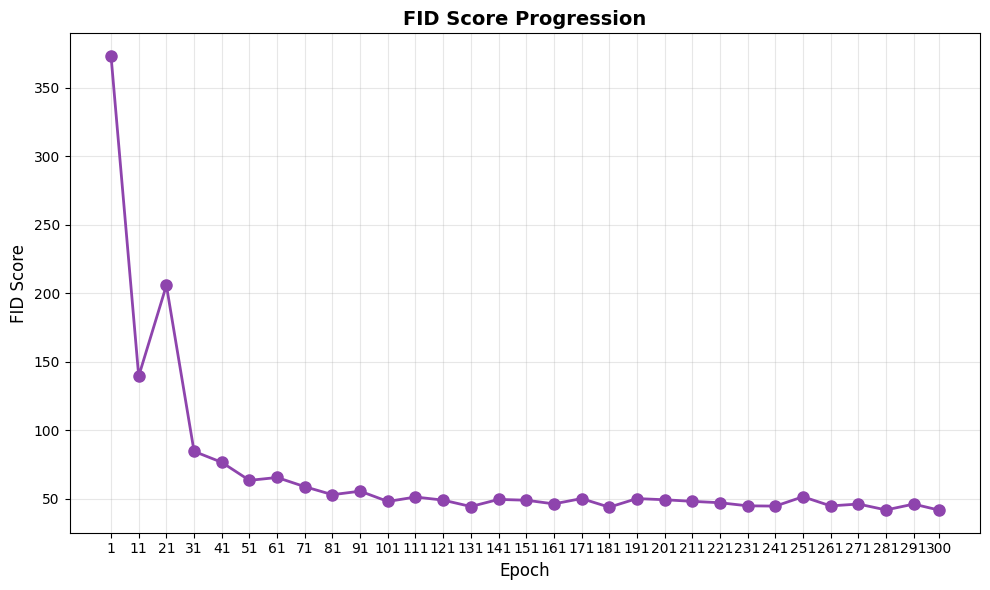

Generating samples...
Samples generated and saved to output directory.


In [10]:
# Train the model
generator, discriminator, fid_scores, epochs_with_fid = train_dcgan()

# Display the final FID score
print(f"Final FID score: {fid_scores[-1]:.4f}")

# Plot the FID scores
plt.figure(figsize=(10, 6))
plt.plot(epochs_with_fid, fid_scores, marker='o', linestyle='-', color='#8E44AD', linewidth=2, markersize=8)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('FID Score', fontsize=12)
plt.title('FID Score Progression', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(epochs_with_fid)
plt.tight_layout()
plt.show()

# Generate samples
print("Generating samples...")
samples = generate_samples(generator, n_samples=100)
print("Samples generated and saved to output directory.")

In [11]:
# Specific augmentation counts as requested (same as ACGAN)
target_counts = {
    'NV': 0,        # No augmentation for NV (already has 6705 images)
    'MEL': 3340,    # Add 3340 images to reach ~4450 total
    'BKL': 3300,    # Add 3300 images to reach ~4400 total
    'BCC': 2000,    # Add 2000 images to reach ~2500 total
    'AKIEC': 1300   # Add 1300 images to reach ~1600 total
}
print(f"Target augmentation counts: {target_counts}")

# Create output directory for augmented images
gan_augmented_dir = "/content/drive/MyDrive/ham_windsurf/results/dcgan/gan_augmented_images"
os.makedirs(gan_augmented_dir, exist_ok=True)

# Generate images for data augmentation
generator.eval()
with torch.no_grad():
    for class_name, count in target_counts.items():
        if count <= 0:
            print(f"Skipping {class_name} (no augmentation needed)")
            continue

        class_dir = os.path.join(gan_augmented_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)

        print(f"Generating {count} images for class {class_name}...")

        # Generate in batches for efficiency
        batch_size = 64
        for batch_start in tqdm(range(0, count, batch_size)):
            # Calculate actual batch size (might be smaller for the last batch)
            actual_batch_size = min(batch_size, count - batch_start)

            # Generate noise
            z = torch.randn(actual_batch_size, latent_dim).to(device)

            # Generate images
            gen_imgs = generator(z)

            # Normalize to [0, 1]
            gen_imgs = (gen_imgs + 1) / 2

            # Convert to numpy for saving
            fake_images = gen_imgs.cpu().numpy().transpose(0, 2, 3, 1) * 255

            # Save each image in the batch
            for j in range(actual_batch_size):
                img_idx = batch_start + j
                img_path = os.path.join(class_dir, f"{class_name}_gen_{img_idx:05d}.jpg")
                img = fake_images[j].astype(np.uint8)
                plt.imsave(img_path, img)

Target augmentation counts: {'NV': 0, 'MEL': 3340, 'BKL': 3300, 'BCC': 2000, 'AKIEC': 1300}
Skipping NV (no augmentation needed)
Generating 3340 images for class MEL...


  0%|          | 0/53 [00:00<?, ?it/s]

Generating 3300 images for class BKL...


  0%|          | 0/52 [00:00<?, ?it/s]

Generating 2000 images for class BCC...


  0%|          | 0/32 [00:00<?, ?it/s]

Generating 1300 images for class AKIEC...


  0%|          | 0/21 [00:00<?, ?it/s]

In [12]:
print("\nCompleted targeted augmentation:")
print(f"| Class | Current | Augmented | Total After |")
print(f"| ----- | ------- | --------- | ----------- |")
for category in categories:
    original_count = class_counts[category]
    augmented_count = target_counts.get(category, 0)
    total_count = original_count + augmented_count
    print(f"| {category} | {original_count} | +{augmented_count} | {total_count} |")

# Create DataFrame for GAN-augmented images
os.makedirs('/content/drive/MyDrive/ham_windsurf/data', exist_ok=True)
gan_augmented_rows = []

# Use the same classes as in our targeted augmentation
augment_classes = ['MEL', 'BKL', 'BCC', 'AKIEC']  # NV is skipped as it has 0 augmentation

for cls_name in augment_classes:
    cls_dir = os.path.join(gan_augmented_dir, cls_name)
    if not os.path.exists(cls_dir):
        continue

    print(f"Processing {cls_name} directory...")

    # Count files to show progress
    files = [f for f in os.listdir(cls_dir) if f.endswith('.jpg')]
    print(f"Found {len(files)} images for {cls_name}")

    for filename in tqdm(files):
        # Extract base filename without extension
        base_filename = os.path.splitext(filename)[0]

        # Create row with one-hot encoding
        row = {'image': base_filename}
        for category in categories:
            row[category] = 1.0 if category == cls_name else 0.0

        gan_augmented_rows.append(row)

# Create DataFrame
gan_augmented_df = pd.DataFrame(gan_augmented_rows)
print(f"Created DataFrame with {len(gan_augmented_df)} GAN-augmented images")

# Combine with original training data
combined_df = pd.concat([df, gan_augmented_df], ignore_index=True)
print(f"Combined DataFrame has {len(combined_df)} total images")

# Save combined DataFrame
output_csv_path = '/content/drive/MyDrive/ham_windsurf/data/dcgan_augmented_train.csv'
combined_df.to_csv(output_csv_path, index=False)
print(f"Saved combined dataset to {output_csv_path}")

# Display final class distribution after GAN augmentation
print("\nFinal class distribution after GAN augmentation:")
print(f"| Class | Original | Augmented | Total |")
print(f"| ----- | -------- | --------- | ----- |")
for category in categories:
    original_count = int(df[category].sum())
    augmented_count = int(gan_augmented_df[category].sum()) if category in augment_classes else 0
    total_count = int(combined_df[category].sum())
    print(f"| {category} | {original_count} | +{augmented_count} | {total_count} |")

# Verify the augmentation matches our targets
print("\nVerifying augmentation counts:")
for category in augment_classes:
    target = target_counts[category]
    actual = int(gan_augmented_df[category].sum())
    if target == actual:
        print(f"✓ {category}: Target {target}, Actual {actual} - MATCH")
    else:
        print(f"✗ {category}: Target {target}, Actual {actual} - MISMATCH")


Completed targeted augmentation:
| Class | Current | Augmented | Total After |
| ----- | ------- | --------- | ----------- |
| NV | 6705 | +0 | 6705 |
| MEL | 1113 | +3340 | 4453 |
| BKL | 1099 | +3300 | 4399 |
| BCC | 514 | +2000 | 2514 |
| AKIEC | 327 | +1300 | 1627 |
Processing MEL directory...
Found 3340 images for MEL


  0%|          | 0/3340 [00:00<?, ?it/s]

Processing BKL directory...
Found 3300 images for BKL


  0%|          | 0/3300 [00:00<?, ?it/s]

Processing BCC directory...
Found 2000 images for BCC


  0%|          | 0/2000 [00:00<?, ?it/s]

Processing AKIEC directory...
Found 1300 images for AKIEC


  0%|          | 0/1300 [00:00<?, ?it/s]

Created DataFrame with 9940 GAN-augmented images
Combined DataFrame has 19698 total images
Saved combined dataset to /content/drive/MyDrive/ham_windsurf/data/dcgan_augmented_train.csv

Final class distribution after GAN augmentation:
| Class | Original | Augmented | Total |
| ----- | -------- | --------- | ----- |
| NV | 6705 | +0 | 6705 |
| MEL | 1113 | +3340 | 4453 |
| BKL | 1099 | +3300 | 4399 |
| BCC | 514 | +2000 | 2514 |
| AKIEC | 327 | +1300 | 1627 |

Verifying augmentation counts:
✓ MEL: Target 3340, Actual 3340 - MATCH
✓ BKL: Target 3300, Actual 3300 - MATCH
✓ BCC: Target 2000, Actual 2000 - MATCH
✓ AKIEC: Target 1300, Actual 1300 - MATCH


In [13]:
drive.flush_and_unmount()